<a href="https://colab.research.google.com/github/AndreiAf02/STAT561_Project/blob/main/Credit_Default_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##STAT 561 Project - Predicting Heart Disease From Diabetes with Transfer Learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import perf_counter



from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
# !pip install pytorch-tabnet

# from pytorch_tabnet.tab_model import TabNetClassifier
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



## Data taken from the UCI Machine Learning repository [here](https://doi.org/10.24432/C55S3H):

In [2]:
pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
default_of_credit_card_clients = fetch_ucirepo(id=350)

# data (as pandas dataframes)
X = default_of_credit_card_clients.data.features
y = default_of_credit_card_clients.data.targets

# metadata
print(default_of_credit_card_clients.metadata)

# variable information
print(default_of_credit_card_clients.variables)

{'uci_id': 350, 'name': 'Default of Credit Card Clients', 'repository_url': 'https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients', 'data_url': 'https://archive.ics.uci.edu/static/public/350/data.csv', 'abstract': "This research aimed at the case of customers' default payments in Taiwan and compares the predictive accuracy of probability of default among six data mining methods.", 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 30000, 'num_features': 23, 'feature_types': ['Integer', 'Real'], 'demographics': ['Sex', 'Education Level', 'Marital Status', 'Age'], 'target_col': ['Y'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Fri Mar 29 2024', 'dataset_doi': '10.24432/C55S3H', 'creators': ['I-Cheng Yeh'], 'intro_paper': {'ID': 365, 'type': 'NATIVE', 'title': 'The comparisons of data mining techniques for the predictive accuracy of 

In [4]:
X

X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  ...     X14    X15    X16  \
0       20000   2   2   1  24   2   2  -1  -1   -2  ...     689      0      0   
1      120000   2   2   2  26  -1   2   0   0    0  ...    2682   3272   3455   
2       90000   2   2   2  34   0   0   0   0    0  ...   13559  14331  14948   
3       50000   2   2   1  37   0   0   0   0    0  ...   49291  28314  28959   
4       50000   1   2   1  57  -1   0  -1   0    0  ...   35835  20940  19146   
...       ...  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...     ...    ...    ...   
29995  220000   1   3   1  39   0   0   0   0    0  ...  208365  88004  31237   
29996  150000   1   3   2  43  -1  -1  -1  -1    0  ...    3502   8979   5190   
29997   30000   1   2   2  37   4   3   2  -1    0  ...    2758  20878  20582   
29998   80000   1   3   1  41   1  -1   0   0    0  ...   76304  52774  11855   
29999   50000   1   2   1  46   0   0   0   0    0  ...   49764  36535  32428   

         X17    X18    X19    X20   X21    X22   X23  
0          0      0    689      0     0      0     0  
1       3261      0   1000   1000  1000      0  2000  
2      15549   1518   1500   1000  1000   1000  5000  
3      29547   2000   2019   1200  1100   1069  1000  
4      19131   2000  36681  10000  9000    689   679  
...      ...    ...    ...    ...   ...    ...   ...  
29995  15980   8500  20000   5003  3047   5000  1000  
29996      0   1837   3526   8998   129      0     0  
29997  19357      0      0  22000  4200   2000  3100  
29998  48944  85900   3409   1178  1926  52964  1804  
29999  15313   2078   1800   1430  1000   1000  1000  

[30000 rows x 23 columns]

In [5]:
X.iloc[:,2].unique()

array([2, 1, 3, 5, 4, 6, 0])

In [6]:
data_all = pd.concat([X,y],axis=1)

## Cleaning up education:
data_all = data_all[(data_all.iloc[:,2] !=6) & (data_all.iloc[:,2] !=5) & (data_all.iloc[:,2] !=0)].reset_index(drop=True)

## Cleaning up September 2005 Pay_0 to only take values listed in repo:
data_all = data_all[(data_all.iloc[:,5] !=-2)].reset_index(drop=True)

## Creating binary outcome of whether September 2005 payment is late:
y2 = []
for i in range(len(data_all)):
  if data_all.iloc[i, 5] > 0:
    y2.append(1)
  else:
    y2.append(0)

data_all['Y2'] = y2

## Dropping the September 2005 lateness factor X6 for analyzing the Y2 variable:
data_all = data_all.drop(columns = ['X6'])

data_all

X1  X2  X3  X4  X5  X7  X8  X9  X10  X11  ...    X16    X17    X18  \
0       20000   2   2   1  24   2  -1  -1   -2   -2  ...      0      0      0   
1      120000   2   2   2  26   2   0   0    0    2  ...   3455   3261      0   
2       90000   2   2   2  34   0   0   0    0    0  ...  14948  15549   1518   
3       50000   2   2   1  37   0   0   0    0    0  ...  28959  29547   2000   
4       50000   1   2   1  57   0  -1   0    0    0  ...  19146  19131   2000   
...       ...  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...    ...    ...    ...   
26935  220000   1   3   1  39   0   0   0    0    0  ...  31237  15980   8500   
26936  150000   1   3   2  43  -1  -1  -1    0    0  ...   5190      0   1837   
26937   30000   1   2   2  37   3   2  -1    0    0  ...  20582  19357      0   
26938   80000   1   3   1  41  -1   0   0    0   -1  ...  11855  48944  85900   
26939   50000   1   2   1  46   0   0   0    0    0  ...  32428  15313   2078   

         X19    X20   X21    X22   X23  Y  Y2  
0        689      0     0      0     0  1   1  
1       1000   1000  1000      0  2000  1   0  
2       1500   1000  1000   1000  5000  0   0  
3       2019   1200  1100   1069  1000  0   0  
4      36681  10000  9000    689   679  0   0  
...      ...    ...   ...    ...   ... ..  ..  
26935  20000   5003  3047   5000  1000  0   0  
26936   3526   8998   129      0     0  0   0  
26937      0  22000  4200   2000  3100  1   1  
26938   3409   1178  1926  52964  1804  1   1  
26939   1800   1430  1000   1000  1000  1   0  

[26940 rows x 24 columns]

In [7]:
X = data_all.iloc[:, :-2]
y = data_all.iloc[:,-2]
y2 = data_all.iloc[:,-1]
y

0        1
1        1
2        0
3        0
4        0
        ..
26935    0
26936    0
26937    1
26938    1
26939    1
Name: Y, Length: 26940, dtype: int64

In [8]:
X.iloc[:,2].unique()

array([2, 1, 3, 4])

In [9]:
## Scaling the predictive data

scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled)

In [10]:
data2 = pd.concat([X_scaled, y, y2], axis=1)
data2

0    1         2         3         4    5    6    7    8    9  \
0      0.010101  1.0  0.333333  0.333333  0.051724  0.4  0.1  0.1  0.0  0.0   
1      0.111111  1.0  0.333333  0.666667  0.086207  0.4  0.2  0.2  0.2  0.4   
2      0.080808  1.0  0.333333  0.666667  0.224138  0.2  0.2  0.2  0.2  0.2   
3      0.040404  1.0  0.333333  0.333333  0.275862  0.2  0.2  0.2  0.2  0.2   
4      0.040404  0.0  0.333333  0.333333  0.620690  0.2  0.1  0.2  0.2  0.2   
...         ...  ...       ...       ...       ...  ...  ...  ...  ...  ...   
26935  0.212121  0.0  0.666667  0.333333  0.310345  0.2  0.2  0.2  0.2  0.2   
26936  0.141414  0.0  0.666667  0.666667  0.379310  0.1  0.1  0.1  0.2  0.2   
26937  0.020202  0.0  0.333333  0.666667  0.275862  0.5  0.4  0.1  0.2  0.2   
26938  0.070707  0.0  0.666667  0.333333  0.344828  0.1  0.2  0.2  0.2  0.1   
26939  0.040404  0.0  0.333333  0.333333  0.431034  0.2  0.2  0.2  0.2  0.2   

       ...        14        15        16        17        18        19  \
0      ...  0.080648  0.260979  0.000000  0.000561  0.000000  0.000000   
1      ...  0.084074  0.263485  0.000000  0.000815  0.001116  0.001610   
2      ...  0.095470  0.272928  0.001738  0.001222  0.001116  0.001610   
3      ...  0.109363  0.283685  0.002290  0.001645  0.001339  0.001771   
4      ...  0.099633  0.275681  0.002290  0.029893  0.011160  0.014493   
...    ...       ...       ...       ...       ...       ...       ...   
26935  ...  0.111622  0.273259  0.009730  0.016299  0.005583  0.004907   
26936  ...  0.085794  0.260979  0.002103  0.002873  0.010042  0.000208   
26937  ...  0.101057  0.275854  0.000000  0.000000  0.024552  0.006763   
26938  ...  0.092403  0.298591  0.098334  0.002778  0.001315  0.003101   
26939  ...  0.112803  0.272746  0.002379  0.001467  0.001596  0.001610   

             20        21  Y  Y2  
0      0.000000  0.000000  1   1  
1      0.000000  0.003783  1   0  
2      0.002345  0.009458  0   0  
3      0.002506  0.001892  0   0  
4      0.001615  0.001284  0   0  
...         ...       ... ..  ..  
26935  0.011723  0.001892  0   0  
26936  0.000000  0.000000  0   0  
26937  0.004689  0.005864  1   1  
26938  0.124174  0.003412  1   1  
26939  0.002345  0.001892  1   0  

[26940 rows x 24 columns]

In [11]:
y.value_counts()

Y
0    20694
1     6246
Name: count, dtype: int64

In [12]:
y2.value_counts()

Y2
0    20167
1     6773
Name: count, dtype: int64

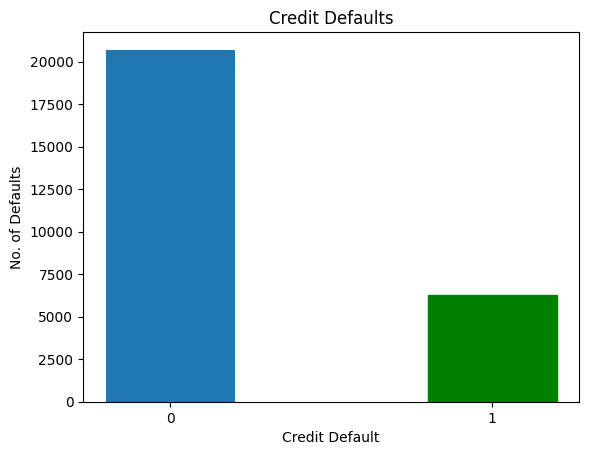

In [13]:
barlist = plt.bar([str(0),str(1)], y.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Credit Default")
plt.ylabel("No. of Defaults")
plt.title("Credit Defaults")
plt.show()

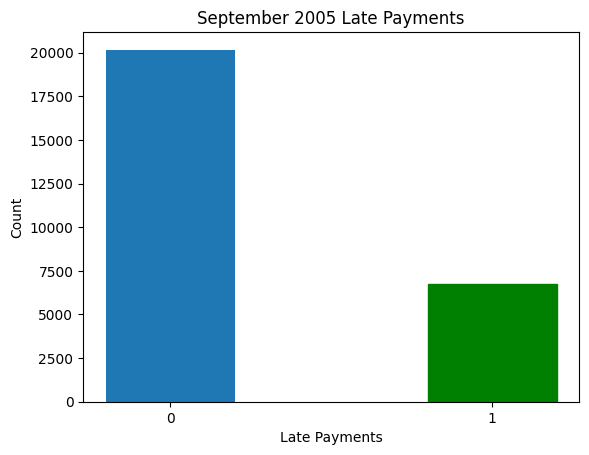

In [14]:
barlist = plt.bar([str(0),str(1)], y2.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Late Payments")
plt.ylabel("Count")
plt.title("September 2005 Late Payments")
plt.show()

# Splitting for Source and Target Domains:


# Full Dataset:

For the Heart Disease prediction, we split the dataset between low education level (**now including high-school dropouts**) and the high education level. The high-education data (with diabetes as response variable/label) becomes the source data and the low-education data (with Heart Disease as response variable/label) is the target data.

In [15]:
data_S = data2[data2[2] <= 0.5].reset_index(drop=True)  ## Source domain and classification
data_S_X = data_S.iloc[:,:-2]
data_S_y = data_S.iloc[:, -1]    ## Response variable of interest is Sept 2005 Late Payment

data_S_full = pd.concat([data_S_X, data_S_y], axis=1)

data_T = data2[data2[2] > 0.5].reset_index(drop=True) ## Target domain and classification

data_T_X = data_T.iloc[:,:-2]
data_T_y = data_T.iloc[:, -2]    ## Response variable of interest in Default

data_T_full = pd.concat([data_T_X, data_T_y], axis=1)

In [16]:
data_S_full

0    1         2         3         4    5    6    7    8    9  \
0      0.010101  1.0  0.333333  0.333333  0.051724  0.4  0.1  0.1  0.0  0.0   
1      0.111111  1.0  0.333333  0.666667  0.086207  0.4  0.2  0.2  0.2  0.4   
2      0.080808  1.0  0.333333  0.666667  0.224138  0.2  0.2  0.2  0.2  0.2   
3      0.040404  1.0  0.333333  0.333333  0.275862  0.2  0.2  0.2  0.2  0.2   
4      0.040404  0.0  0.333333  0.333333  0.620690  0.2  0.1  0.2  0.2  0.2   
...         ...  ...       ...       ...       ...  ...  ...  ...  ...  ...   
22266  0.202020  0.0  0.333333  0.333333  0.224138  0.4  0.4  0.4  0.4  0.4   
22267  0.090909  0.0  0.000000  0.666667  0.293103  0.1  0.1  0.2  0.2  0.2   
22268  0.070707  0.0  0.333333  0.666667  0.224138  0.4  0.4  0.4  0.4  0.4   
22269  0.020202  0.0  0.333333  0.666667  0.275862  0.5  0.4  0.1  0.2  0.2   
22270  0.040404  0.0  0.333333  0.333333  0.431034  0.2  0.2  0.2  0.2  0.2   

       ...        13        14        15        16        17        18  \
0      ...  0.160138  0.080648  0.260979  0.000000  0.000561  0.000000   
1      ...  0.163220  0.084074  0.263485  0.000000  0.000815  0.001116   
2      ...  0.173637  0.095470  0.272928  0.001738  0.001222  0.001116   
3      ...  0.186809  0.109363  0.283685  0.002290  0.001645  0.001339   
4      ...  0.179863  0.099633  0.275681  0.002290  0.029893  0.011160   
...    ...       ...       ...       ...       ...       ...       ...   
22266  ...  0.162493  0.083127  0.262900  0.000000  0.000000  0.000000   
22267  ...  0.226667  0.149535  0.303248  0.002290  0.091097  0.004464   
22268  ...  0.233160  0.162558  0.323347  0.008013  0.002852  0.000000   
22269  ...  0.179805  0.101057  0.275854  0.000000  0.000000  0.024552   
22270  ...  0.194553  0.112803  0.272746  0.002379  0.001467  0.001596   

             19        20        21  Y2  
0      0.000000  0.000000  0.000000   1  
1      0.001610  0.000000  0.003783   0  
2      0.001610  0.002345  0.009458   0  
3      0.001771  0.002506  0.001892   0  
4      0.014493  0.001615  0.001284   0  
...         ...       ...       ...  ..  
22266  0.000000  0.000000  0.000000   1  
22267  0.004831  0.004689  0.003783   0  
22268  0.011272  0.000000  0.007566   1  
22269  0.006763  0.004689  0.005864   1  
22270  0.001610  0.002345  0.001892   0  

[22271 rows x 23 columns]

In [17]:
data_T_full

0    1         2         3         4    5    6    7    8    9  \
0     0.131313  1.0  0.666667  0.333333  0.120690  0.2  0.4  0.2  0.2  0.2   
1     0.191919  1.0  0.666667  0.666667  0.224138  0.2  0.4  0.2  0.2  0.1   
2     0.040404  1.0  0.666667  1.000000  0.034483  0.4  0.2  0.2  0.2  0.2   
3     0.121212  1.0  0.666667  0.666667  0.310345  0.2  0.2  0.2  0.2  0.1   
4     0.040404  0.0  0.666667  0.666667  0.034483  0.2  0.2  0.2  0.2  0.2   
...        ...  ...       ...       ...       ...  ...  ...  ...  ...  ...   
4664  0.040404  0.0  0.666667  0.666667  0.362069  0.2  0.2  0.2  0.2  0.2   
4665  0.000000  0.0  0.666667  0.333333  0.379310  0.2  0.2  0.0  0.0  0.0   
4666  0.212121  0.0  0.666667  0.333333  0.310345  0.2  0.2  0.2  0.2  0.2   
4667  0.141414  0.0  0.666667  0.666667  0.379310  0.1  0.1  0.1  0.2  0.2   
4668  0.070707  0.0  0.666667  0.333333  0.344828  0.1  0.2  0.2  0.2  0.1   

      ...        13        14        15        16        17        18  \
0     ...  0.171640  0.092342  0.263837  0.003811  0.000000  0.000482   
1     ...  0.162505  0.082461  0.263846  0.002640  0.000010  0.000056   
2     ...  0.187240  0.109930  0.284195  0.000000  0.001222  0.001228   
3     ...  0.179558  0.092351  0.261693  0.003434  0.001253  0.001116   
4     ...  0.187424  0.110226  0.284069  0.002259  0.001162  0.001117   
...   ...       ...       ...       ...       ...       ...       ...   
4664  ...  0.207576  0.100451  0.276113  0.011448  0.003260  0.005580   
4665  ...  0.160138  0.080648  0.260979  0.002290  0.000000  0.000000   
4666  ...  0.243036  0.111622  0.273259  0.009730  0.016299  0.005583   
4667  ...  0.168596  0.085794  0.260979  0.002103  0.002873  0.010042   
4668  ...  0.209850  0.092403  0.298591  0.098334  0.002778  0.001315   

            19        20        21  Y  
0     0.001610  0.002345  0.001892  0  
1     0.000483  0.008764  0.000125  0  
2     0.001932  0.003048  0.002081  0  
3     0.003221  0.002180  0.063866  0  
4     0.002306  0.002490  0.001886  0  
...        ...       ...       ... ..  
4664  0.004831  0.010550  0.003783  0  
4665  0.000000  0.000000  0.000000  0  
4666  0.004907  0.011723  0.001892  0  
4667  0.000208  0.000000  0.000000  0  
4668  0.003101  0.124174  0.003412  1  

[4669 rows x 23 columns]

## Source domain and task labels:

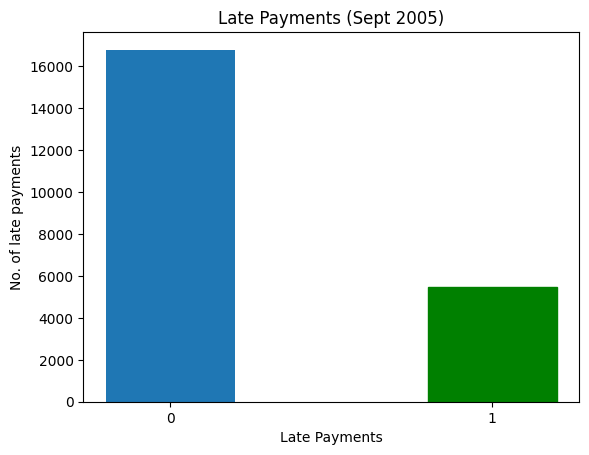

In [18]:
barlist_S = plt.bar([str(0),str(1)], data_S_y.value_counts(), width = 0.4)
barlist_S[1].set_color('g')

plt.xlabel("Late Payments")
plt.ylabel("No. of late payments")
plt.title("Late Payments (Sept 2005)")
plt.show()

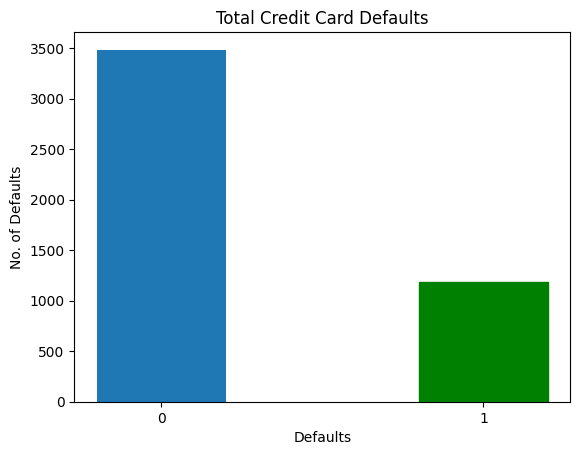

In [19]:
barlist_T = plt.bar([str(0),str(1)], data_T_y.value_counts(), width = 0.4)
barlist_T[1].set_color('g')

plt.xlabel("Defaults")
plt.ylabel("No. of Defaults")
plt.title("Total Credit Card Defaults")
plt.show()

## Updated Code (Modified from Shreya's code):

In [20]:
def create_dnn_model(input_shape):
  model = models.Sequential([layers.Dense(64, activation='relu', input_dim=input_shape),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # For binary classification (yes/no diabetes)
    ])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

  model.summary()
  print(len(model.layers))

  return model

# def create_dnn_model(input_shape):
#   model = models.Sequential([layers.Dense(64, activation='relu', input_dim=input_shape),
#         layers.Dense(32, activation='relu'),
#         layers.Dense(1, activation='sigmoid')  # For binary classification (yes/no diabetes)
#     ])

#   model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

#   return model



def train_and_evaluate(model, X_train, X_test, y_train, y_test, domain):

    time_start = perf_counter()

    # Training and validation
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

    # Predict probabilities and calculate AUC
    y_pred_prob = model.predict(X_test).ravel()
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC-ROC: {auc}")

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    # Convert probabilities to binary predictions for confusion matrix
    y_pred_class = (y_pred_prob >= 0.5).astype(int)

    # Compute and print classification report
    class_report = classification_report(y_test, y_pred_class)
    print("Classification Report:")
    print(class_report)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_class)
    conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    # Plot ROC curve and Confusion Matrix side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # ROC Curve
    ax1.plot(fpr, tpr, color='blue', label=f'AUC-ROC = {auc:.2f}')
    ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax1.legend(loc='lower right')
    ax1.grid()

    # Confusion Matrix
    conf_disp.plot(ax=ax2, cmap='Blues')
    ax2.set_title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Calculate precision and recall for different thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

    # Find the threshold where precision and recall are balanced
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[f1_scores.argmax()]

    print(f"Best threshold based on F1-score: {best_threshold}")

    time_stop = perf_counter()

    print('Time elapsed (performance):', time_stop-time_start)

    model.save('model.h5')
    model.save_weights('model_wt.weights.h5')

    return model


In [21]:
def train_and_evaluate_nosave(model, X_train, X_test, y_train, y_test, domain):

    time_start = perf_counter()

    # Training and validation
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

    # Predict probabilities and calculate AUC
    y_pred_prob = model.predict(X_test).ravel()
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC-ROC: {auc}")

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    # Convert probabilities to binary predictions for confusion matrix
    y_pred_class = (y_pred_prob >= 0.5).astype(int)

    # Compute and print classification report
    class_report = classification_report(y_test, y_pred_class)
    print("Classification Report:")
    print(class_report)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_class)
    conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    fpr = conf_matrix[0][1]/(conf_matrix[0][0]+conf_matrix[0][1])
    fnr = conf_matrix[1][0]/(conf_matrix[1][0] + conf_matrix[1][1])

    print(fpr)
    print(fnr)

    time_stop = perf_counter()

    print('Time elapsed (performance):', time_stop-time_start)

    return fpr, fnr


In [22]:
def fine_tuning(X_train, X_test, y_train, y_test, llim, ulim):
    new_model = create_dnn_model(X_S_train.shape[1])
    # new_model = tf.keras.models.load_model('model.h5')
    new_model.load_weights('model_wt.weights.h5')

    for layer in new_model.layers[llim:ulim]:
        layer.trainable = False
    for layer in new_model.layers[-1:]:
        layer.trainable = False

    for layer in new_model.layers:
        if layer.trainable == True:
          print("Trainable")
        else:
          print("Not Trainable")

    fpr, fnr = train_and_evaluate_nosave(new_model, X_train, X_test, y_train, y_test, "Target")
    return fpr, fnr

In [23]:
def Transductive_TL(model, X_test, y_test, domain):

    time_start = perf_counter()

    # Predict probabilities and calculate AUC
    y_pred_prob = model.predict(X_test).ravel()
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC-ROC: {auc}")

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    # Convert probabilities to binary predictions for confusion matrix
    y_pred_class = (y_pred_prob >= 0.5).astype(int)

    # Compute and print classification report
    class_report = classification_report(y_test, y_pred_class)
    print("Classification Report:")
    print(class_report)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_class)
    conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    # Plot ROC curve and Confusion Matrix side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # ROC Curve
    ax1.plot(fpr, tpr, color='blue', label=f'AUC-ROC = {auc:.2f}')
    ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax1.legend(loc='lower right')
    ax1.grid()

    # Confusion Matrix
    # print('Confusion matrix:', conf_matrix)
    fpr = conf_matrix[0][1]/(conf_matrix[0][0]+conf_matrix[0][1])
    tnr = 1-fpr

    fnr = conf_matrix[1][0]/(conf_matrix[1][0] + conf_matrix[1][1])
    tpr = 1 - fnr
    print('FPR', fpr, 'TPR:', tpr, 'FNR:', fnr, 'TNR:', tnr)
    conf_disp.plot(ax=ax2, cmap='Blues')
    ax2.set_title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Calculate precision and recall for different thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

    # Find the threshold where precision and recall are balanced
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[f1_scores.argmax()]

    print(f"Best threshold based on F1-score: {best_threshold}")
    print('False Negative Rate:', fnr)

    time_stop = perf_counter()

    print('Time elapsed (performance):', time_stop-time_start)

# Over/undersampling functions:

## Undersampling functions:

In [24]:
import random

def SRS_undersampler(data, data_column):
    data_majority = data[data_column.isin([0])]
    data_minority = data[data_column.isin([1])]
    undersample_size = len(data_minority)
    oversample_size = len(data_majority)

    print(undersample_size)
    print(oversample_size)

    np.random.seed(123)
    data_maj_rus = data_majority.sample(n=undersample_size, replace=False)
    data_SRS_RUS = pd.concat([data_maj_rus, data_minority])
    X_SRS = data_SRS_RUS.iloc[:, :-1]
    y_SRS = data_SRS_RUS.iloc[:, -1]

    return X_SRS, y_SRS


def SRSwR_undersampler(data, data_column):
    data_majority = data[data_column.isin([0])]
    data_minority = data[data_column.isin([1])]
    undersample_size = len(data_minority)
    oversample_size = len(data_majority)

    print(undersample_size)
    print(oversample_size)

    np.random.seed(123)
    data_maj_rus = data_majority.sample(n=undersample_size, replace=True)
    data_SRS_RUS = pd.concat([data_maj_rus, data_minority])
    X_SRS = data_SRS_RUS.iloc[:, :-1]
    y_SRS = data_SRS_RUS.iloc[:, -1]

    return X_SRS, y_SRS


def systematic_undersampler(data, data_column):
    data_majority = data[data_column.isin([0])]
    data_minority = data[data_column.isin([1])]
    undersample_size = len(data_minority)
    oversample_size = len(data_majority)
    print(undersample_size)
    print(oversample_size)

    k = oversample_size/undersample_size
    print(k)
    np.random.seed(123)
    start = random.randint(1, int(k))
    print(start)
    Row = []
    for i in range(undersample_size):
      row = start+int(k*i)-1
      Row.append(row)
    print(Row)
    data_maj_rus = pd.DataFrame()
    data_maj_rus = data_majority.iloc[Row]
    data_maj_rus
    data_Sy_RUS = pd.concat([data_maj_rus, data_minority])

    X_Sy = data_Sy_RUS.iloc[:, :-1]
    y_Sy = data_Sy_RUS.iloc[:, -1]

    return X_Sy, y_Sy



def multi_systematic_undersampler(data, data_column, m):
    data_majority = data[data_column.isin([0])]
    data_minority = data[data_column.isin([1])]
    undersample_size = len(data_minority)
    oversample_size = len(data_majority)
    print(undersample_size)
    print(oversample_size)

    k = oversample_size/undersample_size
    print(k)
    np.random.seed(123)
    start = random.sample(range(1, int(k*m)), m)
    Row = []
    for j in range(len(start)):
      for i in range(int(undersample_size/m)):
        row = start[j]+int(k*i)-1
        Row.append(row)
    print(Row)
    data_maj_rus = pd.DataFrame()
    data_maj_rus = data_majority.iloc[Row]
    data_maj_rus
    data_Sy_RUS = pd.concat([data_maj_rus, data_minority])

    X_Sy = data_Sy_RUS.iloc[:, :-1]
    y_Sy = data_Sy_RUS.iloc[:, -1]

    return X_Sy, y_Sy

## Oversampling functions:

In [25]:
def SRSwR_oversampler(data, data_column):
    data_majority = data[data_column.isin([0])]
    data_minority = data[data_column.isin([1])]
    undersample_size = len(data_minority)
    oversample_size = len(data_majority)

    print(undersample_size)
    print(oversample_size)

    np.random.seed(123)
    data_min_ros = data_minority.sample(n=oversample_size - undersample_size, replace=True)
    data_SRS_ROS = pd.concat([data_majority, data_minority, data_min_ros])
    X_SRS = data_SRS_ROS.iloc[:, :-1]
    y_SRS = data_SRS_ROS.iloc[:, -1]

    return X_SRS, y_SRS

# data_S_min_ros = data_S_minority.sample(n=oversample_size - undersample_size, replace=True)


def systematic_resampler(data, data_column, k):
    data_majority = data[data_column.isin([0])]
    data_minority = data[data_column.isin([1])]
    undersample_size = len(data_minority)
    oversample_size = len(data_majority)

    print(undersample_size)
    print(oversample_size)

    Nsamples = k*(oversample_size-undersample_size)/undersample_size
    print('Nsamples=', Nsamples)

    np.random.seed(123)
    start = np.random.choice(int(k), int(Nsamples), replace=True)
    Row = []
    for j in range(len(start)):
      for i in range(int(undersample_size/k)):
        row = start[j]+int(k*i)-1
        Row.append(row)
    data_min_ros = pd.DataFrame()
    data_min_ros = data_minority.iloc[Row]

    data_Sy_ROS = pd.concat([data_majority, data_minority, data_min_ros])
    X_Sy = data_Sy_ROS.iloc[:, :-1]
    y_Sy = data_Sy_ROS.iloc[:, -1]

    return X_Sy, y_Sy

# k = 48

# Nsamples = k*(oversample_size-undersample_size)/undersample_size
# # print(Nsamples)

# np.random.seed(123)
# start = np.random.choice(int(k), int(Nsamples), replace=True)
# # print(start)


# Row = []

# for j in range(len(start)):
#   for i in range(int(undersample_size/k)):
#     row = start[j]+int(k*i)-1
#     Row.append(row)

In [26]:
X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(data_S_X, data_S_y, test_size=0.20, random_state=0)
X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(data_T_X, data_T_y, test_size=0.20, random_state=0)

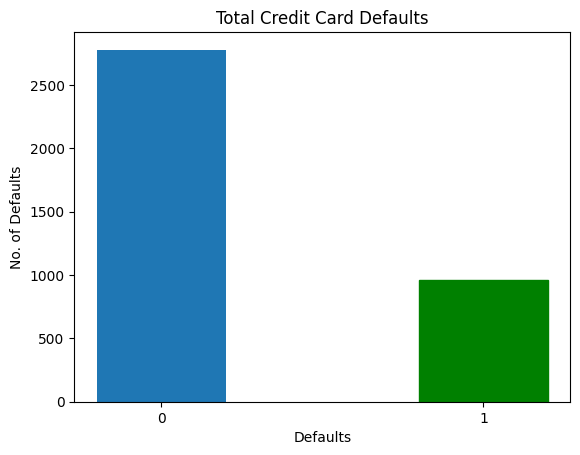

In [27]:
barlist = plt.bar([str(0),str(1)], y_T_train.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Defaults")
plt.ylabel("No. of Defaults")
plt.title("Total Credit Card Defaults")
plt.show()

In [28]:
print('X_S_train:',np.shape(X_S_train))
print('y_S_train:',np.shape(y_S_train))
print('X_S_test:',np.shape(X_S_test))
print('y_S_test:',np.shape(y_S_test))

X_S_train: (17816, 22)
y_S_train: (17816,)
X_S_test: (4455, 22)
y_S_test: (4455,)


# Original (Imbalanced) dataset:

## Standard Machine Learning:

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - AUC: 0.5125 - loss: 0.5953 - val_AUC: 0.6872 - val_loss: 0.5395
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6968 - loss: 0.5245 - val_AUC: 0.6972 - val_loss: 0.5080
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7063 - loss: 0.5023 - val_AUC: 0.6946 - val_loss: 0.5247
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6924 - loss: 0.5105 - val_AUC: 0.7009 - val_loss: 0.5013
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7065 - loss: 0.5148 - val_AUC: 0.7058 - val_loss: 0.5020
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7108 - loss: 0.5087 - val_AUC: 0.7089 - val_loss: 0.4977
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7161 - loss: 0.5021 - val_AUC: 0.7105 - val_loss: 0.4949
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7287 - loss: 0.4992 - val_AUC: 0.7203 - val_loss: 0.4970
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7321 - lo

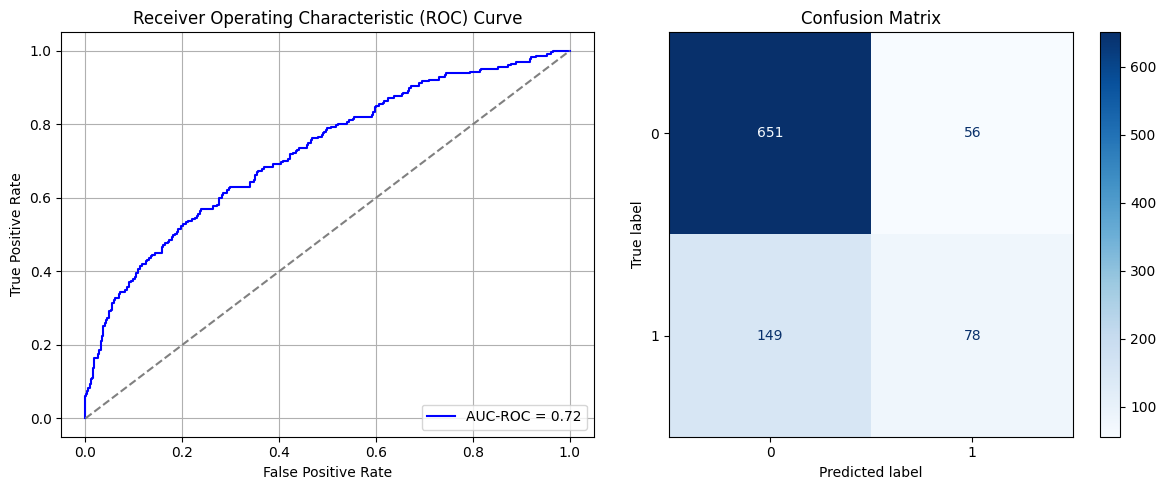

Best threshold based on F1-score: 0.23488153517246246
Time elapsed (performance): 17.770338116000858


<Sequential name=sequential, built=True>

In [29]:
model_source = create_dnn_model(X_S_train.shape[1])
train_and_evaluate(model_source, X_T_train, X_T_test, y_T_train, y_T_test, "Target")

## With Transfer Learning:

In [115]:
model_source = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_75"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_525 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_526 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_527 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_528 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_529 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_530 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_531 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7


Epoch 1/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - AUC: 0.6753 - loss: 0.5021 - val_AUC: 0.8938 - val_loss: 0.2640
Epoch 2/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9028 - loss: 0.2620 - val_AUC: 0.9140 - val_loss: 0.2381
Epoch 3/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9159 - loss: 0.2454 - val_AUC: 0.9200 - val_loss: 0.2374
Epoch 4/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9217 - loss: 0.2317 - val_AUC: 0.9178 - val_loss: 0.2388
Epoch 5/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9181 - loss: 0.2427 - val_AUC: 0.9263 - val_loss: 0.2291
Epoch 6/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9130 - loss: 0.2444 - val_AUC: 0.9251 - val_loss: 0.2354
Epoch 7/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9244 - loss: 0.2306 - val_AUC: 0.9205 - val_loss: 0.2341
Epoch 8/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9235 - loss: 0.2282 - val_AUC: 0.9194 - val_loss: 0.2398
Epoch 9/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AU

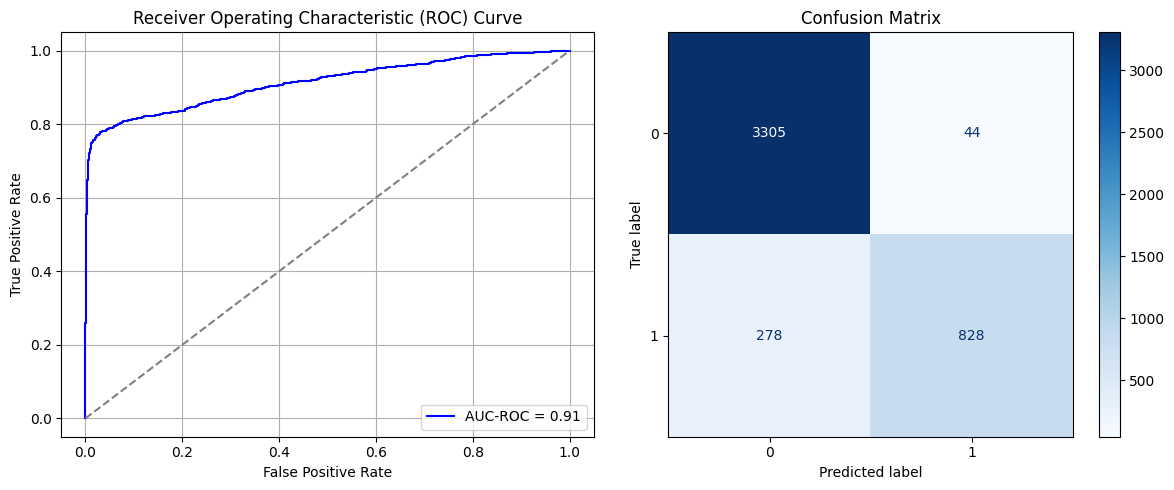

Best threshold based on F1-score: 0.45058515667915344
Time elapsed (performance): 25.371997606999685


<Sequential name=sequential_75, built=True>

In [116]:
train_and_evaluate(model_source, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
# model_source.save('model_source.h5')
# model_source.save_weights('model_wt.weights.h5')

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
AUC-ROC: 0.6933434690227991
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       707
           1       0.50      0.44      0.47       227

    accuracy                           0.76       934
   macro avg       0.66      0.65      0.66       934
weighted avg       0.75      0.76      0.75       934

FPR 0.14427157001414428 TPR: 0.44493392070484583 FNR: 0.5550660792951542 TNR: 0.8557284299858557


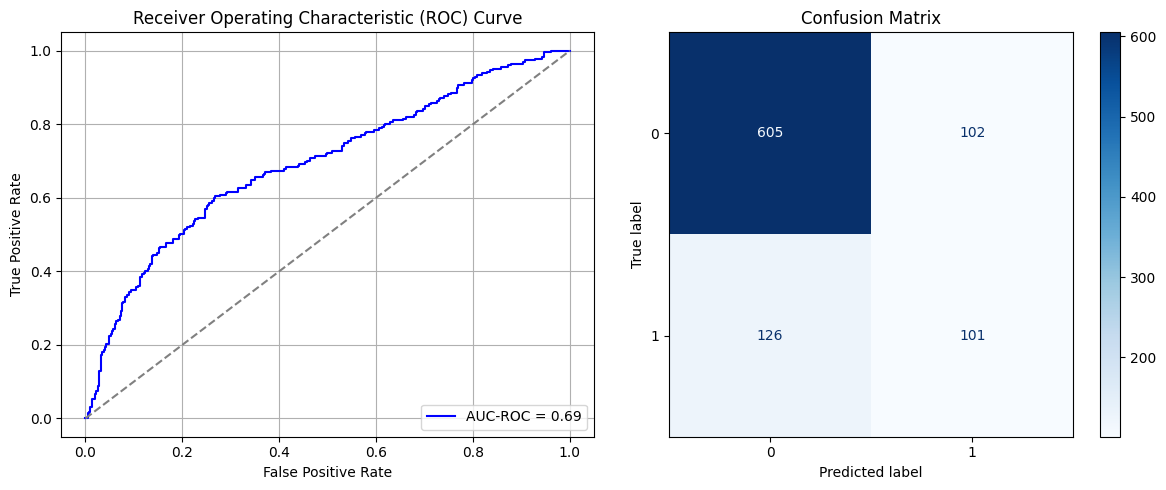

Best threshold based on F1-score: 0.9994907379150391
False Negative Rate: 0.5550660792951542
Time elapsed (performance): 0.6541086799998084


<ipython-input-89-de1f6cb50f3b>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [117]:
Transductive_TL(model_source, X_T_test, y_T_test, "Target")

In [118]:
times = 50

FPR = []
FNR = []

for i in range(times):
    fpr, fnr = fine_tuning(X_T_train, X_T_test, y_T_train, y_T_test, 0, 4)
    # print(output)
    FPR.append(fpr)
    FNR.append(fnr)

ParamFit = pd.DataFrame([FPR, FNR]).T
ParamFit.columns=['FPR', 'FNR']

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_76"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_532 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_533 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_534 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_535 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_536 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_537 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_538 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.7026 - loss: 0.7561 - val_AUC: 0.7147 - val_loss: 0.5016
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7198 - loss: 0.5092 - val_AUC: 0.7188 - val_loss: 0.4923
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7419 - loss: 0.5002 - val_AUC: 0.7194 - val_loss: 0.4929
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7339 - loss: 0.5065 - val_AUC: 0.7188 - val_loss: 0.4907
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7468 - loss: 0.4929 - val_AUC: 0.7188 - val_loss: 0.4917
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7072 - loss: 0.5147 - val_AUC: 0.7191 - val_loss: 0.4914
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7284 - loss: 0.4970 - val_AUC: 0.7185 - val_loss: 0.4913
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7164 - loss: 0.5132 - val_AUC: 0.719

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_77"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_539 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_540 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_541 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_542 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_543 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_544 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_545 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - AUC: 0.7174 - loss: 0.7086 - val_AUC: 0.7135 - val_loss: 0.4996
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7225 - loss: 0.5097 - val_AUC: 0.7166 - val_loss: 0.4917
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7348 - loss: 0.4990 - val_AUC: 0.7190 - val_loss: 0.4913
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7266 - loss: 0.4963 - val_AUC: 0.7207 - val_loss: 0.4909
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7371 - loss: 0.5106 - val_AUC: 0.7209 - val_loss: 0.4908
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7336 - loss: 0.4902 - val_AUC: 0.7195 - val_loss: 0.4922
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7217 - loss: 0.5012 - val_AUC: 0.7208 - val_loss: 0.4903
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7329 - loss: 0.4891 - val_AUC: 0.7195 - val_loss: 0.4911
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7089 - loss: 0.5131 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_78"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_546 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_547 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_548 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_549 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_550 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_551 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_552 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - AUC: 0.7089 - loss: 0.7281 - val_AUC: 0.7148 - val_loss: 0.4945
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7250 - loss: 0.5210 - val_AUC: 0.7177 - val_loss: 0.4908
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7048 - loss: 0.5350 - val_AUC: 0.7203 - val_loss: 0.4928
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7359 - loss: 0.5169 - val_AUC: 0.7193 - val_loss: 0.4916
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7121 - loss: 0.5184 - val_AUC: 0.7203 - val_loss: 0.4908
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7267 - loss: 0.5035 - val_AUC: 0.7192 - val_loss: 0.4900
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7195 - loss: 0.5034 - val_AUC: 0.7194 - val_loss: 0.4904
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7310 - loss: 0.4927 - val_AUC: 0.7190 - val_loss: 0.4915
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7187 - loss: 0.5240 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_79"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_553 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_554 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_555 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_556 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_557 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_558 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_559 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - AUC: 0.7113 - loss: 0.7531 - val_AUC: 0.7131 - val_loss: 0.4987
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7202 - loss: 0.5241 - val_AUC: 0.7187 - val_loss: 0.4913
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7354 - loss: 0.5038 - val_AUC: 0.7194 - val_loss: 0.4910
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7419 - loss: 0.4989 - val_AUC: 0.7182 - val_loss: 0.4915
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7328 - loss: 0.4907 - val_AUC: 0.7195 - val_loss: 0.4904
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7223 - loss: 0.5007 - val_AUC: 0.7201 - val_loss: 0.4902
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7352 - loss: 0.4909 - val_AUC: 0.7201 - val_loss: 0.4906
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7203 - loss: 0.5025 - val_AUC: 0.7180 - val_loss: 0.4906
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7256 - loss: 0.5147 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_80"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_560 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_561 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_562 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_563 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_564 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_565 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_566 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - AUC: 0.7217 - loss: 0.7481 - val_AUC: 0.7133 - val_loss: 0.4967
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7098 - loss: 0.5289 - val_AUC: 0.7184 - val_loss: 0.4904
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7191 - loss: 0.5087 - val_AUC: 0.7200 - val_loss: 0.4909
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7426 - loss: 0.4853 - val_AUC: 0.7193 - val_loss: 0.4912
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7199 - loss: 0.5132 - val_AUC: 0.7194 - val_loss: 0.4903
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7411 - loss: 0.4921 - val_AUC: 0.7194 - val_loss: 0.4909
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7154 - loss: 0.5068 - val_AUC: 0.7202 - val_loss: 0.4895
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7395 - loss: 0.4842 - val_AUC: 0.7191 - val_loss: 0.4916
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7215 - loss: 0.5143 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_81"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_567 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_568 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_569 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_570 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_571 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_572 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_573 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 0.7076 - loss: 0.7257 - val_AUC: 0.7132 - val_loss: 0.4969
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7266 - loss: 0.5097 - val_AUC: 0.7157 - val_loss: 0.4910
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7188 - loss: 0.5091 - val_AUC: 0.7195 - val_loss: 0.4905
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7356 - loss: 0.4919 - val_AUC: 0.7190 - val_loss: 0.4912
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7233 - loss: 0.5006 - val_AUC: 0.7175 - val_loss: 0.4918
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7453 - loss: 0.4929 - val_AUC: 0.7179 - val_loss: 0.4921
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7324 - loss: 0.5027 - val_AUC: 0.7182 - val_loss: 0.4913
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7354 - loss: 0.4899 - val_AUC: 0.7198 - val_loss: 0.4912
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7179 - loss: 0.4995 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_82"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_574 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_575 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_576 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_577 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_578 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_579 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_580 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - AUC: 0.6987 - loss: 0.7641 - val_AUC: 0.7137 - val_loss: 0.5002
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7064 - loss: 0.5142 - val_AUC: 0.7173 - val_loss: 0.4924
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7330 - loss: 0.5013 - val_AUC: 0.7189 - val_loss: 0.4904
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7274 - loss: 0.5063 - val_AUC: 0.7191 - val_loss: 0.4913
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7148 - loss: 0.5031 - val_AUC: 0.7181 - val_loss: 0.4916
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7263 - loss: 0.5007 - val_AUC: 0.7200 - val_loss: 0.4904
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7086 - loss: 0.5099 - val_AUC: 0.7195 - val_loss: 0.4900
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7357 - loss: 0.4828 - val_AUC: 0.7188 - val_loss: 0.4907
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7220 - loss: 0.5147 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_83"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_581 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_582 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_583 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_584 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_585 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_586 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_587 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - AUC: 0.7065 - loss: 0.7525 - val_AUC: 0.7135 - val_loss: 0.5004
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7210 - loss: 0.5132 - val_AUC: 0.7168 - val_loss: 0.4929
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7305 - loss: 0.4994 - val_AUC: 0.7185 - val_loss: 0.4910
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7338 - loss: 0.5077 - val_AUC: 0.7194 - val_loss: 0.4908
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7233 - loss: 0.4992 - val_AUC: 0.7188 - val_loss: 0.4920
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7068 - loss: 0.5121 - val_AUC: 0.7201 - val_loss: 0.4905
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7211 - loss: 0.5101 - val_AUC: 0.7197 - val_loss: 0.4905
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7278 - loss: 0.4998 - val_AUC: 0.7201 - val_loss: 0.4907
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7386 - loss: 0.4953 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_84"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_588 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_589 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_590 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_591 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_592 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_593 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_594 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - AUC: 0.7148 - loss: 0.7647 - val_AUC: 0.7117 - val_loss: 0.5021
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7256 - loss: 0.5030 - val_AUC: 0.7169 - val_loss: 0.4927
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7220 - loss: 0.4904 - val_AUC: 0.7191 - val_loss: 0.4917
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7280 - loss: 0.5014 - val_AUC: 0.7191 - val_loss: 0.4907
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7167 - loss: 0.5076 - val_AUC: 0.7192 - val_loss: 0.4901
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7437 - loss: 0.4891 - val_AUC: 0.7205 - val_loss: 0.4909
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7346 - loss: 0.4882 - val_AUC: 0.7210 - val_loss: 0.4900
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7250 - loss: 0.5116 - val_AUC: 0.7194 - val_loss: 0.4910
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7362 - loss: 0.5014 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_85"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_595 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_596 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_597 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_598 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_599 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_600 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_601 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - AUC: 0.7155 - loss: 0.7273 - val_AUC: 0.7149 - val_loss: 0.4955
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7287 - loss: 0.5081 - val_AUC: 0.7164 - val_loss: 0.4928
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7138 - loss: 0.5043 - val_AUC: 0.7175 - val_loss: 0.4910
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7172 - loss: 0.5265 - val_AUC: 0.7177 - val_loss: 0.4904
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7436 - loss: 0.5024 - val_AUC: 0.7187 - val_loss: 0.4906
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7319 - loss: 0.5098 - val_AUC: 0.7192 - val_loss: 0.4911
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7256 - loss: 0.5003 - val_AUC: 0.7203 - val_loss: 0.4901
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7097 - loss: 0.5138 - val_AUC: 0.7190 - val_loss: 0.4902
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7152 - loss:

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_86"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_602 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_603 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_604 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_605 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_606 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_607 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_608 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - AUC: 0.6862 - loss: 0.7854 - val_AUC: 0.7147 - val_loss: 0.5020
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6962 - loss: 0.5163 - val_AUC: 0.7170 - val_loss: 0.4908
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7441 - loss: 0.5036 - val_AUC: 0.7176 - val_loss: 0.4907
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7225 - loss: 0.5201 - val_AUC: 0.7182 - val_loss: 0.4908
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7191 - loss: 0.5172 - val_AUC: 0.7193 - val_loss: 0.4907
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7308 - loss: 0.5044 - val_AUC: 0.7185 - val_loss: 0.4912
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7465 - loss: 0.5025 - val_AUC: 0.7197 - val_loss: 0.4913
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7134 - loss: 0.5169 - val_AUC: 0.7197 - val_loss: 0.4913
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7188 - loss: 0.5073 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_87"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_609 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_610 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_611 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_612 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_613 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_614 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_615 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - AUC: 0.7171 - loss: 0.7117 - val_AUC: 0.7129 - val_loss: 0.4977
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7364 - loss: 0.5097 - val_AUC: 0.7180 - val_loss: 0.4926
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7299 - loss: 0.5053 - val_AUC: 0.7178 - val_loss: 0.4915
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7091 - loss: 0.5122 - val_AUC: 0.7198 - val_loss: 0.4905
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7239 - loss: 0.5164 - val_AUC: 0.7198 - val_loss: 0.4900
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7131 - loss: 0.5097 - val_AUC: 0.7202 - val_loss: 0.4913
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7301 - loss: 0.5007 - val_AUC: 0.7190 - val_loss: 0.4910
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7222 - loss: 0.5092 - val_AUC: 0.7201 - val_loss: 0.4899
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7189 - loss: 0.5202 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_88"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_616 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_617 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_618 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_619 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_620 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_621 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_622 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - AUC: 0.6933 - loss: 0.7204 - val_AUC: 0.7113 - val_loss: 0.4962
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7215 - loss: 0.5081 - val_AUC: 0.7173 - val_loss: 0.4911
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7156 - loss: 0.5096 - val_AUC: 0.7168 - val_loss: 0.4916
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7387 - loss: 0.5062 - val_AUC: 0.7183 - val_loss: 0.4924
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7315 - loss: 0.4986 - val_AUC: 0.7192 - val_loss: 0.4910
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7193 - loss: 0.5012 - val_AUC: 0.7207 - val_loss: 0.4902
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7219 - loss: 0.5084 - val_AUC: 0.7196 - val_loss: 0.4902
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7387 - loss: 0.4880 - val_AUC: 0.7214 - val_loss: 0.4904
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6913 - loss: 0.5231 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_89"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_623 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_624 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_625 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_626 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_627 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_628 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_629 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - AUC: 0.7257 - loss: 0.6890 - val_AUC: 0.7136 - val_loss: 0.4981
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7317 - loss: 0.4978 - val_AUC: 0.7184 - val_loss: 0.4912
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7348 - loss: 0.5011 - val_AUC: 0.7188 - val_loss: 0.4918
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7297 - loss: 0.4921 - val_AUC: 0.7213 - val_loss: 0.4905
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7129 - loss: 0.5101 - val_AUC: 0.7191 - val_loss: 0.4901
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7325 - loss: 0.4998 - val_AUC: 0.7202 - val_loss: 0.4911
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7154 - loss: 0.5011 - val_AUC: 0.7197 - val_loss: 0.4906
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7204 - loss: 0.5064 - val_AUC: 0.7194 - val_loss: 0.4917
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7150 - loss: 0.5131 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_90"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_630 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_631 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_632 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_633 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_634 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_635 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_636 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - AUC: 0.7299 - loss: 0.6956 - val_AUC: 0.7133 - val_loss: 0.4975
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7322 - loss: 0.5042 - val_AUC: 0.7192 - val_loss: 0.4926
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7197 - loss: 0.4958 - val_AUC: 0.7188 - val_loss: 0.4905
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7214 - loss: 0.5092 - val_AUC: 0.7183 - val_loss: 0.4905
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7486 - loss: 0.4917 - val_AUC: 0.7195 - val_loss: 0.4910
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7482 - loss: 0.4889 - val_AUC: 0.7195 - val_loss: 0.4922
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7147 - loss: 0.5141 - val_AUC: 0.7207 - val_loss: 0.4904
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7273 - loss: 0.4957 - val_AUC: 0.7196 - val_loss: 0.4918
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7170 - loss: 0.5107 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_91"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_637 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_638 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_639 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_640 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_641 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_642 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_643 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - AUC: 0.7186 - loss: 0.7134 - val_AUC: 0.7122 - val_loss: 0.4990
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7115 - loss: 0.5334 - val_AUC: 0.7191 - val_loss: 0.4906
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7150 - loss: 0.5134 - val_AUC: 0.7195 - val_loss: 0.4906
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7304 - loss: 0.4949 - val_AUC: 0.7210 - val_loss: 0.4907
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7344 - loss: 0.4954 - val_AUC: 0.7201 - val_loss: 0.4912
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7439 - loss: 0.4946 - val_AUC: 0.7206 - val_loss: 0.4918
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7431 - loss: 0.5009 - val_AUC: 0.7200 - val_loss: 0.4908
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7052 - loss: 0.5107 - val_AUC: 0.7195 - val_loss: 0.4902
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7319 - loss: 0.5040 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_92"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_644 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_645 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_646 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_647 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_648 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_649 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_650 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - AUC: 0.7148 - loss: 0.7455 - val_AUC: 0.7119 - val_loss: 0.5008
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7250 - loss: 0.5132 - val_AUC: 0.7191 - val_loss: 0.4918
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7444 - loss: 0.4938 - val_AUC: 0.7197 - val_loss: 0.4908
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7369 - loss: 0.4976 - val_AUC: 0.7205 - val_loss: 0.4910
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7089 - loss: 0.5018 - val_AUC: 0.7199 - val_loss: 0.4908
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7290 - loss: 0.5078 - val_AUC: 0.7195 - val_loss: 0.4907
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7072 - loss: 0.5026 - val_AUC: 0.7199 - val_loss: 0.4919
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7245 - loss: 0.4957 - val_AUC: 0.7189 - val_loss: 0.4912
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7135 - loss: 0.5026 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_93"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_651 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_652 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_653 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_654 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_655 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_656 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_657 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - AUC: 0.7108 - loss: 0.7119 - val_AUC: 0.7141 - val_loss: 0.4972
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7106 - loss: 0.5126 - val_AUC: 0.7177 - val_loss: 0.4914
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7274 - loss: 0.4962 - val_AUC: 0.7200 - val_loss: 0.4912
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7212 - loss: 0.5142 - val_AUC: 0.7206 - val_loss: 0.4914
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7190 - loss: 0.5048 - val_AUC: 0.7195 - val_loss: 0.4907
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7166 - loss: 0.5154 - val_AUC: 0.7197 - val_loss: 0.4911
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7112 - loss: 0.5097 - val_AUC: 0.7184 - val_loss: 0.4900
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7214 - loss: 0.5082 - val_AUC: 0.7197 - val_loss: 0.4912
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7291 - loss: 0.5031 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_94"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_658 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_659 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_660 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_661 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_662 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_663 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_664 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - AUC: 0.7187 - loss: 0.7083 - val_AUC: 0.7140 - val_loss: 0.4954
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7113 - loss: 0.5203 - val_AUC: 0.7173 - val_loss: 0.4913
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7071 - loss: 0.5103 - val_AUC: 0.7201 - val_loss: 0.4899
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7332 - loss: 0.5075 - val_AUC: 0.7193 - val_loss: 0.4916
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6928 - loss: 0.5254 - val_AUC: 0.7209 - val_loss: 0.4902
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7268 - loss: 0.5082 - val_AUC: 0.7180 - val_loss: 0.4906
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7196 - loss: 0.5153 - val_AUC: 0.7186 - val_loss: 0.4905
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7231 - loss: 0.5056 - val_AUC: 0.7198 - val_loss: 0.4900
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7391 - loss: 0.4969 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_95"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_665 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_666 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_667 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_668 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_669 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_670 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_671 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - AUC: 0.7154 - loss: 0.6802 - val_AUC: 0.7141 - val_loss: 0.4953
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7273 - loss: 0.5082 - val_AUC: 0.7176 - val_loss: 0.4921
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7344 - loss: 0.4923 - val_AUC: 0.7187 - val_loss: 0.4912
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7234 - loss: 0.5000 - val_AUC: 0.7203 - val_loss: 0.4908
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7269 - loss: 0.5139 - val_AUC: 0.7196 - val_loss: 0.4907
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7309 - loss: 0.5132 - val_AUC: 0.7203 - val_loss: 0.4918
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7206 - loss: 0.5073 - val_AUC: 0.7195 - val_loss: 0.4898
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7222 - loss: 0.5073 - val_AUC: 0.7189 - val_loss: 0.4904
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7360 - loss: 0.4906 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_96"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_672 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_673 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_674 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_675 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_676 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_677 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_678 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - AUC: 0.7069 - loss: 0.7114 - val_AUC: 0.7145 - val_loss: 0.4981
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7084 - loss: 0.5254 - val_AUC: 0.7167 - val_loss: 0.4915
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7229 - loss: 0.5088 - val_AUC: 0.7192 - val_loss: 0.4926
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7262 - loss: 0.4943 - val_AUC: 0.7183 - val_loss: 0.4919
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7403 - loss: 0.4935 - val_AUC: 0.7184 - val_loss: 0.4928
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7163 - loss: 0.5032 - val_AUC: 0.7184 - val_loss: 0.4916
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7017 - loss: 0.5054 - val_AUC: 0.7199 - val_loss: 0.4897
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7350 - loss: 0.4984 - val_AUC: 0.7195 - val_loss: 0.4925
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7304 - loss: 0.4789 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_97"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_679 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_680 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_681 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_682 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_683 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_684 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_685 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - AUC: 0.7138 - loss: 0.7062 - val_AUC: 0.7145 - val_loss: 0.4966
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7187 - loss: 0.5143 - val_AUC: 0.7150 - val_loss: 0.4921
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7125 - loss: 0.5168 - val_AUC: 0.7192 - val_loss: 0.4925
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7076 - loss: 0.5203 - val_AUC: 0.7199 - val_loss: 0.4917
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7203 - loss: 0.5002 - val_AUC: 0.7185 - val_loss: 0.4912
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7130 - loss: 0.5078 - val_AUC: 0.7190 - val_loss: 0.4904
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7266 - loss: 0.4986 - val_AUC: 0.7193 - val_loss: 0.4927
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7297 - loss: 0.5033 - val_AUC: 0.7195 - val_loss: 0.4906
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7306 - loss:

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_98"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_686 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_687 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_688 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_689 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_690 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_691 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_692 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 0.7325 - loss: 0.6950 - val_AUC: 0.7139 - val_loss: 0.4959
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7263 - loss: 0.5119 - val_AUC: 0.7187 - val_loss: 0.4910
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7002 - loss: 0.5216 - val_AUC: 0.7192 - val_loss: 0.4900
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7354 - loss: 0.5029 - val_AUC: 0.7182 - val_loss: 0.4922
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7068 - loss: 0.5092 - val_AUC: 0.7204 - val_loss: 0.4899
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7427 - loss: 0.4940 - val_AUC: 0.7199 - val_loss: 0.4911
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7374 - loss: 0.4973 - val_AUC: 0.7187 - val_loss: 0.4916
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7239 - loss: 0.5024 - val_AUC: 0.7181 - val_loss: 0.4912
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7082 - loss: 0.5104 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_99"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_693 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_694 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_695 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_696 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_697 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_698 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_699 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - AUC: 0.7064 - loss: 0.7232 - val_AUC: 0.7138 - val_loss: 0.4960
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7032 - loss: 0.5108 - val_AUC: 0.7181 - val_loss: 0.4909
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7159 - loss: 0.5255 - val_AUC: 0.7202 - val_loss: 0.4911
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7185 - loss: 0.5125 - val_AUC: 0.7192 - val_loss: 0.4902
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7256 - loss: 0.5120 - val_AUC: 0.7201 - val_loss: 0.4909
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7341 - loss: 0.4875 - val_AUC: 0.7193 - val_loss: 0.4919
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7182 - loss: 0.5046 - val_AUC: 0.7177 - val_loss: 0.4903
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7396 - loss: 0.4971 - val_AUC: 0.7193 - val_loss: 0.4909
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7218 - loss: 0.5056 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_100"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_700 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_701 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_702 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_703 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_704 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_705 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_706 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - AUC: 0.7140 - loss: 0.6993 - val_AUC: 0.7139 - val_loss: 0.4952
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7285 - loss: 0.5059 - val_AUC: 0.7179 - val_loss: 0.4917
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7206 - loss: 0.5012 - val_AUC: 0.7173 - val_loss: 0.4912
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7201 - loss: 0.4985 - val_AUC: 0.7202 - val_loss: 0.4910
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7196 - loss: 0.5077 - val_AUC: 0.7189 - val_loss: 0.4904
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7349 - loss: 0.4983 - val_AUC: 0.7196 - val_loss: 0.4910
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7205 - loss: 0.5044 - val_AUC: 0.7206 - val_loss: 0.4907
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7443 - loss: 0.4896 - val_AUC: 0.7194 - val_loss: 0.4907
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7047 - loss: 0.5294 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_101"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_707 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_708 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_709 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_710 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_711 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_712 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_713 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - AUC: 0.7158 - loss: 0.7219 - val_AUC: 0.7120 - val_loss: 0.5000
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7082 - loss: 0.5257 - val_AUC: 0.7147 - val_loss: 0.4922
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7211 - loss: 0.5081 - val_AUC: 0.7201 - val_loss: 0.4909
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7393 - loss: 0.4841 - val_AUC: 0.7192 - val_loss: 0.4909
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7175 - loss: 0.4982 - val_AUC: 0.7186 - val_loss: 0.4903
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7216 - loss: 0.5130 - val_AUC: 0.7181 - val_loss: 0.4903
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7353 - loss: 0.4950 - val_AUC: 0.7191 - val_loss: 0.4908
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7069 - loss: 0.5094 - val_AUC: 0.7176 - val_loss: 0.4903
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7354 - loss: 0.4966 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_102"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_714 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_715 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_716 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_717 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_718 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_719 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_720 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - AUC: 0.6973 - loss: 0.7328 - val_AUC: 0.7131 - val_loss: 0.4990
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7322 - loss: 0.5062 - val_AUC: 0.7180 - val_loss: 0.4908
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7232 - loss: 0.4992 - val_AUC: 0.7188 - val_loss: 0.4925
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7189 - loss: 0.5078 - val_AUC: 0.7195 - val_loss: 0.4909
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7238 - loss: 0.5031 - val_AUC: 0.7204 - val_loss: 0.4905
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7258 - loss: 0.5032 - val_AUC: 0.7193 - val_loss: 0.4914
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7214 - loss: 0.5142 - val_AUC: 0.7196 - val_loss: 0.4912
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7290 - loss: 0.4978 - val_AUC: 0.7193 - val_loss: 0.4901
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7174 - loss: 0.5153 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_103"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_721 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_722 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_723 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_724 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_725 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_726 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_727 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - AUC: 0.6735 - loss: 0.7953 - val_AUC: 0.7134 - val_loss: 0.4999
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7155 - loss: 0.5259 - val_AUC: 0.7169 - val_loss: 0.4913
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7268 - loss: 0.5056 - val_AUC: 0.7198 - val_loss: 0.4907
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7063 - loss: 0.5190 - val_AUC: 0.7200 - val_loss: 0.4904
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7225 - loss: 0.4992 - val_AUC: 0.7195 - val_loss: 0.4917
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7253 - loss: 0.4987 - val_AUC: 0.7191 - val_loss: 0.4913
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7209 - loss: 0.5049 - val_AUC: 0.7190 - val_loss: 0.4919
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7320 - loss: 0.5172 - val_AUC: 0.7196 - val_loss: 0.4907
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7225 - loss: 0.5102 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_104"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_728 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_729 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_730 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_731 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_732 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_733 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_734 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - AUC: 0.7046 - loss: 0.7118 - val_AUC: 0.7143 - val_loss: 0.4984
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7240 - loss: 0.5074 - val_AUC: 0.7189 - val_loss: 0.4917
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7174 - loss: 0.5222 - val_AUC: 0.7207 - val_loss: 0.4907
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7066 - loss: 0.5184 - val_AUC: 0.7188 - val_loss: 0.4910
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7264 - loss: 0.5041 - val_AUC: 0.7193 - val_loss: 0.4909
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7369 - loss: 0.4969 - val_AUC: 0.7190 - val_loss: 0.4903
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7240 - loss: 0.4950 - val_AUC: 0.7195 - val_loss: 0.4906
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7087 - loss: 0.5042 - val_AUC: 0.7188 - val_loss: 0.4899
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7206 - loss: 0.5079 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_105"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_735 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_736 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_737 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_738 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_739 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_740 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_741 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - AUC: 0.7000 - loss: 0.7359 - val_AUC: 0.7123 - val_loss: 0.4994
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7294 - loss: 0.4995 - val_AUC: 0.7175 - val_loss: 0.4914
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7249 - loss: 0.5001 - val_AUC: 0.7176 - val_loss: 0.4914
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7002 - loss: 0.5167 - val_AUC: 0.7212 - val_loss: 0.4911
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7281 - loss: 0.4933 - val_AUC: 0.7192 - val_loss: 0.4915
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7198 - loss: 0.4970 - val_AUC: 0.7186 - val_loss: 0.4905
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7329 - loss: 0.4896 - val_AUC: 0.7194 - val_loss: 0.4944
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7078 - loss: 0.5072 - val_AUC: 0.7190 - val_loss: 0.4902
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7200 - loss: 0.5168 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_106"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_742 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_743 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_744 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_745 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_746 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_747 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_748 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - AUC: 0.7208 - loss: 0.7100 - val_AUC: 0.7128 - val_loss: 0.4978
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7124 - loss: 0.5218 - val_AUC: 0.7194 - val_loss: 0.4909
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7075 - loss: 0.5182 - val_AUC: 0.7187 - val_loss: 0.4908
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7028 - loss: 0.5257 - val_AUC: 0.7197 - val_loss: 0.4910
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7283 - loss: 0.5167 - val_AUC: 0.7180 - val_loss: 0.4915
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7183 - loss: 0.4967 - val_AUC: 0.7193 - val_loss: 0.4914
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7269 - loss: 0.5092 - val_AUC: 0.7193 - val_loss: 0.4906
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7292 - loss: 0.4966 - val_AUC: 0.7210 - val_loss: 0.4925
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7208 - loss: 0.5113 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_107"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_749 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_750 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_751 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_752 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_753 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_754 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_755 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - AUC: 0.7064 - loss: 0.7425 - val_AUC: 0.7148 - val_loss: 0.4979
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7346 - loss: 0.5077 - val_AUC: 0.7197 - val_loss: 0.4913
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7315 - loss: 0.5102 - val_AUC: 0.7192 - val_loss: 0.4916
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7301 - loss: 0.5022 - val_AUC: 0.7195 - val_loss: 0.4908
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7119 - loss: 0.5233 - val_AUC: 0.7187 - val_loss: 0.4901
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6988 - loss: 0.5206 - val_AUC: 0.7195 - val_loss: 0.4897
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7477 - loss: 0.4951 - val_AUC: 0.7181 - val_loss: 0.4910
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7184 - loss: 0.5013 - val_AUC: 0.7196 - val_loss: 0.4902
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7243 - loss: 0.5036 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_108"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_756 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_757 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_758 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_759 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_760 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_761 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_762 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - AUC: 0.7242 - loss: 0.7080 - val_AUC: 0.7131 - val_loss: 0.5003
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7410 - loss: 0.5079 - val_AUC: 0.7194 - val_loss: 0.4916
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7286 - loss: 0.5066 - val_AUC: 0.7211 - val_loss: 0.4905
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7314 - loss: 0.5058 - val_AUC: 0.7192 - val_loss: 0.4903
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7127 - loss: 0.5083 - val_AUC: 0.7203 - val_loss: 0.4908
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7387 - loss: 0.4857 - val_AUC: 0.7186 - val_loss: 0.4941
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7106 - loss: 0.5121 - val_AUC: 0.7197 - val_loss: 0.4902
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7404 - loss: 0.4947 - val_AUC: 0.7196 - val_loss: 0.4921
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7306 - loss: 0.4950 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_109"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_763 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_764 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_765 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_766 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_767 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_768 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_769 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - AUC: 0.6867 - loss: 0.7511 - val_AUC: 0.7139 - val_loss: 0.4946
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7463 - loss: 0.4911 - val_AUC: 0.7179 - val_loss: 0.4921
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7170 - loss: 0.5158 - val_AUC: 0.7194 - val_loss: 0.4906
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7173 - loss: 0.5110 - val_AUC: 0.7203 - val_loss: 0.4905
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7189 - loss: 0.5059 - val_AUC: 0.7188 - val_loss: 0.4900
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7418 - loss: 0.4947 - val_AUC: 0.7205 - val_loss: 0.4904
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7229 - loss: 0.4896 - val_AUC: 0.7194 - val_loss: 0.4912
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7375 - loss: 0.5039 - val_AUC: 0.7194 - val_loss: 0.4908
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7249 - loss: 0.5088 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_110"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_770 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_771 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_772 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_773 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_774 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_775 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_776 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - AUC: 0.7114 - loss: 0.7419 - val_AUC: 0.7115 - val_loss: 0.4999
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7073 - loss: 0.5286 - val_AUC: 0.7168 - val_loss: 0.4920
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7186 - loss: 0.5154 - val_AUC: 0.7178 - val_loss: 0.4908
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7117 - loss: 0.5049 - val_AUC: 0.7183 - val_loss: 0.4905
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7508 - loss: 0.4940 - val_AUC: 0.7187 - val_loss: 0.4922
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7217 - loss: 0.5171 - val_AUC: 0.7195 - val_loss: 0.4911
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7043 - loss: 0.5039 - val_AUC: 0.7191 - val_loss: 0.4903
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7271 - loss: 0.4977 - val_AUC: 0.7200 - val_loss: 0.4908
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7233 - loss: 0.5152 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_111"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_777 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_778 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_779 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_780 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_781 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_782 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_783 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - AUC: 0.6960 - loss: 0.7784 - val_AUC: 0.7135 - val_loss: 0.5005
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7260 - loss: 0.5021 - val_AUC: 0.7168 - val_loss: 0.4921
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7430 - loss: 0.4936 - val_AUC: 0.7176 - val_loss: 0.4926
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7364 - loss: 0.4847 - val_AUC: 0.7188 - val_loss: 0.4918
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7306 - loss: 0.4997 - val_AUC: 0.7196 - val_loss: 0.4903
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7260 - loss: 0.5076 - val_AUC: 0.7193 - val_loss: 0.4910
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7401 - loss: 0.4933 - val_AUC: 0.7202 - val_loss: 0.4918
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7343 - loss: 0.5036 - val_AUC: 0.7197 - val_loss: 0.4902
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7337 - loss:

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_112"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_784 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_785 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_786 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_787 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_788 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_789 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_790 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - AUC: 0.7242 - loss: 0.7276 - val_AUC: 0.7129 - val_loss: 0.4975
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7323 - loss: 0.4909 - val_AUC: 0.7175 - val_loss: 0.4918
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7277 - loss: 0.5033 - val_AUC: 0.7197 - val_loss: 0.4907
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6967 - loss: 0.5096 - val_AUC: 0.7200 - val_loss: 0.4902
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7231 - loss: 0.5075 - val_AUC: 0.7198 - val_loss: 0.4903
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7283 - loss: 0.5001 - val_AUC: 0.7197 - val_loss: 0.4899
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7268 - loss: 0.5078 - val_AUC: 0.7188 - val_loss: 0.4907
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7289 - loss: 0.5051 - val_AUC: 0.7195 - val_loss: 0.4904
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7299 - loss: 0.5103 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_113"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_791 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_792 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_793 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_794 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_795 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_796 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_797 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - AUC: 0.7226 - loss: 0.7288 - val_AUC: 0.7113 - val_loss: 0.5019
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7266 - loss: 0.5093 - val_AUC: 0.7177 - val_loss: 0.4918
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7211 - loss: 0.5145 - val_AUC: 0.7202 - val_loss: 0.4909
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7209 - loss: 0.5078 - val_AUC: 0.7208 - val_loss: 0.4906
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7265 - loss: 0.5089 - val_AUC: 0.7194 - val_loss: 0.4908
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7283 - loss: 0.4996 - val_AUC: 0.7182 - val_loss: 0.4905
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7201 - loss: 0.5076 - val_AUC: 0.7187 - val_loss: 0.4901
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7315 - loss: 0.4936 - val_AUC: 0.7191 - val_loss: 0.4902
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7130 - loss: 0.5113 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_114"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_798 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_799 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_800 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_801 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_802 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_803 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_804 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - AUC: 0.7221 - loss: 0.7336 - val_AUC: 0.7136 - val_loss: 0.5000
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.7490 - loss: 0.4993 - val_AUC: 0.7173 - val_loss: 0.4919
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7500 - loss: 0.4996 - val_AUC: 0.7187 - val_loss: 0.4924
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7316 - loss: 0.5042 - val_AUC: 0.7188 - val_loss: 0.4917
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7299 - loss: 0.5021 - val_AUC: 0.7191 - val_loss: 0.4906
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7390 - loss: 0.4809 - val_AUC: 0.7194 - val_loss: 0.4911
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7280 - loss: 0.5065 - val_AUC: 0.7196 - val_loss: 0.4903
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7385 - loss: 0.4929 - val_AUC: 0.7182 - val_loss: 0.4911
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7402 - loss: 0.4994 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_115"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_805 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_806 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_807 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_808 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_809 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_810 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_811 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - AUC: 0.7121 - loss: 0.7119 - val_AUC: 0.7129 - val_loss: 0.4977
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7181 - loss: 0.5096 - val_AUC: 0.7189 - val_loss: 0.4923
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7132 - loss: 0.5061 - val_AUC: 0.7199 - val_loss: 0.4912
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7334 - loss: 0.4917 - val_AUC: 0.7191 - val_loss: 0.4908
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7212 - loss: 0.4949 - val_AUC: 0.7187 - val_loss: 0.4911
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7262 - loss: 0.5058 - val_AUC: 0.7196 - val_loss: 0.4904
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7225 - loss: 0.5008 - val_AUC: 0.7189 - val_loss: 0.4905
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7282 - loss: 0.5028 - val_AUC: 0.7188 - val_loss: 0.4912
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7238 - loss: 0.5156 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_116"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_812 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_813 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_814 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_815 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_816 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_817 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_818 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - AUC: 0.7048 - loss: 0.7634 - val_AUC: 0.7133 - val_loss: 0.4990
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7143 - loss: 0.5209 - val_AUC: 0.7188 - val_loss: 0.4912
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7513 - loss: 0.4930 - val_AUC: 0.7193 - val_loss: 0.4913
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7314 - loss: 0.5019 - val_AUC: 0.7214 - val_loss: 0.4906
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7288 - loss: 0.5017 - val_AUC: 0.7200 - val_loss: 0.4920
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7342 - loss: 0.4821 - val_AUC: 0.7211 - val_loss: 0.4909
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7242 - loss: 0.5042 - val_AUC: 0.7201 - val_loss: 0.4911
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7219 - loss: 0.4964 - val_AUC: 0.7190 - val_loss: 0.4916
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7231 - loss: 0.5112 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_117"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_819 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_820 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_821 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_822 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_823 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_824 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_825 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 0.6953 - loss: 0.7714 - val_AUC: 0.7126 - val_loss: 0.5006
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7339 - loss: 0.5011 - val_AUC: 0.7156 - val_loss: 0.4943
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7361 - loss: 0.5001 - val_AUC: 0.7189 - val_loss: 0.4921
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7300 - loss: 0.5040 - val_AUC: 0.7196 - val_loss: 0.4921
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7114 - loss: 0.5036 - val_AUC: 0.7188 - val_loss: 0.4906
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7197 - loss: 0.5026 - val_AUC: 0.7193 - val_loss: 0.4903
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7178 - loss: 0.5088 - val_AUC: 0.7203 - val_loss: 0.4903
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7148 - loss: 0.5196 - val_AUC: 0.7199 - val_loss: 0.4899
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7020 - loss: 0.5088 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_118"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_826 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_827 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_828 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_829 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_830 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_831 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_832 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - AUC: 0.7151 - loss: 0.7117 - val_AUC: 0.7134 - val_loss: 0.4943
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7202 - loss: 0.5084 - val_AUC: 0.7188 - val_loss: 0.4911
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7188 - loss: 0.4990 - val_AUC: 0.7189 - val_loss: 0.4915
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7438 - loss: 0.4923 - val_AUC: 0.7198 - val_loss: 0.4915
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7258 - loss: 0.5181 - val_AUC: 0.7200 - val_loss: 0.4914
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7123 - loss: 0.5118 - val_AUC: 0.7202 - val_loss: 0.4899
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7129 - loss: 0.5097 - val_AUC: 0.7192 - val_loss: 0.4903
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7134 - loss: 0.5039 - val_AUC: 0.7189 - val_loss: 0.4913
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7377 - loss: 0.4909 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_119"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_833 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_834 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_835 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_836 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_837 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_838 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_839 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - AUC: 0.7107 - loss: 0.7331 - val_AUC: 0.7111 - val_loss: 0.4987
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7141 - loss: 0.5178 - val_AUC: 0.7180 - val_loss: 0.4917
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7146 - loss: 0.5119 - val_AUC: 0.7188 - val_loss: 0.4916
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7425 - loss: 0.5046 - val_AUC: 0.7194 - val_loss: 0.4907
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7174 - loss: 0.5077 - val_AUC: 0.7204 - val_loss: 0.4904
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7405 - loss: 0.4923 - val_AUC: 0.7194 - val_loss: 0.4914
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7245 - loss: 0.4920 - val_AUC: 0.7200 - val_loss: 0.4924
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7417 - loss: 0.5008 - val_AUC: 0.7195 - val_loss: 0.4910
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7312 - loss: 0.5075 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_120"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_840 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_841 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_842 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_843 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_844 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_845 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_846 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - AUC: 0.6969 - loss: 0.7429 - val_AUC: 0.7128 - val_loss: 0.5016
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7098 - loss: 0.5054 - val_AUC: 0.7178 - val_loss: 0.4910
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7214 - loss: 0.5133 - val_AUC: 0.7202 - val_loss: 0.4915
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7201 - loss: 0.5155 - val_AUC: 0.7197 - val_loss: 0.4901
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7261 - loss: 0.5105 - val_AUC: 0.7188 - val_loss: 0.4902
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7423 - loss: 0.4874 - val_AUC: 0.7199 - val_loss: 0.4928
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7345 - loss: 0.4823 - val_AUC: 0.7195 - val_loss: 0.4916
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7266 - loss: 0.5040 - val_AUC: 0.7187 - val_loss: 0.4909
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7414 - loss: 0.5067 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_847 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_848 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_849 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_850 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_851 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_852 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_853 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - AUC: 0.7163 - loss: 0.7101 - val_AUC: 0.7143 - val_loss: 0.4968
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7327 - loss: 0.5119 - val_AUC: 0.7184 - val_loss: 0.4919
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7203 - loss: 0.5126 - val_AUC: 0.7191 - val_loss: 0.4913
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7030 - loss: 0.5331 - val_AUC: 0.7192 - val_loss: 0.4927
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7013 - loss: 0.5201 - val_AUC: 0.7200 - val_loss: 0.4903
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7375 - loss: 0.4933 - val_AUC: 0.7195 - val_loss: 0.4930
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7142 - loss: 0.5155 - val_AUC: 0.7192 - val_loss: 0.4908
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7345 - loss: 0.4786 - val_AUC: 0.7180 - val_loss: 0.4930
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7335 - loss: 0.4945 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_122"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_854 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_855 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_856 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_857 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_858 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_859 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_860 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 0.6952 - loss: 0.7599 - val_AUC: 0.7145 - val_loss: 0.4984
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7043 - loss: 0.5125 - val_AUC: 0.7170 - val_loss: 0.4917
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7337 - loss: 0.5090 - val_AUC: 0.7199 - val_loss: 0.4911
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7072 - loss: 0.5079 - val_AUC: 0.7195 - val_loss: 0.4901
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6954 - loss: 0.5325 - val_AUC: 0.7197 - val_loss: 0.4898
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7201 - loss: 0.5118 - val_AUC: 0.7194 - val_loss: 0.4901
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7225 - loss: 0.4924 - val_AUC: 0.7192 - val_loss: 0.4903
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7278 - loss: 0.4866 - val_AUC: 0.7192 - val_loss: 0.4915
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7261 - loss: 0.5011 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_123"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_861 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_862 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_863 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_864 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_865 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_866 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_867 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - AUC: 0.6771 - loss: 0.7766 - val_AUC: 0.7147 - val_loss: 0.4979
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7152 - loss: 0.5117 - val_AUC: 0.7183 - val_loss: 0.4909
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7193 - loss: 0.5131 - val_AUC: 0.7211 - val_loss: 0.4907
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7209 - loss: 0.5147 - val_AUC: 0.7193 - val_loss: 0.4908
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7110 - loss: 0.5114 - val_AUC: 0.7187 - val_loss: 0.4903
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7242 - loss: 0.5059 - val_AUC: 0.7195 - val_loss: 0.4908
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7305 - loss: 0.5096 - val_AUC: 0.7194 - val_loss: 0.4902
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7277 - loss: 0.5076 - val_AUC: 0.7198 - val_loss: 0.4904
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7344 - loss: 0.4939 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_124"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_868 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_869 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_870 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_871 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_872 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_873 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_874 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - AUC: 0.7177 - loss: 0.7172 - val_AUC: 0.7108 - val_loss: 0.5014
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.7010 - loss: 0.5286 - val_AUC: 0.7173 - val_loss: 0.4914
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7280 - loss: 0.5087 - val_AUC: 0.7186 - val_loss: 0.4907
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7261 - loss: 0.4958 - val_AUC: 0.7188 - val_loss: 0.4911
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7254 - loss: 0.5037 - val_AUC: 0.7180 - val_loss: 0.4910
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7227 - loss: 0.5066 - val_AUC: 0.7187 - val_loss: 0.4906
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7341 - loss: 0.4806 - val_AUC: 0.7185 - val_loss: 0.4956
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7216 - loss: 0.5057 - val_AUC: 0.7194 - val_loss: 0.4908
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7253 - loss: 0.5099 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_125"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_875 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_876 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_877 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_878 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_879 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_880 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_881 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - AUC: 0.6961 - loss: 0.7624 - val_AUC: 0.7149 - val_loss: 0.4983
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6890 - loss: 0.5235 - val_AUC: 0.7170 - val_loss: 0.4908
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7112 - loss: 0.5174 - val_AUC: 0.7187 - val_loss: 0.4907
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7013 - loss: 0.5122 - val_AUC: 0.7192 - val_loss: 0.4905
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7235 - loss: 0.5027 - val_AUC: 0.7192 - val_loss: 0.4905
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7104 - loss: 0.5099 - val_AUC: 0.7185 - val_loss: 0.4907
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7090 - loss: 0.5143 - val_AUC: 0.7206 - val_loss: 0.4900
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7188 - loss: 0.5102 - val_AUC: 0.7191 - val_loss: 0.4901
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7211 - loss: 0.4939 - v

In [119]:
print(ParamFit)
ParamFit.to_csv('Imbalanced.csv')

         FPR       FNR
0   0.082037  0.656388
1   0.063649  0.700441
2   0.083451  0.656388
3   0.070721  0.682819
4   0.074965  0.674009
5   0.065064  0.704846
6   0.083451  0.669604
7   0.059406  0.709251
8   0.065064  0.696035
9   0.083451  0.656388
10  0.084866  0.656388
11  0.069307  0.682819
12  0.070721  0.678414
13  0.072136  0.674009
14  0.060820  0.709251
15  0.083451  0.656388
16  0.070721  0.678414
17  0.072136  0.674009
18  0.069307  0.696035
19  0.070721  0.674009
20  0.069307  0.691630
21  0.096181  0.643172
22  0.069307  0.691630
23  0.062235  0.709251
24  0.079208  0.674009
25  0.070721  0.674009
26  0.080622  0.660793
27  0.072136  0.674009
28  0.069307  0.691630
29  0.069307  0.691630
30  0.073550  0.691630
31  0.079208  0.669604
32  0.084866  0.656388
33  0.073550  0.674009
34  0.069307  0.691630
35  0.069307  0.691630
36  0.065064  0.696035
37  0.089109  0.647577
38  0.084866  0.656388
39  0.096181  0.647577
40  0.084866  0.660793
41  0.087694  0.647577
42  0.08628

# Random Undersampling (RUS) to balance Dataset:

## SRS Sample without Replacement:

In [120]:
data_S_full

0    1         2         3         4    5    6    7    8    9  \
0      0.010101  1.0  0.333333  0.333333  0.051724  0.4  0.1  0.1  0.0  0.0   
1      0.111111  1.0  0.333333  0.666667  0.086207  0.4  0.2  0.2  0.2  0.4   
2      0.080808  1.0  0.333333  0.666667  0.224138  0.2  0.2  0.2  0.2  0.2   
3      0.040404  1.0  0.333333  0.333333  0.275862  0.2  0.2  0.2  0.2  0.2   
4      0.040404  0.0  0.333333  0.333333  0.620690  0.2  0.1  0.2  0.2  0.2   
...         ...  ...       ...       ...       ...  ...  ...  ...  ...  ...   
22266  0.202020  0.0  0.333333  0.333333  0.224138  0.4  0.4  0.4  0.4  0.4   
22267  0.090909  0.0  0.000000  0.666667  0.293103  0.1  0.1  0.2  0.2  0.2   
22268  0.070707  0.0  0.333333  0.666667  0.224138  0.4  0.4  0.4  0.4  0.4   
22269  0.020202  0.0  0.333333  0.666667  0.275862  0.5  0.4  0.1  0.2  0.2   
22270  0.040404  0.0  0.333333  0.333333  0.431034  0.2  0.2  0.2  0.2  0.2   

       ...        13        14        15        16        17        18  \
0      ...  0.160138  0.080648  0.260979  0.000000  0.000561  0.000000   
1      ...  0.163220  0.084074  0.263485  0.000000  0.000815  0.001116   
2      ...  0.173637  0.095470  0.272928  0.001738  0.001222  0.001116   
3      ...  0.186809  0.109363  0.283685  0.002290  0.001645  0.001339   
4      ...  0.179863  0.099633  0.275681  0.002290  0.029893  0.011160   
...    ...       ...       ...       ...       ...       ...       ...   
22266  ...  0.162493  0.083127  0.262900  0.000000  0.000000  0.000000   
22267  ...  0.226667  0.149535  0.303248  0.002290  0.091097  0.004464   
22268  ...  0.233160  0.162558  0.323347  0.008013  0.002852  0.000000   
22269  ...  0.179805  0.101057  0.275854  0.000000  0.000000  0.024552   
22270  ...  0.194553  0.112803  0.272746  0.002379  0.001467  0.001596   

             19        20        21  Y2  
0      0.000000  0.000000  0.000000   1  
1      0.001610  0.000000  0.003783   0  
2      0.001610  0.002345  0.009458   0  
3      0.001771  0.002506  0.001892   0  
4      0.014493  0.001615  0.001284   0  
...         ...       ...       ...  ..  
22266  0.000000  0.000000  0.000000   1  
22267  0.004831  0.004689  0.003783   0  
22268  0.011272  0.000000  0.007566   1  
22269  0.006763  0.004689  0.005864   1  
22270  0.001610  0.002345  0.001892   0  

[22271 rows x 23 columns]

In [121]:
X_S_SRS, y_S_SRS = SRS_undersampler(data_S_full, data_S_full['Y2'])
print(y_S_SRS)

5472
16799
8892     0
6856     0
18816    0
6588     0
11951    0
        ..
22255    1
22258    1
22266    1
22268    1
22269    1
Name: Y2, Length: 10944, dtype: int64


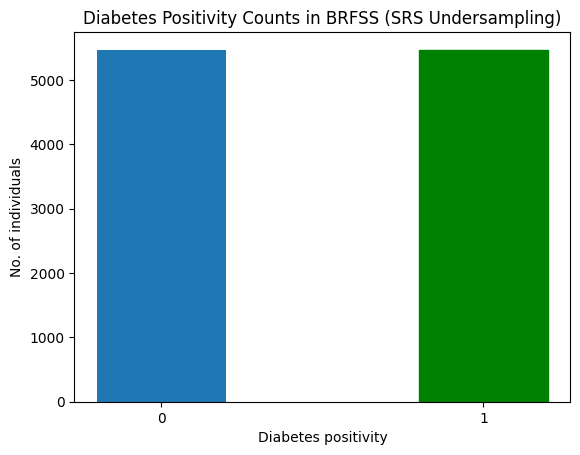

In [122]:
barlist = plt.bar([str(0),str(1)], y_S_SRS.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (SRS Undersampling)")
plt.show()

In [130]:
X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_SRS, y_S_SRS, test_size=0.20, random_state=0)
X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(data_T_X, data_T_y, test_size=0.20, random_state=0)
T_train = pd.concat([X_T_train, y_T_train], axis=1)

X_T_train_SRS, y_T_train_SRS = SRS_undersampler(T_train, T_train.iloc[:,-1])
print(y_T_train_SRS)


958
2777
497     0
2803    0
1564    0
3777    0
577     0
       ..
1871    1
1701    1
2897    1
2599    1
2607    1
Name: Y, Length: 1916, dtype: int64


In [131]:
print('X_S_train:',np.shape(X_S_train))
print('y_S_train:',np.shape(y_S_train))
print('X_S_test:',np.shape(X_S_test))
print('y_S_test:',np.shape(y_S_test))

X_S_train: (8755, 22)
y_S_train: (8755,)
X_S_test: (2189, 22)
y_S_test: (2189,)


In [132]:
model_source_SRS = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_129"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_903 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_904 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_905 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_906 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_907 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_908 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_909 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7


Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - AUC: 0.6820 - loss: 0.6167 - val_AUC: 0.8818 - val_loss: 0.3918
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8944 - loss: 0.3784 - val_AUC: 0.9193 - val_loss: 0.3201
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9069 - loss: 0.3458 - val_AUC: 0.9176 - val_loss: 0.3320
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9134 - loss: 0.3315 - val_AUC: 0.9228 - val_loss: 0.3147
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9142 - loss: 0.3260 - val_AUC: 0.9228 - val_loss: 0.3087
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9153 - loss: 0.3343 - val_AUC: 0.9171 - val_loss: 0.3124
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9207 - loss: 0.3203 - val_AUC: 0.9239 - val_loss: 0.3048
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9263 - loss: 0.3140 - val_AUC: 0.9154 - val_loss: 0.3334
Epoch 9/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - A

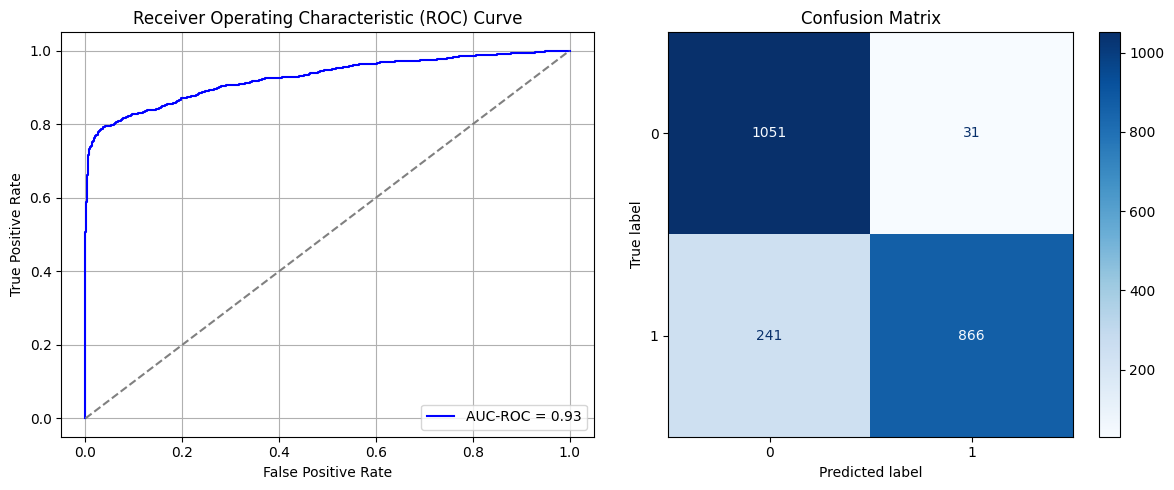

Best threshold based on F1-score: 0.4299412667751312
Time elapsed (performance): 17.425945541000146


<Sequential name=sequential_129, built=True>

In [133]:
train_and_evaluate(model_source_SRS, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
AUC-ROC: 0.6998423567970391
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.84       707
           1       0.48      0.46      0.47       227

    accuracy                           0.75       934
   macro avg       0.66      0.65      0.65       934
weighted avg       0.75      0.75      0.75       934

FPR 0.15841584158415842 TPR: 0.4625550660792952 FNR: 0.5374449339207048 TNR: 0.8415841584158416


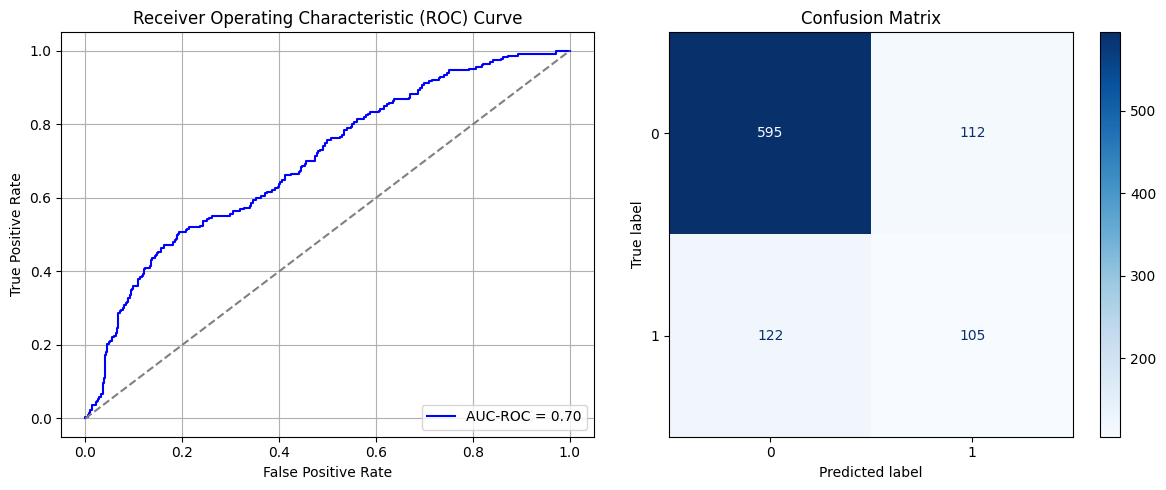

Best threshold based on F1-score: 0.40300968289375305
False Negative Rate: 0.5374449339207048
Time elapsed (performance): 0.6569316739996793


In [134]:
Transductive_TL(model_source_SRS, X_T_test, y_T_test, "Target")

In [135]:
fine_tuning(X_T_train, X_T_test, y_T_train, y_T_test, 0, 5)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_130"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_910 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_911 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_912 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_913 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_914 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_915 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_916 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - AUC: 0.7178 - loss: 0.7973 - val_AUC: 0.7110 - val_loss: 0.5699
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7137 - loss: 0.5591 - val_AUC: 0.7153 - val_loss: 0.5159
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7049 - loss: 0.5373 - val_AUC: 0.7250 - val_loss: 0.4939
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7169 - loss: 0.5157 - val_AUC: 0.7312 - val_loss: 0.4916
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7336 - loss: 0.4965 - val_AUC: 0.7328 - val_loss: 0.4901
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7271 - loss: 0.5074 - val_AUC: 0.7328 - val_loss: 0.4905
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7290 - loss: 0.5068 - val_AUC: 0.7328 - val_loss: 0.4898
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7356 - loss: 0.4890 - val_AUC: 0.7329 - val_loss: 0.4894
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7252 - loss: 0.5030 - v

(np.float64(0.05233380480905234), np.float64(0.7180616740088106))

In [139]:
times = 50

FPR = []
FNR = []

for i in range(times):
    fpr, fnr = fine_tuning(X_T_train_SRS, X_T_test, y_T_train_SRS, y_T_test, 0, 4)
    # print(output)
    FPR.append(fpr)
    FNR.append(fnr)

ParamFit = pd.DataFrame([FPR, FNR]).T
ParamFit.columns=['FPR', 'FNR']


# fine_tuning(X_T_train_SRS, X_T_test, y_T_train_SRS, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_133"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_931 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_932 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_933 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_934 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_935 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_936 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_937 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.7234 - loss: 0.7713 - val_AUC: 0.0000e+00 - val_loss: 1.0249
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7211 - loss: 0.6290 - val_AUC: 0.0000e+00 - val_loss: 0.8880
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7286 - loss: 0.5810 - val_AUC: 0.0000e+00 - val_loss: 0.8647
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7456 - loss: 0.5732 - val_AUC: 0.0000e+00 - val_loss: 0.9226
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7181 - loss: 0.5800 - val_AUC: 0.0000e+00 - val_loss: 0.8214
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7527 - loss: 0.5702 - val_AUC: 0.0000e+00 - val_loss: 0.8734
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7504 - loss: 0.5562 - val_AUC: 0.0000e+00 - val_loss: 0.9080
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7149 - l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_134"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_938 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_939 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_940 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_941 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_942 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_943 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_944 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 0.7133 - loss: 0.7650 - val_AUC: 0.0000e+00 - val_loss: 1.0309
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7331 - loss: 0.6100 - val_AUC: 0.0000e+00 - val_loss: 0.9199
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7227 - loss: 0.5907 - val_AUC: 0.0000e+00 - val_loss: 0.8694
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7487 - loss: 0.5550 - val_AUC: 0.0000e+00 - val_loss: 0.8696
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7479 - loss: 0.5629 - val_AUC: 0.0000e+00 - val_loss: 0.8738
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7458 - loss: 0.5799 - val_AUC: 0.0000e+00 - val_loss: 0.9111
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7194 - loss: 0.5730 - val_AUC: 0.0000e+00 - val_loss: 0.8423
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7438 - loss: 0.5757 - val_AUC: 0.0000e+00 - val_loss: 0.9048
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_135"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_945 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_946 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_947 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_948 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_949 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_950 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_951 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.7270 - loss: 0.7930 - val_AUC: 0.0000e+00 - val_loss: 1.0337
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7228 - loss: 0.6188 - val_AUC: 0.0000e+00 - val_loss: 0.9185
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7313 - loss: 0.5927 - val_AUC: 0.0000e+00 - val_loss: 0.9051
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7303 - loss: 0.5915 - val_AUC: 0.0000e+00 - val_loss: 0.9225
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7418 - loss: 0.5712 - val_AUC: 0.0000e+00 - val_loss: 0.8908
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7319 - loss: 0.5810 - val_AUC: 0.0000e+00 - val_loss: 0.9303
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7125 - loss: 0.5815 - val_AUC: 0.0000e+00 - val_loss: 0.8756
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7511 - loss: 0.5704 - val_AUC: 0.0000e+00 - val_loss: 0.8946
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_136"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_952 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_953 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_954 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_955 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_956 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_957 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_958 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.7368 - loss: 0.7301 - val_AUC: 0.0000e+00 - val_loss: 1.0550
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7166 - loss: 0.6242 - val_AUC: 0.0000e+00 - val_loss: 0.9098
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7447 - loss: 0.5687 - val_AUC: 0.0000e+00 - val_loss: 0.8902
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - AUC: 0.7385 - loss: 0.5683 - val_AUC: 0.0000e+00 - val_loss: 0.8500
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7148 - loss: 0.5877 - val_AUC: 0.0000e+00 - val_loss: 0.8806
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7104 - loss: 0.5971 - val_AUC: 0.0000e+00 - val_loss: 0.8936
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - AUC: 0.7330 - loss: 0.5888 - val_AUC: 0.0000e+00 - val_loss: 0.9016
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7470 - loss: 0.5685 - val_AUC: 0.0000e+00 - val_loss: 0.8327
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_137"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_959 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_960 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_961 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_962 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_963 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_964 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_965 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.7192 - loss: 0.7781 - val_AUC: 0.0000e+00 - val_loss: 1.0378
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7084 - loss: 0.6530 - val_AUC: 0.0000e+00 - val_loss: 0.8947
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7501 - loss: 0.5852 - val_AUC: 0.0000e+00 - val_loss: 0.8780
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7272 - loss: 0.5781 - val_AUC: 0.0000e+00 - val_loss: 0.8878
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7113 - loss: 0.5852 - val_AUC: 0.0000e+00 - val_loss: 0.8993
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7534 - loss: 0.5458 - val_AUC: 0.0000e+00 - val_loss: 0.8308
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7521 - loss: 0.5631 - val_AUC: 0.0000e+00 - val_loss: 0.8651
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7542 - loss: 0.5515 - val_AUC: 0.0000e+00 - val_loss: 0.8749
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_138"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_966 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_967 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_968 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_969 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_970 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_971 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_972 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - AUC: 0.7199 - loss: 0.7479 - val_AUC: 0.0000e+00 - val_loss: 1.0141
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7317 - loss: 0.6374 - val_AUC: 0.0000e+00 - val_loss: 0.9064
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7359 - loss: 0.5854 - val_AUC: 0.0000e+00 - val_loss: 0.8933
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7287 - loss: 0.5792 - val_AUC: 0.0000e+00 - val_loss: 0.8811
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7481 - loss: 0.5565 - val_AUC: 0.0000e+00 - val_loss: 0.9174
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7165 - loss: 0.5861 - val_AUC: 0.0000e+00 - val_loss: 0.8864
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7220 - loss: 0.5859 - val_AUC: 0.0000e+00 - val_loss: 0.9230
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7586 - loss: 0.5624 - val_AUC: 0.0000e+00 - val_loss: 0.8442
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_139"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_973 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_974 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_975 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_976 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_977 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_978 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_979 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - AUC: 0.7317 - loss: 0.7313 - val_AUC: 0.0000e+00 - val_loss: 1.0586
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7480 - loss: 0.5923 - val_AUC: 0.0000e+00 - val_loss: 0.9337
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7428 - loss: 0.5852 - val_AUC: 0.0000e+00 - val_loss: 0.8969
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7298 - loss: 0.5739 - val_AUC: 0.0000e+00 - val_loss: 0.8438
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7476 - loss: 0.5577 - val_AUC: 0.0000e+00 - val_loss: 0.8618
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7497 - loss: 0.5668 - val_AUC: 0.0000e+00 - val_loss: 0.9006
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7361 - loss: 0.5812 - val_AUC: 0.0000e+00 - val_loss: 0.8887
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7469 - loss: 0.5629 - val_AUC: 0.0000e+00 - val_loss: 0.8926
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_140"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_980 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_981 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_982 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_983 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_984 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_985 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_986 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 0.7257 - loss: 0.7296 - val_AUC: 0.0000e+00 - val_loss: 1.0489
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7448 - loss: 0.5894 - val_AUC: 0.0000e+00 - val_loss: 0.9141
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7399 - loss: 0.5732 - val_AUC: 0.0000e+00 - val_loss: 0.9183
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7239 - loss: 0.5825 - val_AUC: 0.0000e+00 - val_loss: 0.8227
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7502 - loss: 0.5654 - val_AUC: 0.0000e+00 - val_loss: 0.9468
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7466 - loss: 0.5639 - val_AUC: 0.0000e+00 - val_loss: 0.8859
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7321 - loss: 0.5873 - val_AUC: 0.0000e+00 - val_loss: 0.9441
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7278 - loss: 0.5775 - val_AUC: 0.0000e+00 - val_loss: 0.8945
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_141"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_987 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_988 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_989 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_990 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_991 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_992 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_993 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 0.7284 - loss: 0.7478 - val_AUC: 0.0000e+00 - val_loss: 1.0351
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7129 - loss: 0.6403 - val_AUC: 0.0000e+00 - val_loss: 0.9331
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7175 - loss: 0.6048 - val_AUC: 0.0000e+00 - val_loss: 0.8751
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7319 - loss: 0.5855 - val_AUC: 0.0000e+00 - val_loss: 0.8676
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7557 - loss: 0.5633 - val_AUC: 0.0000e+00 - val_loss: 0.8978
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7410 - loss: 0.5607 - val_AUC: 0.0000e+00 - val_loss: 0.8456
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7559 - loss: 0.5609 - val_AUC: 0.0000e+00 - val_loss: 0.9220
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7536 - loss: 0.5746 - val_AUC: 0.0000e+00 - val_loss: 0.9076
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_142"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_994 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_995 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_996 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_997 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_998 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_999 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1000 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - AUC: 0.7013 - loss: 0.8300 - val_AUC: 0.0000e+00 - val_loss: 0.9907
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7154 - loss: 0.6248 - val_AUC: 0.0000e+00 - val_loss: 0.9478
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7248 - loss: 0.5856 - val_AUC: 0.0000e+00 - val_loss: 0.9159
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7338 - loss: 0.5867 - val_AUC: 0.0000e+00 - val_loss: 0.8832
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7436 - loss: 0.5776 - val_AUC: 0.0000e+00 - val_loss: 0.9338
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7429 - loss: 0.5665 - val_AUC: 0.0000e+00 - val_loss: 0.8681
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7290 - loss: 0.5777 - val_AUC: 0.0000e+00 - val_loss: 0.9106
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7240 - loss: 0.5785 - val_AUC: 0.0000e+00 - val_loss: 0.8525
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_143"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1001 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1002 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1003 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1004 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1005 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1006 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1007 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 0.7355 - loss: 0.7386 - val_AUC: 0.0000e+00 - val_loss: 1.0307
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7206 - loss: 0.6113 - val_AUC: 0.0000e+00 - val_loss: 0.8824
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7423 - loss: 0.5910 - val_AUC: 0.0000e+00 - val_loss: 0.8840
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7164 - loss: 0.5925 - val_AUC: 0.0000e+00 - val_loss: 0.9091
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7243 - loss: 0.5830 - val_AUC: 0.0000e+00 - val_loss: 0.8851
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7389 - loss: 0.5729 - val_AUC: 0.0000e+00 - val_loss: 0.9059
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7504 - loss: 0.5661 - val_AUC: 0.0000e+00 - val_loss: 0.8873
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7518 - loss: 0.5682 - val_AUC: 0.0000e+00 - val_loss: 0.8976
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_144"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1008 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1009 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1010 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1011 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1012 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1013 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1014 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 0.7286 - loss: 0.7915 - val_AUC: 0.0000e+00 - val_loss: 1.0154
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7364 - loss: 0.6024 - val_AUC: 0.0000e+00 - val_loss: 0.9173
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7430 - loss: 0.5706 - val_AUC: 0.0000e+00 - val_loss: 0.9584
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7424 - loss: 0.5742 - val_AUC: 0.0000e+00 - val_loss: 0.8852
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7510 - loss: 0.5671 - val_AUC: 0.0000e+00 - val_loss: 0.9094
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7360 - loss: 0.5895 - val_AUC: 0.0000e+00 - val_loss: 0.9010
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7395 - loss: 0.5763 - val_AUC: 0.0000e+00 - val_loss: 0.8771
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7242 - loss: 0.5827 - val_AUC: 0.0000e+00 - val_loss: 0.9084
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_145"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1015 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1016 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1017 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1018 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1019 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1020 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1021 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - AUC: 0.7249 - loss: 0.7864 - val_AUC: 0.0000e+00 - val_loss: 1.0205
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7149 - loss: 0.6185 - val_AUC: 0.0000e+00 - val_loss: 0.8816
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7248 - loss: 0.5804 - val_AUC: 0.0000e+00 - val_loss: 0.8582
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7222 - loss: 0.5837 - val_AUC: 0.0000e+00 - val_loss: 0.8749
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7416 - loss: 0.5708 - val_AUC: 0.0000e+00 - val_loss: 0.8528
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7307 - loss: 0.5661 - val_AUC: 0.0000e+00 - val_loss: 0.8873
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7306 - loss: 0.5724 - val_AUC: 0.0000e+00 - val_loss: 0.8891
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7306 - loss: 0.5812 - val_AUC: 0.0000e+00 - val_loss: 0.9086
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_146"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1022 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1023 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1024 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1025 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1026 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1027 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1028 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.7297 - loss: 0.8033 - val_AUC: 0.0000e+00 - val_loss: 1.0358
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7488 - loss: 0.6147 - val_AUC: 0.0000e+00 - val_loss: 0.8885
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7004 - loss: 0.6222 - val_AUC: 0.0000e+00 - val_loss: 0.9079
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7259 - loss: 0.5722 - val_AUC: 0.0000e+00 - val_loss: 0.8976
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7306 - loss: 0.5754 - val_AUC: 0.0000e+00 - val_loss: 0.9183
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7572 - loss: 0.5556 - val_AUC: 0.0000e+00 - val_loss: 0.8928
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7420 - loss: 0.5747 - val_AUC: 0.0000e+00 - val_loss: 0.9346
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7330 - loss: 0.5831 - val_AUC: 0.0000e+00 - val_loss: 0.8878
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_147"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1029 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1030 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1031 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1032 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1033 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1034 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1035 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.7135 - loss: 0.7470 - val_AUC: 0.0000e+00 - val_loss: 1.0456
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7228 - loss: 0.6388 - val_AUC: 0.0000e+00 - val_loss: 0.9081
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7228 - loss: 0.5759 - val_AUC: 0.0000e+00 - val_loss: 0.8698
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7230 - loss: 0.5823 - val_AUC: 0.0000e+00 - val_loss: 0.8938
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7075 - loss: 0.6044 - val_AUC: 0.0000e+00 - val_loss: 0.8692
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7423 - loss: 0.5832 - val_AUC: 0.0000e+00 - val_loss: 0.9441
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7525 - loss: 0.5602 - val_AUC: 0.0000e+00 - val_loss: 0.9443
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7328 - loss: 0.5786 - val_AUC: 0.0000e+00 - val_loss: 0.8974
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_148"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1036 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1037 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1038 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1039 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1040 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1041 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1042 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 0.7243 - loss: 0.7641 - val_AUC: 0.0000e+00 - val_loss: 1.0524
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.7408 - loss: 0.6036 - val_AUC: 0.0000e+00 - val_loss: 0.8769
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7204 - loss: 0.5838 - val_AUC: 0.0000e+00 - val_loss: 0.8684
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7617 - loss: 0.5633 - val_AUC: 0.0000e+00 - val_loss: 0.9069
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7351 - loss: 0.5695 - val_AUC: 0.0000e+00 - val_loss: 0.8216
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7433 - loss: 0.5753 - val_AUC: 0.0000e+00 - val_loss: 0.8637
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7507 - loss: 0.5698 - val_AUC: 0.0000e+00 - val_loss: 0.8581
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7501 - loss: 0.5573 - val_AUC: 0.0000e+00 - val_loss: 0.9198
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_149"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1043 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1044 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1045 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1046 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1047 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1048 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1049 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.7336 - loss: 0.7437 - val_AUC: 0.0000e+00 - val_loss: 0.9982
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7203 - loss: 0.6333 - val_AUC: 0.0000e+00 - val_loss: 0.8840
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7469 - loss: 0.5721 - val_AUC: 0.0000e+00 - val_loss: 0.9404
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7524 - loss: 0.5670 - val_AUC: 0.0000e+00 - val_loss: 0.8935
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7333 - loss: 0.5787 - val_AUC: 0.0000e+00 - val_loss: 0.9230
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7555 - loss: 0.5695 - val_AUC: 0.0000e+00 - val_loss: 0.9190
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7606 - loss: 0.5567 - val_AUC: 0.0000e+00 - val_loss: 0.8879
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7397 - loss: 0.5725 - val_AUC: 0.0000e+00 - val_loss: 0.8900
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_150"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1050 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1051 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1052 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1053 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1054 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1055 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1056 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - AUC: 0.7330 - loss: 0.7476 - val_AUC: 0.0000e+00 - val_loss: 1.0667
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7123 - loss: 0.6441 - val_AUC: 0.0000e+00 - val_loss: 0.9257
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7188 - loss: 0.6118 - val_AUC: 0.0000e+00 - val_loss: 0.9443
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7243 - loss: 0.5895 - val_AUC: 0.0000e+00 - val_loss: 0.9064
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7225 - loss: 0.5793 - val_AUC: 0.0000e+00 - val_loss: 0.9088
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7236 - loss: 0.5836 - val_AUC: 0.0000e+00 - val_loss: 0.8885
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7547 - loss: 0.5718 - val_AUC: 0.0000e+00 - val_loss: 0.8799
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7377 - loss: 0.5739 - val_AUC: 0.0000e+00 - val_loss: 0.9401
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_151"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1057 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1058 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1059 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1060 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1061 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1062 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1063 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 0.7240 - loss: 0.7610 - val_AUC: 0.0000e+00 - val_loss: 1.0162
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7457 - loss: 0.5976 - val_AUC: 0.0000e+00 - val_loss: 0.9026
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7192 - loss: 0.6011 - val_AUC: 0.0000e+00 - val_loss: 0.8323
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7428 - loss: 0.5755 - val_AUC: 0.0000e+00 - val_loss: 0.8865
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7415 - loss: 0.5697 - val_AUC: 0.0000e+00 - val_loss: 0.8697
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7166 - loss: 0.5943 - val_AUC: 0.0000e+00 - val_loss: 0.9293
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7260 - loss: 0.5964 - val_AUC: 0.0000e+00 - val_loss: 0.8916
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7261 - loss: 0.5673 - val_AUC: 0.0000e+00 - val_loss: 0.8853
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_152"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1064 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1065 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1066 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1067 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1068 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1069 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1070 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.7387 - loss: 0.7689 - val_AUC: 0.0000e+00 - val_loss: 1.0341
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7250 - loss: 0.6081 - val_AUC: 0.0000e+00 - val_loss: 0.9126
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7246 - loss: 0.5936 - val_AUC: 0.0000e+00 - val_loss: 0.8762
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7558 - loss: 0.5732 - val_AUC: 0.0000e+00 - val_loss: 0.9136
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7392 - loss: 0.5804 - val_AUC: 0.0000e+00 - val_loss: 0.8591
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7287 - loss: 0.5884 - val_AUC: 0.0000e+00 - val_loss: 0.8716
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7450 - loss: 0.5826 - val_AUC: 0.0000e+00 - val_loss: 0.8914
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7625 - loss: 0.5539 - val_AUC: 0.0000e+00 - val_loss: 0.8777
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_153"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1071 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1072 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1073 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1074 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1075 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1076 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1077 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.7305 - loss: 0.7576 - val_AUC: 0.0000e+00 - val_loss: 1.0271
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7184 - loss: 0.6471 - val_AUC: 0.0000e+00 - val_loss: 0.8928
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7178 - loss: 0.5989 - val_AUC: 0.0000e+00 - val_loss: 0.9322
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7253 - loss: 0.5862 - val_AUC: 0.0000e+00 - val_loss: 0.8725
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7314 - loss: 0.5822 - val_AUC: 0.0000e+00 - val_loss: 0.9514
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7237 - loss: 0.5848 - val_AUC: 0.0000e+00 - val_loss: 0.8710
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7284 - loss: 0.5877 - val_AUC: 0.0000e+00 - val_loss: 0.9276
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7356 - loss: 0.5695 - val_AUC: 0.0000e+00 - val_loss: 0.8862
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_154"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1078 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1079 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1080 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1081 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1082 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1083 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1084 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 0.7184 - loss: 0.7695 - val_AUC: 0.0000e+00 - val_loss: 1.0585
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6848 - loss: 0.6429 - val_AUC: 0.0000e+00 - val_loss: 0.9144
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7109 - loss: 0.5932 - val_AUC: 0.0000e+00 - val_loss: 0.8768
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7424 - loss: 0.5640 - val_AUC: 0.0000e+00 - val_loss: 0.8784
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7296 - loss: 0.5854 - val_AUC: 0.0000e+00 - val_loss: 0.8814
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7250 - loss: 0.5751 - val_AUC: 0.0000e+00 - val_loss: 0.9029
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7212 - loss: 0.5822 - val_AUC: 0.0000e+00 - val_loss: 0.8602
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7326 - loss: 0.5826 - val_AUC: 0.0000e+00 - val_loss: 0.8732
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_155"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1085 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1086 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1087 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1088 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1089 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1090 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1091 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - AUC: 0.7260 - loss: 0.7569 - val_AUC: 0.0000e+00 - val_loss: 1.0607
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7084 - loss: 0.6493 - val_AUC: 0.0000e+00 - val_loss: 0.8442
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7378 - loss: 0.5898 - val_AUC: 0.0000e+00 - val_loss: 0.9325
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7300 - loss: 0.5924 - val_AUC: 0.0000e+00 - val_loss: 0.9162
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7352 - loss: 0.5599 - val_AUC: 0.0000e+00 - val_loss: 0.8425
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7303 - loss: 0.5831 - val_AUC: 0.0000e+00 - val_loss: 0.8871
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7391 - loss: 0.5738 - val_AUC: 0.0000e+00 - val_loss: 0.9052
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7589 - loss: 0.5649 - val_AUC: 0.0000e+00 - val_loss: 0.9271
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_156"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1092 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1093 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1094 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1095 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1096 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1097 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1098 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 0.7193 - loss: 0.8108 - val_AUC: 0.0000e+00 - val_loss: 1.0305
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7467 - loss: 0.5813 - val_AUC: 0.0000e+00 - val_loss: 0.8697
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7351 - loss: 0.5831 - val_AUC: 0.0000e+00 - val_loss: 0.9015
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7379 - loss: 0.5735 - val_AUC: 0.0000e+00 - val_loss: 0.8855
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7374 - loss: 0.5757 - val_AUC: 0.0000e+00 - val_loss: 0.8988
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7383 - loss: 0.5781 - val_AUC: 0.0000e+00 - val_loss: 0.8568
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7507 - loss: 0.5636 - val_AUC: 0.0000e+00 - val_loss: 0.9255
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7485 - loss: 0.5652 - val_AUC: 0.0000e+00 - val_loss: 0.9275
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_157"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1099 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1100 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1101 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1102 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1103 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1104 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1105 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - AUC: 0.7104 - loss: 0.8080 - val_AUC: 0.0000e+00 - val_loss: 1.0153
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7127 - loss: 0.6363 - val_AUC: 0.0000e+00 - val_loss: 0.9111
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7159 - loss: 0.5925 - val_AUC: 0.0000e+00 - val_loss: 0.8605
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7368 - loss: 0.5820 - val_AUC: 0.0000e+00 - val_loss: 0.9117
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7272 - loss: 0.5852 - val_AUC: 0.0000e+00 - val_loss: 0.9522
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7516 - loss: 0.5640 - val_AUC: 0.0000e+00 - val_loss: 0.8476
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7287 - loss: 0.5710 - val_AUC: 0.0000e+00 - val_loss: 0.8870
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7403 - loss: 0.5669 - val_AUC: 0.0000e+00 - val_loss: 0.9224
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_158"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1106 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1107 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1108 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1109 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1110 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1111 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1112 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.7410 - loss: 0.7657 - val_AUC: 0.0000e+00 - val_loss: 1.0025
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7150 - loss: 0.6301 - val_AUC: 0.0000e+00 - val_loss: 0.8820
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7307 - loss: 0.5858 - val_AUC: 0.0000e+00 - val_loss: 0.8443
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7491 - loss: 0.5673 - val_AUC: 0.0000e+00 - val_loss: 0.9444
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7290 - loss: 0.5894 - val_AUC: 0.0000e+00 - val_loss: 0.9167
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7250 - loss: 0.5804 - val_AUC: 0.0000e+00 - val_loss: 0.9076
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7418 - loss: 0.5812 - val_AUC: 0.0000e+00 - val_loss: 0.8459
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7238 - loss: 0.5735 - val_AUC: 0.0000e+00 - val_loss: 0.9227
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_159"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1113 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1114 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1115 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1116 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1117 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1118 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1119 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 0.7136 - loss: 0.7693 - val_AUC: 0.0000e+00 - val_loss: 1.0255
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7043 - loss: 0.6296 - val_AUC: 0.0000e+00 - val_loss: 0.9246
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7244 - loss: 0.5888 - val_AUC: 0.0000e+00 - val_loss: 0.8840
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7354 - loss: 0.5826 - val_AUC: 0.0000e+00 - val_loss: 0.9371
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7234 - loss: 0.5664 - val_AUC: 0.0000e+00 - val_loss: 0.8443
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7212 - loss: 0.5765 - val_AUC: 0.0000e+00 - val_loss: 0.9004
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7265 - loss: 0.5877 - val_AUC: 0.0000e+00 - val_loss: 0.8860
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7484 - loss: 0.5662 - val_AUC: 0.0000e+00 - val_loss: 0.8887
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_160"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1120 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1121 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1122 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1123 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1124 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1125 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1126 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - AUC: 0.7256 - loss: 0.8028 - val_AUC: 0.0000e+00 - val_loss: 1.0506
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7366 - loss: 0.6005 - val_AUC: 0.0000e+00 - val_loss: 0.8607
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7207 - loss: 0.5991 - val_AUC: 0.0000e+00 - val_loss: 0.9169
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7497 - loss: 0.5498 - val_AUC: 0.0000e+00 - val_loss: 0.9084
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7316 - loss: 0.5766 - val_AUC: 0.0000e+00 - val_loss: 0.9028
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7647 - loss: 0.5626 - val_AUC: 0.0000e+00 - val_loss: 0.8980
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7481 - loss: 0.5652 - val_AUC: 0.0000e+00 - val_loss: 0.9591
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7380 - loss: 0.5741 - val_AUC: 0.0000e+00 - val_loss: 0.8751
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_161"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1127 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1128 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1129 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1130 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1131 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1132 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1133 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - AUC: 0.7044 - loss: 0.8000 - val_AUC: 0.0000e+00 - val_loss: 1.0490
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7295 - loss: 0.6162 - val_AUC: 0.0000e+00 - val_loss: 0.9417
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7296 - loss: 0.5913 - val_AUC: 0.0000e+00 - val_loss: 0.8520
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7237 - loss: 0.5872 - val_AUC: 0.0000e+00 - val_loss: 0.8983
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7306 - loss: 0.5597 - val_AUC: 0.0000e+00 - val_loss: 0.8574
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7282 - loss: 0.5905 - val_AUC: 0.0000e+00 - val_loss: 0.8978
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7130 - loss: 0.5963 - val_AUC: 0.0000e+00 - val_loss: 0.9081
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7063 - loss: 0.5978 - val_AUC: 0.0000e+00 - val_loss: 0.9084
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_162"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1134 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1135 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1136 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1137 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1138 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1139 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1140 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 0.7190 - loss: 0.8041 - val_AUC: 0.0000e+00 - val_loss: 1.0252
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.7324 - loss: 0.6164 - val_AUC: 0.0000e+00 - val_loss: 0.8856
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7171 - loss: 0.6013 - val_AUC: 0.0000e+00 - val_loss: 0.9190
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7000 - loss: 0.5980 - val_AUC: 0.0000e+00 - val_loss: 0.8386
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7319 - loss: 0.5796 - val_AUC: 0.0000e+00 - val_loss: 0.8898
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7291 - loss: 0.5827 - val_AUC: 0.0000e+00 - val_loss: 0.9267
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7342 - loss: 0.5807 - val_AUC: 0.0000e+00 - val_loss: 0.9057
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7312 - loss: 0.5786 - val_AUC: 0.0000e+00 - val_loss: 0.8822
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_163"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1141 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1142 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1143 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1144 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1145 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1146 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1147 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 0.7317 - loss: 0.7551 - val_AUC: 0.0000e+00 - val_loss: 1.0521
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7124 - loss: 0.6514 - val_AUC: 0.0000e+00 - val_loss: 0.8960
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7067 - loss: 0.5934 - val_AUC: 0.0000e+00 - val_loss: 0.8587
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7221 - loss: 0.5784 - val_AUC: 0.0000e+00 - val_loss: 0.9106
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7278 - loss: 0.5735 - val_AUC: 0.0000e+00 - val_loss: 0.8628
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7480 - loss: 0.5773 - val_AUC: 0.0000e+00 - val_loss: 0.8720
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7518 - loss: 0.5499 - val_AUC: 0.0000e+00 - val_loss: 0.8660
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7434 - loss: 0.5758 - val_AUC: 0.0000e+00 - val_loss: 0.9854
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_164"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1148 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1149 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1150 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1151 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1152 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1153 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1154 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 0.7271 - loss: 0.7456 - val_AUC: 0.0000e+00 - val_loss: 1.0419
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6980 - loss: 0.6300 - val_AUC: 0.0000e+00 - val_loss: 0.9054
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7255 - loss: 0.5860 - val_AUC: 0.0000e+00 - val_loss: 0.9227
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7376 - loss: 0.5790 - val_AUC: 0.0000e+00 - val_loss: 0.9226
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7273 - loss: 0.5794 - val_AUC: 0.0000e+00 - val_loss: 0.8690
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7405 - loss: 0.5679 - val_AUC: 0.0000e+00 - val_loss: 0.9167
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7289 - loss: 0.5799 - val_AUC: 0.0000e+00 - val_loss: 0.9044
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7380 - loss: 0.5686 - val_AUC: 0.0000e+00 - val_loss: 0.8730
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_165"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1155 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1156 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1157 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1158 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1159 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1160 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1161 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - AUC: 0.7206 - loss: 0.7930 - val_AUC: 0.0000e+00 - val_loss: 1.0491
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7258 - loss: 0.6283 - val_AUC: 0.0000e+00 - val_loss: 0.8661
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7357 - loss: 0.5724 - val_AUC: 0.0000e+00 - val_loss: 0.9324
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7110 - loss: 0.6022 - val_AUC: 0.0000e+00 - val_loss: 0.9374
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7361 - loss: 0.5878 - val_AUC: 0.0000e+00 - val_loss: 0.9040
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7460 - loss: 0.5579 - val_AUC: 0.0000e+00 - val_loss: 0.8666
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7286 - loss: 0.5867 - val_AUC: 0.0000e+00 - val_loss: 0.8849
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7448 - loss: 0.5722 - val_AUC: 0.0000e+00 - val_loss: 0.9099
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_166"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1162 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1163 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1164 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1165 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1166 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1167 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1168 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.7072 - loss: 0.7809 - val_AUC: 0.0000e+00 - val_loss: 1.0222
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7283 - loss: 0.6070 - val_AUC: 0.0000e+00 - val_loss: 0.9542
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7379 - loss: 0.5836 - val_AUC: 0.0000e+00 - val_loss: 0.9032
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7149 - loss: 0.5959 - val_AUC: 0.0000e+00 - val_loss: 0.9327
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7332 - loss: 0.5729 - val_AUC: 0.0000e+00 - val_loss: 0.9486
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7162 - loss: 0.5924 - val_AUC: 0.0000e+00 - val_loss: 0.8971
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7358 - loss: 0.5861 - val_AUC: 0.0000e+00 - val_loss: 0.9315
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7154 - loss: 0.5823 - val_AUC: 0.0000e+00 - val_loss: 0.8806
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_167"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1169 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1170 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1171 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1172 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1173 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1174 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1175 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 0.7042 - loss: 0.7996 - val_AUC: 0.0000e+00 - val_loss: 1.0042
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7245 - loss: 0.6357 - val_AUC: 0.0000e+00 - val_loss: 0.8749
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7081 - loss: 0.6089 - val_AUC: 0.0000e+00 - val_loss: 0.9078
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7156 - loss: 0.5773 - val_AUC: 0.0000e+00 - val_loss: 0.8639
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7487 - loss: 0.5656 - val_AUC: 0.0000e+00 - val_loss: 0.9223
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7164 - loss: 0.5807 - val_AUC: 0.0000e+00 - val_loss: 0.8816
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7294 - loss: 0.5753 - val_AUC: 0.0000e+00 - val_loss: 0.8389
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7419 - loss: 0.5798 - val_AUC: 0.0000e+00 - val_loss: 0.9823
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_168"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1176 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1177 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1178 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1179 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1180 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1181 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1182 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - AUC: 0.7102 - loss: 0.8081 - val_AUC: 0.0000e+00 - val_loss: 1.0054
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7309 - loss: 0.6146 - val_AUC: 0.0000e+00 - val_loss: 0.8805
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7348 - loss: 0.5929 - val_AUC: 0.0000e+00 - val_loss: 0.9308
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7299 - loss: 0.5828 - val_AUC: 0.0000e+00 - val_loss: 0.8894
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7405 - loss: 0.5841 - val_AUC: 0.0000e+00 - val_loss: 0.8343
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7472 - loss: 0.5692 - val_AUC: 0.0000e+00 - val_loss: 0.8724
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7328 - loss: 0.5829 - val_AUC: 0.0000e+00 - val_loss: 0.8497
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7429 - loss: 0.5712 - val_AUC: 0.0000e+00 - val_loss: 0.8574
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_169"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1183 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1184 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1185 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1186 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1187 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1188 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1189 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 0.7150 - loss: 0.8231 - val_AUC: 0.0000e+00 - val_loss: 1.0000
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7275 - loss: 0.6268 - val_AUC: 0.0000e+00 - val_loss: 0.8870
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7592 - loss: 0.5580 - val_AUC: 0.0000e+00 - val_loss: 0.9128
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7127 - loss: 0.6007 - val_AUC: 0.0000e+00 - val_loss: 0.8829
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7520 - loss: 0.5570 - val_AUC: 0.0000e+00 - val_loss: 0.8724
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7555 - loss: 0.5716 - val_AUC: 0.0000e+00 - val_loss: 0.9098
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.7589 - loss: 0.5465 - val_AUC: 0.0000e+00 - val_loss: 0.8640
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7456 - loss: 0.5712 - val_AUC: 0.0000e+00 - val_loss: 0.8737
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_170"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1190 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1191 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1192 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1193 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1194 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1195 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1196 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 0.7150 - loss: 0.8149 - val_AUC: 0.0000e+00 - val_loss: 1.0363
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7430 - loss: 0.6068 - val_AUC: 0.0000e+00 - val_loss: 0.9140
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7352 - loss: 0.5869 - val_AUC: 0.0000e+00 - val_loss: 0.8898
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7476 - loss: 0.5653 - val_AUC: 0.0000e+00 - val_loss: 0.8333
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7396 - loss: 0.5779 - val_AUC: 0.0000e+00 - val_loss: 0.8634
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7240 - loss: 0.5908 - val_AUC: 0.0000e+00 - val_loss: 0.9296
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7338 - loss: 0.5683 - val_AUC: 0.0000e+00 - val_loss: 0.8512
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7149 - loss: 0.5908 - val_AUC: 0.0000e+00 - val_loss: 0.8485
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_171"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1197 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1198 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1199 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1200 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1201 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1202 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1203 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - AUC: 0.7280 - loss: 0.7386 - val_AUC: 0.0000e+00 - val_loss: 1.0454
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7055 - loss: 0.6230 - val_AUC: 0.0000e+00 - val_loss: 0.9072
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7200 - loss: 0.5962 - val_AUC: 0.0000e+00 - val_loss: 0.8622
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7387 - loss: 0.5832 - val_AUC: 0.0000e+00 - val_loss: 0.8740
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7242 - loss: 0.5892 - val_AUC: 0.0000e+00 - val_loss: 0.9033
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7663 - loss: 0.5499 - val_AUC: 0.0000e+00 - val_loss: 0.9143
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7146 - loss: 0.5801 - val_AUC: 0.0000e+00 - val_loss: 0.8900
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7394 - loss: 0.5728 - val_AUC: 0.0000e+00 - val_loss: 0.8760
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_172"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1204 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1205 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1206 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1207 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1208 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1209 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1210 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 0.7147 - loss: 0.7825 - val_AUC: 0.0000e+00 - val_loss: 1.0419
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7270 - loss: 0.6158 - val_AUC: 0.0000e+00 - val_loss: 0.8716
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7387 - loss: 0.5674 - val_AUC: 0.0000e+00 - val_loss: 0.8736
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7309 - loss: 0.5826 - val_AUC: 0.0000e+00 - val_loss: 0.8815
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7448 - loss: 0.5670 - val_AUC: 0.0000e+00 - val_loss: 0.8428
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7392 - loss: 0.5683 - val_AUC: 0.0000e+00 - val_loss: 0.9036
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7609 - loss: 0.5574 - val_AUC: 0.0000e+00 - val_loss: 0.9097
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7349 - loss: 0.5717 - val_AUC: 0.0000e+00 - val_loss: 0.8682
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_173"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1211 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1212 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1213 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1214 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1215 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1216 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1217 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.7202 - loss: 0.7913 - val_AUC: 0.0000e+00 - val_loss: 1.0188
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7277 - loss: 0.6231 - val_AUC: 0.0000e+00 - val_loss: 0.8931
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7116 - loss: 0.6053 - val_AUC: 0.0000e+00 - val_loss: 0.9092
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7367 - loss: 0.5768 - val_AUC: 0.0000e+00 - val_loss: 0.8944
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7118 - loss: 0.5955 - val_AUC: 0.0000e+00 - val_loss: 0.8882
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7338 - loss: 0.5898 - val_AUC: 0.0000e+00 - val_loss: 0.8743
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7604 - loss: 0.5701 - val_AUC: 0.0000e+00 - val_loss: 0.9152
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7549 - loss: 0.5515 - val_AUC: 0.0000e+00 - val_loss: 0.9020
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_174"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1218 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1219 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1220 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1221 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1222 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1223 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1224 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.7558 - loss: 0.7155 - val_AUC: 0.0000e+00 - val_loss: 1.0466
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7078 - loss: 0.6328 - val_AUC: 0.0000e+00 - val_loss: 0.8985
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7265 - loss: 0.5851 - val_AUC: 0.0000e+00 - val_loss: 0.9216
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7341 - loss: 0.5866 - val_AUC: 0.0000e+00 - val_loss: 0.8663
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7292 - loss: 0.5757 - val_AUC: 0.0000e+00 - val_loss: 0.9296
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7122 - loss: 0.5860 - val_AUC: 0.0000e+00 - val_loss: 0.8293
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7467 - loss: 0.5640 - val_AUC: 0.0000e+00 - val_loss: 0.8885
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7174 - loss: 0.5962 - val_AUC: 0.0000e+00 - val_loss: 0.8569
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_175"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1225 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1226 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1227 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1228 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1229 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1230 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1231 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 0.6936 - loss: 0.8140 - val_AUC: 0.0000e+00 - val_loss: 1.0056
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7129 - loss: 0.6054 - val_AUC: 0.0000e+00 - val_loss: 0.9037
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7289 - loss: 0.5855 - val_AUC: 0.0000e+00 - val_loss: 0.8782
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7303 - loss: 0.5878 - val_AUC: 0.0000e+00 - val_loss: 0.9004
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7279 - loss: 0.5818 - val_AUC: 0.0000e+00 - val_loss: 0.8873
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7556 - loss: 0.5655 - val_AUC: 0.0000e+00 - val_loss: 0.9178
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7410 - loss: 0.5867 - val_AUC: 0.0000e+00 - val_loss: 0.9286
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7267 - loss: 0.5845 - val_AUC: 0.0000e+00 - val_loss: 0.9624
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_176"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1232 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1233 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1234 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1235 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1236 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1237 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1238 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 0.7126 - loss: 0.7942 - val_AUC: 0.0000e+00 - val_loss: 1.0117
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7440 - loss: 0.6051 - val_AUC: 0.0000e+00 - val_loss: 0.9059
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7484 - loss: 0.5866 - val_AUC: 0.0000e+00 - val_loss: 0.9259
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7126 - loss: 0.5750 - val_AUC: 0.0000e+00 - val_loss: 0.8659
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7185 - loss: 0.5824 - val_AUC: 0.0000e+00 - val_loss: 0.9079
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7452 - loss: 0.5770 - val_AUC: 0.0000e+00 - val_loss: 0.8973
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7491 - loss: 0.5687 - val_AUC: 0.0000e+00 - val_loss: 0.9060
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7545 - loss: 0.5611 - val_AUC: 0.0000e+00 - val_loss: 0.9206
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_177"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1239 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1240 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1241 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1242 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1243 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1244 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1245 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 0.7153 - loss: 0.8089 - val_AUC: 0.0000e+00 - val_loss: 0.9934
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7303 - loss: 0.6171 - val_AUC: 0.0000e+00 - val_loss: 0.9116
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7204 - loss: 0.6131 - val_AUC: 0.0000e+00 - val_loss: 0.9411
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7409 - loss: 0.5725 - val_AUC: 0.0000e+00 - val_loss: 0.8615
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7509 - loss: 0.5692 - val_AUC: 0.0000e+00 - val_loss: 0.9098
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7217 - loss: 0.5867 - val_AUC: 0.0000e+00 - val_loss: 0.9073
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7391 - loss: 0.5763 - val_AUC: 0.0000e+00 - val_loss: 0.9446
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7389 - loss: 0.5833 - val_AUC: 0.0000e+00 - val_loss: 0.9091
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_178"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1246 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1247 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1248 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1249 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1250 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1251 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1252 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - AUC: 0.6995 - loss: 0.8102 - val_AUC: 0.0000e+00 - val_loss: 1.0337
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7257 - loss: 0.6253 - val_AUC: 0.0000e+00 - val_loss: 0.9192
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7302 - loss: 0.5785 - val_AUC: 0.0000e+00 - val_loss: 0.8817
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7745 - loss: 0.5476 - val_AUC: 0.0000e+00 - val_loss: 0.8941
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7205 - loss: 0.5894 - val_AUC: 0.0000e+00 - val_loss: 0.8955
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7356 - loss: 0.5737 - val_AUC: 0.0000e+00 - val_loss: 0.8440
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7415 - loss: 0.5690 - val_AUC: 0.0000e+00 - val_loss: 0.8410
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7306 - loss: 0.5797 - val_AUC: 0.0000e+00 - val_loss: 0.8489
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_179"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1253 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1254 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1255 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1256 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1257 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1258 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1259 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 0.7114 - loss: 0.8000 - val_AUC: 0.0000e+00 - val_loss: 0.9954
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7151 - loss: 0.6098 - val_AUC: 0.0000e+00 - val_loss: 0.8832
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7366 - loss: 0.5700 - val_AUC: 0.0000e+00 - val_loss: 0.9053
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7642 - loss: 0.5703 - val_AUC: 0.0000e+00 - val_loss: 0.9139
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7303 - loss: 0.5807 - val_AUC: 0.0000e+00 - val_loss: 0.8884
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7439 - loss: 0.5652 - val_AUC: 0.0000e+00 - val_loss: 0.8396
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7597 - loss: 0.5497 - val_AUC: 0.0000e+00 - val_loss: 0.9225
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7255 - loss: 0.5846 - val_AUC: 0.0000e+00 - val_loss: 0.8598
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_180"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1260 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1261 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1262 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1263 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1264 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1265 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1266 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 0.7469 - loss: 0.7478 - val_AUC: 0.0000e+00 - val_loss: 1.0651
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7251 - loss: 0.6125 - val_AUC: 0.0000e+00 - val_loss: 0.8795
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7443 - loss: 0.5786 - val_AUC: 0.0000e+00 - val_loss: 0.9472
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7158 - loss: 0.5954 - val_AUC: 0.0000e+00 - val_loss: 0.8712
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7342 - loss: 0.5913 - val_AUC: 0.0000e+00 - val_loss: 0.9156
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7245 - loss: 0.6010 - val_AUC: 0.0000e+00 - val_loss: 0.9061
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7297 - loss: 0.5947 - val_AUC: 0.0000e+00 - val_loss: 0.9018
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7476 - loss: 0.5647 - val_AUC: 0.0000e+00 - val_loss: 0.8863
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_181"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1267 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1268 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1269 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1270 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1271 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1272 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1273 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - AUC: 0.7316 - loss: 0.7541 - val_AUC: 0.0000e+00 - val_loss: 1.0442
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7170 - loss: 0.6201 - val_AUC: 0.0000e+00 - val_loss: 0.9024
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7438 - loss: 0.5735 - val_AUC: 0.0000e+00 - val_loss: 0.8856
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7364 - loss: 0.5780 - val_AUC: 0.0000e+00 - val_loss: 0.9399
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7329 - loss: 0.5783 - val_AUC: 0.0000e+00 - val_loss: 0.8477
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7306 - loss: 0.5848 - val_AUC: 0.0000e+00 - val_loss: 0.8651
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7437 - loss: 0.5658 - val_AUC: 0.0000e+00 - val_loss: 0.9040
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7228 - loss: 0.5882 - val_AUC: 0.0000e+00 - val_loss: 0.8907
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_182"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1274 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1275 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1276 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1277 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1278 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1279 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1280 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 0.7104 - loss: 0.7696 - val_AUC: 0.0000e+00 - val_loss: 1.0433
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7117 - loss: 0.6232 - val_AUC: 0.0000e+00 - val_loss: 0.9331
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7244 - loss: 0.5822 - val_AUC: 0.0000e+00 - val_loss: 0.8681
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7288 - loss: 0.5773 - val_AUC: 0.0000e+00 - val_loss: 0.9515
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7442 - loss: 0.5641 - val_AUC: 0.0000e+00 - val_loss: 0.8727
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7514 - loss: 0.5847 - val_AUC: 0.0000e+00 - val_loss: 0.9269
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7403 - loss: 0.5782 - val_AUC: 0.0000e+00 - val_loss: 0.9421
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7546 - loss: 0.5731 - val_AUC: 0.0000e+00 - val_loss: 0.9529
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

In [140]:
print(ParamFit)
ParamFit.to_csv('SRS_Fine_Tuning.csv')

         FPR       FNR
0   0.117397  0.581498
1   0.124470  0.581498
2   0.121641  0.581498
3   0.128713  0.572687
4   0.117397  0.581498
5   0.123055  0.581498
6   0.124470  0.581498
7   0.125884  0.577093
8   0.124470  0.577093
9   0.124470  0.572687
10  0.125884  0.577093
11  0.124470  0.581498
12  0.120226  0.581498
13  0.124470  0.577093
14  0.125884  0.581498
15  0.127298  0.577093
16  0.124470  0.577093
17  0.121641  0.581498
18  0.118812  0.581498
19  0.124470  0.585903
20  0.125884  0.577093
21  0.124470  0.581498
22  0.124470  0.577093
23  0.125884  0.577093
24  0.120226  0.581498
25  0.125884  0.581498
26  0.124470  0.577093
27  0.128713  0.572687
28  0.120226  0.581498
29  0.124470  0.581498
30  0.124470  0.577093
31  0.115983  0.585903
32  0.128713  0.572687
33  0.123055  0.585903
34  0.128713  0.572687
35  0.125884  0.577093
36  0.125884  0.577093
37  0.125884  0.577093
38  0.120226  0.581498
39  0.124470  0.577093
40  0.124470  0.581498
41  0.125884  0.577093
42  0.12447

## Simple Random Sampling with Replacement:

In [30]:
data_S_full

0    1         2         3         4    5    6    7    8    9  \
0      0.010101  1.0  0.333333  0.333333  0.051724  0.4  0.1  0.1  0.0  0.0   
1      0.111111  1.0  0.333333  0.666667  0.086207  0.4  0.2  0.2  0.2  0.4   
2      0.080808  1.0  0.333333  0.666667  0.224138  0.2  0.2  0.2  0.2  0.2   
3      0.040404  1.0  0.333333  0.333333  0.275862  0.2  0.2  0.2  0.2  0.2   
4      0.040404  0.0  0.333333  0.333333  0.620690  0.2  0.1  0.2  0.2  0.2   
...         ...  ...       ...       ...       ...  ...  ...  ...  ...  ...   
22266  0.202020  0.0  0.333333  0.333333  0.224138  0.4  0.4  0.4  0.4  0.4   
22267  0.090909  0.0  0.000000  0.666667  0.293103  0.1  0.1  0.2  0.2  0.2   
22268  0.070707  0.0  0.333333  0.666667  0.224138  0.4  0.4  0.4  0.4  0.4   
22269  0.020202  0.0  0.333333  0.666667  0.275862  0.5  0.4  0.1  0.2  0.2   
22270  0.040404  0.0  0.333333  0.333333  0.431034  0.2  0.2  0.2  0.2  0.2   

       ...        13        14        15        16        17        18  \
0      ...  0.160138  0.080648  0.260979  0.000000  0.000561  0.000000   
1      ...  0.163220  0.084074  0.263485  0.000000  0.000815  0.001116   
2      ...  0.173637  0.095470  0.272928  0.001738  0.001222  0.001116   
3      ...  0.186809  0.109363  0.283685  0.002290  0.001645  0.001339   
4      ...  0.179863  0.099633  0.275681  0.002290  0.029893  0.011160   
...    ...       ...       ...       ...       ...       ...       ...   
22266  ...  0.162493  0.083127  0.262900  0.000000  0.000000  0.000000   
22267  ...  0.226667  0.149535  0.303248  0.002290  0.091097  0.004464   
22268  ...  0.233160  0.162558  0.323347  0.008013  0.002852  0.000000   
22269  ...  0.179805  0.101057  0.275854  0.000000  0.000000  0.024552   
22270  ...  0.194553  0.112803  0.272746  0.002379  0.001467  0.001596   

             19        20        21  Y2  
0      0.000000  0.000000  0.000000   1  
1      0.001610  0.000000  0.003783   0  
2      0.001610  0.002345  0.009458   0  
3      0.001771  0.002506  0.001892   0  
4      0.014493  0.001615  0.001284   0  
...         ...       ...       ...  ..  
22266  0.000000  0.000000  0.000000   1  
22267  0.004831  0.004689  0.003783   0  
22268  0.011272  0.000000  0.007566   1  
22269  0.006763  0.004689  0.005864   1  
22270  0.001610  0.002345  0.001892   0  

[22271 rows x 23 columns]

In [31]:
data_T_full

0    1         2         3         4    5    6    7    8    9  \
0     0.131313  1.0  0.666667  0.333333  0.120690  0.2  0.4  0.2  0.2  0.2   
1     0.191919  1.0  0.666667  0.666667  0.224138  0.2  0.4  0.2  0.2  0.1   
2     0.040404  1.0  0.666667  1.000000  0.034483  0.4  0.2  0.2  0.2  0.2   
3     0.121212  1.0  0.666667  0.666667  0.310345  0.2  0.2  0.2  0.2  0.1   
4     0.040404  0.0  0.666667  0.666667  0.034483  0.2  0.2  0.2  0.2  0.2   
...        ...  ...       ...       ...       ...  ...  ...  ...  ...  ...   
4664  0.040404  0.0  0.666667  0.666667  0.362069  0.2  0.2  0.2  0.2  0.2   
4665  0.000000  0.0  0.666667  0.333333  0.379310  0.2  0.2  0.0  0.0  0.0   
4666  0.212121  0.0  0.666667  0.333333  0.310345  0.2  0.2  0.2  0.2  0.2   
4667  0.141414  0.0  0.666667  0.666667  0.379310  0.1  0.1  0.1  0.2  0.2   
4668  0.070707  0.0  0.666667  0.333333  0.344828  0.1  0.2  0.2  0.2  0.1   

      ...        13        14        15        16        17        18  \
0     ...  0.171640  0.092342  0.263837  0.003811  0.000000  0.000482   
1     ...  0.162505  0.082461  0.263846  0.002640  0.000010  0.000056   
2     ...  0.187240  0.109930  0.284195  0.000000  0.001222  0.001228   
3     ...  0.179558  0.092351  0.261693  0.003434  0.001253  0.001116   
4     ...  0.187424  0.110226  0.284069  0.002259  0.001162  0.001117   
...   ...       ...       ...       ...       ...       ...       ...   
4664  ...  0.207576  0.100451  0.276113  0.011448  0.003260  0.005580   
4665  ...  0.160138  0.080648  0.260979  0.002290  0.000000  0.000000   
4666  ...  0.243036  0.111622  0.273259  0.009730  0.016299  0.005583   
4667  ...  0.168596  0.085794  0.260979  0.002103  0.002873  0.010042   
4668  ...  0.209850  0.092403  0.298591  0.098334  0.002778  0.001315   

            19        20        21  Y  
0     0.001610  0.002345  0.001892  0  
1     0.000483  0.008764  0.000125  0  
2     0.001932  0.003048  0.002081  0  
3     0.003221  0.002180  0.063866  0  
4     0.002306  0.002490  0.001886  0  
...        ...       ...       ... ..  
4664  0.004831  0.010550  0.003783  0  
4665  0.000000  0.000000  0.000000  0  
4666  0.004907  0.011723  0.001892  0  
4667  0.000208  0.000000  0.000000  0  
4668  0.003101  0.124174  0.003412  1  

[4669 rows x 23 columns]

In [32]:
X_S_SRSwR, y_S_SRSwR = SRSwR_undersampler(data_S_full, data_S_full.iloc[:,-1])
print(X_S_SRSwR)

5472
16799
             0    1         2         3         4    5    6    7    8    9   \
20873  0.070707  1.0  0.333333  0.333333  0.103448  0.1  0.1  0.1  0.1  0.1   
20394  0.191919  0.0  0.000000  0.666667  0.189655  0.2  0.2  0.2  0.2  0.2   
10362  0.090909  0.0  0.333333  0.333333  0.120690  0.1  0.0  0.0  0.0  0.0   
17878  0.141414  1.0  0.333333  0.333333  0.517241  0.2  0.2  0.2  0.2  0.2   
134    0.494949  1.0  0.000000  0.333333  0.448276  0.2  0.2  0.2  0.2  0.2   
...         ...  ...       ...       ...       ...  ...  ...  ...  ...  ...   
22255  0.030303  0.0  0.333333  0.666667  0.448276  0.4  0.5  0.4  0.4  0.4   
22258  0.040404  0.0  0.333333  0.333333  0.396552  0.4  0.4  0.4  0.2  0.2   
22266  0.202020  0.0  0.333333  0.333333  0.224138  0.4  0.4  0.4  0.4  0.4   
22268  0.070707  0.0  0.333333  0.666667  0.224138  0.4  0.4  0.4  0.4  0.4   
22269  0.020202  0.0  0.333333  0.666667  0.275862  0.5  0.4  0.1  0.2  0.2   

       ...        12        13        14

In [33]:
X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_SRSwR, y_S_SRSwR, test_size=0.20, random_state=0)
X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(data_T_X, data_T_y, test_size=0.20, random_state=0)
T_train = pd.concat([X_T_train, y_T_train], axis=1)

X_T_train_SRSwR, y_T_train_SRSwR = SRSwR_undersampler(T_train, T_train.iloc[:,-1])
print(y_T_train_SRSwR)

958
2777
4311    0
3620    0
863     0
2517    0
4155    0
       ..
1871    1
1701    1
2897    1
2599    1
2607    1
Name: Y, Length: 1916, dtype: int64


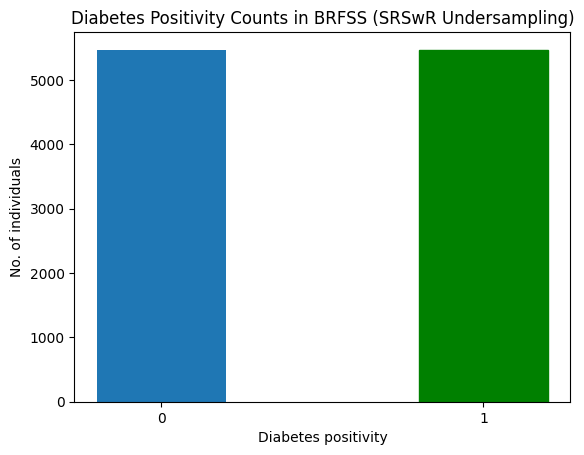

In [34]:
barlist = plt.bar([str(0),str(1)], y_S_SRSwR.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (SRSwR Undersampling)")
plt.show()

In [35]:
print('X_S_train:',np.shape(X_S_train))
print('y_S_train:',np.shape(y_S_train))
print('X_S_test:',np.shape(X_S_test))
print('y_S_test:',np.shape(y_S_test))

X_S_train: (8755, 22)
y_S_train: (8755,)
X_S_test: (2189, 22)
y_S_test: (2189,)


In [36]:
model_source_SRSwR = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7


Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - AUC: 0.7301 - loss: 0.5969 - val_AUC: 0.9034 - val_loss: 0.3495
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8993 - loss: 0.3451 - val_AUC: 0.8893 - val_loss: 0.4071
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9165 - loss: 0.3235 - val_AUC: 0.9179 - val_loss: 0.3077
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9138 - loss: 0.3238 - val_AUC: 0.9188 - val_loss: 0.3074
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9235 - loss: 0.3097 - val_AUC: 0.9183 - val_loss: 0.3162
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9178 - loss: 0.3226 - val_AUC: 0.9087 - val_loss: 0.3243
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9187 - loss: 0.3196 - val_AUC: 0.8986 - val_loss: 0.3290
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9267 - loss: 0.3077 - val_AUC: 0.9203 - val_loss: 0.3063
Epoch 9/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - A

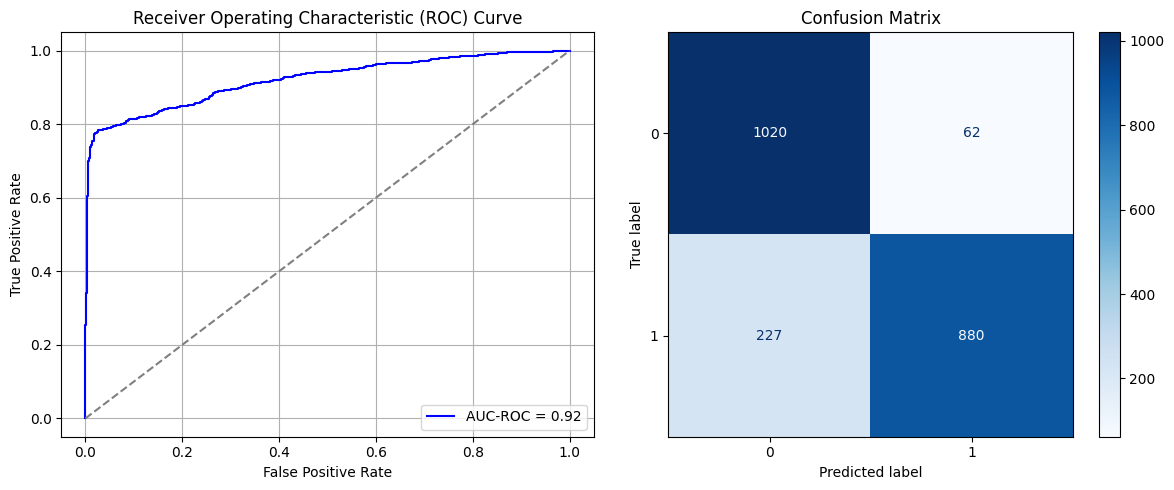

Best threshold based on F1-score: 0.557244598865509
Time elapsed (performance): 17.827612313998543


<Sequential name=sequential_1, built=True>

In [37]:
train_and_evaluate(model_source_SRSwR, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
AUC-ROC: 0.6747627563259788
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.83       707
           1       0.48      0.45      0.46       227

    accuracy                           0.75       934
   macro avg       0.65      0.65      0.65       934
weighted avg       0.74      0.75      0.74       934

FPR 0.157001414427157 TPR: 0.4493392070484582 FNR: 0.5506607929515418 TNR: 0.842998585572843


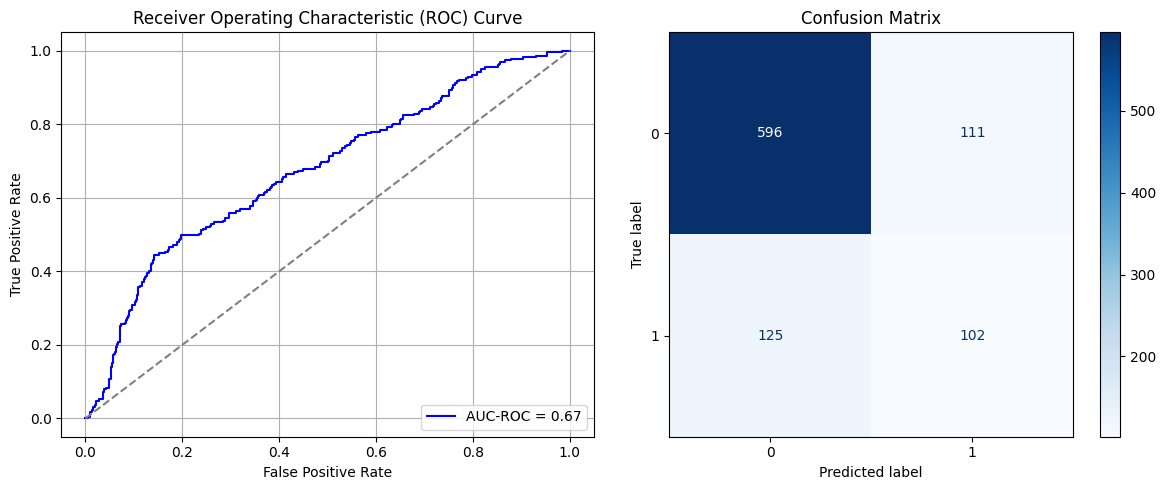

Best threshold based on F1-score: 0.9998979568481445
False Negative Rate: 0.5506607929515418
Time elapsed (performance): 0.6196656900010566


<ipython-input-23-de1f6cb50f3b>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [38]:
Transductive_TL(model_source_SRSwR, X_T_test, y_T_test, "Target")

In [39]:
fine_tuning(X_T_train, X_T_test, y_T_train, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - AUC: 0.7098 - loss: 0.6677 - val_AUC: 0.7182 - val_loss: 0.4978
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7203 - loss: 0.5085 - val_AUC: 0.7198 - val_loss: 0.4937
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7032 - loss: 0.5041 - val_AUC: 0.7217 - val_loss: 0.4935
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7180 - loss: 0.4960 - val_AUC: 0.7212 - val_loss: 0.4934
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7353 - loss: 0.4952 - val_AUC: 0.7215 - val_loss: 0.4935
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7039 - loss: 0.4875 - val_AUC: 0.7223 - val_loss: 0.4911
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7255 - loss: 0.5067 - val_AUC: 0.7231 - val_loss: 0.4926
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7378 - loss: 0.4922 - val_AUC: 0.7230 - val_loss: 0.4906
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7468 - loss: 0.4965 - v

(np.float64(0.08203677510608204), np.float64(0.6475770925110133))

In [40]:
fine_tuning(X_T_train_SRSwR, X_T_test, y_T_train_SRSwR, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - AUC: 0.6961 - loss: 0.8086 - val_AUC: 0.0000e+00 - val_loss: 0.9867
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7047 - loss: 0.6389 - val_AUC: 0.0000e+00 - val_loss: 0.9416
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7417 - loss: 0.5788 - val_AUC: 0.0000e+00 - val_loss: 0.9283
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7468 - loss: 0.5633 - val_AUC: 0.0000e+00 - val_loss: 0.8956
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7160 - loss: 0.5981 - val_AUC: 0.0000e+00 - val_loss: 0.8814
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7321 - loss: 0.5820 - val_AUC: 0.0000e+00 - val_loss: 0.8694
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7139 - loss: 0.5941 - val_AUC: 0.0000e+00 - val_loss: 0.8647
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7329 - loss: 0.5695 - val_AUC: 0.0000e+00 - val_loss: 0.8764
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

(np.float64(0.10042432814710042), np.float64(0.6255506607929515))

In [41]:
times = 50

FPR = []
FNR = []

for i in range(times):
    # X_T_train_SRSwR, y_T_train_SRSwR = SRSwR_undersampler(T_train, T_train.iloc[:,-1])
    fpr, fnr = fine_tuning(X_T_train_SRSwR, X_T_test, y_T_train_SRSwR, y_T_test, 0, 4)
    # print(output)
    FPR.append(fpr)
    FNR.append(fnr)

ParamFit = pd.DataFrame([FPR, FNR]).T
ParamFit.columns=['FPR', 'FNR']

# fine_tuning(X_T_train_SRSwR, X_T_test, y_T_train_SRSwR, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.7001 - loss: 0.8347 - val_AUC: 0.0000e+00 - val_loss: 1.0005
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6927 - loss: 0.6751 - val_AUC: 0.0000e+00 - val_loss: 0.9361
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7214 - loss: 0.5850 - val_AUC: 0.0000e+00 - val_loss: 0.8424
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7550 - loss: 0.5619 - val_AUC: 0.0000e+00 - val_loss: 0.8948
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7144 - loss: 0.5729 - val_AUC: 0.0000e+00 - val_loss: 0.8621
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7445 - loss: 0.5660 - val_AUC: 0.0000e+00 - val_loss: 0.8867
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7329 - loss: 0.5749 - val_AUC: 0.0000e+00 - val_loss: 0.8913
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7462 - loss: 0.5608 - val_AUC: 0.0000e+00 - val_loss: 0.9128
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_35 (Dense)                │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 0.6985 - loss: 0.8023 - val_AUC: 0.0000e+00 - val_loss: 1.0161
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6909 - loss: 0.6498 - val_AUC: 0.0000e+00 - val_loss: 0.8910
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7299 - loss: 0.5782 - val_AUC: 0.0000e+00 - val_loss: 0.9154
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7338 - loss: 0.5845 - val_AUC: 0.0000e+00 - val_loss: 0.8615
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7256 - loss: 0.5803 - val_AUC: 0.0000e+00 - val_loss: 0.8962
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7478 - loss: 0.5680 - val_AUC: 0.0000e+00 - val_loss: 0.9117
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7120 - loss: 0.6024 - val_AUC: 0.0000e+00 - val_loss: 0.9419
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7524 - loss: 0.5634 - val_AUC: 0.0000e+00 - val_loss: 0.9034
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_42 (Dense)                │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.7091 - loss: 0.7904 - val_AUC: 0.0000e+00 - val_loss: 0.9723
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7259 - loss: 0.6146 - val_AUC: 0.0000e+00 - val_loss: 0.9127
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6935 - loss: 0.6110 - val_AUC: 0.0000e+00 - val_loss: 0.8663
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7369 - loss: 0.5907 - val_AUC: 0.0000e+00 - val_loss: 0.9105
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7348 - loss: 0.5841 - val_AUC: 0.0000e+00 - val_loss: 0.9171
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7118 - loss: 0.5847 - val_AUC: 0.0000e+00 - val_loss: 0.8680
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7491 - loss: 0.5615 - val_AUC: 0.0000e+00 - val_loss: 0.9268
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7311 - loss: 0.5868 - val_AUC: 0.0000e+00 - val_loss: 0.8825
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_49 (Dense)                │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 0.7124 - loss: 0.7757 - val_AUC: 0.0000e+00 - val_loss: 1.0238
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7203 - loss: 0.6235 - val_AUC: 0.0000e+00 - val_loss: 0.9046
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7304 - loss: 0.5791 - val_AUC: 0.0000e+00 - val_loss: 0.9322
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7247 - loss: 0.5868 - val_AUC: 0.0000e+00 - val_loss: 0.8921
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7147 - loss: 0.5773 - val_AUC: 0.0000e+00 - val_loss: 0.8624
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7298 - loss: 0.5800 - val_AUC: 0.0000e+00 - val_loss: 0.8694
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7446 - loss: 0.5742 - val_AUC: 0.0000e+00 - val_loss: 1.0163
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7418 - loss: 0.5800 - val_AUC: 0.0000e+00 - val_loss: 0.8838
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_56 (Dense)                │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - AUC: 0.7026 - loss: 0.8353 - val_AUC: 0.0000e+00 - val_loss: 0.9927
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6880 - loss: 0.6674 - val_AUC: 0.0000e+00 - val_loss: 0.9069
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7151 - loss: 0.5947 - val_AUC: 0.0000e+00 - val_loss: 0.9170
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7306 - loss: 0.5578 - val_AUC: 0.0000e+00 - val_loss: 0.8993
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7439 - loss: 0.5718 - val_AUC: 0.0000e+00 - val_loss: 0.8836
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7171 - loss: 0.5734 - val_AUC: 0.0000e+00 - val_loss: 0.8559
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7405 - loss: 0.5843 - val_AUC: 0.0000e+00 - val_loss: 0.9695
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7350 - loss: 0.5732 - val_AUC: 0.0000e+00 - val_loss: 0.8761
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_63 (Dense)                │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - AUC: 0.7134 - loss: 0.8208 - val_AUC: 0.0000e+00 - val_loss: 0.9889
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7171 - loss: 0.6353 - val_AUC: 0.0000e+00 - val_loss: 0.9224
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7331 - loss: 0.5832 - val_AUC: 0.0000e+00 - val_loss: 0.9400
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7183 - loss: 0.5822 - val_AUC: 0.0000e+00 - val_loss: 0.8490
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7238 - loss: 0.5795 - val_AUC: 0.0000e+00 - val_loss: 0.8979
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7156 - loss: 0.5830 - val_AUC: 0.0000e+00 - val_loss: 0.8846
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7170 - loss: 0.5934 - val_AUC: 0.0000e+00 - val_loss: 0.8984
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7457 - loss: 0.5610 - val_AUC: 0.0000e+00 - val_loss: 0.8705
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_70 (Dense)                │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - AUC: 0.6858 - loss: 0.8591 - val_AUC: 0.0000e+00 - val_loss: 0.9637
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7167 - loss: 0.6706 - val_AUC: 0.0000e+00 - val_loss: 0.8442
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7280 - loss: 0.5996 - val_AUC: 0.0000e+00 - val_loss: 0.9108
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7356 - loss: 0.5835 - val_AUC: 0.0000e+00 - val_loss: 0.8820
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7359 - loss: 0.5894 - val_AUC: 0.0000e+00 - val_loss: 0.8765
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7314 - loss: 0.5762 - val_AUC: 0.0000e+00 - val_loss: 0.9172
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7301 - loss: 0.5693 - val_AUC: 0.0000e+00 - val_loss: 0.8450
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7192 - loss: 0.5729 - val_AUC: 0.0000e+00 - val_loss: 0.8865
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_77 (Dense)                │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - AUC: 0.7073 - loss: 0.8185 - val_AUC: 0.0000e+00 - val_loss: 0.9590
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7248 - loss: 0.6369 - val_AUC: 0.0000e+00 - val_loss: 0.8917
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7201 - loss: 0.5855 - val_AUC: 0.0000e+00 - val_loss: 0.8548
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7314 - loss: 0.5747 - val_AUC: 0.0000e+00 - val_loss: 0.8669
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7310 - loss: 0.5764 - val_AUC: 0.0000e+00 - val_loss: 0.8387
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7228 - loss: 0.5858 - val_AUC: 0.0000e+00 - val_loss: 0.9316
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7266 - loss: 0.5949 - val_AUC: 0.0000e+00 - val_loss: 0.9520
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7076 - loss: 0.6003 - val_AUC: 0.0000e+00 - val_loss: 0.8795
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_84 (Dense)                │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.6960 - loss: 0.8307 - val_AUC: 0.0000e+00 - val_loss: 0.9490
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7026 - loss: 0.6536 - val_AUC: 0.0000e+00 - val_loss: 0.8899
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7273 - loss: 0.5850 - val_AUC: 0.0000e+00 - val_loss: 0.8757
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7277 - loss: 0.5841 - val_AUC: 0.0000e+00 - val_loss: 0.8789
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7221 - loss: 0.5751 - val_AUC: 0.0000e+00 - val_loss: 0.8614
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7234 - loss: 0.5927 - val_AUC: 0.0000e+00 - val_loss: 0.9006
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7335 - loss: 0.5712 - val_AUC: 0.0000e+00 - val_loss: 0.8912
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7298 - loss: 0.5825 - val_AUC: 0.0000e+00 - val_loss: 0.8715
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_91 (Dense)                │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - AUC: 0.6939 - loss: 0.8323 - val_AUC: 0.0000e+00 - val_loss: 0.9639
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - AUC: 0.7069 - loss: 0.6314 - val_AUC: 0.0000e+00 - val_loss: 0.8737
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.7281 - loss: 0.5962 - val_AUC: 0.0000e+00 - val_loss: 0.9685
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7275 - loss: 0.5920 - val_AUC: 0.0000e+00 - val_loss: 0.9171
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - AUC: 0.7276 - loss: 0.5864 - val_AUC: 0.0000e+00 - val_loss: 0.8896
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - AUC: 0.7114 - loss: 0.6109 - val_AUC: 0.0000e+00 - val_loss: 0.8990
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - AUC: 0.7451 - loss: 0.5765 - val_AUC: 0.0000e+00 - val_loss: 0.9897
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - AUC: 0.7326 - loss: 0.5821 - val_AUC: 0.0000e+00 - val_loss: 0.8527
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_98 (Dense)                │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.7324 - loss: 0.7683 - val_AUC: 0.0000e+00 - val_loss: 0.9992
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6942 - loss: 0.6459 - val_AUC: 0.0000e+00 - val_loss: 0.9303
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7344 - loss: 0.5686 - val_AUC: 0.0000e+00 - val_loss: 0.8591
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7297 - loss: 0.5808 - val_AUC: 0.0000e+00 - val_loss: 0.8902
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7011 - loss: 0.5972 - val_AUC: 0.0000e+00 - val_loss: 0.8958
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7196 - loss: 0.5878 - val_AUC: 0.0000e+00 - val_loss: 0.9112
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7367 - loss: 0.5790 - val_AUC: 0.0000e+00 - val_loss: 0.9028
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7245 - loss: 0.5872 - val_AUC: 0.0000e+00 - val_loss: 0.9453
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_105 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - AUC: 0.7073 - loss: 0.7914 - val_AUC: 0.0000e+00 - val_loss: 1.0019
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7024 - loss: 0.6405 - val_AUC: 0.0000e+00 - val_loss: 0.8485
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6954 - loss: 0.5990 - val_AUC: 0.0000e+00 - val_loss: 0.8488
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7415 - loss: 0.5775 - val_AUC: 0.0000e+00 - val_loss: 0.9459
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7117 - loss: 0.5910 - val_AUC: 0.0000e+00 - val_loss: 0.9009
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7187 - loss: 0.5832 - val_AUC: 0.0000e+00 - val_loss: 0.8758
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7291 - loss: 0.5834 - val_AUC: 0.0000e+00 - val_loss: 0.8763
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7435 - loss: 0.5777 - val_AUC: 0.0000e+00 - val_loss: 0.9118
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_112 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_114 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_115 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_116 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - AUC: 0.6914 - loss: 0.8421 - val_AUC: 0.0000e+00 - val_loss: 0.9470
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7007 - loss: 0.6572 - val_AUC: 0.0000e+00 - val_loss: 0.9580
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7290 - loss: 0.5813 - val_AUC: 0.0000e+00 - val_loss: 0.9112
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7492 - loss: 0.5647 - val_AUC: 0.0000e+00 - val_loss: 0.8956
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7447 - loss: 0.5657 - val_AUC: 0.0000e+00 - val_loss: 0.8808
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7050 - loss: 0.5999 - val_AUC: 0.0000e+00 - val_loss: 0.9243
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7375 - loss: 0.5732 - val_AUC: 0.0000e+00 - val_loss: 0.8744
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7229 - loss: 0.5836 - val_AUC: 0.0000e+00 - val_loss: 0.8582
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_119 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_120 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_124 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_125 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - AUC: 0.6911 - loss: 0.8774 - val_AUC: 0.0000e+00 - val_loss: 0.9837
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7109 - loss: 0.6513 - val_AUC: 0.0000e+00 - val_loss: 0.9108
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7101 - loss: 0.6160 - val_AUC: 0.0000e+00 - val_loss: 0.9481
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7402 - loss: 0.5758 - val_AUC: 0.0000e+00 - val_loss: 0.8721
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7328 - loss: 0.5686 - val_AUC: 0.0000e+00 - val_loss: 0.9261
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7285 - loss: 0.5784 - val_AUC: 0.0000e+00 - val_loss: 0.9108
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7151 - loss: 0.5908 - val_AUC: 0.0000e+00 - val_loss: 0.8426
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7406 - loss: 0.5701 - val_AUC: 0.0000e+00 - val_loss: 0.9208
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_126 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_127 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_129 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_130 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_131 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_132 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - AUC: 0.7144 - loss: 0.7798 - val_AUC: 0.0000e+00 - val_loss: 0.9474
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7050 - loss: 0.6338 - val_AUC: 0.0000e+00 - val_loss: 0.8703
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7274 - loss: 0.5915 - val_AUC: 0.0000e+00 - val_loss: 0.8830
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7071 - loss: 0.5967 - val_AUC: 0.0000e+00 - val_loss: 0.9318
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7305 - loss: 0.5786 - val_AUC: 0.0000e+00 - val_loss: 0.8764
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7077 - loss: 0.5936 - val_AUC: 0.0000e+00 - val_loss: 0.8802
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7171 - loss: 0.5840 - val_AUC: 0.0000e+00 - val_loss: 0.8970
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7379 - loss: 0.5762 - val_AUC: 0.0000e+00 - val_loss: 0.9182
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_133 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_134 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_135 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_136 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_137 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_138 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_139 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.7226 - loss: 0.7718 - val_AUC: 0.0000e+00 - val_loss: 0.9701
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7080 - loss: 0.6361 - val_AUC: 0.0000e+00 - val_loss: 0.8723
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7248 - loss: 0.5861 - val_AUC: 0.0000e+00 - val_loss: 0.8702
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7239 - loss: 0.5788 - val_AUC: 0.0000e+00 - val_loss: 0.8915
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7411 - loss: 0.5793 - val_AUC: 0.0000e+00 - val_loss: 0.9212
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7391 - loss: 0.5664 - val_AUC: 0.0000e+00 - val_loss: 0.8588
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7208 - loss: 0.5911 - val_AUC: 0.0000e+00 - val_loss: 0.8680
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7159 - loss: 0.5807 - val_AUC: 0.0000e+00 - val_loss: 0.8868
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_140 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_141 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_142 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_144 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_145 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_146 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - AUC: 0.7040 - loss: 0.8071 - val_AUC: 0.0000e+00 - val_loss: 0.9969
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7095 - loss: 0.6363 - val_AUC: 0.0000e+00 - val_loss: 0.8873
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7195 - loss: 0.5973 - val_AUC: 0.0000e+00 - val_loss: 0.8887
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7338 - loss: 0.5862 - val_AUC: 0.0000e+00 - val_loss: 0.9417
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7200 - loss: 0.5896 - val_AUC: 0.0000e+00 - val_loss: 0.9051
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7423 - loss: 0.5732 - val_AUC: 0.0000e+00 - val_loss: 0.8334
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7447 - loss: 0.5665 - val_AUC: 0.0000e+00 - val_loss: 0.9023
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7366 - loss: 0.5682 - val_AUC: 0.0000e+00 - val_loss: 0.9262
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_147 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_148 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_149 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_150 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_151 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_152 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_153 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - AUC: 0.6980 - loss: 0.8387 - val_AUC: 0.0000e+00 - val_loss: 0.9887
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7325 - loss: 0.6167 - val_AUC: 0.0000e+00 - val_loss: 0.8661
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7343 - loss: 0.5972 - val_AUC: 0.0000e+00 - val_loss: 0.9583
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7494 - loss: 0.5628 - val_AUC: 0.0000e+00 - val_loss: 0.8930
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7447 - loss: 0.5719 - val_AUC: 0.0000e+00 - val_loss: 0.9161
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7424 - loss: 0.5692 - val_AUC: 0.0000e+00 - val_loss: 0.9207
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7457 - loss: 0.5671 - val_AUC: 0.0000e+00 - val_loss: 0.9497
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7282 - loss: 0.5729 - val_AUC: 0.0000e+00 - val_loss: 0.8467
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_154 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_155 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_156 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_157 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_158 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_159 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_160 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.7161 - loss: 0.8030 - val_AUC: 0.0000e+00 - val_loss: 0.9686
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7279 - loss: 0.6322 - val_AUC: 0.0000e+00 - val_loss: 0.9234
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7415 - loss: 0.5825 - val_AUC: 0.0000e+00 - val_loss: 0.9543
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7347 - loss: 0.5739 - val_AUC: 0.0000e+00 - val_loss: 0.8805
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7336 - loss: 0.5764 - val_AUC: 0.0000e+00 - val_loss: 0.9198
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7458 - loss: 0.5616 - val_AUC: 0.0000e+00 - val_loss: 0.8824
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7402 - loss: 0.5731 - val_AUC: 0.0000e+00 - val_loss: 0.9717
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7326 - loss: 0.5791 - val_AUC: 0.0000e+00 - val_loss: 0.9191
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_161 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_162 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_163 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_164 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_165 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_166 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_167 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - AUC: 0.6804 - loss: 0.8935 - val_AUC: 0.0000e+00 - val_loss: 0.9813
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.7230 - loss: 0.6228 - val_AUC: 0.0000e+00 - val_loss: 0.9281
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7184 - loss: 0.5872 - val_AUC: 0.0000e+00 - val_loss: 0.8849
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7501 - loss: 0.5614 - val_AUC: 0.0000e+00 - val_loss: 0.8934
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7274 - loss: 0.5778 - val_AUC: 0.0000e+00 - val_loss: 0.8678
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7134 - loss: 0.5916 - val_AUC: 0.0000e+00 - val_loss: 0.8670
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7279 - loss: 0.5751 - val_AUC: 0.0000e+00 - val_loss: 0.9446
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7360 - loss: 0.5738 - val_AUC: 0.0000e+00 - val_loss: 0.8894
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_168 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_169 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_170 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_171 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_172 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_173 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_174 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 0.7073 - loss: 0.7823 - val_AUC: 0.0000e+00 - val_loss: 0.9825
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7116 - loss: 0.6201 - val_AUC: 0.0000e+00 - val_loss: 0.9435
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7306 - loss: 0.5891 - val_AUC: 0.0000e+00 - val_loss: 0.9018
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7304 - loss: 0.5792 - val_AUC: 0.0000e+00 - val_loss: 0.8794
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7323 - loss: 0.5818 - val_AUC: 0.0000e+00 - val_loss: 0.8515
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7445 - loss: 0.5682 - val_AUC: 0.0000e+00 - val_loss: 0.8759
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7372 - loss: 0.5777 - val_AUC: 0.0000e+00 - val_loss: 0.8721
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7460 - loss: 0.5641 - val_AUC: 0.0000e+00 - val_loss: 0.8899
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_175 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_176 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_177 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_178 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_179 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_180 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_181 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 0.7273 - loss: 0.7859 - val_AUC: 0.0000e+00 - val_loss: 0.9925
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7038 - loss: 0.6671 - val_AUC: 0.0000e+00 - val_loss: 0.8809
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7067 - loss: 0.5988 - val_AUC: 0.0000e+00 - val_loss: 0.9121
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7327 - loss: 0.5839 - val_AUC: 0.0000e+00 - val_loss: 0.8467
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7400 - loss: 0.5756 - val_AUC: 0.0000e+00 - val_loss: 0.9592
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7403 - loss: 0.5710 - val_AUC: 0.0000e+00 - val_loss: 0.8626
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7152 - loss: 0.5761 - val_AUC: 0.0000e+00 - val_loss: 0.9129
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7202 - loss: 0.5869 - val_AUC: 0.0000e+00 - val_loss: 0.8979
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_182 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_183 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_184 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_185 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_186 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_187 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_188 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - AUC: 0.7109 - loss: 0.7964 - val_AUC: 0.0000e+00 - val_loss: 0.9783
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7023 - loss: 0.6317 - val_AUC: 0.0000e+00 - val_loss: 0.8859
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7208 - loss: 0.5991 - val_AUC: 0.0000e+00 - val_loss: 0.9237
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7245 - loss: 0.5889 - val_AUC: 0.0000e+00 - val_loss: 0.8750
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7113 - loss: 0.5818 - val_AUC: 0.0000e+00 - val_loss: 0.9190
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7264 - loss: 0.5791 - val_AUC: 0.0000e+00 - val_loss: 0.8945
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7456 - loss: 0.5733 - val_AUC: 0.0000e+00 - val_loss: 0.8267
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7373 - loss: 0.5817 - val_AUC: 0.0000e+00 - val_loss: 0.8813
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_189 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_190 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_191 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_192 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_193 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_194 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_195 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.7222 - loss: 0.7957 - val_AUC: 0.0000e+00 - val_loss: 1.0011
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7129 - loss: 0.6574 - val_AUC: 0.0000e+00 - val_loss: 0.8673
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7203 - loss: 0.5967 - val_AUC: 0.0000e+00 - val_loss: 0.9138
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7492 - loss: 0.5700 - val_AUC: 0.0000e+00 - val_loss: 0.9066
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7434 - loss: 0.5795 - val_AUC: 0.0000e+00 - val_loss: 0.8602
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7103 - loss: 0.5944 - val_AUC: 0.0000e+00 - val_loss: 0.8622
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7332 - loss: 0.5767 - val_AUC: 0.0000e+00 - val_loss: 0.8384
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7272 - loss: 0.5729 - val_AUC: 0.0000e+00 - val_loss: 0.8866
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_196 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_197 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_198 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_199 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_200 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_201 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_202 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - AUC: 0.7124 - loss: 0.7955 - val_AUC: 0.0000e+00 - val_loss: 1.0104
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7218 - loss: 0.6361 - val_AUC: 0.0000e+00 - val_loss: 0.9427
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7174 - loss: 0.5848 - val_AUC: 0.0000e+00 - val_loss: 0.8674
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7453 - loss: 0.5774 - val_AUC: 0.0000e+00 - val_loss: 0.9099
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7565 - loss: 0.5670 - val_AUC: 0.0000e+00 - val_loss: 0.8684
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7430 - loss: 0.5745 - val_AUC: 0.0000e+00 - val_loss: 0.9217
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7406 - loss: 0.5850 - val_AUC: 0.0000e+00 - val_loss: 0.9101
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7599 - loss: 0.5690 - val_AUC: 0.0000e+00 - val_loss: 0.9726
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_203 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_204 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_205 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_206 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_207 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_208 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_209 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - AUC: 0.7016 - loss: 0.8455 - val_AUC: 0.0000e+00 - val_loss: 0.9405
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.6883 - loss: 0.6747 - val_AUC: 0.0000e+00 - val_loss: 0.8787
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7239 - loss: 0.6003 - val_AUC: 0.0000e+00 - val_loss: 0.9055
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7358 - loss: 0.5779 - val_AUC: 0.0000e+00 - val_loss: 0.9122
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7316 - loss: 0.5754 - val_AUC: 0.0000e+00 - val_loss: 0.8767
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7299 - loss: 0.5797 - val_AUC: 0.0000e+00 - val_loss: 0.9044
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7326 - loss: 0.5769 - val_AUC: 0.0000e+00 - val_loss: 0.8712
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7322 - loss: 0.5813 - val_AUC: 0.0000e+00 - val_loss: 0.9722
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_210 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_211 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_212 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_213 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_214 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_215 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_216 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.6948 - loss: 0.8653 - val_AUC: 0.0000e+00 - val_loss: 0.9398
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7077 - loss: 0.6425 - val_AUC: 0.0000e+00 - val_loss: 0.9283
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7315 - loss: 0.5792 - val_AUC: 0.0000e+00 - val_loss: 0.9010
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7487 - loss: 0.5720 - val_AUC: 0.0000e+00 - val_loss: 0.9337
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7305 - loss: 0.5742 - val_AUC: 0.0000e+00 - val_loss: 0.8918
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7258 - loss: 0.5863 - val_AUC: 0.0000e+00 - val_loss: 0.8394
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7369 - loss: 0.5626 - val_AUC: 0.0000e+00 - val_loss: 0.8616
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7336 - loss: 0.5757 - val_AUC: 0.0000e+00 - val_loss: 0.8533
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_217 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_218 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_219 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_220 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_221 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_222 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_223 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - AUC: 0.6900 - loss: 0.8576 - val_AUC: 0.0000e+00 - val_loss: 0.9759
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6755 - loss: 0.6725 - val_AUC: 0.0000e+00 - val_loss: 0.9043
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7071 - loss: 0.6010 - val_AUC: 0.0000e+00 - val_loss: 0.8669
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7043 - loss: 0.6055 - val_AUC: 0.0000e+00 - val_loss: 0.9341
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7390 - loss: 0.5713 - val_AUC: 0.0000e+00 - val_loss: 0.8723
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7359 - loss: 0.5750 - val_AUC: 0.0000e+00 - val_loss: 0.9386
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7306 - loss: 0.5715 - val_AUC: 0.0000e+00 - val_loss: 0.8783
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7259 - loss: 0.5853 - val_AUC: 0.0000e+00 - val_loss: 0.8959
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_224 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_225 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_226 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_227 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_228 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_229 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_230 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.6924 - loss: 0.7989 - val_AUC: 0.0000e+00 - val_loss: 0.9535
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7223 - loss: 0.6334 - val_AUC: 0.0000e+00 - val_loss: 0.9021
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7279 - loss: 0.5852 - val_AUC: 0.0000e+00 - val_loss: 0.8926
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7583 - loss: 0.5539 - val_AUC: 0.0000e+00 - val_loss: 0.8760
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7164 - loss: 0.5907 - val_AUC: 0.0000e+00 - val_loss: 0.8912
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7242 - loss: 0.5847 - val_AUC: 0.0000e+00 - val_loss: 0.8948
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7210 - loss: 0.5859 - val_AUC: 0.0000e+00 - val_loss: 0.9259
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7094 - loss: 0.6039 - val_AUC: 0.0000e+00 - val_loss: 0.9150
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_231 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_232 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_233 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_234 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_235 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_236 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_237 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - AUC: 0.7052 - loss: 0.7923 - val_AUC: 0.0000e+00 - val_loss: 0.9554
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7066 - loss: 0.6506 - val_AUC: 0.0000e+00 - val_loss: 0.8609
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7252 - loss: 0.5895 - val_AUC: 0.0000e+00 - val_loss: 0.9451
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7041 - loss: 0.5981 - val_AUC: 0.0000e+00 - val_loss: 0.8830
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7309 - loss: 0.5825 - val_AUC: 0.0000e+00 - val_loss: 0.9451
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7269 - loss: 0.5710 - val_AUC: 0.0000e+00 - val_loss: 0.8626
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7248 - loss: 0.5772 - val_AUC: 0.0000e+00 - val_loss: 0.8652
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7293 - loss: 0.5687 - val_AUC: 0.0000e+00 - val_loss: 0.8433
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_238 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_239 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_240 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_241 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_242 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_243 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_244 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - AUC: 0.7049 - loss: 0.8017 - val_AUC: 0.0000e+00 - val_loss: 0.9909
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7097 - loss: 0.6391 - val_AUC: 0.0000e+00 - val_loss: 0.8969
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7195 - loss: 0.5962 - val_AUC: 0.0000e+00 - val_loss: 0.8702
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7318 - loss: 0.5762 - val_AUC: 0.0000e+00 - val_loss: 0.8860
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7185 - loss: 0.5752 - val_AUC: 0.0000e+00 - val_loss: 0.8796
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7197 - loss: 0.5753 - val_AUC: 0.0000e+00 - val_loss: 0.8921
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7383 - loss: 0.5776 - val_AUC: 0.0000e+00 - val_loss: 0.8712
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7041 - loss: 0.6024 - val_AUC: 0.0000e+00 - val_loss: 0.8299
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_245 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_246 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_247 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_248 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_249 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_250 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_251 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 0.6892 - loss: 0.8438 - val_AUC: 0.0000e+00 - val_loss: 0.9950
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6966 - loss: 0.6271 - val_AUC: 0.0000e+00 - val_loss: 0.8937
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7201 - loss: 0.5844 - val_AUC: 0.0000e+00 - val_loss: 0.8296
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7263 - loss: 0.5945 - val_AUC: 0.0000e+00 - val_loss: 0.9383
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7269 - loss: 0.5800 - val_AUC: 0.0000e+00 - val_loss: 0.8770
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7183 - loss: 0.5879 - val_AUC: 0.0000e+00 - val_loss: 0.8485
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7381 - loss: 0.5710 - val_AUC: 0.0000e+00 - val_loss: 0.8913
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7295 - loss: 0.5756 - val_AUC: 0.0000e+00 - val_loss: 0.9115
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_252 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_253 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_254 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_255 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_256 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_257 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_258 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 0.6810 - loss: 0.8403 - val_AUC: 0.0000e+00 - val_loss: 0.9957
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7095 - loss: 0.6353 - val_AUC: 0.0000e+00 - val_loss: 0.9049
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7201 - loss: 0.5927 - val_AUC: 0.0000e+00 - val_loss: 0.8462
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7535 - loss: 0.5583 - val_AUC: 0.0000e+00 - val_loss: 0.9350
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7270 - loss: 0.5831 - val_AUC: 0.0000e+00 - val_loss: 0.8988
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7274 - loss: 0.6090 - val_AUC: 0.0000e+00 - val_loss: 0.9562
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7308 - loss: 0.5767 - val_AUC: 0.0000e+00 - val_loss: 0.9104
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7159 - loss: 0.5987 - val_AUC: 0.0000e+00 - val_loss: 0.8943
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_259 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_260 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_261 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_262 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_263 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_264 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_265 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.7015 - loss: 0.8104 - val_AUC: 0.0000e+00 - val_loss: 1.0039
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7078 - loss: 0.6436 - val_AUC: 0.0000e+00 - val_loss: 0.8722
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7153 - loss: 0.5935 - val_AUC: 0.0000e+00 - val_loss: 0.9134
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7300 - loss: 0.5811 - val_AUC: 0.0000e+00 - val_loss: 0.8917
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7136 - loss: 0.5925 - val_AUC: 0.0000e+00 - val_loss: 0.9286
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7509 - loss: 0.5690 - val_AUC: 0.0000e+00 - val_loss: 0.9349
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7389 - loss: 0.5573 - val_AUC: 0.0000e+00 - val_loss: 0.8294
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7208 - loss: 0.5861 - val_AUC: 0.0000e+00 - val_loss: 0.8666
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_266 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_267 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_268 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_269 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_270 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_271 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_272 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.6874 - loss: 0.9013 - val_AUC: 0.0000e+00 - val_loss: 1.0149
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7165 - loss: 0.6528 - val_AUC: 0.0000e+00 - val_loss: 0.8916
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7157 - loss: 0.5933 - val_AUC: 0.0000e+00 - val_loss: 0.8711
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7428 - loss: 0.5605 - val_AUC: 0.0000e+00 - val_loss: 0.8807
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7290 - loss: 0.5731 - val_AUC: 0.0000e+00 - val_loss: 0.9076
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7330 - loss: 0.5788 - val_AUC: 0.0000e+00 - val_loss: 0.9057
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7368 - loss: 0.5784 - val_AUC: 0.0000e+00 - val_loss: 0.8938
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7247 - loss: 0.5853 - val_AUC: 0.0000e+00 - val_loss: 0.9346
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_273 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_274 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_275 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_276 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_277 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_278 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_279 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.7179 - loss: 0.7836 - val_AUC: 0.0000e+00 - val_loss: 1.0030
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6894 - loss: 0.6595 - val_AUC: 0.0000e+00 - val_loss: 0.8784
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7088 - loss: 0.6130 - val_AUC: 0.0000e+00 - val_loss: 0.9218
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7492 - loss: 0.5732 - val_AUC: 0.0000e+00 - val_loss: 0.8899
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7237 - loss: 0.5984 - val_AUC: 0.0000e+00 - val_loss: 0.9181
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7240 - loss: 0.5753 - val_AUC: 0.0000e+00 - val_loss: 0.8754
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7282 - loss: 0.5700 - val_AUC: 0.0000e+00 - val_loss: 0.7875
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7466 - loss: 0.5722 - val_AUC: 0.0000e+00 - val_loss: 0.9114
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_280 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_281 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_282 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_283 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_284 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_285 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_286 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 0.7069 - loss: 0.8517 - val_AUC: 0.0000e+00 - val_loss: 0.9802
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7285 - loss: 0.6240 - val_AUC: 0.0000e+00 - val_loss: 0.9057
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7218 - loss: 0.5878 - val_AUC: 0.0000e+00 - val_loss: 0.9102
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7270 - loss: 0.5930 - val_AUC: 0.0000e+00 - val_loss: 0.8946
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7438 - loss: 0.5608 - val_AUC: 0.0000e+00 - val_loss: 0.9306
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7410 - loss: 0.5773 - val_AUC: 0.0000e+00 - val_loss: 0.8497
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7287 - loss: 0.5843 - val_AUC: 0.0000e+00 - val_loss: 0.9565
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7342 - loss: 0.5769 - val_AUC: 0.0000e+00 - val_loss: 0.8276
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_287 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_288 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_289 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_290 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_291 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_292 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_293 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - AUC: 0.6960 - loss: 0.8339 - val_AUC: 0.0000e+00 - val_loss: 0.9944
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7093 - loss: 0.6288 - val_AUC: 0.0000e+00 - val_loss: 0.8762
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7461 - loss: 0.5804 - val_AUC: 0.0000e+00 - val_loss: 0.8878
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7154 - loss: 0.5929 - val_AUC: 0.0000e+00 - val_loss: 0.8821
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7259 - loss: 0.5739 - val_AUC: 0.0000e+00 - val_loss: 0.9449
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7181 - loss: 0.5898 - val_AUC: 0.0000e+00 - val_loss: 0.8594
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7372 - loss: 0.5808 - val_AUC: 0.0000e+00 - val_loss: 0.8811
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7397 - loss: 0.5706 - val_AUC: 0.0000e+00 - val_loss: 0.8869
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_294 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_295 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_296 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_297 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_298 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_299 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_300 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - AUC: 0.7038 - loss: 0.8043 - val_AUC: 0.0000e+00 - val_loss: 0.9945
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6999 - loss: 0.6551 - val_AUC: 0.0000e+00 - val_loss: 0.8955
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7124 - loss: 0.6232 - val_AUC: 0.0000e+00 - val_loss: 0.9147
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7326 - loss: 0.5757 - val_AUC: 0.0000e+00 - val_loss: 0.8985
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7145 - loss: 0.5764 - val_AUC: 0.0000e+00 - val_loss: 0.8328
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7194 - loss: 0.5950 - val_AUC: 0.0000e+00 - val_loss: 0.8738
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7397 - loss: 0.5783 - val_AUC: 0.0000e+00 - val_loss: 0.9249
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7595 - loss: 0.5565 - val_AUC: 0.0000e+00 - val_loss: 0.8710
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_301 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_302 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_303 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_304 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_305 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_306 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_307 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - AUC: 0.7082 - loss: 0.7829 - val_AUC: 0.0000e+00 - val_loss: 0.9878
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7117 - loss: 0.6218 - val_AUC: 0.0000e+00 - val_loss: 0.8885
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7101 - loss: 0.5963 - val_AUC: 0.0000e+00 - val_loss: 0.8707
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7207 - loss: 0.5763 - val_AUC: 0.0000e+00 - val_loss: 0.9030
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7381 - loss: 0.5775 - val_AUC: 0.0000e+00 - val_loss: 0.9060
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7334 - loss: 0.5773 - val_AUC: 0.0000e+00 - val_loss: 0.9136
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7212 - loss: 0.5817 - val_AUC: 0.0000e+00 - val_loss: 0.9056
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7134 - loss: 0.5965 - val_AUC: 0.0000e+00 - val_loss: 0.8815
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_308 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_309 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_310 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_311 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_312 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_313 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_314 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - AUC: 0.6988 - loss: 0.8119 - val_AUC: 0.0000e+00 - val_loss: 0.9886
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7231 - loss: 0.6455 - val_AUC: 0.0000e+00 - val_loss: 0.8768
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7150 - loss: 0.5945 - val_AUC: 0.0000e+00 - val_loss: 0.8723
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7390 - loss: 0.5653 - val_AUC: 0.0000e+00 - val_loss: 0.8519
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7446 - loss: 0.5738 - val_AUC: 0.0000e+00 - val_loss: 0.8934
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7368 - loss: 0.5766 - val_AUC: 0.0000e+00 - val_loss: 0.9230
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7345 - loss: 0.5793 - val_AUC: 0.0000e+00 - val_loss: 0.8904
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7403 - loss: 0.5698 - val_AUC: 0.0000e+00 - val_loss: 0.9205
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_315 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_316 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_317 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_318 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_319 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_320 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_321 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - AUC: 0.6909 - loss: 0.8513 - val_AUC: 0.0000e+00 - val_loss: 0.9620
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7196 - loss: 0.6539 - val_AUC: 0.0000e+00 - val_loss: 0.8710
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7332 - loss: 0.5903 - val_AUC: 0.0000e+00 - val_loss: 0.8827
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7138 - loss: 0.6005 - val_AUC: 0.0000e+00 - val_loss: 0.9162
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7330 - loss: 0.5717 - val_AUC: 0.0000e+00 - val_loss: 0.8789
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7326 - loss: 0.5723 - val_AUC: 0.0000e+00 - val_loss: 0.8753
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7152 - loss: 0.5952 - val_AUC: 0.0000e+00 - val_loss: 0.9506
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7326 - loss: 0.5695 - val_AUC: 0.0000e+00 - val_loss: 0.8611
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_322 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_323 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_324 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_325 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_326 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_327 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_328 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - AUC: 0.6995 - loss: 0.8375 - val_AUC: 0.0000e+00 - val_loss: 0.9799
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7112 - loss: 0.6436 - val_AUC: 0.0000e+00 - val_loss: 0.8949
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7098 - loss: 0.6009 - val_AUC: 0.0000e+00 - val_loss: 0.8976
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7138 - loss: 0.6016 - val_AUC: 0.0000e+00 - val_loss: 0.8900
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7218 - loss: 0.5870 - val_AUC: 0.0000e+00 - val_loss: 0.8887
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7424 - loss: 0.5763 - val_AUC: 0.0000e+00 - val_loss: 0.8737
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7347 - loss: 0.5747 - val_AUC: 0.0000e+00 - val_loss: 0.9382
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7346 - loss: 0.5767 - val_AUC: 0.0000e+00 - val_loss: 0.8667
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_329 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_330 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_331 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_332 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_333 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_334 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_335 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.7324 - loss: 0.7972 - val_AUC: 0.0000e+00 - val_loss: 0.9765
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7390 - loss: 0.6291 - val_AUC: 0.0000e+00 - val_loss: 0.9134
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7128 - loss: 0.6029 - val_AUC: 0.0000e+00 - val_loss: 0.9250
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7335 - loss: 0.5642 - val_AUC: 0.0000e+00 - val_loss: 0.8757
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7287 - loss: 0.5816 - val_AUC: 0.0000e+00 - val_loss: 0.9001
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7346 - loss: 0.5868 - val_AUC: 0.0000e+00 - val_loss: 0.8868
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7255 - loss: 0.5742 - val_AUC: 0.0000e+00 - val_loss: 0.8649
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7566 - loss: 0.5715 - val_AUC: 0.0000e+00 - val_loss: 0.9304
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_336 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_337 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_338 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_339 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_340 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_341 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_342 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - AUC: 0.6901 - loss: 0.8719 - val_AUC: 0.0000e+00 - val_loss: 0.9885
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7157 - loss: 0.6570 - val_AUC: 0.0000e+00 - val_loss: 0.9115
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7136 - loss: 0.6101 - val_AUC: 0.0000e+00 - val_loss: 0.9066
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7112 - loss: 0.5820 - val_AUC: 0.0000e+00 - val_loss: 0.8927
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7099 - loss: 0.5988 - val_AUC: 0.0000e+00 - val_loss: 0.9062
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7397 - loss: 0.5771 - val_AUC: 0.0000e+00 - val_loss: 0.8889
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7076 - loss: 0.5902 - val_AUC: 0.0000e+00 - val_loss: 0.9220
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7361 - loss: 0.5749 - val_AUC: 0.0000e+00 - val_loss: 0.9059
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_343 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_344 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_345 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_346 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_347 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_348 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_349 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.7175 - loss: 0.7991 - val_AUC: 0.0000e+00 - val_loss: 0.9826
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7016 - loss: 0.6370 - val_AUC: 0.0000e+00 - val_loss: 0.9337
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7216 - loss: 0.5882 - val_AUC: 0.0000e+00 - val_loss: 0.8630
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7292 - loss: 0.5840 - val_AUC: 0.0000e+00 - val_loss: 0.9422
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7328 - loss: 0.5655 - val_AUC: 0.0000e+00 - val_loss: 0.9177
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7361 - loss: 0.5693 - val_AUC: 0.0000e+00 - val_loss: 0.9118
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7324 - loss: 0.5731 - val_AUC: 0.0000e+00 - val_loss: 0.8946
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7115 - loss: 0.5880 - val_AUC: 0.0000e+00 - val_loss: 0.8371
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_350 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_351 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_352 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_353 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_354 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_355 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_356 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.6963 - loss: 0.8199 - val_AUC: 0.0000e+00 - val_loss: 0.9703
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7102 - loss: 0.6403 - val_AUC: 0.0000e+00 - val_loss: 0.9046
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7290 - loss: 0.5953 - val_AUC: 0.0000e+00 - val_loss: 0.8845
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7307 - loss: 0.5701 - val_AUC: 0.0000e+00 - val_loss: 0.8381
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7202 - loss: 0.5855 - val_AUC: 0.0000e+00 - val_loss: 0.8848
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7291 - loss: 0.5726 - val_AUC: 0.0000e+00 - val_loss: 0.9160
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7222 - loss: 0.5800 - val_AUC: 0.0000e+00 - val_loss: 0.9322
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7230 - loss: 0.5881 - val_AUC: 0.0000e+00 - val_loss: 0.8880
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_357 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_358 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_359 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_360 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_361 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_362 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_363 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - AUC: 0.6991 - loss: 0.8397 - val_AUC: 0.0000e+00 - val_loss: 0.9497
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7256 - loss: 0.6418 - val_AUC: 0.0000e+00 - val_loss: 0.9251
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7160 - loss: 0.5971 - val_AUC: 0.0000e+00 - val_loss: 0.9138
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7335 - loss: 0.5726 - val_AUC: 0.0000e+00 - val_loss: 0.8748
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7422 - loss: 0.5725 - val_AUC: 0.0000e+00 - val_loss: 0.8858
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7235 - loss: 0.5769 - val_AUC: 0.0000e+00 - val_loss: 0.8058
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7228 - loss: 0.5874 - val_AUC: 0.0000e+00 - val_loss: 0.9285
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7464 - loss: 0.5851 - val_AUC: 0.0000e+00 - val_loss: 0.8911
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_364 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_365 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_366 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_367 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_368 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_369 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_370 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.6909 - loss: 0.8021 - val_AUC: 0.0000e+00 - val_loss: 1.0015
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7089 - loss: 0.6490 - val_AUC: 0.0000e+00 - val_loss: 0.9009
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7290 - loss: 0.5851 - val_AUC: 0.0000e+00 - val_loss: 0.8825
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7345 - loss: 0.5715 - val_AUC: 0.0000e+00 - val_loss: 0.9093
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7461 - loss: 0.5614 - val_AUC: 0.0000e+00 - val_loss: 0.9129
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7140 - loss: 0.5862 - val_AUC: 0.0000e+00 - val_loss: 0.8683
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7497 - loss: 0.5655 - val_AUC: 0.0000e+00 - val_loss: 0.9031
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7281 - loss: 0.5803 - val_AUC: 0.0000e+00 - val_loss: 0.8999
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_371 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_372 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_373 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_374 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_375 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_376 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_377 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - AUC: 0.6953 - loss: 0.8417 - val_AUC: 0.0000e+00 - val_loss: 0.9376
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6992 - loss: 0.6573 - val_AUC: 0.0000e+00 - val_loss: 0.9503
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7323 - loss: 0.5908 - val_AUC: 0.0000e+00 - val_loss: 0.9247
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7101 - loss: 0.5941 - val_AUC: 0.0000e+00 - val_loss: 0.8842
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7413 - loss: 0.5632 - val_AUC: 0.0000e+00 - val_loss: 0.8749
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7539 - loss: 0.5605 - val_AUC: 0.0000e+00 - val_loss: 0.9182
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7311 - loss: 0.5791 - val_AUC: 0.0000e+00 - val_loss: 0.9172
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7495 - loss: 0.5804 - val_AUC: 0.0000e+00 - val_loss: 0.9286
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

In [42]:
print(ParamFit)
ParamFit.to_csv('SRSwR_Fine_Tuning.csv')

         FPR       FNR
0   0.104668  0.612335
1   0.106082  0.612335
2   0.100424  0.625551
3   0.108911  0.607930
4   0.108911  0.607930
5   0.110325  0.607930
6   0.110325  0.607930
7   0.108911  0.607930
8   0.108911  0.607930
9   0.107496  0.612335
10  0.110325  0.607930
11  0.110325  0.607930
12  0.103253  0.612335
13  0.111740  0.607930
14  0.111740  0.607930
15  0.108911  0.607930
16  0.108911  0.607930
17  0.094767  0.634361
18  0.110325  0.607930
19  0.110325  0.607930
20  0.104668  0.612335
21  0.110325  0.603524
22  0.106082  0.612335
23  0.108911  0.607930
24  0.110325  0.603524
25  0.103253  0.621145
26  0.103253  0.616740
27  0.107496  0.612335
28  0.100424  0.625551
29  0.100424  0.625551
30  0.107496  0.612335
31  0.110325  0.607930
32  0.103253  0.616740
33  0.110325  0.607930
34  0.108911  0.607930
35  0.103253  0.621145
36  0.108911  0.607930
37  0.103253  0.616740
38  0.107496  0.607930
39  0.106082  0.612335
40  0.111740  0.607930
41  0.100424  0.625551
42  0.10891

## Systematic Sampling:

First, we select a single systematic sample from the majority class, in which $k = \frac{N_0}{N_1}$, where $N_0$ is the majority class size in the source domain and $N_1$ is the minority class in the source domain.

In [44]:
X_S_Sy, y_S_Sy = systematic_undersampler(data_S_full, data_S_full.iloc[:,-1])
print(y_S_Sy)

X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_Sy, y_S_Sy, test_size=0.20, random_state=0)
X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(data_T_X, data_T_y, test_size=0.20, random_state=0)
T_train = pd.concat([X_T_train, y_T_train], axis=1)

X_T_train_Sy, y_T_train_Sy = systematic_undersampler(T_train, T_train.iloc[:, -1])
print(y_T_train_Sy)


5472
16799
3.0699926900584797
2
[1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 47, 50, 53, 56, 59, 62, 65, 68, 71, 74, 77, 80, 83, 86, 90, 93, 96, 99, 102, 105, 108, 111, 114, 117, 120, 123, 126, 129, 133, 136, 139, 142, 145, 148, 151, 154, 157, 160, 163, 166, 169, 172, 175, 179, 182, 185, 188, 191, 194, 197, 200, 203, 206, 209, 212, 215, 218, 222, 225, 228, 231, 234, 237, 240, 243, 246, 249, 252, 255, 258, 261, 265, 268, 271, 274, 277, 280, 283, 286, 289, 292, 295, 298, 301, 304, 307, 311, 314, 317, 320, 323, 326, 329, 332, 335, 338, 341, 344, 347, 350, 354, 357, 360, 363, 366, 369, 372, 375, 378, 381, 384, 387, 390, 393, 397, 400, 403, 406, 409, 412, 415, 418, 421, 424, 427, 430, 433, 436, 440, 443, 446, 449, 452, 455, 458, 461, 464, 467, 470, 473, 476, 479, 482, 486, 489, 492, 495, 498, 501, 504, 507, 510, 513, 516, 519, 522, 525, 529, 532, 535, 538, 541, 544, 547, 550, 553, 556, 559, 562, 565, 568, 572, 575, 578, 581, 584, 587, 590, 593, 596, 599, 602, 605, 608, 611, 614

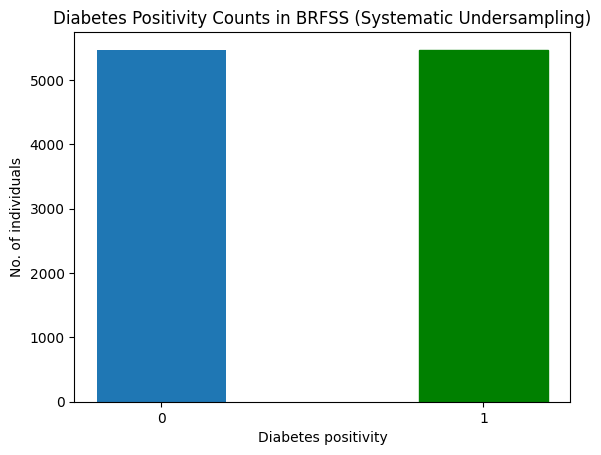

In [45]:
barlist = plt.bar([str(0),str(1)], y_S_Sy.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (Systematic Undersampling)")
plt.show()

In [46]:
print('X_S_train:',np.shape(X_S_train))
print('y_S_train:',np.shape(y_S_train))
print('X_S_test:',np.shape(X_S_test))
print('y_S_test:',np.shape(y_S_test))

X_S_train: (8755, 22)
y_S_train: (8755,)
X_S_test: (2189, 22)
y_S_test: (2189,)


In [47]:
model_source_Sy = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_378 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_379 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_380 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_381 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_382 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_383 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_384 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7


Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - AUC: 0.6946 - loss: 0.6220 - val_AUC: 0.8835 - val_loss: 0.4112
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8858 - loss: 0.3872 - val_AUC: 0.8933 - val_loss: 0.3505
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8958 - loss: 0.3481 - val_AUC: 0.9128 - val_loss: 0.3150
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9203 - loss: 0.3137 - val_AUC: 0.9105 - val_loss: 0.3731
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9112 - loss: 0.3350 - val_AUC: 0.9221 - val_loss: 0.3206
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9191 - loss: 0.3175 - val_AUC: 0.9225 - val_loss: 0.3190
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9258 - loss: 0.3057 - val_AUC: 0.9176 - val_loss: 0.3206
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9188 - loss: 0.3223 - val_AUC: 0.9247 - val_loss: 0.3071
Epoch 9/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - A

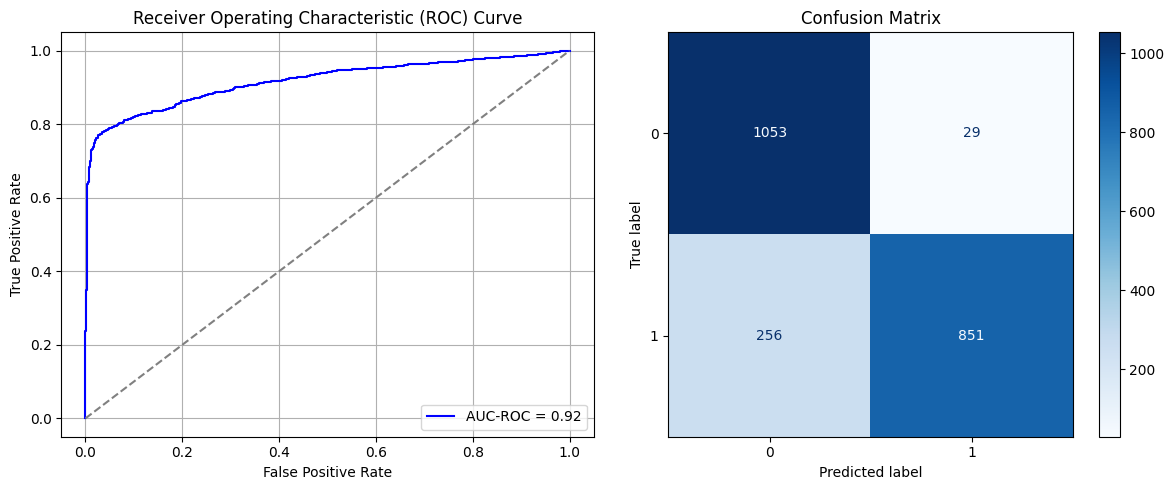

Best threshold based on F1-score: 0.39622408151626587
Time elapsed (performance): 17.638926872999946


<Sequential name=sequential_54, built=True>

In [48]:
train_and_evaluate(model_source_Sy, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
AUC-ROC: 0.6874115983026874
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       707
           1       0.45      0.48      0.46       227

    accuracy                           0.73       934
   macro avg       0.64      0.65      0.64       934
weighted avg       0.74      0.73      0.73       934

FPR 0.18953323903818953 TPR: 0.48017621145374445 FNR: 0.5198237885462555 TNR: 0.8104667609618105


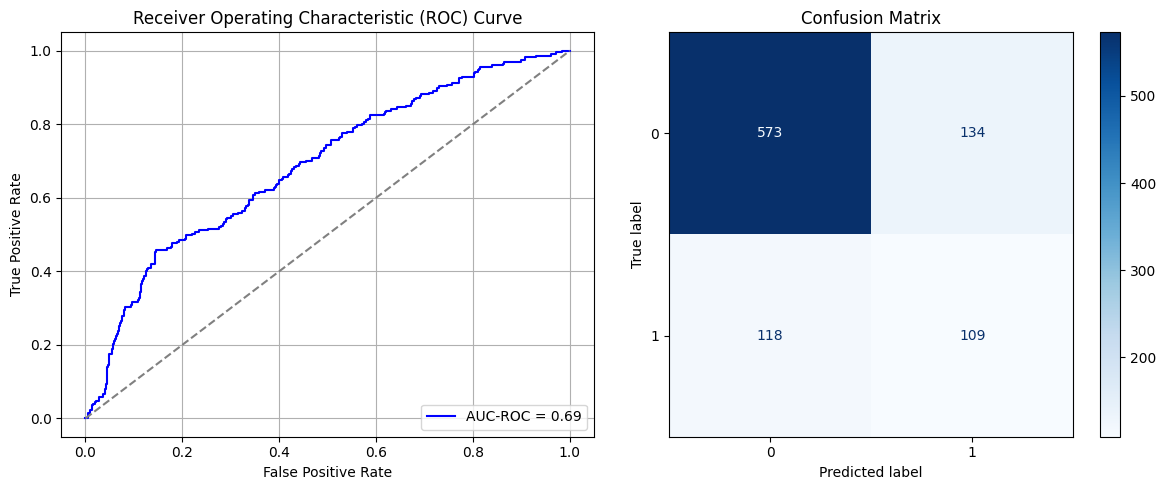

Best threshold based on F1-score: 0.9998408555984497
False Negative Rate: 0.5198237885462555
Time elapsed (performance): 0.49099042899979395


<ipython-input-23-de1f6cb50f3b>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [49]:
Transductive_TL(model_source_Sy, X_T_test, y_T_test, "Target")

In [50]:
fine_tuning(X_T_train, X_T_test, y_T_train, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_385 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_386 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_387 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_388 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_389 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_390 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_391 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - AUC: 0.6906 - loss: 0.7466 - val_AUC: 0.7127 - val_loss: 0.5271
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7119 - loss: 0.5308 - val_AUC: 0.7267 - val_loss: 0.4950
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7113 - loss: 0.5257 - val_AUC: 0.7282 - val_loss: 0.4908
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7063 - loss: 0.5124 - val_AUC: 0.7270 - val_loss: 0.4909
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7133 - loss: 0.5131 - val_AUC: 0.7281 - val_loss: 0.4913
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7260 - loss: 0.5052 - val_AUC: 0.7267 - val_loss: 0.4914
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7388 - loss: 0.4959 - val_AUC: 0.7287 - val_loss: 0.4925
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7154 - loss: 0.5095 - val_AUC: 0.7276 - val_loss: 0.4892
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7160 - loss: 0.5188 - v

(np.float64(0.10608203677510608), np.float64(0.6167400881057269))

In [59]:
fine_tuning(X_T_train_Sy, X_T_test, y_T_train_Sy, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_70"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_490 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_491 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_492 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_493 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_494 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_495 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_496 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - AUC: 0.6941 - loss: 0.8316 - val_AUC: 0.0000e+00 - val_loss: 0.9868
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7234 - loss: 0.6569 - val_AUC: 0.0000e+00 - val_loss: 0.9890
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6996 - loss: 0.6179 - val_AUC: 0.0000e+00 - val_loss: 0.9049
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7283 - loss: 0.6012 - val_AUC: 0.0000e+00 - val_loss: 0.9165
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7024 - loss: 0.6121 - val_AUC: 0.0000e+00 - val_loss: 0.9454
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7375 - loss: 0.5685 - val_AUC: 0.0000e+00 - val_loss: 0.9023
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7038 - loss: 0.6082 - val_AUC: 0.0000e+00 - val_loss: 0.9383
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7287 - loss: 0.5717 - val_AUC: 0.0000e+00 - val_loss: 0.8921
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

(np.float64(0.11598302687411598), np.float64(0.5859030837004405))

In [62]:
times = 50

FPR = []
FNR = []

for i in range(times):
    fpr, fnr = fine_tuning(X_T_train_Sy, X_T_test, y_T_train_Sy, y_T_test, 0, 4)
    # print(output)
    FPR.append(fpr)
    FNR.append(fnr)

ParamFit = pd.DataFrame([FPR, FNR]).T
ParamFit.columns=['FPR', 'FNR']


# fine_tuning(X_T_train_Sy, X_T_test, y_T_train_Sy, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_91"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_637 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_638 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_639 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_640 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_641 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_642 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_643 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 0.6977 - loss: 0.8974 - val_AUC: 0.0000e+00 - val_loss: 0.9565
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7217 - loss: 0.6522 - val_AUC: 0.0000e+00 - val_loss: 0.9271
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7094 - loss: 0.6119 - val_AUC: 0.0000e+00 - val_loss: 0.9097
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7487 - loss: 0.5822 - val_AUC: 0.0000e+00 - val_loss: 0.9356
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7093 - loss: 0.6008 - val_AUC: 0.0000e+00 - val_loss: 0.9123
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7183 - loss: 0.5905 - val_AUC: 0.0000e+00 - val_loss: 0.9399
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7352 - loss: 0.5757 - val_AUC: 0.0000e+00 - val_loss: 0.8681
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7333 - l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_92"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_644 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_645 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_646 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_647 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_648 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_649 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_650 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - AUC: 0.7123 - loss: 0.8065 - val_AUC: 0.0000e+00 - val_loss: 0.9444
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7093 - loss: 0.6493 - val_AUC: 0.0000e+00 - val_loss: 0.9070
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7121 - loss: 0.6174 - val_AUC: 0.0000e+00 - val_loss: 0.9441
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7062 - loss: 0.5979 - val_AUC: 0.0000e+00 - val_loss: 0.9110
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7313 - loss: 0.5906 - val_AUC: 0.0000e+00 - val_loss: 0.9063
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7453 - loss: 0.5806 - val_AUC: 0.0000e+00 - val_loss: 0.9081
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7358 - loss: 0.5750 - val_AUC: 0.0000e+00 - val_loss: 0.8882
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7221 - loss: 0.5925 - val_AUC: 0.0000e+00 - val_loss: 0.9802
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_93"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_651 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_652 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_653 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_654 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_655 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_656 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_657 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 0.7191 - loss: 0.7763 - val_AUC: 0.0000e+00 - val_loss: 0.9803
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6980 - loss: 0.6699 - val_AUC: 0.0000e+00 - val_loss: 0.9043
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7084 - loss: 0.6055 - val_AUC: 0.0000e+00 - val_loss: 0.9324
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7078 - loss: 0.5924 - val_AUC: 0.0000e+00 - val_loss: 0.8863
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7164 - loss: 0.5884 - val_AUC: 0.0000e+00 - val_loss: 0.8837
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6914 - loss: 0.6175 - val_AUC: 0.0000e+00 - val_loss: 0.9624
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7110 - loss: 0.6013 - val_AUC: 0.0000e+00 - val_loss: 0.9600
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7409 - loss: 0.5832 - val_AUC: 0.0000e+00 - val_loss: 0.9194
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_94"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_658 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_659 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_660 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_661 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_662 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_663 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_664 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - AUC: 0.7252 - loss: 0.7992 - val_AUC: 0.0000e+00 - val_loss: 0.9882
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6971 - loss: 0.6717 - val_AUC: 0.0000e+00 - val_loss: 0.9240
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6972 - loss: 0.6184 - val_AUC: 0.0000e+00 - val_loss: 0.9259
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7133 - loss: 0.5955 - val_AUC: 0.0000e+00 - val_loss: 0.8833
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7221 - loss: 0.5876 - val_AUC: 0.0000e+00 - val_loss: 0.8985
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7195 - loss: 0.5877 - val_AUC: 0.0000e+00 - val_loss: 0.9259
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7355 - loss: 0.5721 - val_AUC: 0.0000e+00 - val_loss: 0.8903
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7420 - loss: 0.5778 - val_AUC: 0.0000e+00 - val_loss: 0.9099
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_95"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_665 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_666 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_667 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_668 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_669 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_670 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_671 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - AUC: 0.6977 - loss: 0.8333 - val_AUC: 0.0000e+00 - val_loss: 0.9632
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6951 - loss: 0.6625 - val_AUC: 0.0000e+00 - val_loss: 1.0076
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7281 - loss: 0.6023 - val_AUC: 0.0000e+00 - val_loss: 0.9195
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7083 - loss: 0.5909 - val_AUC: 0.0000e+00 - val_loss: 0.9129
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7268 - loss: 0.5809 - val_AUC: 0.0000e+00 - val_loss: 0.9065
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7457 - loss: 0.5732 - val_AUC: 0.0000e+00 - val_loss: 0.9133
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7257 - loss: 0.5870 - val_AUC: 0.0000e+00 - val_loss: 0.9354
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7337 - loss: 0.5839 - val_AUC: 0.0000e+00 - val_loss: 0.8818
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_96"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_672 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_673 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_674 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_675 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_676 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_677 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_678 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.6986 - loss: 0.8197 - val_AUC: 0.0000e+00 - val_loss: 0.9548
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7063 - loss: 0.6406 - val_AUC: 0.0000e+00 - val_loss: 0.9524
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7120 - loss: 0.6011 - val_AUC: 0.0000e+00 - val_loss: 0.8759
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7324 - loss: 0.5894 - val_AUC: 0.0000e+00 - val_loss: 0.9118
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7129 - loss: 0.5934 - val_AUC: 0.0000e+00 - val_loss: 0.8728
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7434 - loss: 0.5692 - val_AUC: 0.0000e+00 - val_loss: 0.8648
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7296 - loss: 0.5705 - val_AUC: 0.0000e+00 - val_loss: 0.9162
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7310 - loss: 0.5837 - val_AUC: 0.0000e+00 - val_loss: 0.9462
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_97"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_679 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_680 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_681 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_682 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_683 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_684 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_685 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - AUC: 0.6980 - loss: 0.8156 - val_AUC: 0.0000e+00 - val_loss: 1.0405
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7150 - loss: 0.6551 - val_AUC: 0.0000e+00 - val_loss: 0.8929
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7079 - loss: 0.6044 - val_AUC: 0.0000e+00 - val_loss: 0.9364
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7274 - loss: 0.5827 - val_AUC: 0.0000e+00 - val_loss: 0.9260
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7298 - loss: 0.5838 - val_AUC: 0.0000e+00 - val_loss: 0.9237
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7053 - loss: 0.5879 - val_AUC: 0.0000e+00 - val_loss: 0.8621
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7154 - loss: 0.5746 - val_AUC: 0.0000e+00 - val_loss: 0.9244
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7417 - loss: 0.5681 - val_AUC: 0.0000e+00 - val_loss: 0.8783
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_98"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_686 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_687 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_688 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_689 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_690 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_691 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_692 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 0.6890 - loss: 0.8050 - val_AUC: 0.0000e+00 - val_loss: 0.9445
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6956 - loss: 0.6720 - val_AUC: 0.0000e+00 - val_loss: 0.9698
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7165 - loss: 0.6107 - val_AUC: 0.0000e+00 - val_loss: 0.8937
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7081 - loss: 0.6179 - val_AUC: 0.0000e+00 - val_loss: 0.9318
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7448 - loss: 0.5706 - val_AUC: 0.0000e+00 - val_loss: 0.8765
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7232 - loss: 0.5838 - val_AUC: 0.0000e+00 - val_loss: 0.9430
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7118 - loss: 0.5855 - val_AUC: 0.0000e+00 - val_loss: 0.9469
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7420 - loss: 0.5919 - val_AUC: 0.0000e+00 - val_loss: 0.9549
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_99"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_693 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_694 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_695 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_696 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_697 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_698 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_699 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.7242 - loss: 0.7921 - val_AUC: 0.0000e+00 - val_loss: 1.0543
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7130 - loss: 0.6532 - val_AUC: 0.0000e+00 - val_loss: 0.9397
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7241 - loss: 0.6021 - val_AUC: 0.0000e+00 - val_loss: 0.9696
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7168 - loss: 0.5965 - val_AUC: 0.0000e+00 - val_loss: 0.8953
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7151 - loss: 0.5956 - val_AUC: 0.0000e+00 - val_loss: 0.9413
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7223 - loss: 0.5793 - val_AUC: 0.0000e+00 - val_loss: 0.9136
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7426 - loss: 0.5708 - val_AUC: 0.0000e+00 - val_loss: 0.8925
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7355 - loss: 0.5612 - val_AUC: 0.0000e+00 - val_loss: 0.8695
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_100"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_700 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_701 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_702 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_703 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_704 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_705 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_706 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.7199 - loss: 0.7927 - val_AUC: 0.0000e+00 - val_loss: 0.9732
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6854 - loss: 0.6898 - val_AUC: 0.0000e+00 - val_loss: 0.8981
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7196 - loss: 0.6018 - val_AUC: 0.0000e+00 - val_loss: 0.9260
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7012 - loss: 0.6081 - val_AUC: 0.0000e+00 - val_loss: 0.9369
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7336 - loss: 0.5867 - val_AUC: 0.0000e+00 - val_loss: 0.9166
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7056 - loss: 0.5911 - val_AUC: 0.0000e+00 - val_loss: 0.9205
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7299 - loss: 0.5857 - val_AUC: 0.0000e+00 - val_loss: 0.9733
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7375 - loss: 0.5713 - val_AUC: 0.0000e+00 - val_loss: 0.8849
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_101"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_707 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_708 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_709 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_710 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_711 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_712 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_713 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.6727 - loss: 0.8519 - val_AUC: 0.0000e+00 - val_loss: 0.9858
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6823 - loss: 0.6778 - val_AUC: 0.0000e+00 - val_loss: 0.9134
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7036 - loss: 0.6145 - val_AUC: 0.0000e+00 - val_loss: 0.8709
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7340 - loss: 0.5775 - val_AUC: 0.0000e+00 - val_loss: 0.9217
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7267 - loss: 0.5795 - val_AUC: 0.0000e+00 - val_loss: 0.9315
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7206 - loss: 0.5788 - val_AUC: 0.0000e+00 - val_loss: 0.8812
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7212 - loss: 0.5825 - val_AUC: 0.0000e+00 - val_loss: 0.9446
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7260 - loss: 0.5820 - val_AUC: 0.0000e+00 - val_loss: 0.9018
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_102"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_714 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_715 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_716 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_717 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_718 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_719 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_720 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - AUC: 0.6813 - loss: 0.9171 - val_AUC: 0.0000e+00 - val_loss: 0.9767
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7148 - loss: 0.6495 - val_AUC: 0.0000e+00 - val_loss: 0.8683
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7204 - loss: 0.6168 - val_AUC: 0.0000e+00 - val_loss: 0.9552
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7116 - loss: 0.5964 - val_AUC: 0.0000e+00 - val_loss: 0.8868
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7342 - loss: 0.5846 - val_AUC: 0.0000e+00 - val_loss: 0.9247
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7141 - loss: 0.6032 - val_AUC: 0.0000e+00 - val_loss: 0.9177
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7149 - loss: 0.5913 - val_AUC: 0.0000e+00 - val_loss: 0.8933
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7235 - loss: 0.5893 - val_AUC: 0.0000e+00 - val_loss: 0.9186
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_103"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_721 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_722 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_723 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_724 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_725 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_726 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_727 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - AUC: 0.6844 - loss: 0.8269 - val_AUC: 0.0000e+00 - val_loss: 0.9817
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7074 - loss: 0.6705 - val_AUC: 0.0000e+00 - val_loss: 0.9329
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7103 - loss: 0.6168 - val_AUC: 0.0000e+00 - val_loss: 0.9267
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7309 - loss: 0.5890 - val_AUC: 0.0000e+00 - val_loss: 0.9149
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7225 - loss: 0.5928 - val_AUC: 0.0000e+00 - val_loss: 0.9169
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7213 - loss: 0.6014 - val_AUC: 0.0000e+00 - val_loss: 0.9339
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7344 - loss: 0.5717 - val_AUC: 0.0000e+00 - val_loss: 0.9172
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7622 - loss: 0.5510 - val_AUC: 0.0000e+00 - val_loss: 0.8841
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_104"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_728 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_729 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_730 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_731 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_732 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_733 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_734 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 0.7003 - loss: 0.8187 - val_AUC: 0.0000e+00 - val_loss: 0.9854
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7052 - loss: 0.6417 - val_AUC: 0.0000e+00 - val_loss: 0.9390
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7431 - loss: 0.5749 - val_AUC: 0.0000e+00 - val_loss: 0.8971
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6952 - loss: 0.6021 - val_AUC: 0.0000e+00 - val_loss: 0.9013
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7180 - loss: 0.5986 - val_AUC: 0.0000e+00 - val_loss: 0.9822
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7287 - loss: 0.5831 - val_AUC: 0.0000e+00 - val_loss: 0.9211
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7619 - loss: 0.5634 - val_AUC: 0.0000e+00 - val_loss: 0.9043
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7372 - loss: 0.5807 - val_AUC: 0.0000e+00 - val_loss: 0.8946
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_105"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_735 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_736 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_737 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_738 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_739 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_740 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_741 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 0.6937 - loss: 0.8619 - val_AUC: 0.0000e+00 - val_loss: 0.9646
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7090 - loss: 0.6552 - val_AUC: 0.0000e+00 - val_loss: 0.9483
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7167 - loss: 0.6046 - val_AUC: 0.0000e+00 - val_loss: 0.9164
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7178 - loss: 0.5986 - val_AUC: 0.0000e+00 - val_loss: 0.9285
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7478 - loss: 0.5697 - val_AUC: 0.0000e+00 - val_loss: 0.9080
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7413 - loss: 0.5745 - val_AUC: 0.0000e+00 - val_loss: 0.9033
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7165 - loss: 0.5847 - val_AUC: 0.0000e+00 - val_loss: 0.8901
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7184 - loss: 0.5828 - val_AUC: 0.0000e+00 - val_loss: 0.8757
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_106"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_742 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_743 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_744 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_745 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_746 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_747 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_748 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 0.7121 - loss: 0.7881 - val_AUC: 0.0000e+00 - val_loss: 0.9348
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7051 - loss: 0.6424 - val_AUC: 0.0000e+00 - val_loss: 0.8928
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7125 - loss: 0.6091 - val_AUC: 0.0000e+00 - val_loss: 0.9206
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7298 - loss: 0.5755 - val_AUC: 0.0000e+00 - val_loss: 0.8885
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7382 - loss: 0.5789 - val_AUC: 0.0000e+00 - val_loss: 0.9165
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7161 - loss: 0.5908 - val_AUC: 0.0000e+00 - val_loss: 0.9232
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7146 - loss: 0.5931 - val_AUC: 0.0000e+00 - val_loss: 0.9104
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7296 - loss: 0.5805 - val_AUC: 0.0000e+00 - val_loss: 0.9147
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_107"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_749 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_750 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_751 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_752 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_753 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_754 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_755 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 0.7219 - loss: 0.7601 - val_AUC: 0.0000e+00 - val_loss: 1.0227
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7144 - loss: 0.6290 - val_AUC: 0.0000e+00 - val_loss: 0.8718
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7137 - loss: 0.6095 - val_AUC: 0.0000e+00 - val_loss: 0.9271
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7048 - loss: 0.5998 - val_AUC: 0.0000e+00 - val_loss: 0.9028
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7250 - loss: 0.5922 - val_AUC: 0.0000e+00 - val_loss: 0.9443
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7291 - loss: 0.5896 - val_AUC: 0.0000e+00 - val_loss: 0.9378
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7350 - loss: 0.5829 - val_AUC: 0.0000e+00 - val_loss: 0.9194
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7409 - loss: 0.5728 - val_AUC: 0.0000e+00 - val_loss: 0.9006
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_108"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_756 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_757 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_758 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_759 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_760 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_761 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_762 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.6987 - loss: 0.8597 - val_AUC: 0.0000e+00 - val_loss: 0.9402
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7149 - loss: 0.6638 - val_AUC: 0.0000e+00 - val_loss: 0.9305
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7121 - loss: 0.6159 - val_AUC: 0.0000e+00 - val_loss: 0.9332
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7277 - loss: 0.5793 - val_AUC: 0.0000e+00 - val_loss: 0.9125
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7159 - loss: 0.6130 - val_AUC: 0.0000e+00 - val_loss: 0.9310
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7235 - loss: 0.5926 - val_AUC: 0.0000e+00 - val_loss: 0.8977
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7232 - loss: 0.5883 - val_AUC: 0.0000e+00 - val_loss: 0.9499
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7127 - loss: 0.5997 - val_AUC: 0.0000e+00 - val_loss: 0.8947
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_109"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_763 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_764 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_765 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_766 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_767 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_768 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_769 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 0.6877 - loss: 0.8528 - val_AUC: 0.0000e+00 - val_loss: 0.9570
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7142 - loss: 0.6629 - val_AUC: 0.0000e+00 - val_loss: 0.9581
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7196 - loss: 0.6151 - val_AUC: 0.0000e+00 - val_loss: 0.9587
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7336 - loss: 0.5889 - val_AUC: 0.0000e+00 - val_loss: 0.8909
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7278 - loss: 0.5949 - val_AUC: 0.0000e+00 - val_loss: 0.9490
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7401 - loss: 0.5750 - val_AUC: 0.0000e+00 - val_loss: 0.8928
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7394 - loss: 0.5673 - val_AUC: 0.0000e+00 - val_loss: 0.9021
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7409 - loss: 0.5659 - val_AUC: 0.0000e+00 - val_loss: 0.8539
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_110"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_770 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_771 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_772 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_773 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_774 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_775 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_776 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - AUC: 0.7069 - loss: 0.7898 - val_AUC: 0.0000e+00 - val_loss: 1.0150
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7076 - loss: 0.6507 - val_AUC: 0.0000e+00 - val_loss: 0.9370
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7484 - loss: 0.5881 - val_AUC: 0.0000e+00 - val_loss: 0.9613
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7230 - loss: 0.6062 - val_AUC: 0.0000e+00 - val_loss: 0.9579
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7284 - loss: 0.5887 - val_AUC: 0.0000e+00 - val_loss: 0.9177
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7359 - loss: 0.5760 - val_AUC: 0.0000e+00 - val_loss: 0.9213
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7235 - loss: 0.5861 - val_AUC: 0.0000e+00 - val_loss: 0.9074
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7250 - loss: 0.5806 - val_AUC: 0.0000e+00 - val_loss: 0.8593
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_111"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_777 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_778 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_779 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_780 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_781 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_782 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_783 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - AUC: 0.6904 - loss: 0.8044 - val_AUC: 0.0000e+00 - val_loss: 1.0507
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7194 - loss: 0.6391 - val_AUC: 0.0000e+00 - val_loss: 0.8850
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7081 - loss: 0.6157 - val_AUC: 0.0000e+00 - val_loss: 0.8693
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7150 - loss: 0.5997 - val_AUC: 0.0000e+00 - val_loss: 0.9171
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7351 - loss: 0.5829 - val_AUC: 0.0000e+00 - val_loss: 0.9032
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7277 - loss: 0.5849 - val_AUC: 0.0000e+00 - val_loss: 0.9149
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7394 - loss: 0.5643 - val_AUC: 0.0000e+00 - val_loss: 0.9041
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7188 - loss: 0.5960 - val_AUC: 0.0000e+00 - val_loss: 0.8883
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_112"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_784 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_785 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_786 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_787 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_788 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_789 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_790 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.6969 - loss: 0.8316 - val_AUC: 0.0000e+00 - val_loss: 1.0236
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7036 - loss: 0.6386 - val_AUC: 0.0000e+00 - val_loss: 0.9464
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6938 - loss: 0.6126 - val_AUC: 0.0000e+00 - val_loss: 0.8773
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7169 - loss: 0.5989 - val_AUC: 0.0000e+00 - val_loss: 0.9392
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7083 - loss: 0.5996 - val_AUC: 0.0000e+00 - val_loss: 0.8887
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7327 - loss: 0.5831 - val_AUC: 0.0000e+00 - val_loss: 0.8856
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7252 - loss: 0.5879 - val_AUC: 0.0000e+00 - val_loss: 0.8682
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7163 - loss: 0.5819 - val_AUC: 0.0000e+00 - val_loss: 0.9359
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_113"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_791 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_792 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_793 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_794 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_795 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_796 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_797 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - AUC: 0.7197 - loss: 0.7698 - val_AUC: 0.0000e+00 - val_loss: 0.9660
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7161 - loss: 0.6326 - val_AUC: 0.0000e+00 - val_loss: 0.9635
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7226 - loss: 0.5994 - val_AUC: 0.0000e+00 - val_loss: 0.9261
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7203 - loss: 0.5974 - val_AUC: 0.0000e+00 - val_loss: 0.9618
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7247 - loss: 0.5980 - val_AUC: 0.0000e+00 - val_loss: 0.8885
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7446 - loss: 0.5793 - val_AUC: 0.0000e+00 - val_loss: 0.9144
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7541 - loss: 0.5523 - val_AUC: 0.0000e+00 - val_loss: 0.8445
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7053 - loss: 0.5830 - val_AUC: 0.0000e+00 - val_loss: 0.8971
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_114"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_798 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_799 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_800 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_801 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_802 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_803 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_804 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.7213 - loss: 0.7966 - val_AUC: 0.0000e+00 - val_loss: 0.9488
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7107 - loss: 0.6457 - val_AUC: 0.0000e+00 - val_loss: 0.8995
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7105 - loss: 0.6021 - val_AUC: 0.0000e+00 - val_loss: 0.8927
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7213 - loss: 0.5889 - val_AUC: 0.0000e+00 - val_loss: 0.8877
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7296 - loss: 0.5892 - val_AUC: 0.0000e+00 - val_loss: 0.9264
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7328 - loss: 0.5744 - val_AUC: 0.0000e+00 - val_loss: 0.8959
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7161 - loss: 0.5869 - val_AUC: 0.0000e+00 - val_loss: 0.8760
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7443 - loss: 0.5718 - val_AUC: 0.0000e+00 - val_loss: 0.9607
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_115"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_805 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_806 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_807 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_808 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_809 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_810 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_811 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 0.6788 - loss: 0.8393 - val_AUC: 0.0000e+00 - val_loss: 0.9767
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7157 - loss: 0.6572 - val_AUC: 0.0000e+00 - val_loss: 0.8785
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7124 - loss: 0.6107 - val_AUC: 0.0000e+00 - val_loss: 0.9373
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7320 - loss: 0.5938 - val_AUC: 0.0000e+00 - val_loss: 0.9029
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7185 - loss: 0.5861 - val_AUC: 0.0000e+00 - val_loss: 0.9289
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7159 - loss: 0.5855 - val_AUC: 0.0000e+00 - val_loss: 0.8688
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7332 - loss: 0.5719 - val_AUC: 0.0000e+00 - val_loss: 0.8674
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7294 - loss: 0.5843 - val_AUC: 0.0000e+00 - val_loss: 0.9010
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_116"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_812 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_813 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_814 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_815 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_816 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_817 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_818 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 0.6858 - loss: 0.8617 - val_AUC: 0.0000e+00 - val_loss: 0.9706
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.6841 - loss: 0.6933 - val_AUC: 0.0000e+00 - val_loss: 0.9164
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7134 - loss: 0.6170 - val_AUC: 0.0000e+00 - val_loss: 0.9338
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7062 - loss: 0.6083 - val_AUC: 0.0000e+00 - val_loss: 0.9381
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7361 - loss: 0.5743 - val_AUC: 0.0000e+00 - val_loss: 0.9133
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7353 - loss: 0.5824 - val_AUC: 0.0000e+00 - val_loss: 0.9003
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7321 - loss: 0.5790 - val_AUC: 0.0000e+00 - val_loss: 0.9068
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7101 - loss: 0.5981 - val_AUC: 0.0000e+00 - val_loss: 0.9816
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_117"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_819 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_820 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_821 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_822 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_823 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_824 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_825 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.6972 - loss: 0.8842 - val_AUC: 0.0000e+00 - val_loss: 0.9774
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6840 - loss: 0.6793 - val_AUC: 0.0000e+00 - val_loss: 0.9087
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7199 - loss: 0.6015 - val_AUC: 0.0000e+00 - val_loss: 0.9309
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7277 - loss: 0.5893 - val_AUC: 0.0000e+00 - val_loss: 0.9127
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7123 - loss: 0.6065 - val_AUC: 0.0000e+00 - val_loss: 0.9318
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6974 - loss: 0.6046 - val_AUC: 0.0000e+00 - val_loss: 0.9131
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7198 - loss: 0.5903 - val_AUC: 0.0000e+00 - val_loss: 0.8982
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7300 - loss: 0.5875 - val_AUC: 0.0000e+00 - val_loss: 0.9720
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_118"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_826 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_827 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_828 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_829 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_830 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_831 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_832 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.6891 - loss: 0.8963 - val_AUC: 0.0000e+00 - val_loss: 0.9586
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7055 - loss: 0.6698 - val_AUC: 0.0000e+00 - val_loss: 0.9135
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7328 - loss: 0.6045 - val_AUC: 0.0000e+00 - val_loss: 0.8904
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7212 - loss: 0.5849 - val_AUC: 0.0000e+00 - val_loss: 0.8813
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7273 - loss: 0.5876 - val_AUC: 0.0000e+00 - val_loss: 0.9462
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7241 - loss: 0.5828 - val_AUC: 0.0000e+00 - val_loss: 0.8637
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7073 - loss: 0.5949 - val_AUC: 0.0000e+00 - val_loss: 0.9303
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7050 - loss: 0.5926 - val_AUC: 0.0000e+00 - val_loss: 0.9237
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_119"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_833 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_834 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_835 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_836 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_837 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_838 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_839 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - AUC: 0.7038 - loss: 0.8595 - val_AUC: 0.0000e+00 - val_loss: 0.9619
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6993 - loss: 0.6556 - val_AUC: 0.0000e+00 - val_loss: 0.9069
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7254 - loss: 0.5897 - val_AUC: 0.0000e+00 - val_loss: 0.9203
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6993 - loss: 0.6042 - val_AUC: 0.0000e+00 - val_loss: 0.8852
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7192 - loss: 0.5962 - val_AUC: 0.0000e+00 - val_loss: 0.9564
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7291 - loss: 0.5884 - val_AUC: 0.0000e+00 - val_loss: 0.9244
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7268 - loss: 0.5802 - val_AUC: 0.0000e+00 - val_loss: 0.8948
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7358 - loss: 0.5741 - val_AUC: 0.0000e+00 - val_loss: 0.8898
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_120"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_840 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_841 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_842 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_843 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_844 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_845 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_846 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - AUC: 0.6974 - loss: 0.7697 - val_AUC: 0.0000e+00 - val_loss: 0.9828
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6880 - loss: 0.6836 - val_AUC: 0.0000e+00 - val_loss: 0.9217
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7170 - loss: 0.6077 - val_AUC: 0.0000e+00 - val_loss: 0.8830
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7089 - loss: 0.5911 - val_AUC: 0.0000e+00 - val_loss: 0.9330
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7238 - loss: 0.5940 - val_AUC: 0.0000e+00 - val_loss: 0.8870
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7466 - loss: 0.5740 - val_AUC: 0.0000e+00 - val_loss: 0.9034
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7264 - loss: 0.5804 - val_AUC: 0.0000e+00 - val_loss: 0.9034
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7132 - loss: 0.5877 - val_AUC: 0.0000e+00 - val_loss: 0.8879
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_847 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_848 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_849 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_850 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_851 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_852 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_853 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.6941 - loss: 0.8828 - val_AUC: 0.0000e+00 - val_loss: 0.9848
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7012 - loss: 0.6555 - val_AUC: 0.0000e+00 - val_loss: 0.9311
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7063 - loss: 0.6273 - val_AUC: 0.0000e+00 - val_loss: 0.9440
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7473 - loss: 0.5695 - val_AUC: 0.0000e+00 - val_loss: 0.8849
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7147 - loss: 0.6038 - val_AUC: 0.0000e+00 - val_loss: 0.9822
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7335 - loss: 0.5916 - val_AUC: 0.0000e+00 - val_loss: 0.9297
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7178 - loss: 0.5837 - val_AUC: 0.0000e+00 - val_loss: 0.9207
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7240 - loss: 0.5894 - val_AUC: 0.0000e+00 - val_loss: 0.9954
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_122"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_854 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_855 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_856 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_857 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_858 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_859 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_860 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - AUC: 0.7090 - loss: 0.7824 - val_AUC: 0.0000e+00 - val_loss: 0.9489
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7152 - loss: 0.6686 - val_AUC: 0.0000e+00 - val_loss: 0.9407
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6928 - loss: 0.6351 - val_AUC: 0.0000e+00 - val_loss: 0.8805
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7328 - loss: 0.5764 - val_AUC: 0.0000e+00 - val_loss: 0.9307
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7303 - loss: 0.5768 - val_AUC: 0.0000e+00 - val_loss: 0.8841
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7345 - loss: 0.5811 - val_AUC: 0.0000e+00 - val_loss: 0.9077
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7266 - loss: 0.5883 - val_AUC: 0.0000e+00 - val_loss: 0.8974
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7048 - loss: 0.6031 - val_AUC: 0.0000e+00 - val_loss: 0.9272
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_123"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_861 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_862 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_863 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_864 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_865 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_866 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_867 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.6847 - loss: 0.8800 - val_AUC: 0.0000e+00 - val_loss: 0.9659
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.6902 - loss: 0.6678 - val_AUC: 0.0000e+00 - val_loss: 0.9110
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7219 - loss: 0.5948 - val_AUC: 0.0000e+00 - val_loss: 0.9089
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7150 - loss: 0.5958 - val_AUC: 0.0000e+00 - val_loss: 0.9277
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7186 - loss: 0.5927 - val_AUC: 0.0000e+00 - val_loss: 0.8765
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7158 - loss: 0.6049 - val_AUC: 0.0000e+00 - val_loss: 0.9234
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7293 - loss: 0.5805 - val_AUC: 0.0000e+00 - val_loss: 0.8934
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7265 - loss: 0.5837 - val_AUC: 0.0000e+00 - val_loss: 0.9285
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_124"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_868 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_869 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_870 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_871 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_872 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_873 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_874 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - AUC: 0.6986 - loss: 0.8543 - val_AUC: 0.0000e+00 - val_loss: 1.0008
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7047 - loss: 0.6596 - val_AUC: 0.0000e+00 - val_loss: 0.9286
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7243 - loss: 0.5950 - val_AUC: 0.0000e+00 - val_loss: 0.9028
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7202 - loss: 0.5881 - val_AUC: 0.0000e+00 - val_loss: 0.9083
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7224 - loss: 0.5859 - val_AUC: 0.0000e+00 - val_loss: 0.9148
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7268 - loss: 0.5870 - val_AUC: 0.0000e+00 - val_loss: 0.9180
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7179 - loss: 0.5958 - val_AUC: 0.0000e+00 - val_loss: 0.9481
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7115 - loss: 0.5873 - val_AUC: 0.0000e+00 - val_loss: 0.8572
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_125"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_875 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_876 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_877 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_878 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_879 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_880 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_881 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - AUC: 0.6998 - loss: 0.7950 - val_AUC: 0.0000e+00 - val_loss: 0.9697
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7119 - loss: 0.6404 - val_AUC: 0.0000e+00 - val_loss: 0.9281
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7438 - loss: 0.5844 - val_AUC: 0.0000e+00 - val_loss: 0.9644
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7307 - loss: 0.5695 - val_AUC: 0.0000e+00 - val_loss: 0.8786
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7121 - loss: 0.6075 - val_AUC: 0.0000e+00 - val_loss: 0.9482
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7251 - loss: 0.5857 - val_AUC: 0.0000e+00 - val_loss: 0.9201
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7527 - loss: 0.5703 - val_AUC: 0.0000e+00 - val_loss: 0.9543
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7191 - loss: 0.5826 - val_AUC: 0.0000e+00 - val_loss: 0.9278
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_126"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_882 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_883 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_884 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_885 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_886 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_887 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_888 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - AUC: 0.6842 - loss: 0.8415 - val_AUC: 0.0000e+00 - val_loss: 1.0514
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7011 - loss: 0.6438 - val_AUC: 0.0000e+00 - val_loss: 0.9468
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7210 - loss: 0.6044 - val_AUC: 0.0000e+00 - val_loss: 0.9315
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7324 - loss: 0.5896 - val_AUC: 0.0000e+00 - val_loss: 0.9294
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7099 - loss: 0.6002 - val_AUC: 0.0000e+00 - val_loss: 0.8952
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7211 - loss: 0.5838 - val_AUC: 0.0000e+00 - val_loss: 0.8565
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7098 - loss: 0.5960 - val_AUC: 0.0000e+00 - val_loss: 0.9236
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7383 - loss: 0.5755 - val_AUC: 0.0000e+00 - val_loss: 0.9550
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_127"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_889 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_890 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_891 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_892 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_893 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_894 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_895 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - AUC: 0.7185 - loss: 0.7864 - val_AUC: 0.0000e+00 - val_loss: 1.0026
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.7153 - loss: 0.6569 - val_AUC: 0.0000e+00 - val_loss: 0.9031
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7354 - loss: 0.5900 - val_AUC: 0.0000e+00 - val_loss: 0.9411
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7219 - loss: 0.5933 - val_AUC: 0.0000e+00 - val_loss: 0.9458
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7380 - loss: 0.5773 - val_AUC: 0.0000e+00 - val_loss: 0.9197
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7024 - loss: 0.5990 - val_AUC: 0.0000e+00 - val_loss: 0.9072
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7479 - loss: 0.5689 - val_AUC: 0.0000e+00 - val_loss: 0.8974
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7224 - loss: 0.5863 - val_AUC: 0.0000e+00 - val_loss: 0.9290
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_128"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_896 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_897 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_898 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_899 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_900 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_901 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_902 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - AUC: 0.6791 - loss: 0.7988 - val_AUC: 0.0000e+00 - val_loss: 0.9754
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6933 - loss: 0.6550 - val_AUC: 0.0000e+00 - val_loss: 0.9807
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7186 - loss: 0.6189 - val_AUC: 0.0000e+00 - val_loss: 0.9551
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7190 - loss: 0.5969 - val_AUC: 0.0000e+00 - val_loss: 0.9157
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7227 - loss: 0.5843 - val_AUC: 0.0000e+00 - val_loss: 0.9001
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7316 - loss: 0.5841 - val_AUC: 0.0000e+00 - val_loss: 0.9283
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.7445 - loss: 0.5731 - val_AUC: 0.0000e+00 - val_loss: 0.9323
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7496 - loss: 0.5649 - val_AUC: 0.0000e+00 - val_loss: 0.8988
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_129"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_903 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_904 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_905 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_906 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_907 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_908 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_909 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - AUC: 0.7026 - loss: 0.7842 - val_AUC: 0.0000e+00 - val_loss: 0.9761
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7210 - loss: 0.6370 - val_AUC: 0.0000e+00 - val_loss: 0.8825
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7202 - loss: 0.6023 - val_AUC: 0.0000e+00 - val_loss: 0.9510
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7118 - loss: 0.6132 - val_AUC: 0.0000e+00 - val_loss: 0.9547
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7174 - loss: 0.5910 - val_AUC: 0.0000e+00 - val_loss: 0.9405
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7060 - loss: 0.5892 - val_AUC: 0.0000e+00 - val_loss: 0.9164
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7035 - loss: 0.5819 - val_AUC: 0.0000e+00 - val_loss: 0.8944
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7124 - loss: 0.5930 - val_AUC: 0.0000e+00 - val_loss: 0.9109
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_130"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_910 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_911 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_912 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_913 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_914 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_915 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_916 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - AUC: 0.7128 - loss: 0.8309 - val_AUC: 0.0000e+00 - val_loss: 0.9678
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6933 - loss: 0.6846 - val_AUC: 0.0000e+00 - val_loss: 0.9004
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7110 - loss: 0.6158 - val_AUC: 0.0000e+00 - val_loss: 0.9557
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7245 - loss: 0.5868 - val_AUC: 0.0000e+00 - val_loss: 0.9334
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7259 - loss: 0.5908 - val_AUC: 0.0000e+00 - val_loss: 0.9040
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7394 - loss: 0.5800 - val_AUC: 0.0000e+00 - val_loss: 0.9191
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7449 - loss: 0.5722 - val_AUC: 0.0000e+00 - val_loss: 0.9106
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7387 - loss: 0.5806 - val_AUC: 0.0000e+00 - val_loss: 0.8999
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_131"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_917 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_918 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_919 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_920 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_921 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_922 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_923 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.6895 - loss: 0.8082 - val_AUC: 0.0000e+00 - val_loss: 0.9659
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7097 - loss: 0.6244 - val_AUC: 0.0000e+00 - val_loss: 0.9360
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7150 - loss: 0.6073 - val_AUC: 0.0000e+00 - val_loss: 0.9334
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7227 - loss: 0.6002 - val_AUC: 0.0000e+00 - val_loss: 0.9292
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7204 - loss: 0.5900 - val_AUC: 0.0000e+00 - val_loss: 0.9408
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7263 - loss: 0.5858 - val_AUC: 0.0000e+00 - val_loss: 0.8943
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7380 - loss: 0.5799 - val_AUC: 0.0000e+00 - val_loss: 0.8765
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7185 - loss: 0.5900 - val_AUC: 0.0000e+00 - val_loss: 0.9310
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_132"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_924 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_925 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_926 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_927 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_928 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_929 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_930 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.6822 - loss: 0.8410 - val_AUC: 0.0000e+00 - val_loss: 0.9968
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7186 - loss: 0.6351 - val_AUC: 0.0000e+00 - val_loss: 0.9391
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7184 - loss: 0.5971 - val_AUC: 0.0000e+00 - val_loss: 0.8994
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7369 - loss: 0.5878 - val_AUC: 0.0000e+00 - val_loss: 0.9110
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7282 - loss: 0.5818 - val_AUC: 0.0000e+00 - val_loss: 0.8963
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7231 - loss: 0.5988 - val_AUC: 0.0000e+00 - val_loss: 0.9374
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7316 - loss: 0.5989 - val_AUC: 0.0000e+00 - val_loss: 0.9631
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7430 - loss: 0.5705 - val_AUC: 0.0000e+00 - val_loss: 0.9109
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_133"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_931 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_932 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_933 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_934 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_935 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_936 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_937 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - AUC: 0.7226 - loss: 0.8173 - val_AUC: 0.0000e+00 - val_loss: 0.9661
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6985 - loss: 0.6704 - val_AUC: 0.0000e+00 - val_loss: 0.9384
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7041 - loss: 0.6369 - val_AUC: 0.0000e+00 - val_loss: 0.9224
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7130 - loss: 0.5998 - val_AUC: 0.0000e+00 - val_loss: 0.9478
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7139 - loss: 0.6089 - val_AUC: 0.0000e+00 - val_loss: 0.9266
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7104 - loss: 0.5916 - val_AUC: 0.0000e+00 - val_loss: 0.8903
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7174 - loss: 0.5815 - val_AUC: 0.0000e+00 - val_loss: 0.9393
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7410 - loss: 0.5749 - val_AUC: 0.0000e+00 - val_loss: 0.9201
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_134"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_938 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_939 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_940 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_941 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_942 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_943 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_944 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.7259 - loss: 0.7390 - val_AUC: 0.0000e+00 - val_loss: 0.9928
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6786 - loss: 0.6595 - val_AUC: 0.0000e+00 - val_loss: 0.9346
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7034 - loss: 0.6240 - val_AUC: 0.0000e+00 - val_loss: 0.9505
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7213 - loss: 0.5916 - val_AUC: 0.0000e+00 - val_loss: 0.9196
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7595 - loss: 0.5709 - val_AUC: 0.0000e+00 - val_loss: 0.9703
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7310 - loss: 0.5849 - val_AUC: 0.0000e+00 - val_loss: 0.9092
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7091 - loss: 0.5963 - val_AUC: 0.0000e+00 - val_loss: 0.9180
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7304 - loss: 0.5858 - val_AUC: 0.0000e+00 - val_loss: 0.9169
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_135"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_945 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_946 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_947 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_948 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_949 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_950 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_951 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.7031 - loss: 0.8401 - val_AUC: 0.0000e+00 - val_loss: 0.9666
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7021 - loss: 0.6571 - val_AUC: 0.0000e+00 - val_loss: 0.9148
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7253 - loss: 0.6042 - val_AUC: 0.0000e+00 - val_loss: 0.9520
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7331 - loss: 0.5934 - val_AUC: 0.0000e+00 - val_loss: 0.9102
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7235 - loss: 0.5999 - val_AUC: 0.0000e+00 - val_loss: 0.9422
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7351 - loss: 0.5813 - val_AUC: 0.0000e+00 - val_loss: 0.9454
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7182 - loss: 0.5944 - val_AUC: 0.0000e+00 - val_loss: 0.9100
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7530 - loss: 0.5617 - val_AUC: 0.0000e+00 - val_loss: 0.8526
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_136"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_952 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_953 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_954 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_955 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_956 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_957 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_958 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.6975 - loss: 0.8219 - val_AUC: 0.0000e+00 - val_loss: 1.0174
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6833 - loss: 0.6881 - val_AUC: 0.0000e+00 - val_loss: 0.9567
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7283 - loss: 0.5868 - val_AUC: 0.0000e+00 - val_loss: 0.9351
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7096 - loss: 0.5917 - val_AUC: 0.0000e+00 - val_loss: 0.9404
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7161 - loss: 0.5813 - val_AUC: 0.0000e+00 - val_loss: 0.8689
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7319 - loss: 0.5815 - val_AUC: 0.0000e+00 - val_loss: 0.9060
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7184 - loss: 0.5839 - val_AUC: 0.0000e+00 - val_loss: 0.9250
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7305 - loss: 0.5811 - val_AUC: 0.0000e+00 - val_loss: 0.9602
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_137"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_959 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_960 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_961 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_962 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_963 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_964 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_965 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 0.7085 - loss: 0.8255 - val_AUC: 0.0000e+00 - val_loss: 0.9415
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6961 - loss: 0.6484 - val_AUC: 0.0000e+00 - val_loss: 0.9301
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7378 - loss: 0.5932 - val_AUC: 0.0000e+00 - val_loss: 0.9024
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7374 - loss: 0.5783 - val_AUC: 0.0000e+00 - val_loss: 0.8862
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7387 - loss: 0.5804 - val_AUC: 0.0000e+00 - val_loss: 0.9185
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7341 - loss: 0.5851 - val_AUC: 0.0000e+00 - val_loss: 0.8979
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7307 - loss: 0.5905 - val_AUC: 0.0000e+00 - val_loss: 0.9316
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7129 - loss: 0.5936 - val_AUC: 0.0000e+00 - val_loss: 0.9438
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_138"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_966 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_967 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_968 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_969 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_970 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_971 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_972 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - AUC: 0.7039 - loss: 0.8205 - val_AUC: 0.0000e+00 - val_loss: 1.0170
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7299 - loss: 0.6353 - val_AUC: 0.0000e+00 - val_loss: 0.9271
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7191 - loss: 0.5961 - val_AUC: 0.0000e+00 - val_loss: 0.8953
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7255 - loss: 0.5948 - val_AUC: 0.0000e+00 - val_loss: 0.9561
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7233 - loss: 0.5960 - val_AUC: 0.0000e+00 - val_loss: 0.9176
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7414 - loss: 0.5726 - val_AUC: 0.0000e+00 - val_loss: 0.8899
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7213 - loss: 0.5925 - val_AUC: 0.0000e+00 - val_loss: 0.9399
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7372 - loss: 0.5724 - val_AUC: 0.0000e+00 - val_loss: 0.8810
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_139"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_973 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_974 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_975 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_976 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_977 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_978 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_979 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.7026 - loss: 0.8377 - val_AUC: 0.0000e+00 - val_loss: 0.9559
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7028 - loss: 0.6683 - val_AUC: 0.0000e+00 - val_loss: 0.8907
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7029 - loss: 0.6135 - val_AUC: 0.0000e+00 - val_loss: 0.8836
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7384 - loss: 0.5712 - val_AUC: 0.0000e+00 - val_loss: 0.8968
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7339 - loss: 0.5754 - val_AUC: 0.0000e+00 - val_loss: 0.9143
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7127 - loss: 0.5945 - val_AUC: 0.0000e+00 - val_loss: 0.8917
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7380 - loss: 0.5789 - val_AUC: 0.0000e+00 - val_loss: 0.9072
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7204 - loss: 0.5936 - val_AUC: 0.0000e+00 - val_loss: 0.9396
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_140"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_980 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_981 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_982 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_983 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_984 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_985 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_986 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - AUC: 0.7016 - loss: 0.8109 - val_AUC: 0.0000e+00 - val_loss: 0.9608
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7045 - loss: 0.6713 - val_AUC: 0.0000e+00 - val_loss: 0.9222
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7122 - loss: 0.6243 - val_AUC: 0.0000e+00 - val_loss: 0.8923
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6926 - loss: 0.5985 - val_AUC: 0.0000e+00 - val_loss: 0.8728
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7250 - loss: 0.5952 - val_AUC: 0.0000e+00 - val_loss: 0.9309
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7431 - loss: 0.5854 - val_AUC: 0.0000e+00 - val_loss: 0.9214
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7172 - loss: 0.5842 - val_AUC: 0.0000e+00 - val_loss: 0.8987
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7108 - loss: 0.5903 - val_AUC: 0.0000e+00 - val_loss: 0.9076
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

In [63]:
print(ParamFit)
ParamFit.to_csv('Sy_Fine_Tuning.csv')

         FPR       FNR
0   0.114569  0.585903
1   0.118812  0.585903
2   0.113154  0.585903
3   0.110325  0.590308
4   0.115983  0.585903
5   0.111740  0.590308
6   0.113154  0.585903
7   0.118812  0.585903
8   0.110325  0.590308
9   0.113154  0.585903
10  0.114569  0.590308
11  0.110325  0.590308
12  0.118812  0.585903
13  0.117397  0.585903
14  0.113154  0.590308
15  0.110325  0.590308
16  0.113154  0.585903
17  0.114569  0.585903
18  0.115983  0.585903
19  0.120226  0.585903
20  0.115983  0.585903
21  0.120226  0.585903
22  0.113154  0.585903
23  0.110325  0.590308
24  0.113154  0.590308
25  0.110325  0.594714
26  0.113154  0.585903
27  0.110325  0.599119
28  0.115983  0.585903
29  0.111740  0.585903
30  0.110325  0.590308
31  0.114569  0.585903
32  0.117397  0.585903
33  0.118812  0.585903
34  0.111740  0.585903
35  0.113154  0.590308
36  0.110325  0.590308
37  0.115983  0.585903
38  0.111740  0.590308
39  0.111740  0.585903
40  0.113154  0.585903
41  0.118812  0.585903
42  0.11315

## Systematic Sampling (multiple samples):

Now, we investigate the possibility of conducting $m$ systematic samples, each with a sampling interval of $k=m*\frac{N_0}{N_1}$, and obtaining the undersampled majority class data using all $m$ systematic samples combined. This may more closely approximate SRS sampling.

For convenience, we take $m=10$ in this case.

In [65]:
X_S_Sy, y_S_Sy = multi_systematic_undersampler(data_S_full, data_S_full.iloc[:,-1], 10)
print(y_S_Sy)

X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_Sy, y_S_Sy, test_size=0.20, random_state=0)
X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(data_T_X, data_T_y, test_size=0.20, random_state=0)
T_train = pd.concat([X_T_train, y_T_train], axis=1)

X_T_train_Sy, y_T_train_Sy = multi_systematic_undersampler(T_train, T_train.iloc[:,-1], 10)
print(y_T_train_Sy)

5472
16799
3.0699926900584797
[7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 53, 56, 59, 62, 65, 68, 71, 74, 77, 80, 83, 86, 89, 92, 96, 99, 102, 105, 108, 111, 114, 117, 120, 123, 126, 129, 132, 135, 139, 142, 145, 148, 151, 154, 157, 160, 163, 166, 169, 172, 175, 178, 181, 185, 188, 191, 194, 197, 200, 203, 206, 209, 212, 215, 218, 221, 224, 228, 231, 234, 237, 240, 243, 246, 249, 252, 255, 258, 261, 264, 267, 271, 274, 277, 280, 283, 286, 289, 292, 295, 298, 301, 304, 307, 310, 313, 317, 320, 323, 326, 329, 332, 335, 338, 341, 344, 347, 350, 353, 356, 360, 363, 366, 369, 372, 375, 378, 381, 384, 387, 390, 393, 396, 399, 403, 406, 409, 412, 415, 418, 421, 424, 427, 430, 433, 436, 439, 442, 446, 449, 452, 455, 458, 461, 464, 467, 470, 473, 476, 479, 482, 485, 488, 492, 495, 498, 501, 504, 507, 510, 513, 516, 519, 522, 525, 528, 531, 535, 538, 541, 544, 547, 550, 553, 556, 559, 562, 565, 568, 571, 574, 578, 581, 584, 587, 590, 593, 596, 599, 602, 605, 608, 611, 614, 617, 6

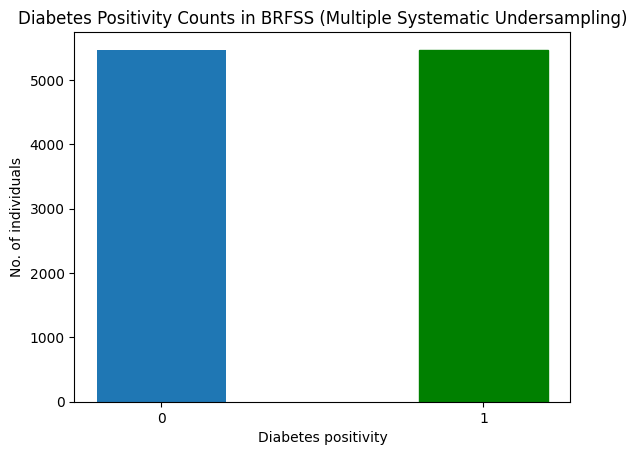

In [66]:
barlist = plt.bar([str(0),str(1)], y_S_Sy.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (Multiple Systematic Undersampling)")
plt.show()

In [67]:
print('X_S_train:',np.shape(X_S_train))
print('y_S_train:',np.shape(y_S_train))
print('X_S_test:',np.shape(X_S_test))
print('y_S_test:',np.shape(y_S_test))

X_S_train: (8753, 22)
y_S_train: (8753,)
X_S_test: (2189, 22)
y_S_test: (2189,)


In [68]:
model_source_Sy = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_141"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_987 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_988 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_989 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_990 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_991 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_992 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_993 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7


Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - AUC: 0.7280 - loss: 0.5981 - val_AUC: 0.8948 - val_loss: 0.3752
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8907 - loss: 0.3632 - val_AUC: 0.8865 - val_loss: 0.3751
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9038 - loss: 0.3349 - val_AUC: 0.8947 - val_loss: 0.3543
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9124 - loss: 0.3266 - val_AUC: 0.9159 - val_loss: 0.3324
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9145 - loss: 0.3217 - val_AUC: 0.9196 - val_loss: 0.3209
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9183 - loss: 0.3132 - val_AUC: 0.9190 - val_loss: 0.3253
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9211 - loss: 0.3108 - val_AUC: 0.9202 - val_loss: 0.3226
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9204 - loss: 0.3137 - val_AUC: 0.8996 - val_loss: 0.3467
Epoch 9/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - A

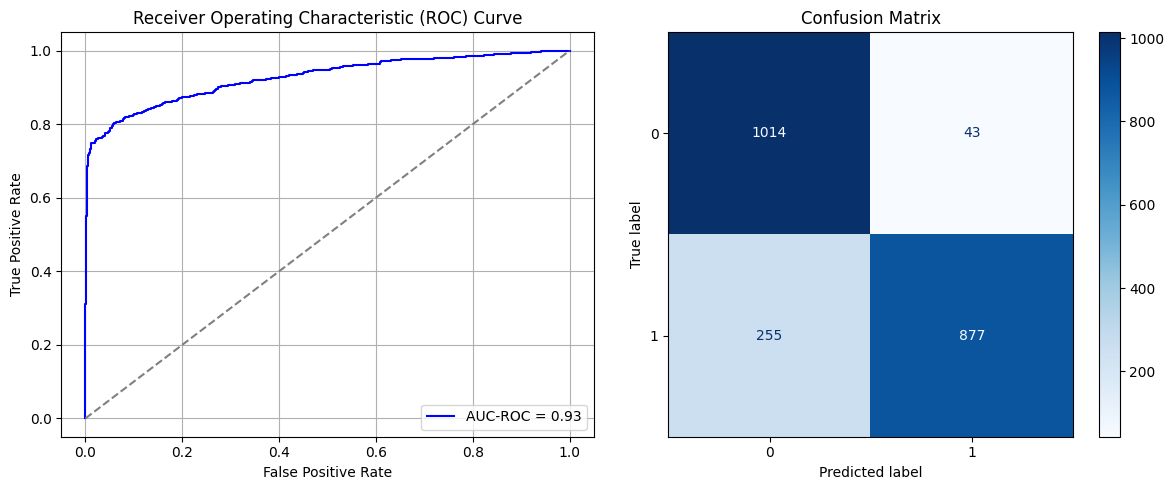

Best threshold based on F1-score: 0.38174867630004883
Time elapsed (performance): 17.10712489300022


<Sequential name=sequential_141, built=True>

In [69]:
train_and_evaluate(model_source_Sy, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
AUC-ROC: 0.6851559919994517
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.84       707
           1       0.49      0.48      0.49       227

    accuracy                           0.75       934
   macro avg       0.66      0.66      0.66       934
weighted avg       0.75      0.75      0.75       934

FPR 0.15983026874115983 TPR: 0.48017621145374445 FNR: 0.5198237885462555 TNR: 0.8401697312588402


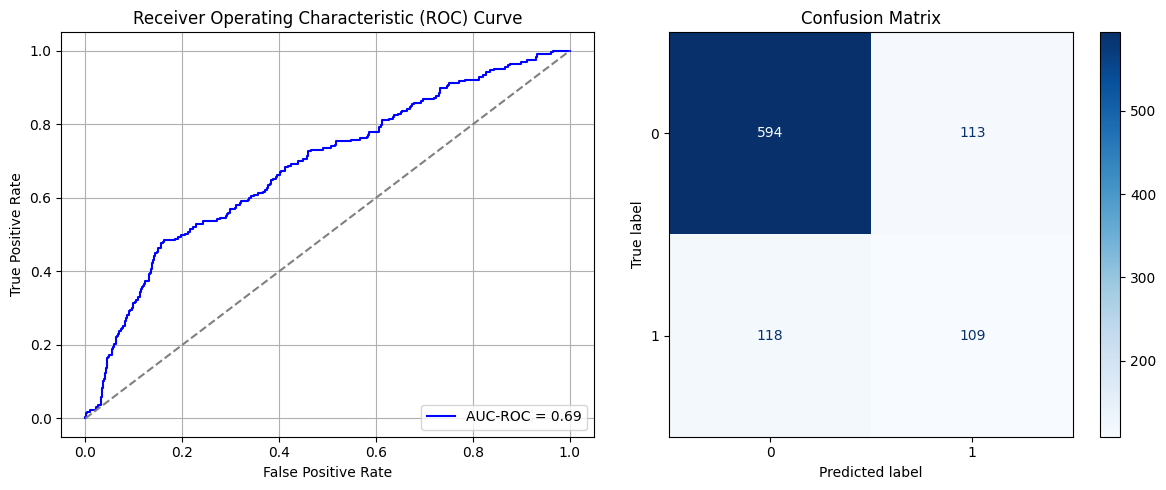

Best threshold based on F1-score: 0.4852941334247589
False Negative Rate: 0.5198237885462555
Time elapsed (performance): 0.6222473360012373


In [70]:
Transductive_TL(model_source_Sy, X_T_test, y_T_test, "Target")

In [71]:
fine_tuning(X_T_train, X_T_test, y_T_train, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_142"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_994 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_995 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_996 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_997 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_998 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_999 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1000 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - AUC: 0.6992 - loss: 0.7444 - val_AUC: 0.7231 - val_loss: 0.5010
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.7182 - loss: 0.5121 - val_AUC: 0.7286 - val_loss: 0.4917
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7161 - loss: 0.5202 - val_AUC: 0.7314 - val_loss: 0.4892
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7009 - loss: 0.5100 - val_AUC: 0.7314 - val_loss: 0.4882
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7428 - loss: 0.4904 - val_AUC: 0.7309 - val_loss: 0.4905
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7226 - loss: 0.5027 - val_AUC: 0.7317 - val_loss: 0.4882
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7099 - loss: 0.5166 - val_AUC: 0.7316 - val_loss: 0.4883
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7248 - loss: 0.5039 - val_AUC: 0.7323 - val_loss: 0.4890
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7152 - loss: 0.5064 - v

(np.float64(0.09618104667609619), np.float64(0.6475770925110133))

In [74]:
times = 50

FPR = []
FNR = []

for i in range(times):
    fpr, fnr = fine_tuning(X_T_train_Sy, X_T_test, y_T_train_Sy, y_T_test, 0, 4)
    # print(output)
    FPR.append(fpr)
    FNR.append(fnr)

ParamFit = pd.DataFrame([FPR, FNR]).T
ParamFit.columns=['FPR', 'FNR']

# fine_tuning(X_T_train_Sy, X_T_test, y_T_train_Sy, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_146"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1022 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1023 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1024 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1025 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1026 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1027 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1028 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.7309 - loss: 0.7995 - val_AUC: 0.0000e+00 - val_loss: 0.9706
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7268 - loss: 0.6500 - val_AUC: 0.0000e+00 - val_loss: 0.8517
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7561 - loss: 0.5714 - val_AUC: 0.0000e+00 - val_loss: 0.9239
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7425 - loss: 0.5786 - val_AUC: 0.0000e+00 - val_loss: 0.8811
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7424 - loss: 0.5893 - val_AUC: 0.0000e+00 - val_loss: 0.8829
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7394 - loss: 0.5827 - val_AUC: 0.0000e+00 - val_loss: 0.9109
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7303 - loss: 0.5922 - val_AUC: 0.0000e+00 - val_loss: 0.9046
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7488 - loss: 0.5727 - val_AUC: 0.0000e+00 - val_loss: 0.8683
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_147"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1029 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1030 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1031 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1032 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1033 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1034 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1035 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - AUC: 0.7297 - loss: 0.7691 - val_AUC: 0.0000e+00 - val_loss: 1.0092
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7290 - loss: 0.6573 - val_AUC: 0.0000e+00 - val_loss: 0.8648
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7393 - loss: 0.6110 - val_AUC: 0.0000e+00 - val_loss: 0.8322
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7575 - loss: 0.5701 - val_AUC: 0.0000e+00 - val_loss: 0.9193
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7418 - loss: 0.5831 - val_AUC: 0.0000e+00 - val_loss: 0.9321
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7503 - loss: 0.5711 - val_AUC: 0.0000e+00 - val_loss: 0.8535
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7613 - loss: 0.5687 - val_AUC: 0.0000e+00 - val_loss: 0.8821
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7367 - loss: 0.5913 - val_AUC: 0.0000e+00 - val_loss: 0.8684
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_148"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1036 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1037 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1038 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1039 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1040 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1041 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1042 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - AUC: 0.7323 - loss: 0.7859 - val_AUC: 0.0000e+00 - val_loss: 0.9740
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7216 - loss: 0.6458 - val_AUC: 0.0000e+00 - val_loss: 0.8984
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7747 - loss: 0.5764 - val_AUC: 0.0000e+00 - val_loss: 0.9008
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7484 - loss: 0.6078 - val_AUC: 0.0000e+00 - val_loss: 0.8689
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7473 - loss: 0.5780 - val_AUC: 0.0000e+00 - val_loss: 0.8906
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7537 - loss: 0.5725 - val_AUC: 0.0000e+00 - val_loss: 0.8748
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7359 - loss: 0.5788 - val_AUC: 0.0000e+00 - val_loss: 0.8637
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7410 - loss: 0.5893 - val_AUC: 0.0000e+00 - val_loss: 0.8649
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_149"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1043 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1044 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1045 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1046 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1047 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1048 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1049 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - AUC: 0.7179 - loss: 0.7989 - val_AUC: 0.0000e+00 - val_loss: 0.9530
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7370 - loss: 0.6153 - val_AUC: 0.0000e+00 - val_loss: 0.9436
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7571 - loss: 0.5977 - val_AUC: 0.0000e+00 - val_loss: 0.9071
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7231 - loss: 0.6105 - val_AUC: 0.0000e+00 - val_loss: 0.9238
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7138 - loss: 0.6006 - val_AUC: 0.0000e+00 - val_loss: 0.8754
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7437 - loss: 0.5748 - val_AUC: 0.0000e+00 - val_loss: 0.8525
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7393 - loss: 0.5885 - val_AUC: 0.0000e+00 - val_loss: 0.8870
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7319 - loss: 0.5728 - val_AUC: 0.0000e+00 - val_loss: 0.8653
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_150"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1050 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1051 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1052 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1053 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1054 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1055 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1056 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - AUC: 0.7297 - loss: 0.7791 - val_AUC: 0.0000e+00 - val_loss: 0.9543
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7521 - loss: 0.6204 - val_AUC: 0.0000e+00 - val_loss: 0.8911
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7310 - loss: 0.6222 - val_AUC: 0.0000e+00 - val_loss: 0.8855
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7552 - loss: 0.5828 - val_AUC: 0.0000e+00 - val_loss: 0.8497
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7545 - loss: 0.5696 - val_AUC: 0.0000e+00 - val_loss: 0.8818
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7678 - loss: 0.5543 - val_AUC: 0.0000e+00 - val_loss: 0.8632
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7270 - loss: 0.5817 - val_AUC: 0.0000e+00 - val_loss: 0.8474
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7471 - loss: 0.5734 - val_AUC: 0.0000e+00 - val_loss: 0.8390
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_151"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1057 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1058 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1059 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1060 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1061 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1062 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1063 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.7048 - loss: 0.8605 - val_AUC: 0.0000e+00 - val_loss: 0.9772
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7125 - loss: 0.6780 - val_AUC: 0.0000e+00 - val_loss: 0.8393
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7485 - loss: 0.6007 - val_AUC: 0.0000e+00 - val_loss: 0.8781
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7298 - loss: 0.6022 - val_AUC: 0.0000e+00 - val_loss: 0.8831
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7453 - loss: 0.5826 - val_AUC: 0.0000e+00 - val_loss: 0.8833
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7374 - loss: 0.5897 - val_AUC: 0.0000e+00 - val_loss: 0.8356
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7131 - loss: 0.5999 - val_AUC: 0.0000e+00 - val_loss: 0.9257
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7315 - loss: 0.5956 - val_AUC: 0.0000e+00 - val_loss: 0.9023
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_152"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1064 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1065 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1066 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1067 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1068 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1069 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1070 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - AUC: 0.6993 - loss: 0.8886 - val_AUC: 0.0000e+00 - val_loss: 0.9742
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7269 - loss: 0.6663 - val_AUC: 0.0000e+00 - val_loss: 0.8856
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7556 - loss: 0.5965 - val_AUC: 0.0000e+00 - val_loss: 0.8785
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7255 - loss: 0.5872 - val_AUC: 0.0000e+00 - val_loss: 0.8765
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7352 - loss: 0.5915 - val_AUC: 0.0000e+00 - val_loss: 0.8609
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7386 - loss: 0.5914 - val_AUC: 0.0000e+00 - val_loss: 0.8673
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7413 - loss: 0.5769 - val_AUC: 0.0000e+00 - val_loss: 0.8389
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7608 - loss: 0.5644 - val_AUC: 0.0000e+00 - val_loss: 0.9113
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_153"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1071 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1072 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1073 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1074 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1075 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1076 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1077 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - AUC: 0.7222 - loss: 0.7893 - val_AUC: 0.0000e+00 - val_loss: 0.9808
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7123 - loss: 0.6376 - val_AUC: 0.0000e+00 - val_loss: 0.8729
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7308 - loss: 0.6237 - val_AUC: 0.0000e+00 - val_loss: 0.8920
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7373 - loss: 0.5892 - val_AUC: 0.0000e+00 - val_loss: 0.8755
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7675 - loss: 0.5583 - val_AUC: 0.0000e+00 - val_loss: 0.9170
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7598 - loss: 0.5757 - val_AUC: 0.0000e+00 - val_loss: 0.9246
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7460 - loss: 0.5760 - val_AUC: 0.0000e+00 - val_loss: 0.8739
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7148 - loss: 0.5915 - val_AUC: 0.0000e+00 - val_loss: 0.8189
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_154"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1078 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1079 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1080 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1081 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1082 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1083 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1084 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - AUC: 0.7304 - loss: 0.7928 - val_AUC: 0.0000e+00 - val_loss: 0.9753
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7322 - loss: 0.6436 - val_AUC: 0.0000e+00 - val_loss: 0.9357
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7227 - loss: 0.6058 - val_AUC: 0.0000e+00 - val_loss: 0.8836
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7458 - loss: 0.5850 - val_AUC: 0.0000e+00 - val_loss: 0.8654
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7493 - loss: 0.5773 - val_AUC: 0.0000e+00 - val_loss: 0.8699
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7436 - loss: 0.5769 - val_AUC: 0.0000e+00 - val_loss: 0.8476
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7383 - loss: 0.5923 - val_AUC: 0.0000e+00 - val_loss: 0.8395
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7163 - loss: 0.6035 - val_AUC: 0.0000e+00 - val_loss: 0.8867
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_155"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1085 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1086 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1087 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1088 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1089 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1090 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1091 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 0.7212 - loss: 0.7794 - val_AUC: 0.0000e+00 - val_loss: 0.9914
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7367 - loss: 0.6504 - val_AUC: 0.0000e+00 - val_loss: 0.8938
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7488 - loss: 0.5934 - val_AUC: 0.0000e+00 - val_loss: 0.9012
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7598 - loss: 0.5803 - val_AUC: 0.0000e+00 - val_loss: 0.9068
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7546 - loss: 0.5760 - val_AUC: 0.0000e+00 - val_loss: 0.8985
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7461 - loss: 0.5881 - val_AUC: 0.0000e+00 - val_loss: 0.8937
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7591 - loss: 0.5753 - val_AUC: 0.0000e+00 - val_loss: 0.8452
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7412 - loss: 0.5720 - val_AUC: 0.0000e+00 - val_loss: 0.8657
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_156"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1092 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1093 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1094 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1095 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1096 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1097 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1098 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - AUC: 0.7244 - loss: 0.8256 - val_AUC: 0.0000e+00 - val_loss: 0.9981
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7366 - loss: 0.6519 - val_AUC: 0.0000e+00 - val_loss: 0.9006
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7432 - loss: 0.5905 - val_AUC: 0.0000e+00 - val_loss: 0.8799
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7168 - loss: 0.6134 - val_AUC: 0.0000e+00 - val_loss: 0.8648
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7524 - loss: 0.5700 - val_AUC: 0.0000e+00 - val_loss: 0.8309
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7329 - loss: 0.5755 - val_AUC: 0.0000e+00 - val_loss: 0.8491
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7365 - loss: 0.5858 - val_AUC: 0.0000e+00 - val_loss: 0.8780
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7434 - loss: 0.5737 - val_AUC: 0.0000e+00 - val_loss: 0.9001
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_157"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1099 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1100 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1101 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1102 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1103 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1104 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1105 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - AUC: 0.6964 - loss: 0.9109 - val_AUC: 0.0000e+00 - val_loss: 0.9847
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7415 - loss: 0.6306 - val_AUC: 0.0000e+00 - val_loss: 0.8960
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7540 - loss: 0.5964 - val_AUC: 0.0000e+00 - val_loss: 0.8838
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7360 - loss: 0.5913 - val_AUC: 0.0000e+00 - val_loss: 0.9018
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7431 - loss: 0.5950 - val_AUC: 0.0000e+00 - val_loss: 0.9156
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7499 - loss: 0.5712 - val_AUC: 0.0000e+00 - val_loss: 0.8133
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7283 - loss: 0.5776 - val_AUC: 0.0000e+00 - val_loss: 0.8646
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7419 - loss: 0.5704 - val_AUC: 0.0000e+00 - val_loss: 0.8461
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_158"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1106 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1107 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1108 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1109 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1110 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1111 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1112 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 0.7071 - loss: 0.8040 - val_AUC: 0.0000e+00 - val_loss: 0.9721
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - AUC: 0.6947 - loss: 0.6963 - val_AUC: 0.0000e+00 - val_loss: 0.8892
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7335 - loss: 0.5993 - val_AUC: 0.0000e+00 - val_loss: 0.8624
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7382 - loss: 0.5882 - val_AUC: 0.0000e+00 - val_loss: 0.8956
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7246 - loss: 0.5908 - val_AUC: 0.0000e+00 - val_loss: 0.8711
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7317 - loss: 0.5877 - val_AUC: 0.0000e+00 - val_loss: 0.8886
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7365 - loss: 0.5822 - val_AUC: 0.0000e+00 - val_loss: 0.8258
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7390 - loss: 0.5743 - val_AUC: 0.0000e+00 - val_loss: 0.8403
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_159"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1113 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1114 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1115 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1116 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1117 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1118 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1119 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - AUC: 0.7078 - loss: 0.8175 - val_AUC: 0.0000e+00 - val_loss: 1.0047
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7164 - loss: 0.6636 - val_AUC: 0.0000e+00 - val_loss: 0.8938
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7227 - loss: 0.6068 - val_AUC: 0.0000e+00 - val_loss: 0.8716
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7338 - loss: 0.5946 - val_AUC: 0.0000e+00 - val_loss: 0.8903
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7461 - loss: 0.5754 - val_AUC: 0.0000e+00 - val_loss: 0.8231
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7390 - loss: 0.5734 - val_AUC: 0.0000e+00 - val_loss: 0.9069
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7309 - loss: 0.5937 - val_AUC: 0.0000e+00 - val_loss: 0.8748
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7201 - loss: 0.6008 - val_AUC: 0.0000e+00 - val_loss: 0.8337
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_160"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1120 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1121 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1122 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1123 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1124 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1125 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1126 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - AUC: 0.7377 - loss: 0.7761 - val_AUC: 0.0000e+00 - val_loss: 1.0159
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7206 - loss: 0.6559 - val_AUC: 0.0000e+00 - val_loss: 0.9053
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7560 - loss: 0.5960 - val_AUC: 0.0000e+00 - val_loss: 0.9047
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7218 - loss: 0.6100 - val_AUC: 0.0000e+00 - val_loss: 0.8775
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7473 - loss: 0.5615 - val_AUC: 0.0000e+00 - val_loss: 0.8739
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7212 - loss: 0.5938 - val_AUC: 0.0000e+00 - val_loss: 0.8958
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7455 - loss: 0.5820 - val_AUC: 0.0000e+00 - val_loss: 0.8535
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7398 - loss: 0.5717 - val_AUC: 0.0000e+00 - val_loss: 0.8583
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_161"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1127 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1128 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1129 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1130 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1131 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1132 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1133 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.7376 - loss: 0.7759 - val_AUC: 0.0000e+00 - val_loss: 0.9624
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7335 - loss: 0.6185 - val_AUC: 0.0000e+00 - val_loss: 0.9204
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7596 - loss: 0.5827 - val_AUC: 0.0000e+00 - val_loss: 0.8715
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7468 - loss: 0.5849 - val_AUC: 0.0000e+00 - val_loss: 0.8632
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7378 - loss: 0.5797 - val_AUC: 0.0000e+00 - val_loss: 0.8748
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7397 - loss: 0.5934 - val_AUC: 0.0000e+00 - val_loss: 0.8814
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7416 - loss: 0.5663 - val_AUC: 0.0000e+00 - val_loss: 0.8298
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7149 - loss: 0.5910 - val_AUC: 0.0000e+00 - val_loss: 0.9127
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_162"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1134 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1135 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1136 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1137 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1138 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1139 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1140 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.7263 - loss: 0.7994 - val_AUC: 0.0000e+00 - val_loss: 0.9696
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7380 - loss: 0.6501 - val_AUC: 0.0000e+00 - val_loss: 0.8833
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7288 - loss: 0.6224 - val_AUC: 0.0000e+00 - val_loss: 0.8822
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7394 - loss: 0.5741 - val_AUC: 0.0000e+00 - val_loss: 0.8138
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7487 - loss: 0.5817 - val_AUC: 0.0000e+00 - val_loss: 0.9394
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7630 - loss: 0.5602 - val_AUC: 0.0000e+00 - val_loss: 0.8320
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7302 - loss: 0.6004 - val_AUC: 0.0000e+00 - val_loss: 0.9235
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7299 - loss: 0.5854 - val_AUC: 0.0000e+00 - val_loss: 0.9111
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_163"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1141 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1142 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1143 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1144 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1145 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1146 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1147 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - AUC: 0.7273 - loss: 0.7568 - val_AUC: 0.0000e+00 - val_loss: 1.0018
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7289 - loss: 0.6159 - val_AUC: 0.0000e+00 - val_loss: 0.8999
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7277 - loss: 0.6063 - val_AUC: 0.0000e+00 - val_loss: 0.9244
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7717 - loss: 0.5533 - val_AUC: 0.0000e+00 - val_loss: 0.8505
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7476 - loss: 0.5696 - val_AUC: 0.0000e+00 - val_loss: 0.8396
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7572 - loss: 0.5698 - val_AUC: 0.0000e+00 - val_loss: 0.9160
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7559 - loss: 0.5633 - val_AUC: 0.0000e+00 - val_loss: 0.7946
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7185 - loss: 0.5951 - val_AUC: 0.0000e+00 - val_loss: 0.8781
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_164"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1148 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1149 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1150 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1151 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1152 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1153 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1154 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - AUC: 0.7311 - loss: 0.7778 - val_AUC: 0.0000e+00 - val_loss: 0.9699
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7317 - loss: 0.6281 - val_AUC: 0.0000e+00 - val_loss: 0.8659
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7489 - loss: 0.5983 - val_AUC: 0.0000e+00 - val_loss: 0.8834
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7408 - loss: 0.5692 - val_AUC: 0.0000e+00 - val_loss: 0.8842
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7107 - loss: 0.6118 - val_AUC: 0.0000e+00 - val_loss: 0.8903
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7255 - loss: 0.5869 - val_AUC: 0.0000e+00 - val_loss: 0.9084
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7477 - loss: 0.5782 - val_AUC: 0.0000e+00 - val_loss: 0.8406
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7462 - loss: 0.5693 - val_AUC: 0.0000e+00 - val_loss: 0.8637
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_165"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1155 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1156 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1157 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1158 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1159 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1160 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1161 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - AUC: 0.7445 - loss: 0.7730 - val_AUC: 0.0000e+00 - val_loss: 0.9825
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7138 - loss: 0.6971 - val_AUC: 0.0000e+00 - val_loss: 0.9083
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7571 - loss: 0.6054 - val_AUC: 0.0000e+00 - val_loss: 0.9449
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7522 - loss: 0.5790 - val_AUC: 0.0000e+00 - val_loss: 0.8369
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7261 - loss: 0.6025 - val_AUC: 0.0000e+00 - val_loss: 0.8954
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7401 - loss: 0.5935 - val_AUC: 0.0000e+00 - val_loss: 0.8898
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7478 - loss: 0.5902 - val_AUC: 0.0000e+00 - val_loss: 0.8719
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7335 - loss: 0.5885 - val_AUC: 0.0000e+00 - val_loss: 0.8719
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_166"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1162 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1163 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1164 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1165 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1166 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1167 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1168 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - AUC: 0.7149 - loss: 0.8643 - val_AUC: 0.0000e+00 - val_loss: 0.9904
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7183 - loss: 0.6939 - val_AUC: 0.0000e+00 - val_loss: 0.8420
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7424 - loss: 0.5913 - val_AUC: 0.0000e+00 - val_loss: 0.8745
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7350 - loss: 0.6009 - val_AUC: 0.0000e+00 - val_loss: 0.8452
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7522 - loss: 0.5713 - val_AUC: 0.0000e+00 - val_loss: 0.8395
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7405 - loss: 0.5808 - val_AUC: 0.0000e+00 - val_loss: 0.8252
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7475 - loss: 0.5712 - val_AUC: 0.0000e+00 - val_loss: 0.8543
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7168 - loss: 0.5988 - val_AUC: 0.0000e+00 - val_loss: 0.8404
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_167"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1169 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1170 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1171 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1172 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1173 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1174 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1175 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - AUC: 0.7211 - loss: 0.7964 - val_AUC: 0.0000e+00 - val_loss: 0.9494
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7334 - loss: 0.6665 - val_AUC: 0.0000e+00 - val_loss: 0.8893
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7396 - loss: 0.6075 - val_AUC: 0.0000e+00 - val_loss: 0.8283
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7651 - loss: 0.5746 - val_AUC: 0.0000e+00 - val_loss: 0.9027
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7521 - loss: 0.5898 - val_AUC: 0.0000e+00 - val_loss: 0.9046
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7273 - loss: 0.5830 - val_AUC: 0.0000e+00 - val_loss: 0.8234
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7263 - loss: 0.5840 - val_AUC: 0.0000e+00 - val_loss: 0.8266
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7257 - loss: 0.5874 - val_AUC: 0.0000e+00 - val_loss: 0.9044
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_168"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1176 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1177 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1178 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1179 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1180 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1181 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1182 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 0.7286 - loss: 0.7600 - val_AUC: 0.0000e+00 - val_loss: 0.9744
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7271 - loss: 0.6255 - val_AUC: 0.0000e+00 - val_loss: 0.8944
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7430 - loss: 0.5963 - val_AUC: 0.0000e+00 - val_loss: 0.8382
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7306 - loss: 0.5964 - val_AUC: 0.0000e+00 - val_loss: 0.8387
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7443 - loss: 0.5750 - val_AUC: 0.0000e+00 - val_loss: 0.9216
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7551 - loss: 0.5643 - val_AUC: 0.0000e+00 - val_loss: 0.8249
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7334 - loss: 0.5937 - val_AUC: 0.0000e+00 - val_loss: 0.8825
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7308 - loss: 0.5815 - val_AUC: 0.0000e+00 - val_loss: 0.8122
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_169"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1183 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1184 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1185 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1186 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1187 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1188 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1189 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.7136 - loss: 0.8382 - val_AUC: 0.0000e+00 - val_loss: 0.9832
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7376 - loss: 0.6414 - val_AUC: 0.0000e+00 - val_loss: 0.9147
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7183 - loss: 0.6069 - val_AUC: 0.0000e+00 - val_loss: 0.8682
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7383 - loss: 0.5784 - val_AUC: 0.0000e+00 - val_loss: 0.8895
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7327 - loss: 0.5850 - val_AUC: 0.0000e+00 - val_loss: 0.8437
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7303 - loss: 0.5991 - val_AUC: 0.0000e+00 - val_loss: 0.8716
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7505 - loss: 0.5777 - val_AUC: 0.0000e+00 - val_loss: 0.8821
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7226 - loss: 0.5859 - val_AUC: 0.0000e+00 - val_loss: 0.8833
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_170"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1190 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1191 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1192 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1193 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1194 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1195 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1196 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 0.7156 - loss: 0.7806 - val_AUC: 0.0000e+00 - val_loss: 1.0028
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7307 - loss: 0.6473 - val_AUC: 0.0000e+00 - val_loss: 0.9382
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7550 - loss: 0.5969 - val_AUC: 0.0000e+00 - val_loss: 0.9036
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7442 - loss: 0.5869 - val_AUC: 0.0000e+00 - val_loss: 0.9213
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7529 - loss: 0.5725 - val_AUC: 0.0000e+00 - val_loss: 0.8778
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7441 - loss: 0.5755 - val_AUC: 0.0000e+00 - val_loss: 0.8896
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7577 - loss: 0.5733 - val_AUC: 0.0000e+00 - val_loss: 0.8702
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7434 - loss: 0.5771 - val_AUC: 0.0000e+00 - val_loss: 0.8587
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_171"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1197 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1198 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1199 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1200 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1201 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1202 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1203 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.7292 - loss: 0.8386 - val_AUC: 0.0000e+00 - val_loss: 0.9880
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7051 - loss: 0.6681 - val_AUC: 0.0000e+00 - val_loss: 0.9009
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7382 - loss: 0.6025 - val_AUC: 0.0000e+00 - val_loss: 0.8935
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7360 - loss: 0.5879 - val_AUC: 0.0000e+00 - val_loss: 0.8441
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7411 - loss: 0.5911 - val_AUC: 0.0000e+00 - val_loss: 0.9016
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7402 - loss: 0.5925 - val_AUC: 0.0000e+00 - val_loss: 0.9031
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7739 - loss: 0.5571 - val_AUC: 0.0000e+00 - val_loss: 0.8644
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7413 - loss: 0.5833 - val_AUC: 0.0000e+00 - val_loss: 0.8561
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_172"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1204 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1205 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1206 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1207 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1208 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1209 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1210 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - AUC: 0.7146 - loss: 0.8060 - val_AUC: 0.0000e+00 - val_loss: 0.9959
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7527 - loss: 0.6055 - val_AUC: 0.0000e+00 - val_loss: 0.8800
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7390 - loss: 0.5946 - val_AUC: 0.0000e+00 - val_loss: 0.9109
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7184 - loss: 0.6013 - val_AUC: 0.0000e+00 - val_loss: 0.9008
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7331 - loss: 0.5911 - val_AUC: 0.0000e+00 - val_loss: 0.8450
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7638 - loss: 0.5702 - val_AUC: 0.0000e+00 - val_loss: 0.9138
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7621 - loss: 0.5597 - val_AUC: 0.0000e+00 - val_loss: 0.8287
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7507 - loss: 0.5796 - val_AUC: 0.0000e+00 - val_loss: 0.8475
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_173"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1211 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1212 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1213 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1214 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1215 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1216 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1217 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - AUC: 0.7089 - loss: 0.8356 - val_AUC: 0.0000e+00 - val_loss: 0.9513
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.7143 - loss: 0.6699 - val_AUC: 0.0000e+00 - val_loss: 0.9164
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7331 - loss: 0.6039 - val_AUC: 0.0000e+00 - val_loss: 0.8761
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7428 - loss: 0.5784 - val_AUC: 0.0000e+00 - val_loss: 0.8797
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7256 - loss: 0.5947 - val_AUC: 0.0000e+00 - val_loss: 0.8690
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7227 - loss: 0.5958 - val_AUC: 0.0000e+00 - val_loss: 0.8679
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7380 - loss: 0.5945 - val_AUC: 0.0000e+00 - val_loss: 0.8957
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7475 - loss: 0.5674 - val_AUC: 0.0000e+00 - val_loss: 0.7999
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_174"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1218 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1219 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1220 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1221 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1222 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1223 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1224 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.7014 - loss: 0.8732 - val_AUC: 0.0000e+00 - val_loss: 0.9465
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7498 - loss: 0.6359 - val_AUC: 0.0000e+00 - val_loss: 0.8920
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7362 - loss: 0.6096 - val_AUC: 0.0000e+00 - val_loss: 0.8896
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7600 - loss: 0.5761 - val_AUC: 0.0000e+00 - val_loss: 0.8268
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7429 - loss: 0.5752 - val_AUC: 0.0000e+00 - val_loss: 0.8616
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7427 - loss: 0.5771 - val_AUC: 0.0000e+00 - val_loss: 0.8914
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7544 - loss: 0.5545 - val_AUC: 0.0000e+00 - val_loss: 0.8190
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7613 - loss: 0.5754 - val_AUC: 0.0000e+00 - val_loss: 0.8537
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_175"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1225 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1226 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1227 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1228 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1229 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1230 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1231 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - AUC: 0.7312 - loss: 0.8341 - val_AUC: 0.0000e+00 - val_loss: 0.9516
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7289 - loss: 0.6258 - val_AUC: 0.0000e+00 - val_loss: 0.8735
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7382 - loss: 0.6000 - val_AUC: 0.0000e+00 - val_loss: 0.9155
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7336 - loss: 0.5995 - val_AUC: 0.0000e+00 - val_loss: 0.8866
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7561 - loss: 0.5626 - val_AUC: 0.0000e+00 - val_loss: 0.8401
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7383 - loss: 0.5831 - val_AUC: 0.0000e+00 - val_loss: 0.8591
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7366 - loss: 0.5768 - val_AUC: 0.0000e+00 - val_loss: 0.8525
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7313 - loss: 0.5870 - val_AUC: 0.0000e+00 - val_loss: 0.8940
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_176"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1232 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1233 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1234 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1235 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1236 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1237 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1238 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - AUC: 0.7299 - loss: 0.7917 - val_AUC: 0.0000e+00 - val_loss: 0.9832
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7398 - loss: 0.6320 - val_AUC: 0.0000e+00 - val_loss: 0.9428
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7169 - loss: 0.6280 - val_AUC: 0.0000e+00 - val_loss: 0.8800
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7565 - loss: 0.5813 - val_AUC: 0.0000e+00 - val_loss: 0.9321
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7246 - loss: 0.5967 - val_AUC: 0.0000e+00 - val_loss: 0.9095
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7407 - loss: 0.5697 - val_AUC: 0.0000e+00 - val_loss: 0.8452
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7313 - loss: 0.5844 - val_AUC: 0.0000e+00 - val_loss: 0.8602
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7359 - loss: 0.5795 - val_AUC: 0.0000e+00 - val_loss: 0.8917
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_177"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1239 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1240 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1241 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1242 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1243 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1244 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1245 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.7172 - loss: 0.7694 - val_AUC: 0.0000e+00 - val_loss: 0.9957
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7417 - loss: 0.6173 - val_AUC: 0.0000e+00 - val_loss: 0.9106
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7240 - loss: 0.5980 - val_AUC: 0.0000e+00 - val_loss: 0.9056
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7186 - loss: 0.5967 - val_AUC: 0.0000e+00 - val_loss: 0.9062
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7559 - loss: 0.5877 - val_AUC: 0.0000e+00 - val_loss: 0.9446
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7589 - loss: 0.5642 - val_AUC: 0.0000e+00 - val_loss: 0.8445
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7445 - loss: 0.5810 - val_AUC: 0.0000e+00 - val_loss: 0.8622
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7494 - loss: 0.5744 - val_AUC: 0.0000e+00 - val_loss: 0.8819
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_178"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1246 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1247 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1248 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1249 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1250 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1251 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1252 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 0.7256 - loss: 0.7829 - val_AUC: 0.0000e+00 - val_loss: 0.9525
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7277 - loss: 0.6184 - val_AUC: 0.0000e+00 - val_loss: 0.8879
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7240 - loss: 0.6114 - val_AUC: 0.0000e+00 - val_loss: 0.9017
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7256 - loss: 0.6047 - val_AUC: 0.0000e+00 - val_loss: 0.9093
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7423 - loss: 0.5878 - val_AUC: 0.0000e+00 - val_loss: 0.9160
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7315 - loss: 0.5856 - val_AUC: 0.0000e+00 - val_loss: 0.8002
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7280 - loss: 0.5891 - val_AUC: 0.0000e+00 - val_loss: 0.9399
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7509 - loss: 0.5772 - val_AUC: 0.0000e+00 - val_loss: 0.8861
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_179"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1253 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1254 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1255 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1256 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1257 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1258 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1259 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 0.7202 - loss: 0.8877 - val_AUC: 0.0000e+00 - val_loss: 0.9711
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7346 - loss: 0.6364 - val_AUC: 0.0000e+00 - val_loss: 0.8625
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7342 - loss: 0.5924 - val_AUC: 0.0000e+00 - val_loss: 0.8924
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7491 - loss: 0.5753 - val_AUC: 0.0000e+00 - val_loss: 0.8825
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7374 - loss: 0.5856 - val_AUC: 0.0000e+00 - val_loss: 0.9101
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7387 - loss: 0.5887 - val_AUC: 0.0000e+00 - val_loss: 0.9044
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7352 - loss: 0.5878 - val_AUC: 0.0000e+00 - val_loss: 0.8891
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7288 - loss: 0.5924 - val_AUC: 0.0000e+00 - val_loss: 0.8827
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_180"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1260 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1261 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1262 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1263 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1264 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1265 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1266 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 0.7342 - loss: 0.7433 - val_AUC: 0.0000e+00 - val_loss: 0.9625
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7319 - loss: 0.6459 - val_AUC: 0.0000e+00 - val_loss: 0.9175
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7225 - loss: 0.6130 - val_AUC: 0.0000e+00 - val_loss: 0.8870
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7342 - loss: 0.5848 - val_AUC: 0.0000e+00 - val_loss: 0.8601
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7428 - loss: 0.5886 - val_AUC: 0.0000e+00 - val_loss: 0.8903
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7453 - loss: 0.5810 - val_AUC: 0.0000e+00 - val_loss: 0.9067
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7225 - loss: 0.5902 - val_AUC: 0.0000e+00 - val_loss: 0.8747
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7397 - loss: 0.5848 - val_AUC: 0.0000e+00 - val_loss: 0.9051
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_181"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1267 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1268 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1269 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1270 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1271 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1272 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1273 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - AUC: 0.7032 - loss: 0.8344 - val_AUC: 0.0000e+00 - val_loss: 0.9524
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.7366 - loss: 0.6325 - val_AUC: 0.0000e+00 - val_loss: 0.8879
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7362 - loss: 0.6019 - val_AUC: 0.0000e+00 - val_loss: 0.8267
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7446 - loss: 0.5858 - val_AUC: 0.0000e+00 - val_loss: 0.9414
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7393 - loss: 0.5910 - val_AUC: 0.0000e+00 - val_loss: 0.8541
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7431 - loss: 0.5666 - val_AUC: 0.0000e+00 - val_loss: 0.8764
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7108 - loss: 0.5997 - val_AUC: 0.0000e+00 - val_loss: 0.9207
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7147 - loss: 0.5926 - val_AUC: 0.0000e+00 - val_loss: 0.8625
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_182"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1274 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1275 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1276 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1277 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1278 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1279 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1280 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.7223 - loss: 0.8183 - val_AUC: 0.0000e+00 - val_loss: 0.9715
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7260 - loss: 0.6535 - val_AUC: 0.0000e+00 - val_loss: 0.9659
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7069 - loss: 0.6189 - val_AUC: 0.0000e+00 - val_loss: 0.8645
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7627 - loss: 0.5567 - val_AUC: 0.0000e+00 - val_loss: 0.8641
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7490 - loss: 0.5883 - val_AUC: 0.0000e+00 - val_loss: 0.9120
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7445 - loss: 0.5816 - val_AUC: 0.0000e+00 - val_loss: 0.8906
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7439 - loss: 0.5739 - val_AUC: 0.0000e+00 - val_loss: 0.8366
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7373 - loss: 0.5888 - val_AUC: 0.0000e+00 - val_loss: 0.8902
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_183"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1281 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1282 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1283 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1284 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1285 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1286 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1287 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - AUC: 0.7197 - loss: 0.8446 - val_AUC: 0.0000e+00 - val_loss: 0.9484
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7639 - loss: 0.6179 - val_AUC: 0.0000e+00 - val_loss: 0.8961
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7400 - loss: 0.5974 - val_AUC: 0.0000e+00 - val_loss: 0.9230
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7383 - loss: 0.5960 - val_AUC: 0.0000e+00 - val_loss: 0.8717
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7316 - loss: 0.5806 - val_AUC: 0.0000e+00 - val_loss: 0.8098
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7410 - loss: 0.5844 - val_AUC: 0.0000e+00 - val_loss: 0.8997
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7483 - loss: 0.5917 - val_AUC: 0.0000e+00 - val_loss: 0.8718
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7401 - loss: 0.5805 - val_AUC: 0.0000e+00 - val_loss: 0.8911
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_184"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1288 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1289 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1290 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1291 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1292 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1293 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1294 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - AUC: 0.7523 - loss: 0.7548 - val_AUC: 0.0000e+00 - val_loss: 1.0080
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7343 - loss: 0.6356 - val_AUC: 0.0000e+00 - val_loss: 0.8908
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7082 - loss: 0.6312 - val_AUC: 0.0000e+00 - val_loss: 0.9421
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7328 - loss: 0.5868 - val_AUC: 0.0000e+00 - val_loss: 0.8524
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7238 - loss: 0.5950 - val_AUC: 0.0000e+00 - val_loss: 0.8553
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7335 - loss: 0.5925 - val_AUC: 0.0000e+00 - val_loss: 0.8374
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7123 - loss: 0.6082 - val_AUC: 0.0000e+00 - val_loss: 0.9426
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7441 - loss: 0.5843 - val_AUC: 0.0000e+00 - val_loss: 0.9254
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_185"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1295 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1296 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1297 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1298 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1299 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1300 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1301 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - AUC: 0.7307 - loss: 0.7749 - val_AUC: 0.0000e+00 - val_loss: 0.9983
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7291 - loss: 0.6201 - val_AUC: 0.0000e+00 - val_loss: 0.9016
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7458 - loss: 0.6076 - val_AUC: 0.0000e+00 - val_loss: 0.8628
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7380 - loss: 0.5879 - val_AUC: 0.0000e+00 - val_loss: 0.9169
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7557 - loss: 0.5668 - val_AUC: 0.0000e+00 - val_loss: 0.8789
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7522 - loss: 0.5699 - val_AUC: 0.0000e+00 - val_loss: 0.8751
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7397 - loss: 0.5914 - val_AUC: 0.0000e+00 - val_loss: 0.9221
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7481 - loss: 0.5706 - val_AUC: 0.0000e+00 - val_loss: 0.8246
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_186"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1302 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1303 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1304 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1305 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1306 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1307 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1308 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - AUC: 0.7243 - loss: 0.8279 - val_AUC: 0.0000e+00 - val_loss: 0.9521
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.7321 - loss: 0.6687 - val_AUC: 0.0000e+00 - val_loss: 0.8909
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7127 - loss: 0.6297 - val_AUC: 0.0000e+00 - val_loss: 0.8691
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7364 - loss: 0.5906 - val_AUC: 0.0000e+00 - val_loss: 0.8880
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7151 - loss: 0.6158 - val_AUC: 0.0000e+00 - val_loss: 0.9003
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7513 - loss: 0.5694 - val_AUC: 0.0000e+00 - val_loss: 0.8987
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7422 - loss: 0.5871 - val_AUC: 0.0000e+00 - val_loss: 0.9296
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7391 - loss: 0.5917 - val_AUC: 0.0000e+00 - val_loss: 0.8905
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_187"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1309 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1310 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1311 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1312 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1313 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1314 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1315 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 0.7214 - loss: 0.7839 - val_AUC: 0.0000e+00 - val_loss: 0.9987
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7313 - loss: 0.6658 - val_AUC: 0.0000e+00 - val_loss: 0.8809
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7369 - loss: 0.6015 - val_AUC: 0.0000e+00 - val_loss: 0.9327
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7435 - loss: 0.5900 - val_AUC: 0.0000e+00 - val_loss: 0.8641
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7316 - loss: 0.5983 - val_AUC: 0.0000e+00 - val_loss: 0.9278
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7499 - loss: 0.5872 - val_AUC: 0.0000e+00 - val_loss: 0.9014
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7494 - loss: 0.5698 - val_AUC: 0.0000e+00 - val_loss: 0.8218
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7287 - loss: 0.5731 - val_AUC: 0.0000e+00 - val_loss: 0.8476
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_188"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1316 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1317 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1318 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1319 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1320 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1321 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1322 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - AUC: 0.7026 - loss: 0.7955 - val_AUC: 0.0000e+00 - val_loss: 0.9646
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.7358 - loss: 0.6597 - val_AUC: 0.0000e+00 - val_loss: 0.8984
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7362 - loss: 0.6020 - val_AUC: 0.0000e+00 - val_loss: 0.8799
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7288 - loss: 0.5935 - val_AUC: 0.0000e+00 - val_loss: 0.9490
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7251 - loss: 0.5951 - val_AUC: 0.0000e+00 - val_loss: 0.8754
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7316 - loss: 0.5944 - val_AUC: 0.0000e+00 - val_loss: 0.8648
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7189 - loss: 0.5944 - val_AUC: 0.0000e+00 - val_loss: 0.8856
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7343 - loss: 0.5763 - val_AUC: 0.0000e+00 - val_loss: 0.8090
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_189"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1323 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1324 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1325 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1326 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1327 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1328 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1329 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - AUC: 0.7264 - loss: 0.7737 - val_AUC: 0.0000e+00 - val_loss: 1.0416
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7179 - loss: 0.6744 - val_AUC: 0.0000e+00 - val_loss: 0.8764
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7421 - loss: 0.6036 - val_AUC: 0.0000e+00 - val_loss: 0.8936
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7341 - loss: 0.5966 - val_AUC: 0.0000e+00 - val_loss: 0.8600
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7199 - loss: 0.5982 - val_AUC: 0.0000e+00 - val_loss: 0.8428
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7390 - loss: 0.5734 - val_AUC: 0.0000e+00 - val_loss: 0.8794
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7386 - loss: 0.5768 - val_AUC: 0.0000e+00 - val_loss: 0.8652
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7388 - loss: 0.5837 - val_AUC: 0.0000e+00 - val_loss: 0.8352
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_190"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1330 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1331 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1332 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1333 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1334 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1335 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1336 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - AUC: 0.7088 - loss: 0.8343 - val_AUC: 0.0000e+00 - val_loss: 0.9889
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7238 - loss: 0.6406 - val_AUC: 0.0000e+00 - val_loss: 0.8472
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7307 - loss: 0.6080 - val_AUC: 0.0000e+00 - val_loss: 0.8891
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7401 - loss: 0.5863 - val_AUC: 0.0000e+00 - val_loss: 0.8830
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7351 - loss: 0.5955 - val_AUC: 0.0000e+00 - val_loss: 0.9501
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7368 - loss: 0.5885 - val_AUC: 0.0000e+00 - val_loss: 0.8651
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7443 - loss: 0.5784 - val_AUC: 0.0000e+00 - val_loss: 0.8694
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7534 - loss: 0.5599 - val_AUC: 0.0000e+00 - val_loss: 0.8559
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_191"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1337 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1338 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1339 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1340 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1341 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1342 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1343 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - AUC: 0.7178 - loss: 0.8246 - val_AUC: 0.0000e+00 - val_loss: 0.9816
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7141 - loss: 0.6482 - val_AUC: 0.0000e+00 - val_loss: 0.8863
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7365 - loss: 0.6152 - val_AUC: 0.0000e+00 - val_loss: 0.8957
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7382 - loss: 0.5857 - val_AUC: 0.0000e+00 - val_loss: 0.9086
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7140 - loss: 0.5988 - val_AUC: 0.0000e+00 - val_loss: 0.8948
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7450 - loss: 0.5725 - val_AUC: 0.0000e+00 - val_loss: 0.8786
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7091 - loss: 0.5922 - val_AUC: 0.0000e+00 - val_loss: 0.8432
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7314 - loss: 0.5987 - val_AUC: 0.0000e+00 - val_loss: 0.9169
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_192"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1344 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1345 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1346 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1347 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1348 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1349 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1350 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 0.7294 - loss: 0.7477 - val_AUC: 0.0000e+00 - val_loss: 0.9509
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7239 - loss: 0.6303 - val_AUC: 0.0000e+00 - val_loss: 0.9003
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7292 - loss: 0.6154 - val_AUC: 0.0000e+00 - val_loss: 0.8783
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7492 - loss: 0.5935 - val_AUC: 0.0000e+00 - val_loss: 0.9072
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7600 - loss: 0.5692 - val_AUC: 0.0000e+00 - val_loss: 0.8315
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7403 - loss: 0.5764 - val_AUC: 0.0000e+00 - val_loss: 0.8781
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7126 - loss: 0.5987 - val_AUC: 0.0000e+00 - val_loss: 0.8872
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7472 - loss: 0.5860 - val_AUC: 0.0000e+00 - val_loss: 0.9414
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_193"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1351 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1352 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1353 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1354 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1355 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1356 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1357 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - AUC: 0.7165 - loss: 0.8139 - val_AUC: 0.0000e+00 - val_loss: 0.9831
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7571 - loss: 0.6035 - val_AUC: 0.0000e+00 - val_loss: 0.8829
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7626 - loss: 0.5928 - val_AUC: 0.0000e+00 - val_loss: 0.8993
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7598 - loss: 0.5659 - val_AUC: 0.0000e+00 - val_loss: 0.9275
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7162 - loss: 0.6061 - val_AUC: 0.0000e+00 - val_loss: 0.9079
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7348 - loss: 0.5781 - val_AUC: 0.0000e+00 - val_loss: 0.9025
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7433 - loss: 0.5917 - val_AUC: 0.0000e+00 - val_loss: 0.9197
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7273 - loss: 0.5815 - val_AUC: 0.0000e+00 - val_loss: 0.8152
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_194"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1358 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1359 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1360 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1361 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1362 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1363 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1364 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - AUC: 0.7232 - loss: 0.8357 - val_AUC: 0.0000e+00 - val_loss: 0.9471
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7051 - loss: 0.6845 - val_AUC: 0.0000e+00 - val_loss: 0.9338
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7333 - loss: 0.5969 - val_AUC: 0.0000e+00 - val_loss: 0.9133
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7464 - loss: 0.5785 - val_AUC: 0.0000e+00 - val_loss: 0.8825
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7347 - loss: 0.5894 - val_AUC: 0.0000e+00 - val_loss: 0.8713
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7338 - loss: 0.5951 - val_AUC: 0.0000e+00 - val_loss: 0.8951
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7294 - loss: 0.5986 - val_AUC: 0.0000e+00 - val_loss: 0.8915
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7637 - loss: 0.5649 - val_AUC: 0.0000e+00 - val_loss: 0.8722
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_195"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1365 (Dense)              │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1366 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1367 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1368 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1369 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1370 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1371 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - AUC: 0.7405 - loss: 0.7607 - val_AUC: 0.0000e+00 - val_loss: 0.9617
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.7207 - loss: 0.6572 - val_AUC: 0.0000e+00 - val_loss: 0.8792
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7476 - loss: 0.6093 - val_AUC: 0.0000e+00 - val_loss: 0.8776
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7443 - loss: 0.5823 - val_AUC: 0.0000e+00 - val_loss: 0.8988
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7142 - loss: 0.6000 - val_AUC: 0.0000e+00 - val_loss: 0.8704
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7472 - loss: 0.5740 - val_AUC: 0.0000e+00 - val_loss: 0.8842
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7457 - loss: 0.5773 - val_AUC: 0.0000e+00 - val_loss: 0.9105
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7550 - loss: 0.5704 - val_AUC: 0.0000e+00 - val_loss: 0.8615
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

In [77]:
print(ParamFit)
ParamFit.to_csv('Sy_multi_Fine_Tuning.csv')

         FPR       FNR
0   0.134371  0.577093
1   0.134371  0.577093
2   0.131542  0.585903
3   0.132956  0.577093
4   0.131542  0.585903
5   0.134371  0.577093
6   0.134371  0.572687
7   0.130127  0.585903
8   0.131542  0.585903
9   0.134371  0.577093
10  0.130127  0.585903
11  0.131542  0.581498
12  0.134371  0.577093
13  0.125884  0.585903
14  0.131542  0.585903
15  0.131542  0.581498
16  0.132956  0.577093
17  0.130127  0.585903
18  0.131542  0.585903
19  0.131542  0.585903
20  0.123055  0.585903
21  0.132956  0.581498
22  0.137199  0.572687
23  0.134371  0.577093
24  0.134371  0.577093
25  0.130127  0.585903
26  0.137199  0.572687
27  0.131542  0.581498
28  0.134371  0.577093
29  0.134371  0.572687
30  0.137199  0.572687
31  0.131542  0.577093
32  0.132956  0.577093
33  0.131542  0.585903
34  0.131542  0.577093
35  0.131542  0.581498
36  0.134371  0.572687
37  0.132956  0.577093
38  0.141443  0.563877
39  0.131542  0.581498
40  0.127298  0.581498
41  0.131542  0.585903
42  0.13154

# Random Oversampling (ROS):

## Simple Random Sampling with Replacement:

In this case, we investigate the effectiveness of Random Oversampling methods, beginning with Simple Random Sampling (SRS) with replacement. For this, we perform random resampling from the minority class of size $N_1$ to generate an additional sample of size $N_0-N_1$, such that the oversampled minority class will have the same size as the majority class.

In [ ]:
X_S_SRS, y_S_SRS = SRSwR_oversampler(data_S_full, data_S_full['Diabetes_binary'])
print(y_S_SRS)

X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_Sy, y_S_Sy, test_size=0.20, random_state=0)
X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(data_T_X, data_T_y, test_size=0.20, random_state=0)
T_train = pd.concat([X_T_train, y_T_train], axis=1)

X_T_train_SRS, y_T_train_SRS = SRSwR_oversampler(T_train, T_train[6])
print(y_T_train_Sy)

31820
208165
0         0
1         0
2         0
4         0
5         0
         ..
41447     1
20037     1
174108    1
225124    1
153448    1
Name: Diabetes_binary, Length: 416330, dtype: int64
1964
8992
250526    0.0
23116     0.0
33894     0.0
84067     0.0
16709     0.0
         ... 
47021     1.0
197392    1.0
59357     1.0
156689    1.0
45219     1.0
Name: 6, Length: 3924, dtype: float64


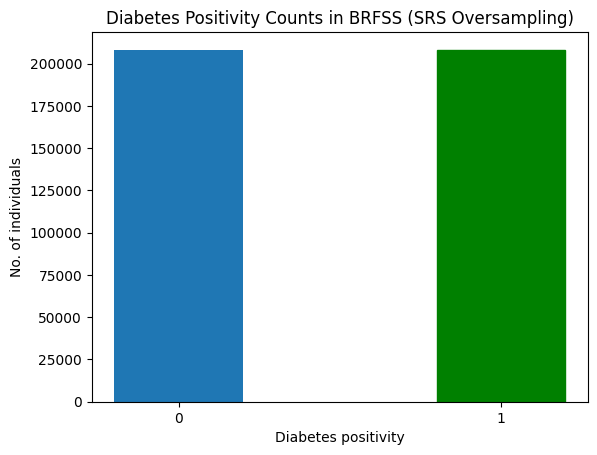

In [ ]:
barlist = plt.bar([str(0),str(1)], y_S_SRS.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (SRS Oversampling)")
plt.show()

In [ ]:
model_source_SRS_ROS = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_273"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1911 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1912 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1913 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1914 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1915 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1916 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1917 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7


Epoch 1/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7850 - loss: 0.5523 - val_AUC: 0.8223 - val_loss: 0.5162
Epoch 2/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - AUC: 0.8206 - loss: 0.5121 - val_AUC: 0.8280 - val_loss: 0.5108
Epoch 3/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - AUC: 0.8285 - loss: 0.5032 - val_AUC: 0.8298 - val_loss: 0.5046
Epoch 4/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - AUC: 0.8306 - loss: 0.5001 - val_AUC: 0.8312 - val_loss: 0.5047
Epoch 5/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8312 - loss: 0.5002 - val_AUC: 0.8303 - val_loss: 0.5042
Epoch 6/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8278 - loss: 0.5046 - val_AUC: 0.8316 - val_loss: 0.5052
Epoch 7/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8343 - loss: 0.4959 - val_AUC: 0.8336 - val_loss: 0.5136
Epoch 8/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8364 - loss: 0.4924 - val_AUC: 0.8328 - val_loss: 0.5005
Epoch 9/10
1273/1273 ━━━━━━━━━━━━━━━━━━━

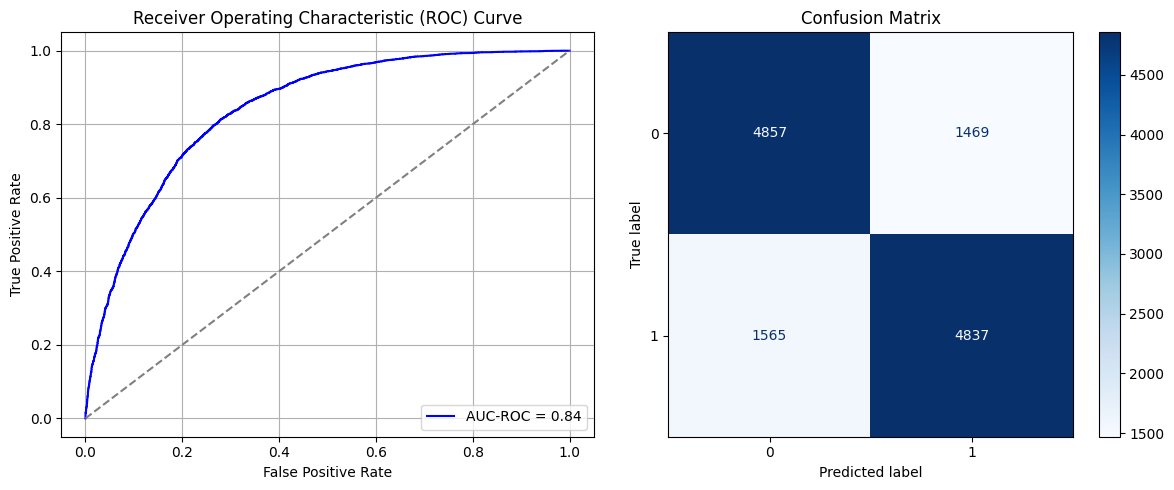

Best threshold based on F1-score: 0.3860374689102173
Time elapsed (performance): 58.95120449600017


<Sequential name=sequential_273, built=True>

In [ ]:
train_and_evaluate(model_source_SRS_ROS, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
AUC-ROC: 0.7283927751824011
Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.42      0.58      2278
         1.0       0.23      0.87      0.37       461

    accuracy                           0.50      2739
   macro avg       0.59      0.65      0.48      2739
weighted avg       0.82      0.50      0.55      2739

FPR 0.5798946444249341 TPR: 0.8741865509761388 FNR: 0.12581344902386118 TNR: 0.4201053555750659


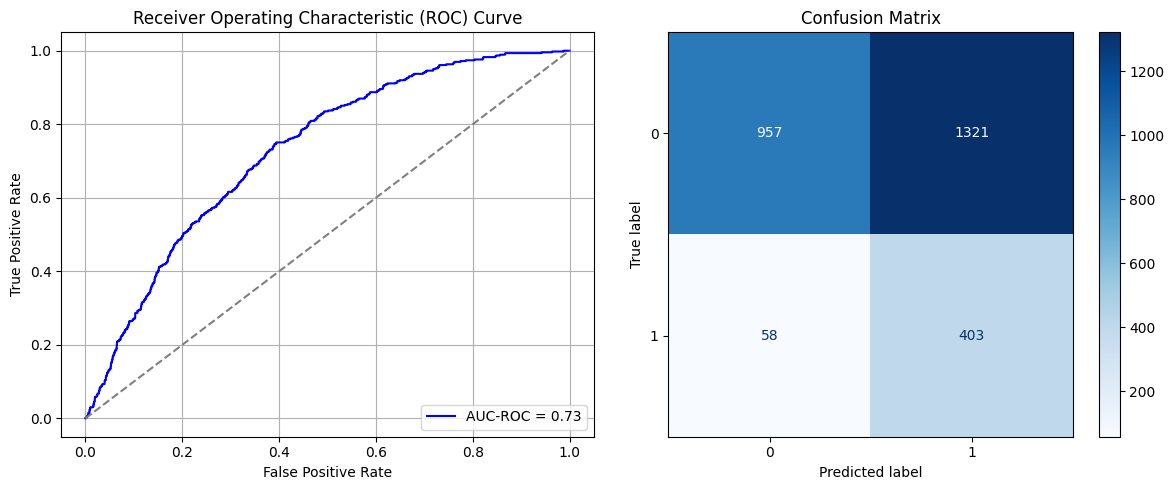

Best threshold based on F1-score: 0.9981775879859924
False Negative Rate: 0.12581344902386118
Time elapsed (performance): 0.7269353350002348


<ipython-input-16-de1f6cb50f3b>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [ ]:
Transductive_TL(model_source_SRS_ROS, X_T_test, y_T_test, "Target")

In [ ]:
fine_tuning(X_T_train, X_T_test, y_T_train, y_T_test, 0, 4)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_274"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1918 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1919 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1920 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1921 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1922 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1923 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1924 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.6736 - loss: 0.6033 - val_AUC: 0.6925 - val_loss: 0.4562
Epoch 2/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7177 - loss: 0.4212 - val_AUC: 0.6962 - val_loss: 0.4484
Epoch 3/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7135 - loss: 0.4253 - val_AUC: 0.6970 - val_loss: 0.4455
Epoch 4/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7334 - loss: 0.4206 - val_AUC: 0.6975 - val_loss: 0.4445
Epoch 5/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7315 - loss: 0.4167 - val_AUC: 0.6991 - val_loss: 0.4452
Epoch 6/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7380 - loss: 0.4129 - val_AUC: 0.7002 - val_loss: 0.4432
Epoch 7/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7198 - loss: 0.4146 - val_AUC: 0.7006 - val_loss: 0.4424
Epoch 8/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7370 - loss: 0.4130 - val_AUC: 0.7015 - val_loss: 0.4427
Epoch 9/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7162 -

(0.0004389815627743635, 1.0)

In [ ]:
times = 50

FPR = []
FNR = []

for i in range(times):
    fpr, fnr = fine_tuning(X_T_train_SRS, X_T_test, y_T_train_SRS, y_T_test, 0, 4)
    # print(output)
    FPR.append(fpr)
    FNR.append(fnr)

ParamFit = pd.DataFrame([FPR, FNR]).T
ParamFit.columns=['FPR', 'FNR']

# fine_tuning(X_T_train_SRS, X_T_test, y_T_train_SRS, y_T_test, 0, 4)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_275"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1925 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1926 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1927 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1928 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1929 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1930 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1931 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7090 - loss: 0.6247 - val_AUC: 0.0000e+00 - val_loss: 0.7923
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7198 - loss: 0.5847 - val_AUC: 0.0000e+00 - val_loss: 0.8603
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7254 - loss: 0.5767 - val_AUC: 0.0000e+00 - val_loss: 0.8159
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7296 - loss: 0.5821 - val_AUC: 0.0000e+00 - val_loss: 0.8739
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7255 - loss: 0.5807 - val_AUC: 0.0000e+00 - val_loss: 0.8171
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7303 - loss: 0.5759 - val_AUC: 0.0000e+00 - val_loss: 0.8628
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7248 - loss: 0.5784 - val_AUC: 0.0000e+00 - val_loss: 0.8068
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7258 - loss: 0.5806 - val_AUC: 0.0000e+00 - val_loss: 0.7969
Epoch 9/10
450/450 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_276"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1932 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1933 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1934 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1935 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1936 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1937 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1938 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7200 - loss: 0.6110 - val_AUC: 0.0000e+00 - val_loss: 0.7779
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7245 - loss: 0.5841 - val_AUC: 0.0000e+00 - val_loss: 0.8010
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7202 - loss: 0.5846 - val_AUC: 0.0000e+00 - val_loss: 0.8647
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7268 - loss: 0.5827 - val_AUC: 0.0000e+00 - val_loss: 0.8153
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7171 - loss: 0.5855 - val_AUC: 0.0000e+00 - val_loss: 0.8361
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7216 - loss: 0.5842 - val_AUC: 0.0000e+00 - val_loss: 0.8687
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7285 - loss: 0.5791 - val_AUC: 0.0000e+00 - val_loss: 0.8320
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7258 - loss: 0.5825 - val_AUC: 0.0000e+00 - val_loss: 0.8659
Epoch 9/10
450/450 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_277"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1939 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1940 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1941 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1942 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1943 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1944 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1945 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7066 - loss: 0.6288 - val_AUC: 0.0000e+00 - val_loss: 0.8708
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7189 - loss: 0.5860 - val_AUC: 0.0000e+00 - val_loss: 0.8413
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7209 - loss: 0.5826 - val_AUC: 0.0000e+00 - val_loss: 0.8241
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7307 - loss: 0.5779 - val_AUC: 0.0000e+00 - val_loss: 0.8654
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7260 - loss: 0.5788 - val_AUC: 0.0000e+00 - val_loss: 0.7962
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.7234 - loss: 0.5788 - val_AUC: 0.0000e+00 - val_loss: 0.8083
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.7238 - loss: 0.5844 - val_AUC: 0.0000e+00 - val_loss: 0.8688
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.7272 - loss: 0.5805 - val_AUC: 0.0000e+00 - val_loss: 0.8394
Epoch 9/10
450/450 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_278"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1946 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1947 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1948 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1949 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1950 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1951 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1952 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7070 - loss: 0.6238 - val_AUC: 0.0000e+00 - val_loss: 0.7744
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7231 - loss: 0.5849 - val_AUC: 0.0000e+00 - val_loss: 0.8585
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7264 - loss: 0.5813 - val_AUC: 0.0000e+00 - val_loss: 0.8565
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7246 - loss: 0.5814 - val_AUC: 0.0000e+00 - val_loss: 0.8049
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7333 - loss: 0.5732 - val_AUC: 0.0000e+00 - val_loss: 0.8753
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7280 - loss: 0.5788 - val_AUC: 0.0000e+00 - val_loss: 0.9140
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7276 - loss: 0.5787 - val_AUC: 0.0000e+00 - val_loss: 0.8549
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AU

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_279"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1953 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1954 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1955 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1956 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1957 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1958 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1959 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7099 - loss: 0.6252 - val_AUC: 0.0000e+00 - val_loss: 0.8318
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7234 - loss: 0.5816 - val_AUC: 0.0000e+00 - val_loss: 0.8132
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7264 - loss: 0.5841 - val_AUC: 0.0000e+00 - val_loss: 0.9146
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7224 - loss: 0.5844 - val_AUC: 0.0000e+00 - val_loss: 0.8165
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7267 - loss: 0.5778 - val_AUC: 0.0000e+00 - val_loss: 0.8099
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7195 - loss: 0.5841 - val_AUC: 0.0000e+00 - val_loss: 0.8624
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7291 - loss: 0.5801 - val_AUC: 0.0000e+00 - val_loss: 0.8194
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7289 - loss: 0.5801 - val_AUC: 0.0000e+00 - val_loss: 0.8183
Epoch 9/10
450/450 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_280"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1960 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1961 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1962 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1963 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1964 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1965 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1966 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7077 - loss: 0.6245 - val_AUC: 0.0000e+00 - val_loss: 0.7977
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7184 - loss: 0.5842 - val_AUC: 0.0000e+00 - val_loss: 0.7808
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7231 - loss: 0.5813 - val_AUC: 0.0000e+00 - val_loss: 0.8228
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7288 - loss: 0.5810 - val_AUC: 0.0000e+00 - val_loss: 0.7951
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7201 - loss: 0.5851 - val_AUC: 0.0000e+00 - val_loss: 0.8669
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7270 - loss: 0.5791 - val_AUC: 0.0000e+00 - val_loss: 0.8499
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7190 - loss: 0.5825 - val_AUC: 0.0000e+00 - val_loss: 0.7981
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7274 - loss: 0.5742 - val_AUC: 0.0000e+00 - val_loss: 0.7967
Epoch 9/10
450/450 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_281"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1967 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1968 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1969 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1970 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1971 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1972 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1973 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7036 - loss: 0.6296 - val_AUC: 0.0000e+00 - val_loss: 0.8422
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7189 - loss: 0.5839 - val_AUC: 0.0000e+00 - val_loss: 0.7706
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7213 - loss: 0.5846 - val_AUC: 0.0000e+00 - val_loss: 0.8183
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7228 - loss: 0.5823 - val_AUC: 0.0000e+00 - val_loss: 0.8191
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7250 - loss: 0.5826 - val_AUC: 0.0000e+00 - val_loss: 0.8511
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7303 - loss: 0.5746 - val_AUC: 0.0000e+00 - val_loss: 0.8271
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7238 - loss: 0.5804 - val_AUC: 0.0000e+00 - val_loss: 0.8547
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7343 - loss: 0.5758 - val_AUC: 0.0000e+00 - val_loss: 0.8499
Epoch 9/10
450/450 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_282"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1974 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1975 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1976 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1977 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1978 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1979 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1980 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7018 - loss: 0.6272 - val_AUC: 0.0000e+00 - val_loss: 0.7949
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7248 - loss: 0.5843 - val_AUC: 0.0000e+00 - val_loss: 0.8566
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7235 - loss: 0.5821 - val_AUC: 0.0000e+00 - val_loss: 0.8464
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7288 - loss: 0.5785 - val_AUC: 0.0000e+00 - val_loss: 0.8148
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7300 - loss: 0.5761 - val_AUC: 0.0000e+00 - val_loss: 0.8606
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7219 - loss: 0.5829 - val_AUC: 0.0000e+00 - val_loss: 0.7815
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7291 - loss: 0.5763 - val_AUC: 0.0000e+00 - val_loss: 0.8378
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7268 - loss: 0.5794 - val_AUC: 0.0000e+00 - val_loss: 0.8611
Epoch 9/10
450/450 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_283"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1981 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1982 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1983 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1984 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1985 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1986 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1987 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7000 - loss: 0.6298 - val_AUC: 0.0000e+00 - val_loss: 0.8188
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7161 - loss: 0.5881 - val_AUC: 0.0000e+00 - val_loss: 0.8861
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7169 - loss: 0.5871 - val_AUC: 0.0000e+00 - val_loss: 0.8277
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7245 - loss: 0.5798 - val_AUC: 0.0000e+00 - val_loss: 0.8339
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7210 - loss: 0.5830 - val_AUC: 0.0000e+00 - val_loss: 0.8524
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7318 - loss: 0.5715 - val_AUC: 0.0000e+00 - val_loss: 0.7678
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7281 - loss: 0.5773 - val_AUC: 0.0000e+00 - val_loss: 0.7996
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7219 - loss: 0.5829 - val_AUC: 0.0000e+00 - val_loss: 0.7794
Epoch 9/10
450/450 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_284"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1988 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1989 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1990 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1991 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1992 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1993 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1994 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7103 - loss: 0.6209 - val_AUC: 0.0000e+00 - val_loss: 0.8071
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7216 - loss: 0.5864 - val_AUC: 0.0000e+00 - val_loss: 0.8101
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7255 - loss: 0.5793 - val_AUC: 0.0000e+00 - val_loss: 0.7800
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7207 - loss: 0.5840 - val_AUC: 0.0000e+00 - val_loss: 0.8284
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7122 - loss: 0.5863 - val_AUC: 0.0000e+00 - val_loss: 0.8444
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7214 - loss: 0.5865 - val_AUC: 0.0000e+00 - val_loss: 0.8995
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7302 - loss: 0.5745 - val_AUC: 0.0000e+00 - val_loss: 0.8490
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7299 - loss: 0.5790 - val_AUC: 0.0000e+00 - val_loss: 0.8717
Epoch 9/10
450/450 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_285"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1995 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1996 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1997 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1998 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1999 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2000 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2001 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7074 - loss: 0.6242 - val_AUC: 0.0000e+00 - val_loss: 0.8315
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7164 - loss: 0.5859 - val_AUC: 0.0000e+00 - val_loss: 0.8182
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7251 - loss: 0.5823 - val_AUC: 0.0000e+00 - val_loss: 0.8285
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7313 - loss: 0.5794 - val_AUC: 0.0000e+00 - val_loss: 0.8573
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7187 - loss: 0.5845 - val_AUC: 0.0000e+00 - val_loss: 0.8288
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7231 - loss: 0.5804 - val_AUC: 0.0000e+00 - val_loss: 0.7867
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7276 - loss: 0.5766 - val_AUC: 0.0000e+00 - val_loss: 0.8278
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7260 - loss: 0.5788 - val_AUC: 0.0000e+00 - val_loss: 0.8206
Epoch 9/10
450/450 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_286"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2002 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2003 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2004 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2005 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2006 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2007 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2008 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7111 - loss: 0.6237 - val_AUC: 0.0000e+00 - val_loss: 0.8718
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7177 - loss: 0.5827 - val_AUC: 0.0000e+00 - val_loss: 0.8290
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7196 - loss: 0.5855 - val_AUC: 0.0000e+00 - val_loss: 0.8708
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7130 - loss: 0.5867 - val_AUC: 0.0000e+00 - val_loss: 0.7899
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7256 - loss: 0.5770 - val_AUC: 0.0000e+00 - val_loss: 0.7822
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7258 - loss: 0.5783 - val_AUC: 0.0000e+00 - val_loss: 0.8200
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7315 - loss: 0.5798 - val_AUC: 0.0000e+00 - val_loss: 0.8694
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7213 - loss: 0.5812 - val_AUC: 0.0000e+00 - val_loss: 0.8548
Epoch 9/10
450/450 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_287"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2009 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2010 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2011 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2012 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2013 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2014 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2015 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7079 - loss: 0.6253 - val_AUC: 0.0000e+00 - val_loss: 0.8358
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7140 - loss: 0.5870 - val_AUC: 0.0000e+00 - val_loss: 0.8565
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7268 - loss: 0.5790 - val_AUC: 0.0000e+00 - val_loss: 0.8395
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7325 - loss: 0.5757 - val_AUC: 0.0000e+00 - val_loss: 0.7952
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7278 - loss: 0.5807 - val_AUC: 0.0000e+00 - val_loss: 0.8035
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7249 - loss: 0.5813 - val_AUC: 0.0000e+00 - val_loss: 0.8862
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7253 - loss: 0.5797 - val_AUC: 0.0000e+00 - val_loss: 0.8517
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7242 - loss: 0.5800 - val_AUC: 0.0000e+00 - val_loss: 0.8554
Epoch 9/10
450/450 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_288"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2016 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2017 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2018 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2019 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2020 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2021 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2022 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7103 - loss: 0.6214 - val_AUC: 0.0000e+00 - val_loss: 0.8463
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7212 - loss: 0.5833 - val_AUC: 0.0000e+00 - val_loss: 0.8427
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7237 - loss: 0.5844 - val_AUC: 0.0000e+00 - val_loss: 0.9274
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7265 - loss: 0.5805 - val_AUC: 0.0000e+00 - val_loss: 0.8332
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7188 - loss: 0.5808 - val_AUC: 0.0000e+00 - val_loss: 0.8387
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7256 - loss: 0.5806 - val_AUC: 0.0000e+00 - val_loss: 0.8162
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7233 - loss: 0.5837 - val_AUC: 0.0000e+00 - val_loss: 0.8562
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7282 - loss: 0.5752 - val_AUC: 0.0000e+00 - val_loss: 0.8344
Epoch 9/10
450/450 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_289"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2023 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2024 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2025 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2026 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2027 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2028 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2029 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7018 - loss: 0.6306 - val_AUC: 0.0000e+00 - val_loss: 0.8154
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7175 - loss: 0.5882 - val_AUC: 0.0000e+00 - val_loss: 0.8690
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7229 - loss: 0.5845 - val_AUC: 0.0000e+00 - val_loss: 0.8634
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7249 - loss: 0.5816 - val_AUC: 0.0000e+00 - val_loss: 0.8605
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7305 - loss: 0.5787 - val_AUC: 0.0000e+00 - val_loss: 0.8479
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7216 - loss: 0.5809 - val_AUC: 0.0000e+00 - val_loss: 0.8139
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7254 - loss: 0.5785 - val_AUC: 0.0000e+00 - val_loss: 0.8357
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7317 - loss: 0.5767 - val_AUC: 0.0000e+00 - val_loss: 0.8158
Epoch 9/10
450/450 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_290"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2030 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2031 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2032 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2033 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2034 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2035 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2036 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7048 - loss: 0.6298 - val_AUC: 0.0000e+00 - val_loss: 0.7992
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7232 - loss: 0.5816 - val_AUC: 0.0000e+00 - val_loss: 0.8173
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7208 - loss: 0.5848 - val_AUC: 0.0000e+00 - val_loss: 0.7926
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7255 - loss: 0.5802 - val_AUC: 0.0000e+00 - val_loss: 0.7934
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7293 - loss: 0.5798 - val_AUC: 0.0000e+00 - val_loss: 0.8644
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7217 - loss: 0.5837 - val_AUC: 0.0000e+00 - val_loss: 0.8812
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7283 - loss: 0.5794 - val_AUC: 0.0000e+00 - val_loss: 0.8317
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7291 - loss: 0.5793 - val_AUC: 0.0000e+00 - val_loss: 0.8723
Epoch 9/10
450/450 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_291"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2037 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2038 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2039 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2040 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2041 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2042 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2043 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - AUC: 0.6967 - loss: 0.6372 - val_AUC: 0.0000e+00 - val_loss: 0.8174
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7259 - loss: 0.5772 - val_AUC: 0.0000e+00 - val_loss: 0.7953
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7271 - loss: 0.5797 - val_AUC: 0.0000e+00 - val_loss: 0.8766
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7258 - loss: 0.5806 - val_AUC: 0.0000e+00 - val_loss: 0.8591
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7282 - loss: 0.5787 - val_AUC: 0.0000e+00 - val_loss: 0.8898
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7295 - loss: 0.5759 - val_AUC: 0.0000e+00 - val_loss: 0.8187
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7264 - loss: 0.5783 - val_AUC: 0.0000e+00 - val_loss: 0.9077
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7348 - loss: 0.5733 - val_AUC: 0.0000e+00 - val_loss: 0.8288
Epoch 9/10
450/450 ━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_292"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2044 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2045 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2046 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2047 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2048 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2049 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2050 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7073 - loss: 0.6300 - val_AUC: 0.0000e+00 - val_loss: 0.8856
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7234 - loss: 0.5848 - val_AUC: 0.0000e+00 - val_loss: 0.8829
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7234 - loss: 0.5818 - val_AUC: 0.0000e+00 - val_loss: 0.8468
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7237 - loss: 0.5806 - val_AUC: 0.0000e+00 - val_loss: 0.8017
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7246 - loss: 0.5811 - val_AUC: 0.0000e+00 - val_loss: 0.8134
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7212 - loss: 0.5832 - val_AUC: 0.0000e+00 - val_loss: 0.8701
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7219 - loss: 0.5809 - val_AUC: 0.0000e+00 - val_loss: 0.8386
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7206 - loss: 0.5853 - val_AUC: 0.0000e+00 - val_loss: 0.8123
Epoch 9/10
450/450 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_293"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2051 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2052 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2053 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2054 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2055 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2056 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2057 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7022 - loss: 0.6261 - val_AUC: 0.0000e+00 - val_loss: 0.8215
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7188 - loss: 0.5867 - val_AUC: 0.0000e+00 - val_loss: 0.8220
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7184 - loss: 0.5839 - val_AUC: 0.0000e+00 - val_loss: 0.8026
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7240 - loss: 0.5832 - val_AUC: 0.0000e+00 - val_loss: 0.8196
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7252 - loss: 0.5781 - val_AUC: 0.0000e+00 - val_loss: 0.8798
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7282 - loss: 0.5775 - val_AUC: 0.0000e+00 - val_loss: 0.8216
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7246 - loss: 0.5811 - val_AUC: 0.0000e+00 - val_loss: 0.8403
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7318 - loss: 0.5751 - val_AUC: 0.0000e+00 - val_loss: 0.8342
Epoch 9/10
450/450 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_294"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2058 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2059 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2060 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2061 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2062 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2063 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2064 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.7109 - loss: 0.6204 - val_AUC: 0.0000e+00 - val_loss: 0.8766
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7228 - loss: 0.5825 - val_AUC: 0.0000e+00 - val_loss: 0.8703
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7235 - loss: 0.5823 - val_AUC: 0.0000e+00 - val_loss: 0.9348
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7229 - loss: 0.5810 - val_AUC: 0.0000e+00 - val_loss: 0.8688
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7285 - loss: 0.5759 - val_AUC: 0.0000e+00 - val_loss: 0.8224
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7329 - loss: 0.5744 - val_AUC: 0.0000e+00 - val_loss: 0.7531
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7275 - loss: 0.5799 - val_AUC: 0.0000e+00 - val_loss: 0.8398
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7303 - loss: 0.5768 - val_AUC: 0.0000e+00 - val_loss: 0.8225
Epoch 9/10
450/450 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_295"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2065 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2066 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2067 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2068 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2069 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2070 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2071 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7088 - loss: 0.6213 - val_AUC: 0.0000e+00 - val_loss: 0.8646
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7121 - loss: 0.5896 - val_AUC: 0.0000e+00 - val_loss: 0.8545
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7273 - loss: 0.5761 - val_AUC: 0.0000e+00 - val_loss: 0.8188
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7307 - loss: 0.5765 - val_AUC: 0.0000e+00 - val_loss: 0.7626
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7233 - loss: 0.5816 - val_AUC: 0.0000e+00 - val_loss: 0.8205
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7239 - loss: 0.5802 - val_AUC: 0.0000e+00 - val_loss: 0.8588
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7187 - loss: 0.5845 - val_AUC: 0.0000e+00 - val_loss: 0.8220
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7284 - loss: 0.5805 - val_AUC: 0.0000e+00 - val_loss: 0.9038
Epoch 9/10
450/450 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_296"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2072 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2073 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2074 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2075 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2076 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2077 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2078 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7002 - loss: 0.6280 - val_AUC: 0.0000e+00 - val_loss: 0.7673
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7149 - loss: 0.5887 - val_AUC: 0.0000e+00 - val_loss: 0.8461
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7238 - loss: 0.5822 - val_AUC: 0.0000e+00 - val_loss: 0.8227
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7234 - loss: 0.5824 - val_AUC: 0.0000e+00 - val_loss: 0.8728
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7220 - loss: 0.5799 - val_AUC: 0.0000e+00 - val_loss: 0.8840
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7321 - loss: 0.5734 - val_AUC: 0.0000e+00 - val_loss: 0.8041
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7277 - loss: 0.5787 - val_AUC: 0.0000e+00 - val_loss: 0.7610
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7257 - loss: 0.5762 - val_AUC: 0.0000e+00 - val_loss: 0.8075
Epoch 9/10
450/450 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_297"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2079 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2080 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2081 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2082 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2083 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2084 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2085 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.7082 - loss: 0.6236 - val_AUC: 0.0000e+00 - val_loss: 0.8277
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7205 - loss: 0.5820 - val_AUC: 0.0000e+00 - val_loss: 0.8871
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7256 - loss: 0.5841 - val_AUC: 0.0000e+00 - val_loss: 0.8596
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7216 - loss: 0.5835 - val_AUC: 0.0000e+00 - val_loss: 0.8411
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7268 - loss: 0.5804 - val_AUC: 0.0000e+00 - val_loss: 0.8534
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7283 - loss: 0.5785 - val_AUC: 0.0000e+00 - val_loss: 0.8429
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7244 - loss: 0.5808 - val_AUC: 0.0000e+00 - val_loss: 0.8036
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7275 - loss: 0.5769 - val_AUC: 0.0000e+00 - val_loss: 0.8244
Epoch 9/10
450/450 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_298"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2086 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2087 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2088 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2089 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2090 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2091 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2092 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7070 - loss: 0.6254 - val_AUC: 0.0000e+00 - val_loss: 0.8235
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7213 - loss: 0.5814 - val_AUC: 0.0000e+00 - val_loss: 0.8039
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7260 - loss: 0.5788 - val_AUC: 0.0000e+00 - val_loss: 0.8015
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7249 - loss: 0.5821 - val_AUC: 0.0000e+00 - val_loss: 0.7940
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7209 - loss: 0.5831 - val_AUC: 0.0000e+00 - val_loss: 0.7770
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7316 - loss: 0.5742 - val_AUC: 0.0000e+00 - val_loss: 0.9081
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7287 - loss: 0.5768 - val_AUC: 0.0000e+00 - val_loss: 0.8216
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7267 - loss: 0.5765 - val_AUC: 0.0000e+00 - val_loss: 0.8486
Epoch 9/10
450/450 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_299"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2093 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2094 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2095 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2096 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2097 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2098 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2099 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7064 - loss: 0.6268 - val_AUC: 0.0000e+00 - val_loss: 0.8582
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7157 - loss: 0.5917 - val_AUC: 0.0000e+00 - val_loss: 0.8064
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7255 - loss: 0.5812 - val_AUC: 0.0000e+00 - val_loss: 0.8657
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7276 - loss: 0.5805 - val_AUC: 0.0000e+00 - val_loss: 0.8710
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7276 - loss: 0.5780 - val_AUC: 0.0000e+00 - val_loss: 0.7958
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7333 - loss: 0.5735 - val_AUC: 0.0000e+00 - val_loss: 0.8904
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7272 - loss: 0.5803 - val_AUC: 0.0000e+00 - val_loss: 0.8742
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7262 - loss: 0.5809 - val_AUC: 0.0000e+00 - val_loss: 0.8240
Epoch 9/10
450/450 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_300"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2100 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2101 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2102 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2103 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2104 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2105 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2106 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7005 - loss: 0.6254 - val_AUC: 0.0000e+00 - val_loss: 0.7879
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7258 - loss: 0.5816 - val_AUC: 0.0000e+00 - val_loss: 0.7867
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7219 - loss: 0.5852 - val_AUC: 0.0000e+00 - val_loss: 0.8696
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7318 - loss: 0.5758 - val_AUC: 0.0000e+00 - val_loss: 0.8489
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7245 - loss: 0.5812 - val_AUC: 0.0000e+00 - val_loss: 0.8636
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7225 - loss: 0.5820 - val_AUC: 0.0000e+00 - val_loss: 0.8647
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7255 - loss: 0.5804 - val_AUC: 0.0000e+00 - val_loss: 0.8710
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7293 - loss: 0.5786 - val_AUC: 0.0000e+00 - val_loss: 0.8351
Epoch 9/10
450/450 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_301"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2107 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2108 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2109 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2110 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2111 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2112 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2113 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7101 - loss: 0.6202 - val_AUC: 0.0000e+00 - val_loss: 0.8242
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7178 - loss: 0.5851 - val_AUC: 0.0000e+00 - val_loss: 0.9043
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7200 - loss: 0.5830 - val_AUC: 0.0000e+00 - val_loss: 0.8352
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7301 - loss: 0.5766 - val_AUC: 0.0000e+00 - val_loss: 0.8663
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7272 - loss: 0.5769 - val_AUC: 0.0000e+00 - val_loss: 0.8132
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7139 - loss: 0.5870 - val_AUC: 0.0000e+00 - val_loss: 0.8640
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7300 - loss: 0.5792 - val_AUC: 0.0000e+00 - val_loss: 0.8369
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7291 - loss: 0.5781 - val_AUC: 0.0000e+00 - val_loss: 0.8617
Epoch 9/10
450/450 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_302"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2114 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2115 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2116 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2117 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2118 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2119 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2120 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.7006 - loss: 0.6318 - val_AUC: 0.0000e+00 - val_loss: 0.8239
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7185 - loss: 0.5875 - val_AUC: 0.0000e+00 - val_loss: 0.8592
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7210 - loss: 0.5842 - val_AUC: 0.0000e+00 - val_loss: 0.8929
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7299 - loss: 0.5745 - val_AUC: 0.0000e+00 - val_loss: 0.8483
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7242 - loss: 0.5793 - val_AUC: 0.0000e+00 - val_loss: 0.8324
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7302 - loss: 0.5780 - val_AUC: 0.0000e+00 - val_loss: 0.8841
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7233 - loss: 0.5828 - val_AUC: 0.0000e+00 - val_loss: 0.8402
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7295 - loss: 0.5777 - val_AUC: 0.0000e+00 - val_loss: 0.8399
Epoch 9/10
450/450 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_303"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2121 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2122 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2123 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2124 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2125 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2126 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2127 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7134 - loss: 0.6209 - val_AUC: 0.0000e+00 - val_loss: 0.8762
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7267 - loss: 0.5826 - val_AUC: 0.0000e+00 - val_loss: 0.8392
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7244 - loss: 0.5815 - val_AUC: 0.0000e+00 - val_loss: 0.8093
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7202 - loss: 0.5825 - val_AUC: 0.0000e+00 - val_loss: 0.8094
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7227 - loss: 0.5808 - val_AUC: 0.0000e+00 - val_loss: 0.8753
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7246 - loss: 0.5794 - val_AUC: 0.0000e+00 - val_loss: 0.9272
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7259 - loss: 0.5814 - val_AUC: 0.0000e+00 - val_loss: 0.9279
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7302 - loss: 0.5758 - val_AUC: 0.0000e+00 - val_loss: 0.7874
Epoch 9/10
450/450 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_304"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2128 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2129 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2130 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2131 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2132 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2133 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2134 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7128 - loss: 0.6199 - val_AUC: 0.0000e+00 - val_loss: 0.8666
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7135 - loss: 0.5888 - val_AUC: 0.0000e+00 - val_loss: 0.8482
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7201 - loss: 0.5845 - val_AUC: 0.0000e+00 - val_loss: 0.8252
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7247 - loss: 0.5809 - val_AUC: 0.0000e+00 - val_loss: 0.8428
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7198 - loss: 0.5852 - val_AUC: 0.0000e+00 - val_loss: 0.8275
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7219 - loss: 0.5796 - val_AUC: 0.0000e+00 - val_loss: 0.8131
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7320 - loss: 0.5744 - val_AUC: 0.0000e+00 - val_loss: 0.8745
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7202 - loss: 0.5833 - val_AUC: 0.0000e+00 - val_loss: 0.8190
Epoch 9/10
450/450 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_305"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2135 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2136 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2137 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2138 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2139 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2140 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2141 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7056 - loss: 0.6292 - val_AUC: 0.0000e+00 - val_loss: 0.8037
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7268 - loss: 0.5833 - val_AUC: 0.0000e+00 - val_loss: 0.8557
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7211 - loss: 0.5878 - val_AUC: 0.0000e+00 - val_loss: 0.8713
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7220 - loss: 0.5847 - val_AUC: 0.0000e+00 - val_loss: 0.8830
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7268 - loss: 0.5821 - val_AUC: 0.0000e+00 - val_loss: 0.7971
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7276 - loss: 0.5785 - val_AUC: 0.0000e+00 - val_loss: 0.8059
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7260 - loss: 0.5801 - val_AUC: 0.0000e+00 - val_loss: 0.8303
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7297 - loss: 0.5743 - val_AUC: 0.0000e+00 - val_loss: 0.8257
Epoch 9/10
450/450 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_306"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2142 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2143 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2144 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2145 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2146 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2147 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2148 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7018 - loss: 0.6331 - val_AUC: 0.0000e+00 - val_loss: 0.8313
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7170 - loss: 0.5840 - val_AUC: 0.0000e+00 - val_loss: 0.8456
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7180 - loss: 0.5885 - val_AUC: 0.0000e+00 - val_loss: 0.8570
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7230 - loss: 0.5837 - val_AUC: 0.0000e+00 - val_loss: 0.8567
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7282 - loss: 0.5772 - val_AUC: 0.0000e+00 - val_loss: 0.8302
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7237 - loss: 0.5821 - val_AUC: 0.0000e+00 - val_loss: 0.8595
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7243 - loss: 0.5818 - val_AUC: 0.0000e+00 - val_loss: 0.8386
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7299 - loss: 0.5754 - val_AUC: 0.0000e+00 - val_loss: 0.8259
Epoch 9/10
450/450 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_307"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2149 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2150 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2151 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2152 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2153 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2154 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2155 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7041 - loss: 0.6254 - val_AUC: 0.0000e+00 - val_loss: 0.8245
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7242 - loss: 0.5811 - val_AUC: 0.0000e+00 - val_loss: 0.8681
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7168 - loss: 0.5845 - val_AUC: 0.0000e+00 - val_loss: 0.8248
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7231 - loss: 0.5843 - val_AUC: 0.0000e+00 - val_loss: 0.8771
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7242 - loss: 0.5808 - val_AUC: 0.0000e+00 - val_loss: 0.8545
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7263 - loss: 0.5812 - val_AUC: 0.0000e+00 - val_loss: 0.8174
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7259 - loss: 0.5797 - val_AUC: 0.0000e+00 - val_loss: 0.8048
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7233 - loss: 0.5815 - val_AUC: 0.0000e+00 - val_loss: 0.8069
Epoch 9/10
450/450 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_308"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2156 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2157 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2158 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2159 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2160 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2161 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2162 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7098 - loss: 0.6181 - val_AUC: 0.0000e+00 - val_loss: 0.8432
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7233 - loss: 0.5828 - val_AUC: 0.0000e+00 - val_loss: 0.8119
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7202 - loss: 0.5841 - val_AUC: 0.0000e+00 - val_loss: 0.8532
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7279 - loss: 0.5820 - val_AUC: 0.0000e+00 - val_loss: 0.8085
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7254 - loss: 0.5788 - val_AUC: 0.0000e+00 - val_loss: 0.9244
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7225 - loss: 0.5823 - val_AUC: 0.0000e+00 - val_loss: 0.8299
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7291 - loss: 0.5798 - val_AUC: 0.0000e+00 - val_loss: 0.8952
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7221 - loss: 0.5817 - val_AUC: 0.0000e+00 - val_loss: 0.7632
Epoch 9/10
450/450 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_309"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2163 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2164 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2165 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2166 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2167 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2168 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2169 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.6987 - loss: 0.6339 - val_AUC: 0.0000e+00 - val_loss: 0.8382
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7175 - loss: 0.5885 - val_AUC: 0.0000e+00 - val_loss: 0.8638
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7241 - loss: 0.5753 - val_AUC: 0.0000e+00 - val_loss: 0.7763
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7241 - loss: 0.5825 - val_AUC: 0.0000e+00 - val_loss: 0.9083
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7208 - loss: 0.5829 - val_AUC: 0.0000e+00 - val_loss: 0.8510
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7223 - loss: 0.5818 - val_AUC: 0.0000e+00 - val_loss: 0.7785
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7309 - loss: 0.5794 - val_AUC: 0.0000e+00 - val_loss: 0.8357
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7285 - loss: 0.5802 - val_AUC: 0.0000e+00 - val_loss: 0.7960
Epoch 9/10
450/450 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_310"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2170 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2171 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2172 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2173 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2174 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2175 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2176 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7043 - loss: 0.6265 - val_AUC: 0.0000e+00 - val_loss: 0.8173
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7212 - loss: 0.5855 - val_AUC: 0.0000e+00 - val_loss: 0.8515
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7221 - loss: 0.5832 - val_AUC: 0.0000e+00 - val_loss: 0.9939
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7185 - loss: 0.5869 - val_AUC: 0.0000e+00 - val_loss: 0.8301
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7261 - loss: 0.5809 - val_AUC: 0.0000e+00 - val_loss: 0.7663
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7261 - loss: 0.5786 - val_AUC: 0.0000e+00 - val_loss: 0.8490
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7218 - loss: 0.5831 - val_AUC: 0.0000e+00 - val_loss: 0.8662
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7292 - loss: 0.5761 - val_AUC: 0.0000e+00 - val_loss: 0.8016
Epoch 9/10
450/450 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_311"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2177 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2178 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2179 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2180 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2181 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2182 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2183 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7122 - loss: 0.6219 - val_AUC: 0.0000e+00 - val_loss: 0.8350
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7225 - loss: 0.5868 - val_AUC: 0.0000e+00 - val_loss: 0.8177
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7264 - loss: 0.5811 - val_AUC: 0.0000e+00 - val_loss: 0.8067
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7275 - loss: 0.5778 - val_AUC: 0.0000e+00 - val_loss: 0.8703
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7314 - loss: 0.5761 - val_AUC: 0.0000e+00 - val_loss: 0.8321
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7243 - loss: 0.5804 - val_AUC: 0.0000e+00 - val_loss: 0.8781
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7255 - loss: 0.5785 - val_AUC: 0.0000e+00 - val_loss: 0.7670
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7273 - loss: 0.5765 - val_AUC: 0.0000e+00 - val_loss: 0.8057
Epoch 9/10
450/450 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_312"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2184 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2185 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2186 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2187 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2188 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2189 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2190 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7047 - loss: 0.6243 - val_AUC: 0.0000e+00 - val_loss: 0.8223
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7237 - loss: 0.5836 - val_AUC: 0.0000e+00 - val_loss: 0.8302
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7289 - loss: 0.5787 - val_AUC: 0.0000e+00 - val_loss: 0.8942
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7205 - loss: 0.5808 - val_AUC: 0.0000e+00 - val_loss: 0.8299
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7250 - loss: 0.5835 - val_AUC: 0.0000e+00 - val_loss: 0.8113
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7190 - loss: 0.5841 - val_AUC: 0.0000e+00 - val_loss: 0.7684
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7288 - loss: 0.5782 - val_AUC: 0.0000e+00 - val_loss: 0.8650
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7260 - loss: 0.5779 - val_AUC: 0.0000e+00 - val_loss: 0.8661
Epoch 9/10
450/450 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_313"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2191 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2192 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2193 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2194 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2195 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2196 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2197 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7011 - loss: 0.6319 - val_AUC: 0.0000e+00 - val_loss: 0.9039
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7235 - loss: 0.5797 - val_AUC: 0.0000e+00 - val_loss: 0.8589
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7228 - loss: 0.5821 - val_AUC: 0.0000e+00 - val_loss: 0.8404
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7244 - loss: 0.5805 - val_AUC: 0.0000e+00 - val_loss: 0.8423
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7269 - loss: 0.5776 - val_AUC: 0.0000e+00 - val_loss: 0.8164
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7255 - loss: 0.5773 - val_AUC: 0.0000e+00 - val_loss: 0.8239
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7270 - loss: 0.5770 - val_AUC: 0.0000e+00 - val_loss: 0.8461
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7243 - loss: 0.5803 - val_AUC: 0.0000e+00 - val_loss: 0.8601
Epoch 9/10
450/450 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_314"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2198 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2199 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2200 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2201 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2202 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2203 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2204 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7074 - loss: 0.6271 - val_AUC: 0.0000e+00 - val_loss: 0.8419
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7273 - loss: 0.5825 - val_AUC: 0.0000e+00 - val_loss: 0.8638
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7248 - loss: 0.5805 - val_AUC: 0.0000e+00 - val_loss: 0.8081
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7162 - loss: 0.5870 - val_AUC: 0.0000e+00 - val_loss: 0.8278
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7314 - loss: 0.5712 - val_AUC: 0.0000e+00 - val_loss: 0.8606
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7247 - loss: 0.5802 - val_AUC: 0.0000e+00 - val_loss: 0.7810
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7269 - loss: 0.5777 - val_AUC: 0.0000e+00 - val_loss: 0.8138
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7241 - loss: 0.5831 - val_AUC: 0.0000e+00 - val_loss: 0.8810
Epoch 9/10
450/450 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_315"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2205 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2206 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2207 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2208 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2209 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2210 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2211 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7126 - loss: 0.6213 - val_AUC: 0.0000e+00 - val_loss: 0.8447
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7228 - loss: 0.5852 - val_AUC: 0.0000e+00 - val_loss: 0.8472
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7266 - loss: 0.5799 - val_AUC: 0.0000e+00 - val_loss: 0.8214
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7258 - loss: 0.5822 - val_AUC: 0.0000e+00 - val_loss: 0.8051
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7246 - loss: 0.5806 - val_AUC: 0.0000e+00 - val_loss: 0.8308
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7218 - loss: 0.5794 - val_AUC: 0.0000e+00 - val_loss: 0.8417
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7392 - loss: 0.5737 - val_AUC: 0.0000e+00 - val_loss: 0.8736
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7253 - loss: 0.5802 - val_AUC: 0.0000e+00 - val_loss: 0.8577
Epoch 9/10
450/450 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_316"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2212 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2213 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2214 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2215 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2216 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2217 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2218 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7093 - loss: 0.6219 - val_AUC: 0.0000e+00 - val_loss: 0.7980
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7216 - loss: 0.5860 - val_AUC: 0.0000e+00 - val_loss: 0.8757
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7230 - loss: 0.5840 - val_AUC: 0.0000e+00 - val_loss: 0.8328
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7220 - loss: 0.5840 - val_AUC: 0.0000e+00 - val_loss: 0.8721
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7289 - loss: 0.5799 - val_AUC: 0.0000e+00 - val_loss: 0.8647
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7327 - loss: 0.5736 - val_AUC: 0.0000e+00 - val_loss: 0.8791
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7243 - loss: 0.5794 - val_AUC: 0.0000e+00 - val_loss: 0.8190
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7247 - loss: 0.5749 - val_AUC: 0.0000e+00 - val_loss: 0.8402
Epoch 9/10
450/450 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_317"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2219 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2220 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2221 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2222 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2223 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2224 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2225 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7089 - loss: 0.6206 - val_AUC: 0.0000e+00 - val_loss: 0.8157
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7242 - loss: 0.5830 - val_AUC: 0.0000e+00 - val_loss: 0.8313
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7240 - loss: 0.5822 - val_AUC: 0.0000e+00 - val_loss: 0.7872
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7188 - loss: 0.5841 - val_AUC: 0.0000e+00 - val_loss: 0.8149
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7269 - loss: 0.5778 - val_AUC: 0.0000e+00 - val_loss: 0.8166
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7244 - loss: 0.5829 - val_AUC: 0.0000e+00 - val_loss: 0.8876
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7238 - loss: 0.5802 - val_AUC: 0.0000e+00 - val_loss: 0.8271
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7347 - loss: 0.5734 - val_AUC: 0.0000e+00 - val_loss: 0.8449
Epoch 9/10
450/450 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_318"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2226 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2227 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2228 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2229 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2230 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2231 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2232 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.7050 - loss: 0.6268 - val_AUC: 0.0000e+00 - val_loss: 0.7926
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7186 - loss: 0.5836 - val_AUC: 0.0000e+00 - val_loss: 0.8235
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7184 - loss: 0.5824 - val_AUC: 0.0000e+00 - val_loss: 0.8943
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7185 - loss: 0.5884 - val_AUC: 0.0000e+00 - val_loss: 0.9213
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7195 - loss: 0.5827 - val_AUC: 0.0000e+00 - val_loss: 0.8284
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7211 - loss: 0.5837 - val_AUC: 0.0000e+00 - val_loss: 0.8786
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7251 - loss: 0.5779 - val_AUC: 0.0000e+00 - val_loss: 0.8293
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7298 - loss: 0.5738 - val_AUC: 0.0000e+00 - val_loss: 0.8165
Epoch 9/10
450/450 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_319"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2233 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2234 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2235 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2236 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2237 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2238 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2239 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7092 - loss: 0.6247 - val_AUC: 0.0000e+00 - val_loss: 0.9095
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7175 - loss: 0.5903 - val_AUC: 0.0000e+00 - val_loss: 0.8704
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7272 - loss: 0.5786 - val_AUC: 0.0000e+00 - val_loss: 0.8219
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7244 - loss: 0.5836 - val_AUC: 0.0000e+00 - val_loss: 0.8954
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7227 - loss: 0.5815 - val_AUC: 0.0000e+00 - val_loss: 0.8795
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7285 - loss: 0.5770 - val_AUC: 0.0000e+00 - val_loss: 0.9068
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7189 - loss: 0.5843 - val_AUC: 0.0000e+00 - val_loss: 0.8272
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7294 - loss: 0.5772 - val_AUC: 0.0000e+00 - val_loss: 0.8559
Epoch 9/10
450/450 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_320"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2240 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2241 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2242 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2243 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2244 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2245 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2246 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.6995 - loss: 0.6310 - val_AUC: 0.0000e+00 - val_loss: 0.8414
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7209 - loss: 0.5879 - val_AUC: 0.0000e+00 - val_loss: 0.7981
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7203 - loss: 0.5870 - val_AUC: 0.0000e+00 - val_loss: 0.8061
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7241 - loss: 0.5787 - val_AUC: 0.0000e+00 - val_loss: 0.8653
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7258 - loss: 0.5776 - val_AUC: 0.0000e+00 - val_loss: 0.8374
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7186 - loss: 0.5833 - val_AUC: 0.0000e+00 - val_loss: 0.8160
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7301 - loss: 0.5764 - val_AUC: 0.0000e+00 - val_loss: 0.8263
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7260 - loss: 0.5820 - val_AUC: 0.0000e+00 - val_loss: 0.8178
Epoch 9/10
450/450 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_321"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2247 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2248 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2249 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2250 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2251 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2252 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2253 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.6987 - loss: 0.6357 - val_AUC: 0.0000e+00 - val_loss: 0.8617
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7252 - loss: 0.5816 - val_AUC: 0.0000e+00 - val_loss: 0.7645
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7211 - loss: 0.5845 - val_AUC: 0.0000e+00 - val_loss: 0.8689
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7236 - loss: 0.5808 - val_AUC: 0.0000e+00 - val_loss: 0.8279
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7244 - loss: 0.5818 - val_AUC: 0.0000e+00 - val_loss: 0.7623
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7259 - loss: 0.5804 - val_AUC: 0.0000e+00 - val_loss: 0.8664
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7238 - loss: 0.5800 - val_AUC: 0.0000e+00 - val_loss: 0.8692
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7336 - loss: 0.5740 - val_AUC: 0.0000e+00 - val_loss: 0.8541
Epoch 9/10
450/450 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_322"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2254 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2255 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2256 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2257 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2258 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2259 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2260 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7124 - loss: 0.6211 - val_AUC: 0.0000e+00 - val_loss: 0.8544
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7201 - loss: 0.5827 - val_AUC: 0.0000e+00 - val_loss: 0.8786
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7218 - loss: 0.5789 - val_AUC: 0.0000e+00 - val_loss: 0.9044
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7225 - loss: 0.5843 - val_AUC: 0.0000e+00 - val_loss: 0.8068
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7303 - loss: 0.5784 - val_AUC: 0.0000e+00 - val_loss: 0.8833
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7388 - loss: 0.5707 - val_AUC: 0.0000e+00 - val_loss: 0.8838
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7201 - loss: 0.5836 - val_AUC: 0.0000e+00 - val_loss: 0.7983
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7306 - loss: 0.5772 - val_AUC: 0.0000e+00 - val_loss: 0.8192
Epoch 9/10
450/450 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_323"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2261 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2262 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2263 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2264 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2265 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2266 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2267 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7075 - loss: 0.6256 - val_AUC: 0.0000e+00 - val_loss: 0.8103
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7158 - loss: 0.5897 - val_AUC: 0.0000e+00 - val_loss: 0.8121
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7306 - loss: 0.5766 - val_AUC: 0.0000e+00 - val_loss: 0.7923
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7276 - loss: 0.5801 - val_AUC: 0.0000e+00 - val_loss: 0.9096
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7266 - loss: 0.5794 - val_AUC: 0.0000e+00 - val_loss: 0.7776
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7303 - loss: 0.5780 - val_AUC: 0.0000e+00 - val_loss: 0.8451
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7253 - loss: 0.5800 - val_AUC: 0.0000e+00 - val_loss: 0.7394
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7316 - loss: 0.5796 - val_AUC: 0.0000e+00 - val_loss: 0.8336
Epoch 9/10
450/450 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_324"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2268 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2269 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2270 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2271 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2272 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2273 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2274 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7134 - loss: 0.6180 - val_AUC: 0.0000e+00 - val_loss: 0.8769
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7232 - loss: 0.5833 - val_AUC: 0.0000e+00 - val_loss: 0.8207
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7171 - loss: 0.5891 - val_AUC: 0.0000e+00 - val_loss: 0.7765
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7250 - loss: 0.5802 - val_AUC: 0.0000e+00 - val_loss: 0.8838
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7253 - loss: 0.5817 - val_AUC: 0.0000e+00 - val_loss: 0.8509
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7218 - loss: 0.5833 - val_AUC: 0.0000e+00 - val_loss: 0.8144
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7230 - loss: 0.5853 - val_AUC: 0.0000e+00 - val_loss: 0.8287
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7328 - loss: 0.5729 - val_AUC: 0.0000e+00 - val_loss: 0.8655
Epoch 9/10
450/450 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_325"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2275 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2276 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2277 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2278 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2279 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2280 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2281 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7086 - loss: 0.6224 - val_AUC: 0.0000e+00 - val_loss: 0.7950
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7231 - loss: 0.5836 - val_AUC: 0.0000e+00 - val_loss: 0.7859
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7258 - loss: 0.5801 - val_AUC: 0.0000e+00 - val_loss: 0.8496
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7128 - loss: 0.5895 - val_AUC: 0.0000e+00 - val_loss: 0.8572
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7251 - loss: 0.5817 - val_AUC: 0.0000e+00 - val_loss: 0.7995
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7248 - loss: 0.5802 - val_AUC: 0.0000e+00 - val_loss: 0.7910
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7247 - loss: 0.5804 - val_AUC: 0.0000e+00 - val_loss: 0.8238
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7267 - loss: 0.5798 - val_AUC: 0.0000e+00 - val_loss: 0.8286
Epoch 9/10
450/450 ━━━━━

(0.09394205443371378, 0.720173535791757)

In [ ]:
print(ParamFit)
ParamFit.to_csv('SRS_ROS_Fine_Tuning.csv')

         FPR       FNR
0   0.121159  0.672451
1   0.185250  0.518438
2   0.224759  0.453362
3   0.241879  0.444685
4   0.230904  0.453362
5   0.217735  0.468547
6   0.170325  0.542299
7   0.206760  0.475054
8   0.215101  0.468547
9   0.190079  0.522777
10  0.200176  0.496746
11  0.152766  0.587852
12  0.180421  0.533623
13  0.159789  0.563991
14  0.285338  0.392625
15  0.143986  0.611714
16  0.225198  0.457701
17  0.201493  0.496746
18  0.234855  0.446855
19  0.196664  0.505423
20  0.198420  0.503254
21  0.244952  0.442516
22  0.250658  0.442516
23  0.206760  0.481562
24  0.216857  0.466377
25  0.171203  0.537961
26  0.211589  0.470716
27  0.212028  0.468547
28  0.159789  0.557484
29  0.222125  0.459870
30  0.215540  0.464208
31  0.159789  0.566161
32  0.166813  0.548807
33  0.203687  0.492408
34  0.166813  0.555315
35  0.197981  0.505423
36  0.178665  0.533623
37  0.208955  0.475054
38  0.175154  0.531453
39  0.244074  0.444685
40  0.143986  0.607375
41  0.192713  0.520607
42  0.22914

## Systematic Resampling:

In this case, we examine the possibility of performing Random Oversampling on the minority class using systematic sampling. For this purpose, taking a sampling interval of $k$, we would compile a total of $k*\frac{N_0-N_1}{N_1}$ systematic samples from the minority class in order to balance the dataset. We sample the starting point from 1 to $k$ *with replacement*, since a highly imbalanced dataset will require sampling with replacement in order to achieve a balanced dataset.

In particular, taking $k=48$ yields a number of samples of $k*\frac{N_0-N_1}{N_1}=266.01 \approx 266$, so we take $k=48$ for the source data resampling. Similarly, we take $k=50$ for the target training data resampling, as this yields a $k*\frac{N_0-N_1}{N_1}=178.92 \approx 179$.

In [ ]:
X_S_Sy, y_S_Sy = systematic_resampler(data_S_full, data_S_full['Diabetes_binary'], 48)
print(y_S_Sy)

X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_Sy, y_S_Sy, test_size=0.20, random_state=0)
X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(data_T_X, data_T_y, test_size=0.20, random_state=0)
T_train = pd.concat([X_T_train, y_T_train], axis=1)

X_T_train_Sy, y_T_train_Sy = systematic_resampler(T_train, T_train[6], 50)
print(y_T_train_Sy)

31820
208165
Nsamples= 266.01382778126964
0         0
1         0
2         0
4         0
5         0
         ..
251761    1
252023    1
252421    1
252732    1
253055    1
Name: Diabetes_binary, Length: 416077, dtype: int64
1964
8992
Nsamples= 178.9205702647658
126273    0.0
191397    0.0
158309    0.0
83510     0.0
194674    0.0
         ... 
136684    1.0
59235     1.0
84125     1.0
180511    1.0
78825     1.0
Name: 6, Length: 17898, dtype: float64


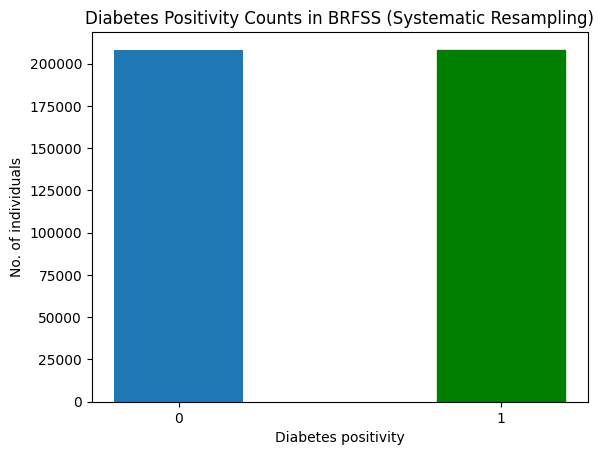

In [ ]:
barlist = plt.bar([str(0),str(1)], y_S_Sy.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (Systematic Resampling)")
plt.show()

In [ ]:
model_source_Sy_ROS = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_326"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2282 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2283 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2284 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2285 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2286 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2287 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2288 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7


Epoch 1/10
8322/8322 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - AUC: 0.8083 - loss: 0.5271 - val_AUC: 0.8239 - val_loss: 0.5111
Epoch 2/10
8322/8322 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - AUC: 0.8263 - loss: 0.5061 - val_AUC: 0.8276 - val_loss: 0.5052
Epoch 3/10
8322/8322 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - AUC: 0.8289 - loss: 0.5029 - val_AUC: 0.8279 - val_loss: 0.5045
Epoch 4/10
8322/8322 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - AUC: 0.8309 - loss: 0.5002 - val_AUC: 0.8291 - val_loss: 0.5030
Epoch 5/10
8322/8322 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - AUC: 0.8315 - loss: 0.4993 - val_AUC: 0.8303 - val_loss: 0.5015
Epoch 6/10
8322/8322 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - AUC: 0.8320 - loss: 0.4986 - val_AUC: 0.8302 - val_loss: 0.5011
Epoch 7/10
8322/8322 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - AUC: 0.8335 - loss: 0.4963 - val_AUC: 0.8310 - val_loss: 0.5000
Epoch 8/10
8322/8322 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - AUC: 0.8332 - loss: 0.4963 - val_AUC: 0.8306 - val_loss: 0.4995
Epoch 9/10
8322/8322 ━━━━━━━━━━━

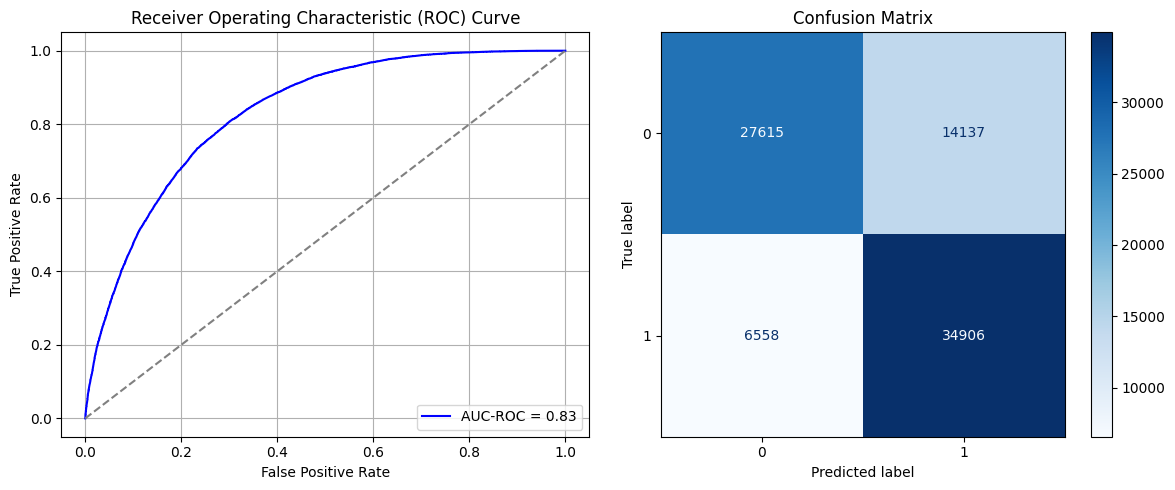

Best threshold based on F1-score: 0.42495158314704895
Time elapsed (performance): 334.3367059259999


<Sequential name=sequential_326, built=True>

In [ ]:
train_and_evaluate(model_source_Sy_ROS, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
AUC-ROC: 0.7115838759500951
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.35      0.52      2278
         1.0       0.23      0.93      0.36       461

    accuracy                           0.45      2739
   macro avg       0.59      0.64      0.44      2739
weighted avg       0.84      0.45      0.49      2739

FPR 0.6453028972783144 TPR: 0.9262472885032538 FNR: 0.0737527114967462 TNR: 0.35469710272168564


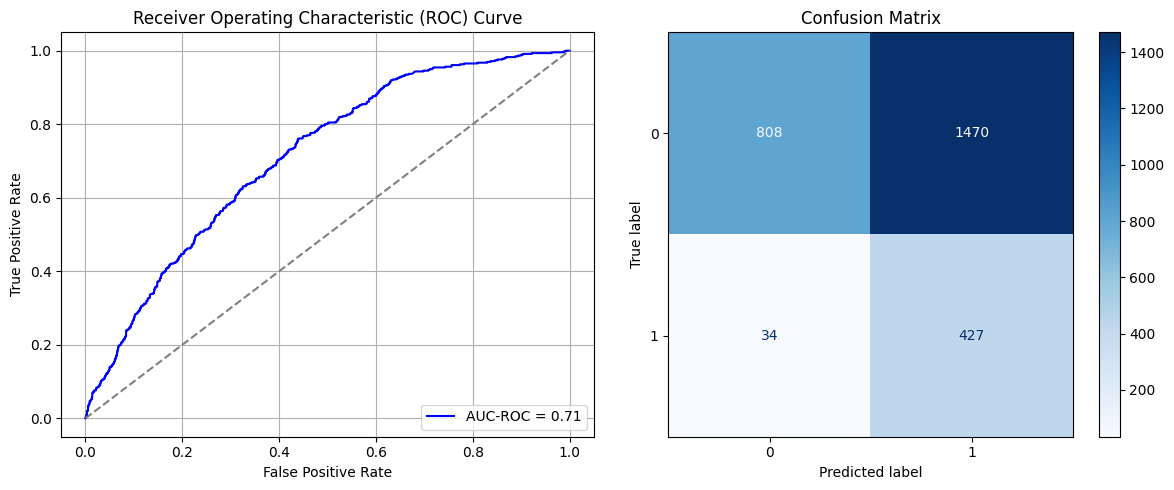

Best threshold based on F1-score: 0.9731065034866333
False Negative Rate: 0.0737527114967462
Time elapsed (performance): 0.7664749700006723


<ipython-input-16-de1f6cb50f3b>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [ ]:
Transductive_TL(model_source_Sy_ROS, X_T_test, y_T_test, "Target")

In [ ]:
fine_tuning(X_T_train, X_T_test, y_T_train, y_T_test, 0, 4)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_327"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2289 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2290 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2291 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2292 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2293 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2294 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2295 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.6717 - loss: 0.7388 - val_AUC: 0.6411 - val_loss: 0.4548
Epoch 2/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.6926 - loss: 0.4339 - val_AUC: 0.6924 - val_loss: 0.4431
Epoch 3/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7013 - loss: 0.4317 - val_AUC: 0.6947 - val_loss: 0.4415
Epoch 4/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7146 - loss: 0.4276 - val_AUC: 0.6957 - val_loss: 0.4424
Epoch 5/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7121 - loss: 0.4247 - val_AUC: 0.6964 - val_loss: 0.4413
Epoch 6/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7147 - loss: 0.4207 - val_AUC: 0.6977 - val_loss: 0.4422
Epoch 7/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7122 - loss: 0.4411 - val_AUC: 0.6983 - val_loss: 0.4420
Epoch 8/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7112 - loss: 0.4199 - val_AUC: 0.6987 - val_loss: 0.4413
Epoch 9/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7137 -

(0.0026338893766461808, 0.9891540130151844)

In [ ]:
times = 50

FPR = []
FNR = []

for i in range(times):
    fpr, fnr = fine_tuning(X_T_train_Sy, X_T_test, y_T_train_Sy, y_T_test, 0, 4)
    # print(output)
    FPR.append(fpr)
    FNR.append(fnr)

ParamFit = pd.DataFrame([FPR, FNR]).T
ParamFit.columns=['FPR', 'FNR']

# fine_tuning(X_T_train_Sy, X_T_test, y_T_train_Sy, y_T_test, 0, 4)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_328"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2296 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2297 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2298 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2299 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2300 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2301 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2302 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.6956 - loss: 0.6760 - val_AUC: 0.0000e+00 - val_loss: 0.9335
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7174 - loss: 0.5889 - val_AUC: 0.0000e+00 - val_loss: 0.9119
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7087 - loss: 0.5908 - val_AUC: 0.0000e+00 - val_loss: 0.8365
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7151 - loss: 0.5837 - val_AUC: 0.0000e+00 - val_loss: 0.8495
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7159 - loss: 0.5841 - val_AUC: 0.0000e+00 - val_loss: 0.8270
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7168 - loss: 0.5838 - val_AUC: 0.0000e+00 - val_loss: 0.8618
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7197 - loss: 0.5815 - val_AUC: 0.0000e+00 - val_loss: 0.8872
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_329"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2303 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2304 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2305 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2306 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2307 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2308 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2309 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.6899 - loss: 0.6819 - val_AUC: 0.0000e+00 - val_loss: 0.8687
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.7083 - loss: 0.5867 - val_AUC: 0.0000e+00 - val_loss: 0.8913
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7102 - loss: 0.5902 - val_AUC: 0.0000e+00 - val_loss: 0.9425
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7171 - loss: 0.5840 - val_AUC: 0.0000e+00 - val_loss: 0.8894
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7246 - loss: 0.5776 - val_AUC: 0.0000e+00 - val_loss: 0.8805
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.7192 - loss: 0.5786 - val_AUC: 0.0000e+00 - val_loss: 0.8240
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7101 - loss: 0.5855 - val_AUC: 0.0000e+00 - val_loss: 0.7891
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7174 - loss: 0.5843 - val_AUC: 0.0000e+00 - val_loss: 0.9295
Epoch 9/10
448/448 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_330"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2310 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2311 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2312 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2313 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2314 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2315 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2316 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.6894 - loss: 0.6792 - val_AUC: 0.0000e+00 - val_loss: 0.8158
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7081 - loss: 0.5940 - val_AUC: 0.0000e+00 - val_loss: 0.8716
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7133 - loss: 0.5885 - val_AUC: 0.0000e+00 - val_loss: 0.9047
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7134 - loss: 0.5873 - val_AUC: 0.0000e+00 - val_loss: 0.8825
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7110 - loss: 0.5894 - val_AUC: 0.0000e+00 - val_loss: 0.8718
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7176 - loss: 0.5825 - val_AUC: 0.0000e+00 - val_loss: 0.8897
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7155 - loss: 0.5865 - val_AUC: 0.0000e+00 - val_loss: 0.8822
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7192 - loss: 0.5811 - val_AUC: 0.0000e+00 - val_loss: 0.8570
Epoch 9/10
448/448 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_331"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2317 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2318 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2319 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2320 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2321 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2322 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2323 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6871 - loss: 0.6794 - val_AUC: 0.0000e+00 - val_loss: 0.8378
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7085 - loss: 0.5938 - val_AUC: 0.0000e+00 - val_loss: 0.9077
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7158 - loss: 0.5857 - val_AUC: 0.0000e+00 - val_loss: 0.8632
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7181 - loss: 0.5831 - val_AUC: 0.0000e+00 - val_loss: 0.8089
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7167 - loss: 0.5858 - val_AUC: 0.0000e+00 - val_loss: 0.8554
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7099 - loss: 0.5893 - val_AUC: 0.0000e+00 - val_loss: 0.8566
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7114 - loss: 0.5863 - val_AUC: 0.0000e+00 - val_loss: 0.8774
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7140 - loss: 0.5888 - val_AUC: 0.0000e+00 - val_loss: 0.9063
Epoch 9/10
448/448 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_332"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2324 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2325 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2326 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2327 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2328 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2329 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2330 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6950 - loss: 0.6736 - val_AUC: 0.0000e+00 - val_loss: 0.8985
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7058 - loss: 0.5952 - val_AUC: 0.0000e+00 - val_loss: 0.7998
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7106 - loss: 0.5927 - val_AUC: 0.0000e+00 - val_loss: 0.8126
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7227 - loss: 0.5800 - val_AUC: 0.0000e+00 - val_loss: 0.8909
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7064 - loss: 0.5917 - val_AUC: 0.0000e+00 - val_loss: 0.8838
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7170 - loss: 0.5837 - val_AUC: 0.0000e+00 - val_loss: 0.9120
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7168 - loss: 0.5832 - val_AUC: 0.0000e+00 - val_loss: 0.8330
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7100 - loss: 0.5885 - val_AUC: 0.0000e+00 - val_loss: 0.8278
Epoch 9/10
448/448 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_333"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2331 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2332 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2333 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2334 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2335 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2336 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2337 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.6949 - loss: 0.6764 - val_AUC: 0.0000e+00 - val_loss: 0.8960
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7128 - loss: 0.5940 - val_AUC: 0.0000e+00 - val_loss: 0.8839
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7122 - loss: 0.5888 - val_AUC: 0.0000e+00 - val_loss: 0.8688
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7144 - loss: 0.5888 - val_AUC: 0.0000e+00 - val_loss: 0.8297
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7145 - loss: 0.5855 - val_AUC: 0.0000e+00 - val_loss: 0.8495
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7152 - loss: 0.5845 - val_AUC: 0.0000e+00 - val_loss: 0.8080
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7119 - loss: 0.5867 - val_AUC: 0.0000e+00 - val_loss: 0.8581
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7107 - loss: 0.5875 - val_AUC: 0.0000e+00 - val_loss: 0.8701
Epoch 9/10
448/448 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_334"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2338 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2339 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2340 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2341 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2342 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2343 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2344 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.6929 - loss: 0.6768 - val_AUC: 0.0000e+00 - val_loss: 0.8554
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7135 - loss: 0.5926 - val_AUC: 0.0000e+00 - val_loss: 0.8488
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7089 - loss: 0.5887 - val_AUC: 0.0000e+00 - val_loss: 0.8884
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7002 - loss: 0.5973 - val_AUC: 0.0000e+00 - val_loss: 0.8839
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7103 - loss: 0.5884 - val_AUC: 0.0000e+00 - val_loss: 0.8362
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7091 - loss: 0.5900 - val_AUC: 0.0000e+00 - val_loss: 0.8492
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7162 - loss: 0.5827 - val_AUC: 0.0000e+00 - val_loss: 0.8135
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7129 - loss: 0.5871 - val_AUC: 0.0000e+00 - val_loss: 0.8383
Epoch 9/10
448/448 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_335"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2345 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2346 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2347 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2348 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2349 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2350 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2351 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.6863 - loss: 0.6825 - val_AUC: 0.0000e+00 - val_loss: 0.8428
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7068 - loss: 0.5961 - val_AUC: 0.0000e+00 - val_loss: 0.8710
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7058 - loss: 0.5922 - val_AUC: 0.0000e+00 - val_loss: 0.8624
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7075 - loss: 0.5917 - val_AUC: 0.0000e+00 - val_loss: 0.8534
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7120 - loss: 0.5878 - val_AUC: 0.0000e+00 - val_loss: 0.8393
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7183 - loss: 0.5831 - val_AUC: 0.0000e+00 - val_loss: 0.8104
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7143 - loss: 0.5835 - val_AUC: 0.0000e+00 - val_loss: 0.8300
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7165 - loss: 0.5846 - val_AUC: 0.0000e+00 - val_loss: 0.8906
Epoch 9/10
448/448 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_336"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2352 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2353 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2354 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2355 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2356 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2357 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2358 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.6839 - loss: 0.6843 - val_AUC: 0.0000e+00 - val_loss: 0.8610
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7035 - loss: 0.5975 - val_AUC: 0.0000e+00 - val_loss: 0.8763
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7007 - loss: 0.5919 - val_AUC: 0.0000e+00 - val_loss: 0.8173
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7139 - loss: 0.5820 - val_AUC: 0.0000e+00 - val_loss: 0.8988
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7032 - loss: 0.5950 - val_AUC: 0.0000e+00 - val_loss: 0.9434
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7145 - loss: 0.5859 - val_AUC: 0.0000e+00 - val_loss: 0.8282
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7170 - loss: 0.5854 - val_AUC: 0.0000e+00 - val_loss: 0.8889
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7108 - loss: 0.5844 - val_AUC: 0.0000e+00 - val_loss: 0.8404
Epoch 9/10
448/448 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_337"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2359 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2360 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2361 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2362 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2363 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2364 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2365 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.6935 - loss: 0.6763 - val_AUC: 0.0000e+00 - val_loss: 0.8815
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7125 - loss: 0.5864 - val_AUC: 0.0000e+00 - val_loss: 0.8775
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7118 - loss: 0.5927 - val_AUC: 0.0000e+00 - val_loss: 0.9089
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7123 - loss: 0.5876 - val_AUC: 0.0000e+00 - val_loss: 0.8326
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7066 - loss: 0.5905 - val_AUC: 0.0000e+00 - val_loss: 0.9265
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7106 - loss: 0.5893 - val_AUC: 0.0000e+00 - val_loss: 0.8683
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7147 - loss: 0.5853 - val_AUC: 0.0000e+00 - val_loss: 0.8761
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7162 - loss: 0.5878 - val_AUC: 0.0000e+00 - val_loss: 0.9245
Epoch 9/10
448/448 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_338"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2366 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2367 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2368 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2369 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2370 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2371 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2372 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.6936 - loss: 0.6854 - val_AUC: 0.0000e+00 - val_loss: 0.8907
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7113 - loss: 0.5941 - val_AUC: 0.0000e+00 - val_loss: 0.9031
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7206 - loss: 0.5834 - val_AUC: 0.0000e+00 - val_loss: 0.8432
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7066 - loss: 0.5934 - val_AUC: 0.0000e+00 - val_loss: 0.8274
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7231 - loss: 0.5795 - val_AUC: 0.0000e+00 - val_loss: 0.8193
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7165 - loss: 0.5836 - val_AUC: 0.0000e+00 - val_loss: 0.8860
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7127 - loss: 0.5865 - val_AUC: 0.0000e+00 - val_loss: 0.8394
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7183 - loss: 0.5834 - val_AUC: 0.0000e+00 - val_loss: 0.8415
Epoch 9/10
448/448 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_339"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2373 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2374 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2375 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2376 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2377 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2378 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2379 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.6904 - loss: 0.6825 - val_AUC: 0.0000e+00 - val_loss: 0.8230
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7179 - loss: 0.5900 - val_AUC: 0.0000e+00 - val_loss: 0.8654
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7181 - loss: 0.5832 - val_AUC: 0.0000e+00 - val_loss: 0.9213
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7076 - loss: 0.5902 - val_AUC: 0.0000e+00 - val_loss: 0.8792
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7046 - loss: 0.5914 - val_AUC: 0.0000e+00 - val_loss: 0.8787
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7145 - loss: 0.5833 - val_AUC: 0.0000e+00 - val_loss: 0.9136
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7131 - loss: 0.5870 - val_AUC: 0.0000e+00 - val_loss: 0.8745
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7135 - loss: 0.5886 - val_AUC: 0.0000e+00 - val_loss: 0.8749
Epoch 9/10
448/448 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_340"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2380 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2381 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2382 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2383 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2384 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2385 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2386 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.6964 - loss: 0.6724 - val_AUC: 0.0000e+00 - val_loss: 0.8204
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7139 - loss: 0.5907 - val_AUC: 0.0000e+00 - val_loss: 0.9446
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7117 - loss: 0.5879 - val_AUC: 0.0000e+00 - val_loss: 0.8678
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7179 - loss: 0.5851 - val_AUC: 0.0000e+00 - val_loss: 0.8504
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7172 - loss: 0.5837 - val_AUC: 0.0000e+00 - val_loss: 0.9303
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7168 - loss: 0.5851 - val_AUC: 0.0000e+00 - val_loss: 0.8805
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7087 - loss: 0.5895 - val_AUC: 0.0000e+00 - val_loss: 0.8264
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7166 - loss: 0.5870 - val_AUC: 0.0000e+00 - val_loss: 0.7984
Epoch 9/10
448/448 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_341"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2387 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2388 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2389 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2390 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2391 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2392 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2393 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.6854 - loss: 0.6841 - val_AUC: 0.0000e+00 - val_loss: 0.8612
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7023 - loss: 0.5976 - val_AUC: 0.0000e+00 - val_loss: 0.8956
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6984 - loss: 0.5984 - val_AUC: 0.0000e+00 - val_loss: 0.8452
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7099 - loss: 0.5893 - val_AUC: 0.0000e+00 - val_loss: 0.8730
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7136 - loss: 0.5858 - val_AUC: 0.0000e+00 - val_loss: 0.8459
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7162 - loss: 0.5838 - val_AUC: 0.0000e+00 - val_loss: 0.7991
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7126 - loss: 0.5857 - val_AUC: 0.0000e+00 - val_loss: 0.8479
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7194 - loss: 0.5836 - val_AUC: 0.0000e+00 - val_loss: 0.9016
Epoch 9/10
448/448 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_342"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2394 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2395 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2396 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2397 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2398 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2399 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2400 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6897 - loss: 0.6864 - val_AUC: 0.0000e+00 - val_loss: 0.8697
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7053 - loss: 0.5965 - val_AUC: 0.0000e+00 - val_loss: 0.8519
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7165 - loss: 0.5828 - val_AUC: 0.0000e+00 - val_loss: 0.8472
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7108 - loss: 0.5912 - val_AUC: 0.0000e+00 - val_loss: 0.7971
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7126 - loss: 0.5853 - val_AUC: 0.0000e+00 - val_loss: 0.8845
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7161 - loss: 0.5832 - val_AUC: 0.0000e+00 - val_loss: 0.8709
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7182 - loss: 0.5814 - val_AUC: 0.0000e+00 - val_loss: 0.8385
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7125 - loss: 0.5868 - val_AUC: 0.0000e+00 - val_loss: 0.9008
Epoch 9/10
448/448 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_343"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2401 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2402 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2403 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2404 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2405 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2406 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2407 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.6981 - loss: 0.6680 - val_AUC: 0.0000e+00 - val_loss: 0.8483
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7128 - loss: 0.5928 - val_AUC: 0.0000e+00 - val_loss: 0.8274
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7065 - loss: 0.5924 - val_AUC: 0.0000e+00 - val_loss: 0.8126
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7135 - loss: 0.5891 - val_AUC: 0.0000e+00 - val_loss: 0.9240
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7163 - loss: 0.5816 - val_AUC: 0.0000e+00 - val_loss: 0.8306
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7122 - loss: 0.5883 - val_AUC: 0.0000e+00 - val_loss: 0.8547
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7186 - loss: 0.5855 - val_AUC: 0.0000e+00 - val_loss: 0.8214
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7161 - loss: 0.5876 - val_AUC: 0.0000e+00 - val_loss: 0.8767
Epoch 9/10
448/448 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_344"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2408 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2409 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2410 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2411 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2412 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2413 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2414 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.6891 - loss: 0.6834 - val_AUC: 0.0000e+00 - val_loss: 0.8176
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7179 - loss: 0.5884 - val_AUC: 0.0000e+00 - val_loss: 0.8166
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7126 - loss: 0.5873 - val_AUC: 0.0000e+00 - val_loss: 0.8655
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7138 - loss: 0.5851 - val_AUC: 0.0000e+00 - val_loss: 0.8575
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7191 - loss: 0.5833 - val_AUC: 0.0000e+00 - val_loss: 0.8791
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7182 - loss: 0.5833 - val_AUC: 0.0000e+00 - val_loss: 0.8594
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7200 - loss: 0.5827 - val_AUC: 0.0000e+00 - val_loss: 0.8755
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7242 - loss: 0.5795 - val_AUC: 0.0000e+00 - val_loss: 0.8218
Epoch 9/10
448/448 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_345"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2415 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2416 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2417 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2418 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2419 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2420 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2421 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6983 - loss: 0.6695 - val_AUC: 0.0000e+00 - val_loss: 0.8543
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7086 - loss: 0.5929 - val_AUC: 0.0000e+00 - val_loss: 0.8260
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7122 - loss: 0.5864 - val_AUC: 0.0000e+00 - val_loss: 0.8757
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7141 - loss: 0.5832 - val_AUC: 0.0000e+00 - val_loss: 0.8584
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7074 - loss: 0.5869 - val_AUC: 0.0000e+00 - val_loss: 0.8583
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7148 - loss: 0.5863 - val_AUC: 0.0000e+00 - val_loss: 0.8770
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7142 - loss: 0.5858 - val_AUC: 0.0000e+00 - val_loss: 0.9410
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7199 - loss: 0.5817 - val_AUC: 0.0000e+00 - val_loss: 0.8212
Epoch 9/10
448/448 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_346"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2422 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2423 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2424 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2425 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2426 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2427 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2428 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.6858 - loss: 0.6956 - val_AUC: 0.0000e+00 - val_loss: 0.8646
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7138 - loss: 0.5905 - val_AUC: 0.0000e+00 - val_loss: 0.8702
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7165 - loss: 0.5859 - val_AUC: 0.0000e+00 - val_loss: 0.8664
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7144 - loss: 0.5884 - val_AUC: 0.0000e+00 - val_loss: 0.8409
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7190 - loss: 0.5811 - val_AUC: 0.0000e+00 - val_loss: 0.8017
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7088 - loss: 0.5866 - val_AUC: 0.0000e+00 - val_loss: 0.9222
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7185 - loss: 0.5802 - val_AUC: 0.0000e+00 - val_loss: 0.8787
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7181 - loss: 0.5810 - val_AUC: 0.0000e+00 - val_loss: 0.8456
Epoch 9/10
448/448 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_347"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2429 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2430 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2431 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2432 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2433 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2434 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2435 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7018 - loss: 0.6664 - val_AUC: 0.0000e+00 - val_loss: 0.8865
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7023 - loss: 0.5925 - val_AUC: 0.0000e+00 - val_loss: 0.8292
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7113 - loss: 0.5886 - val_AUC: 0.0000e+00 - val_loss: 0.8147
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7117 - loss: 0.5895 - val_AUC: 0.0000e+00 - val_loss: 0.7939
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7118 - loss: 0.5858 - val_AUC: 0.0000e+00 - val_loss: 0.8535
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7205 - loss: 0.5834 - val_AUC: 0.0000e+00 - val_loss: 0.8733
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7094 - loss: 0.5829 - val_AUC: 0.0000e+00 - val_loss: 0.8362
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7183 - loss: 0.5839 - val_AUC: 0.0000e+00 - val_loss: 0.8393
Epoch 9/10
448/448 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_348"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2436 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2437 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2438 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2439 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2440 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2441 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2442 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.6901 - loss: 0.6802 - val_AUC: 0.0000e+00 - val_loss: 0.8564
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7125 - loss: 0.5893 - val_AUC: 0.0000e+00 - val_loss: 0.8376
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7123 - loss: 0.5867 - val_AUC: 0.0000e+00 - val_loss: 0.8435
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7096 - loss: 0.5878 - val_AUC: 0.0000e+00 - val_loss: 0.8610
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7157 - loss: 0.5834 - val_AUC: 0.0000e+00 - val_loss: 0.8506
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7138 - loss: 0.5879 - val_AUC: 0.0000e+00 - val_loss: 0.8236
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7233 - loss: 0.5792 - val_AUC: 0.0000e+00 - val_loss: 0.8638
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7120 - loss: 0.5889 - val_AUC: 0.0000e+00 - val_loss: 0.8680
Epoch 9/10
448/448 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_349"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2443 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2444 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2445 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2446 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2447 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2448 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2449 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.6872 - loss: 0.6778 - val_AUC: 0.0000e+00 - val_loss: 0.8903
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7083 - loss: 0.5919 - val_AUC: 0.0000e+00 - val_loss: 0.8727
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7040 - loss: 0.5909 - val_AUC: 0.0000e+00 - val_loss: 0.8359
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7195 - loss: 0.5791 - val_AUC: 0.0000e+00 - val_loss: 0.8313
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7179 - loss: 0.5841 - val_AUC: 0.0000e+00 - val_loss: 0.8340
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7165 - loss: 0.5864 - val_AUC: 0.0000e+00 - val_loss: 0.8182
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7161 - loss: 0.5837 - val_AUC: 0.0000e+00 - val_loss: 0.8045
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7119 - loss: 0.5875 - val_AUC: 0.0000e+00 - val_loss: 0.9465
Epoch 9/10
448/448 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_350"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2450 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2451 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2452 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2453 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2454 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2455 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2456 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.6918 - loss: 0.6848 - val_AUC: 0.0000e+00 - val_loss: 0.9064
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7087 - loss: 0.5953 - val_AUC: 0.0000e+00 - val_loss: 0.8779
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7023 - loss: 0.5921 - val_AUC: 0.0000e+00 - val_loss: 0.8770
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7138 - loss: 0.5881 - val_AUC: 0.0000e+00 - val_loss: 0.9270
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7147 - loss: 0.5808 - val_AUC: 0.0000e+00 - val_loss: 0.8319
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7239 - loss: 0.5804 - val_AUC: 0.0000e+00 - val_loss: 0.8991
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7108 - loss: 0.5857 - val_AUC: 0.0000e+00 - val_loss: 0.8237
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7187 - loss: 0.5819 - val_AUC: 0.0000e+00 - val_loss: 0.8760
Epoch 9/10
448/448 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_351"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2457 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2458 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2459 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2460 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2461 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2462 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2463 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.6969 - loss: 0.6691 - val_AUC: 0.0000e+00 - val_loss: 0.9002
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7082 - loss: 0.5944 - val_AUC: 0.0000e+00 - val_loss: 0.8376
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7135 - loss: 0.5887 - val_AUC: 0.0000e+00 - val_loss: 0.8741
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7155 - loss: 0.5861 - val_AUC: 0.0000e+00 - val_loss: 0.8778
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7144 - loss: 0.5868 - val_AUC: 0.0000e+00 - val_loss: 0.8221
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7184 - loss: 0.5805 - val_AUC: 0.0000e+00 - val_loss: 0.8255
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7140 - loss: 0.5883 - val_AUC: 0.0000e+00 - val_loss: 0.8933
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7158 - loss: 0.5866 - val_AUC: 0.0000e+00 - val_loss: 0.9026
Epoch 9/10
448/448 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_352"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2464 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2465 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2466 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2467 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2468 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2469 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2470 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6967 - loss: 0.6755 - val_AUC: 0.0000e+00 - val_loss: 0.9873
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7079 - loss: 0.5939 - val_AUC: 0.0000e+00 - val_loss: 0.9364
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7056 - loss: 0.5930 - val_AUC: 0.0000e+00 - val_loss: 0.7910
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.6990 - loss: 0.5957 - val_AUC: 0.0000e+00 - val_loss: 0.8824
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7193 - loss: 0.5827 - val_AUC: 0.0000e+00 - val_loss: 0.8700
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7135 - loss: 0.5881 - val_AUC: 0.0000e+00 - val_loss: 0.8370
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7144 - loss: 0.5836 - val_AUC: 0.0000e+00 - val_loss: 0.7828
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7138 - loss: 0.5864 - val_AUC: 0.0000e+00 - val_loss: 0.8416
Epoch 9/10
448/448 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_353"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2471 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2472 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2473 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2474 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2475 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2476 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2477 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.6925 - loss: 0.6770 - val_AUC: 0.0000e+00 - val_loss: 0.8359
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7143 - loss: 0.5900 - val_AUC: 0.0000e+00 - val_loss: 0.8155
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7135 - loss: 0.5912 - val_AUC: 0.0000e+00 - val_loss: 0.8946
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7067 - loss: 0.5892 - val_AUC: 0.0000e+00 - val_loss: 0.8642
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7148 - loss: 0.5859 - val_AUC: 0.0000e+00 - val_loss: 0.9331
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7140 - loss: 0.5816 - val_AUC: 0.0000e+00 - val_loss: 0.8596
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7142 - loss: 0.5841 - val_AUC: 0.0000e+00 - val_loss: 0.8563
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7145 - loss: 0.5840 - val_AUC: 0.0000e+00 - val_loss: 0.9024
Epoch 9/10
448/448 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_354"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2478 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2479 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2480 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2481 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2482 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2483 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2484 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.6931 - loss: 0.6763 - val_AUC: 0.0000e+00 - val_loss: 0.9116
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7090 - loss: 0.5902 - val_AUC: 0.0000e+00 - val_loss: 0.8149
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7066 - loss: 0.5853 - val_AUC: 0.0000e+00 - val_loss: 0.8297
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7162 - loss: 0.5828 - val_AUC: 0.0000e+00 - val_loss: 0.8457
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7131 - loss: 0.5885 - val_AUC: 0.0000e+00 - val_loss: 0.8347
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7121 - loss: 0.5865 - val_AUC: 0.0000e+00 - val_loss: 0.9522
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7173 - loss: 0.5854 - val_AUC: 0.0000e+00 - val_loss: 0.7930
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7172 - loss: 0.5835 - val_AUC: 0.0000e+00 - val_loss: 0.8100
Epoch 9/10
448/448 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_355"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2485 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2486 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2487 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2488 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2489 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2490 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2491 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.6908 - loss: 0.6812 - val_AUC: 0.0000e+00 - val_loss: 0.8471
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7173 - loss: 0.5884 - val_AUC: 0.0000e+00 - val_loss: 0.8487
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7089 - loss: 0.5905 - val_AUC: 0.0000e+00 - val_loss: 0.7978
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7072 - loss: 0.5895 - val_AUC: 0.0000e+00 - val_loss: 0.8433
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7033 - loss: 0.5960 - val_AUC: 0.0000e+00 - val_loss: 0.8704
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7148 - loss: 0.5877 - val_AUC: 0.0000e+00 - val_loss: 0.8721
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7175 - loss: 0.5857 - val_AUC: 0.0000e+00 - val_loss: 0.8518
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7135 - loss: 0.5866 - val_AUC: 0.0000e+00 - val_loss: 0.8321
Epoch 9/10
448/448 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_356"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2492 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2493 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2494 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2495 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2496 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2497 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2498 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.6878 - loss: 0.6802 - val_AUC: 0.0000e+00 - val_loss: 0.8197
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7087 - loss: 0.5926 - val_AUC: 0.0000e+00 - val_loss: 0.7998
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7156 - loss: 0.5865 - val_AUC: 0.0000e+00 - val_loss: 0.8525
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7137 - loss: 0.5852 - val_AUC: 0.0000e+00 - val_loss: 0.8383
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7153 - loss: 0.5846 - val_AUC: 0.0000e+00 - val_loss: 0.8579
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7137 - loss: 0.5889 - val_AUC: 0.0000e+00 - val_loss: 0.8370
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7283 - loss: 0.5778 - val_AUC: 0.0000e+00 - val_loss: 0.8266
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7111 - loss: 0.5882 - val_AUC: 0.0000e+00 - val_loss: 0.9689
Epoch 9/10
448/448 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_357"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2499 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2500 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2501 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2502 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2503 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2504 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2505 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.6893 - loss: 0.6789 - val_AUC: 0.0000e+00 - val_loss: 0.8618
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7118 - loss: 0.5947 - val_AUC: 0.0000e+00 - val_loss: 0.8595
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7069 - loss: 0.5879 - val_AUC: 0.0000e+00 - val_loss: 0.9188
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7095 - loss: 0.5907 - val_AUC: 0.0000e+00 - val_loss: 0.8836
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7107 - loss: 0.5891 - val_AUC: 0.0000e+00 - val_loss: 0.8530
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7103 - loss: 0.5879 - val_AUC: 0.0000e+00 - val_loss: 0.8737
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7176 - loss: 0.5857 - val_AUC: 0.0000e+00 - val_loss: 0.8803
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7153 - loss: 0.5875 - val_AUC: 0.0000e+00 - val_loss: 0.8626
Epoch 9/10
448/448 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_358"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2506 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2507 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2508 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2509 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2510 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2511 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2512 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6873 - loss: 0.6802 - val_AUC: 0.0000e+00 - val_loss: 0.8370
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7138 - loss: 0.5887 - val_AUC: 0.0000e+00 - val_loss: 0.9167
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7071 - loss: 0.5940 - val_AUC: 0.0000e+00 - val_loss: 0.8559
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7144 - loss: 0.5870 - val_AUC: 0.0000e+00 - val_loss: 0.8528
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7174 - loss: 0.5846 - val_AUC: 0.0000e+00 - val_loss: 0.8727
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7078 - loss: 0.5883 - val_AUC: 0.0000e+00 - val_loss: 0.8942
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7127 - loss: 0.5888 - val_AUC: 0.0000e+00 - val_loss: 0.8443
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7143 - loss: 0.5853 - val_AUC: 0.0000e+00 - val_loss: 0.8879
Epoch 9/10
448/448 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_359"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2513 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2514 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2515 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2516 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2517 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2518 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2519 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.6820 - loss: 0.6873 - val_AUC: 0.0000e+00 - val_loss: 0.8982
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7058 - loss: 0.5960 - val_AUC: 0.0000e+00 - val_loss: 0.9184
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7148 - loss: 0.5862 - val_AUC: 0.0000e+00 - val_loss: 0.9248
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7078 - loss: 0.5933 - val_AUC: 0.0000e+00 - val_loss: 0.8319
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7193 - loss: 0.5802 - val_AUC: 0.0000e+00 - val_loss: 0.8573
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7209 - loss: 0.5788 - val_AUC: 0.0000e+00 - val_loss: 0.8411
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7231 - loss: 0.5801 - val_AUC: 0.0000e+00 - val_loss: 0.9002
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7253 - loss: 0.5797 - val_AUC: 0.0000e+00 - val_loss: 0.9254
Epoch 9/10
448/448 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_360"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2520 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2521 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2522 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2523 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2524 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2525 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2526 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.6875 - loss: 0.6856 - val_AUC: 0.0000e+00 - val_loss: 0.8126
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7072 - loss: 0.5933 - val_AUC: 0.0000e+00 - val_loss: 0.8253
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7155 - loss: 0.5866 - val_AUC: 0.0000e+00 - val_loss: 0.8709
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7141 - loss: 0.5831 - val_AUC: 0.0000e+00 - val_loss: 0.9038
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7131 - loss: 0.5843 - val_AUC: 0.0000e+00 - val_loss: 0.8442
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7041 - loss: 0.5909 - val_AUC: 0.0000e+00 - val_loss: 0.8143
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7041 - loss: 0.5910 - val_AUC: 0.0000e+00 - val_loss: 0.8079
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7104 - loss: 0.5860 - val_AUC: 0.0000e+00 - val_loss: 0.7689
Epoch 9/10
448/448 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_361"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2527 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2528 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2529 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2530 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2531 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2532 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2533 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.6900 - loss: 0.6785 - val_AUC: 0.0000e+00 - val_loss: 0.9047
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7078 - loss: 0.5950 - val_AUC: 0.0000e+00 - val_loss: 0.8803
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7128 - loss: 0.5863 - val_AUC: 0.0000e+00 - val_loss: 0.8797
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7073 - loss: 0.5929 - val_AUC: 0.0000e+00 - val_loss: 0.8559
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7160 - loss: 0.5825 - val_AUC: 0.0000e+00 - val_loss: 0.8413
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7156 - loss: 0.5822 - val_AUC: 0.0000e+00 - val_loss: 0.8573
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7034 - loss: 0.5930 - val_AUC: 0.0000e+00 - val_loss: 0.8951
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7117 - loss: 0.5888 - val_AUC: 0.0000e+00 - val_loss: 0.8339
Epoch 9/10
448/448 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_362"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2534 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2535 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2536 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2537 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2538 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2539 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2540 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.6904 - loss: 0.6781 - val_AUC: 0.0000e+00 - val_loss: 0.7898
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7121 - loss: 0.5924 - val_AUC: 0.0000e+00 - val_loss: 0.9020
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7080 - loss: 0.5910 - val_AUC: 0.0000e+00 - val_loss: 0.8337
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7137 - loss: 0.5886 - val_AUC: 0.0000e+00 - val_loss: 0.9191
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7100 - loss: 0.5902 - val_AUC: 0.0000e+00 - val_loss: 0.8236
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7208 - loss: 0.5805 - val_AUC: 0.0000e+00 - val_loss: 0.8511
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7109 - loss: 0.5896 - val_AUC: 0.0000e+00 - val_loss: 0.9076
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7098 - loss: 0.5902 - val_AUC: 0.0000e+00 - val_loss: 0.8246
Epoch 9/10
448/448 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_363"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2541 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2542 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2543 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2544 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2545 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2546 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2547 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.6962 - loss: 0.6725 - val_AUC: 0.0000e+00 - val_loss: 0.8231
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7090 - loss: 0.5917 - val_AUC: 0.0000e+00 - val_loss: 0.9189
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7066 - loss: 0.5877 - val_AUC: 0.0000e+00 - val_loss: 0.8381
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7155 - loss: 0.5844 - val_AUC: 0.0000e+00 - val_loss: 0.9058
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7192 - loss: 0.5814 - val_AUC: 0.0000e+00 - val_loss: 0.8755
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7093 - loss: 0.5876 - val_AUC: 0.0000e+00 - val_loss: 0.8755
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7172 - loss: 0.5829 - val_AUC: 0.0000e+00 - val_loss: 0.8498
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7179 - loss: 0.5855 - val_AUC: 0.0000e+00 - val_loss: 0.8300
Epoch 9/10
448/448 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_364"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2548 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2549 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2550 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2551 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2552 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2553 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2554 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.6973 - loss: 0.6737 - val_AUC: 0.0000e+00 - val_loss: 0.8261
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7048 - loss: 0.5916 - val_AUC: 0.0000e+00 - val_loss: 0.8154
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7103 - loss: 0.5900 - val_AUC: 0.0000e+00 - val_loss: 0.8268
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7155 - loss: 0.5830 - val_AUC: 0.0000e+00 - val_loss: 0.8281
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7189 - loss: 0.5823 - val_AUC: 0.0000e+00 - val_loss: 0.8395
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7184 - loss: 0.5846 - val_AUC: 0.0000e+00 - val_loss: 0.8255
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7201 - loss: 0.5815 - val_AUC: 0.0000e+00 - val_loss: 0.8830
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7245 - loss: 0.5779 - val_AUC: 0.0000e+00 - val_loss: 0.8921
Epoch 9/10
448/448 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_365"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2555 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2556 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2557 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2558 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2559 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2560 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2561 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6923 - loss: 0.6774 - val_AUC: 0.0000e+00 - val_loss: 0.9177
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7062 - loss: 0.5924 - val_AUC: 0.0000e+00 - val_loss: 0.7979
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7030 - loss: 0.5987 - val_AUC: 0.0000e+00 - val_loss: 0.9194
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7140 - loss: 0.5836 - val_AUC: 0.0000e+00 - val_loss: 0.7982
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7098 - loss: 0.5866 - val_AUC: 0.0000e+00 - val_loss: 0.8448
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7131 - loss: 0.5843 - val_AUC: 0.0000e+00 - val_loss: 0.8715
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7080 - loss: 0.5885 - val_AUC: 0.0000e+00 - val_loss: 0.8276
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7151 - loss: 0.5846 - val_AUC: 0.0000e+00 - val_loss: 0.8513
Epoch 9/10
448/448 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_366"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2562 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2563 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2564 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2565 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2566 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2567 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2568 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.6954 - loss: 0.6767 - val_AUC: 0.0000e+00 - val_loss: 0.8484
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7122 - loss: 0.5936 - val_AUC: 0.0000e+00 - val_loss: 0.8593
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7125 - loss: 0.5911 - val_AUC: 0.0000e+00 - val_loss: 0.8052
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7105 - loss: 0.5870 - val_AUC: 0.0000e+00 - val_loss: 0.8440
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7109 - loss: 0.5893 - val_AUC: 0.0000e+00 - val_loss: 0.8307
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7125 - loss: 0.5878 - val_AUC: 0.0000e+00 - val_loss: 0.8496
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7151 - loss: 0.5849 - val_AUC: 0.0000e+00 - val_loss: 0.8945
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7176 - loss: 0.5853 - val_AUC: 0.0000e+00 - val_loss: 0.8981
Epoch 9/10
448/448 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_367"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2569 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2570 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2571 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2572 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2573 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2574 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2575 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.6855 - loss: 0.6905 - val_AUC: 0.0000e+00 - val_loss: 0.8201
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7048 - loss: 0.5971 - val_AUC: 0.0000e+00 - val_loss: 0.8130
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7203 - loss: 0.5839 - val_AUC: 0.0000e+00 - val_loss: 0.9110
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7151 - loss: 0.5906 - val_AUC: 0.0000e+00 - val_loss: 0.8074
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7137 - loss: 0.5879 - val_AUC: 0.0000e+00 - val_loss: 0.8177
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7101 - loss: 0.5870 - val_AUC: 0.0000e+00 - val_loss: 0.8923
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7094 - loss: 0.5890 - val_AUC: 0.0000e+00 - val_loss: 0.8840
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7094 - loss: 0.5883 - val_AUC: 0.0000e+00 - val_loss: 0.8302
Epoch 9/10
448/448 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_368"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2576 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2577 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2578 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2579 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2580 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2581 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2582 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7030 - loss: 0.6706 - val_AUC: 0.0000e+00 - val_loss: 0.8629
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7047 - loss: 0.5947 - val_AUC: 0.0000e+00 - val_loss: 0.8395
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7132 - loss: 0.5892 - val_AUC: 0.0000e+00 - val_loss: 0.8740
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7137 - loss: 0.5859 - val_AUC: 0.0000e+00 - val_loss: 0.8436
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7157 - loss: 0.5823 - val_AUC: 0.0000e+00 - val_loss: 0.8343
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7159 - loss: 0.5852 - val_AUC: 0.0000e+00 - val_loss: 0.9098
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7174 - loss: 0.5870 - val_AUC: 0.0000e+00 - val_loss: 0.8591
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7259 - loss: 0.5785 - val_AUC: 0.0000e+00 - val_loss: 0.8627
Epoch 9/10
448/448 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_369"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2583 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2584 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2585 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2586 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2587 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2588 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2589 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.6851 - loss: 0.6904 - val_AUC: 0.0000e+00 - val_loss: 0.8638
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7099 - loss: 0.5936 - val_AUC: 0.0000e+00 - val_loss: 0.8491
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7188 - loss: 0.5809 - val_AUC: 0.0000e+00 - val_loss: 0.8399
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7150 - loss: 0.5881 - val_AUC: 0.0000e+00 - val_loss: 0.8842
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7127 - loss: 0.5931 - val_AUC: 0.0000e+00 - val_loss: 0.8910
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7212 - loss: 0.5866 - val_AUC: 0.0000e+00 - val_loss: 0.8797
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7162 - loss: 0.5848 - val_AUC: 0.0000e+00 - val_loss: 0.8297
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7213 - loss: 0.5820 - val_AUC: 0.0000e+00 - val_loss: 0.9228
Epoch 9/10
448/448 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_370"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2590 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2591 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2592 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2593 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2594 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2595 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2596 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.6925 - loss: 0.6768 - val_AUC: 0.0000e+00 - val_loss: 0.8561
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7120 - loss: 0.5940 - val_AUC: 0.0000e+00 - val_loss: 0.9304
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7129 - loss: 0.5903 - val_AUC: 0.0000e+00 - val_loss: 0.9652
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7142 - loss: 0.5837 - val_AUC: 0.0000e+00 - val_loss: 0.9232
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7134 - loss: 0.5856 - val_AUC: 0.0000e+00 - val_loss: 0.8661
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7046 - loss: 0.5925 - val_AUC: 0.0000e+00 - val_loss: 0.8458
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7098 - loss: 0.5876 - val_AUC: 0.0000e+00 - val_loss: 0.8165
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7147 - loss: 0.5828 - val_AUC: 0.0000e+00 - val_loss: 0.9103
Epoch 9/10
448/448 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_371"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2597 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2598 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2599 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2600 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2601 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2602 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2603 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.6901 - loss: 0.6783 - val_AUC: 0.0000e+00 - val_loss: 0.8998
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7065 - loss: 0.5902 - val_AUC: 0.0000e+00 - val_loss: 0.8236
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7137 - loss: 0.5864 - val_AUC: 0.0000e+00 - val_loss: 0.8017
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7207 - loss: 0.5838 - val_AUC: 0.0000e+00 - val_loss: 0.9114
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7137 - loss: 0.5878 - val_AUC: 0.0000e+00 - val_loss: 0.8991
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7120 - loss: 0.5891 - val_AUC: 0.0000e+00 - val_loss: 0.8140
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7246 - loss: 0.5813 - val_AUC: 0.0000e+00 - val_loss: 0.8220
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7103 - loss: 0.5870 - val_AUC: 0.0000e+00 - val_loss: 0.8303
Epoch 9/10
448/448 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_372"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2604 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2605 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2606 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2607 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2608 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2609 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2610 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6843 - loss: 0.6925 - val_AUC: 0.0000e+00 - val_loss: 0.8122
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7057 - loss: 0.6006 - val_AUC: 0.0000e+00 - val_loss: 0.8457
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7072 - loss: 0.5919 - val_AUC: 0.0000e+00 - val_loss: 0.8738
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7132 - loss: 0.5890 - val_AUC: 0.0000e+00 - val_loss: 0.8997
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7072 - loss: 0.5903 - val_AUC: 0.0000e+00 - val_loss: 0.8576
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7090 - loss: 0.5902 - val_AUC: 0.0000e+00 - val_loss: 0.9048
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7134 - loss: 0.5892 - val_AUC: 0.0000e+00 - val_loss: 0.8561
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7223 - loss: 0.5801 - val_AUC: 0.0000e+00 - val_loss: 0.8573
Epoch 9/10
448/448 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_373"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2611 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2612 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2613 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2614 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2615 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2616 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2617 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.6930 - loss: 0.6816 - val_AUC: 0.0000e+00 - val_loss: 0.8628
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7158 - loss: 0.5922 - val_AUC: 0.0000e+00 - val_loss: 0.8652
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7196 - loss: 0.5840 - val_AUC: 0.0000e+00 - val_loss: 0.8218
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7168 - loss: 0.5871 - val_AUC: 0.0000e+00 - val_loss: 0.8453
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7166 - loss: 0.5848 - val_AUC: 0.0000e+00 - val_loss: 0.8458
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7143 - loss: 0.5883 - val_AUC: 0.0000e+00 - val_loss: 0.8116
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7153 - loss: 0.5848 - val_AUC: 0.0000e+00 - val_loss: 0.9474
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7176 - loss: 0.5871 - val_AUC: 0.0000e+00 - val_loss: 0.7779
Epoch 9/10
448/448 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_374"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2618 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2619 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2620 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2621 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2622 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2623 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2624 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.6885 - loss: 0.6888 - val_AUC: 0.0000e+00 - val_loss: 0.8483
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7152 - loss: 0.5936 - val_AUC: 0.0000e+00 - val_loss: 0.9653
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7037 - loss: 0.5948 - val_AUC: 0.0000e+00 - val_loss: 0.8031
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7189 - loss: 0.5854 - val_AUC: 0.0000e+00 - val_loss: 0.7902
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7151 - loss: 0.5866 - val_AUC: 0.0000e+00 - val_loss: 0.8767
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7255 - loss: 0.5763 - val_AUC: 0.0000e+00 - val_loss: 0.8193
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7192 - loss: 0.5835 - val_AUC: 0.0000e+00 - val_loss: 0.8420
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7138 - loss: 0.5871 - val_AUC: 0.0000e+00 - val_loss: 0.7998
Epoch 9/10
448/448 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_375"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2625 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2626 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2627 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2628 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2629 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2630 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2631 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.6906 - loss: 0.6788 - val_AUC: 0.0000e+00 - val_loss: 0.8322
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6979 - loss: 0.5956 - val_AUC: 0.0000e+00 - val_loss: 0.8271
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7187 - loss: 0.5821 - val_AUC: 0.0000e+00 - val_loss: 0.8259
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7067 - loss: 0.5928 - val_AUC: 0.0000e+00 - val_loss: 0.8489
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7117 - loss: 0.5873 - val_AUC: 0.0000e+00 - val_loss: 0.9022
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7182 - loss: 0.5854 - val_AUC: 0.0000e+00 - val_loss: 0.9057
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7178 - loss: 0.5834 - val_AUC: 0.0000e+00 - val_loss: 0.9055
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7107 - loss: 0.5841 - val_AUC: 0.0000e+00 - val_loss: 0.8442
Epoch 9/10
448/448 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_376"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2632 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2633 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2634 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2635 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2636 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2637 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2638 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7010 - loss: 0.6704 - val_AUC: 0.0000e+00 - val_loss: 0.8676
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7057 - loss: 0.5968 - val_AUC: 0.0000e+00 - val_loss: 0.8356
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7059 - loss: 0.5898 - val_AUC: 0.0000e+00 - val_loss: 0.8348
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7107 - loss: 0.5897 - val_AUC: 0.0000e+00 - val_loss: 0.8259
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7122 - loss: 0.5856 - val_AUC: 0.0000e+00 - val_loss: 0.8624
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7170 - loss: 0.5842 - val_AUC: 0.0000e+00 - val_loss: 0.8966
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7206 - loss: 0.5816 - val_AUC: 0.0000e+00 - val_loss: 0.8697
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7162 - loss: 0.5817 - val_AUC: 0.0000e+00 - val_loss: 0.8725
Epoch 9/10
448/448 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_377"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2639 (Dense)                   │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2640 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2641 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2642 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2643 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2644 (Dense)                   │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2645 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.6860 - loss: 0.6834 - val_AUC: 0.0000e+00 - val_loss: 0.8076
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7069 - loss: 0.5933 - val_AUC: 0.0000e+00 - val_loss: 0.8715
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7109 - loss: 0.5863 - val_AUC: 0.0000e+00 - val_loss: 0.8608
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7065 - loss: 0.5908 - val_AUC: 0.0000e+00 - val_loss: 0.9230
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7143 - loss: 0.5862 - val_AUC: 0.0000e+00 - val_loss: 0.8028
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7194 - loss: 0.5828 - val_AUC: 0.0000e+00 - val_loss: 0.8275
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7172 - loss: 0.5829 - val_AUC: 0.0000e+00 - val_loss: 0.8903
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7187 - loss: 0.5841 - val_AUC: 0.0000e+00 - val_loss: 0.9396
Epoch 9/10
448/448 ━━━━━━━━━━━━━━━━

In [ ]:
print(ParamFit)
ParamFit.to_csv('Sy_ROS_Fine_Tuning.csv')

         FPR       FNR
0   0.063652  0.841649
1   0.109745  0.704989
2   0.106234  0.711497
3   0.215979  0.529284
4   0.191396  0.559653
5   0.255926  0.457701
6   0.159350  0.626898
7   0.113696  0.691974
8   0.073749  0.798265
9   0.166813  0.609544
10  0.113696  0.696312
11  0.129939  0.670282
12  0.273486  0.414317
13  0.135645  0.657267
14  0.134767  0.659436
15  0.179982  0.587852
16  0.223881  0.518438
17  0.217735  0.537961
18  0.203687  0.555315
19  0.097454  0.752711
20  0.187006  0.579176
21  0.086918  0.770065
22  0.150132  0.633406
23  0.176032  0.594360
24  0.177788  0.592191
25  0.213784  0.535792
26  0.107550  0.726681
27  0.205004  0.559653
28  0.129500  0.663774
29  0.215101  0.524946
30  0.246708  0.477223
31  0.181299  0.590022
32  0.199737  0.557484
33  0.170325  0.596529
34  0.215101  0.537961
35  0.160228  0.618221
36  0.178227  0.596529
37  0.141352  0.655098
38  0.143986  0.637744
39  0.131694  0.663774
40  0.183055  0.587852
41  0.245830  0.457701
42  0.18261